In [1]:
import qutip as qt
import numpy as np
import scipy.linalg as lin
import scipy.special
import scipy as sp
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import time
from tabulate import tabulate
import networkx as nx
import pickle
import progressbar
import warnings
warnings.filterwarnings("ignore")
import ffmpeg
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import sys
import scipy.linalg as la
import math
from functions import *
num_cores = multiprocessing.cpu_count()
print(num_cores)


4


# 2 Qubit Basic Error Budget Approach

2 Qubit setup with control and target qubit coupled. Functions to simulate dynamics, extract unitary evolution and find the closest unitary as in https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.012301. Extracts Gate Fidelity from this

In [13]:
def Enc(n,det,drive_det,anh):
    '''
    Returns the nth energy level of the control qubit in the drive frame
    '''
    return n*(det + drive_det) - 0.5*n*(n-1)*anh

def Ent(n,drive_det,anh):
    '''
    Returns the nth energy level of the target qubit in the drive frame
    '''
    return n*drive_det - 0.5*n*(n-1)*anh

def H_bare(N_l_c,N_l_t,det,drive_det,anhc,anht):
    '''
    Returns the Bare (uncoupled) Hamiltonian of the system
    '''
    H = np.zeros((N_l_c*N_l_t,N_l_c*N_l_t), dtype = complex)
    for i in range(N_l_c):
        for j in range(N_l_t):
            H[i*N_l_t + j][i*N_l_t + j] = Enc(i,det,drive_det,anhc) + Ent(j,drive_det,anht)
            
    H = qt.Qobj(H,dims = [[N_l_c,N_l_t],[N_l_c,N_l_t]], shape = (N_l_c*N_l_t,N_l_c*N_l_t))
    return H

def H_g(g,N_l_c,N_l_t):
    '''
    Returns the Coupling Hamiltonian
    '''
    H = np.zeros((N_l_c*N_l_t,N_l_c*N_l_t), dtype = complex)
    for n in range(1,N_l_c):
        for m in range(1,N_l_t):
            H[n*N_l_t + m - 1][(n-1)*N_l_t + m] = g*np.sqrt(n*m)
            H[(n-1)*N_l_t + m][n*N_l_t + m - 1] = g*np.sqrt(n*m)
                
    H = qt.Qobj(H,dims = [[N_l_c,N_l_t],[N_l_c,N_l_t]], shape = (N_l_c*N_l_t,N_l_c*N_l_t))
    return H

def H_e(N_l_c,N_l_t):
    '''
    Returns the two terms in the Drive Hamiltonian (a and a^dagger)
    '''
    H = np.zeros((N_l_c*N_l_t,N_l_c*N_l_t), dtype = complex)
    H_dag = np.zeros((N_l_c*N_l_t,N_l_c*N_l_t), dtype = complex)
    for n in range(1,N_l_c):
        for m in range(N_l_t):
            H_dag[n*N_l_t + m][(n-1)*N_l_t + m] = np.sqrt(n)
            H[(n-1)*N_l_t + m][n*N_l_t + m] = np.sqrt(n)
                
    H = qt.Qobj(H,dims = [[N_l_c,N_l_t],[N_l_c,N_l_t]], shape = (N_l_c*N_l_t,N_l_c*N_l_t))
    H_dag = qt.Qobj(H_dag,dims = [[N_l_c,N_l_t],[N_l_c,N_l_t]], shape = (N_l_c*N_l_t,N_l_c*N_l_t))
    return [H,H_dag]

def H_c(g,det,drive_det,anhc,anht,N_l_c,N_l_t):
    '''
    Returns the static Hamiltonian = coupling + bare Hamiltonian
    '''
    return H_bare(N_l_c,N_l_t,det,drive_det,anhc,anht) + H_g(g,N_l_c,N_l_t)

def find_dressed_lab(g,wc,wt,anhc,anht,N_l_c,N_l_t):
    '''
    Finds and returns the eigenvalues (lab frame) and eigen vectors of the static Hamiltonian 
    '''
    Ec = H_c(g,wc-wt,wt,anhc,anht,N_l_c,N_l_t).eigenstates()
    return Ec

def find_dressed_rf(g,det,drive_det,anhc,anht,N_l_c,N_l_t):
    '''
    Finds and returns the eigenvalues (drive frame) and eigen vectors of the static Hamiltonian
    '''
    return H_c(g,det,drive_det,anhc,anht,N_l_c,N_l_t).eigenstates()

def pulse_coeff(t,args):
    '''
    Returns the pulse shape of the drive term (a)
    '''
    Emax = args['Emax']
    tp = args['tp']
    rf = args['rf']
    tr = rf*tp
    if 0<=t<tr:
        return (1 - np.cos(np.pi*t/tr))*0.5*Emax
    elif tr<=t<=tp-tr:
        return Emax
    elif tp-tr<=t<=tp:
        return 0.5*(1 - np.cos(np.pi*(tp - t)/tr))*Emax
    else:
        return 0
    
def pulse_coeff_dag(t,args):
    '''
    Returns the pulse shape of the conjugate drive term (a^dagger)
    '''
    Emax = np.conjugate(args['Emax'])
    tp = args['tp']
    rf = args['rf']
    tr = rf*tp
    if 0<=t<tr:
        return (1 - np.cos(np.pi*t/tr))*0.5*Emax
    elif tr<=t<=tp-tr:
        return Emax
    elif tp-tr<=t<=tp:
        return 0.5*(1 - np.cos(np.pi*(tp - t)/tr))*Emax
    else:
        return 0

# Setup the problem

N_l_c = 4          # Number of levels in control
N_l_t = 4          # Number of levels in target
wc = 4.7*2*np.pi   # Bare frequency of control
wt = 4.63*2*np.pi  # Bare frequency of target
det = wc-wt        # Control Target Detuning
drive_det = 0      # Drive Target Detuning
anh = 0.3*2*np.pi  # Anharmonicity
anhc = anh         # Control Anharmonicity
anht = anh         # Target Anharmonicity
g = 0.003*2*np.pi  # Coupling Strength

# Find the dressed target frequency and choose drive frequency

Ec = find_dressed_lab(g,wc,wt,anhc,anht,N_l_c,N_l_t)[0]
wt_c0 = Ec[1] - Ec[0] # Target Frequency when control is in |0>
wt_c1 = Ec[5] - Ec[2] # Target Frequency when control is in |1>
# Might not work without mapping the states

wzz = wt_c1 - wt_c0   # ZZ error
drive_det = wt - wt_c0# Drive frequency fixed at wt_c0

Ec = find_dressed_rf(g,det,drive_det,anhc,anht,N_l_c,N_l_t)

# Map the states to do proper transform

state_map = {}
for index,i in enumerate(Ec[1]):
    ind = np.argmax(np.abs(np.array(i,dtype = complex)))
    state_map[(int(ind/N_l_t),ind%N_l_t)] = index

# Dressed Basis transform unitary

U_dressed = np.zeros((N_l_c*N_l_t,N_l_c*N_l_t),dtype = complex)
for i in range(N_l_c*N_l_t):
    U_dressed[:,i] = np.array(Ec[1][state_map[(int(i/N_l_t),i%N_l_t)]],dtype = complex).reshape(1,N_l_c*N_l_t)

U_dressed = qt.Qobj(U_dressed,dims = [[N_l_c,N_l_t],[N_l_c,N_l_t]], shape = (N_l_c*N_l_t,N_l_c*N_l_t))
U_dressed = U_dressed.dag()

# Convert Hamiltonian to Dressed Frame

Hc = H_c(g,det,drive_det,anhc,anht,N_l_c,N_l_t).transform(U_dressed)
He,He_dag = H_e(N_l_c,N_l_t)
He = He.transform(U_dressed)
He_dag = He_dag.transform(U_dressed)
H = [Hc,[He,pulse_coeff],[He_dag,pulse_coeff_dag]]

# Setup up the pulse shape
args = {}
args['Emax'] = 0.03*2*np.pi
args['tp'] = 140
args['rf'] = 0.3
args['t_step'] = 0.1
t = np.arange(0,args['tp'],args['t_step'])

In [14]:
U0 = qt.tensor([qt.qeye(N_l_c),qt.qeye(N_l_t)])
out_U = qt.sesolve(H,U0,t,args = args, progress_bar = True)

10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.33s. Est. time left: 00:00:00:01
30.0%. Run time:   0.48s. Est. time left: 00:00:00:01
40.0%. Run time:   0.61s. Est. time left: 00:00:00:00
50.0%. Run time:   0.73s. Est. time left: 00:00:00:00
60.0%. Run time:   0.85s. Est. time left: 00:00:00:00
70.0%. Run time:   0.98s. Est. time left: 00:00:00:00
80.0%. Run time:   1.12s. Est. time left: 00:00:00:00
90.0%. Run time:   1.28s. Est. time left: 00:00:00:00
Total run time:   1.43s


In [15]:
def get_phi(U):
    '''Returns phi0,phi1,theta0,theta1,M to find the closest unitary formed by a ZX Hamiltonian'''
    M = np.zeros((4,4),dtype = complex)
    for i in range(4):
        for j in range(4):
            M[i][j] = U[int(i/2)*N_l_t+i%2,int(j/2)*N_l_t+j%2]
#     print(np.abs(np.array(M)))
    phi0 = -np.angle((M[0][0] + M[1][1] + M[0][1] + M[1][0])/(M[0][0] + M[1][1] - M[0][1] - M[1][0]))
    phi1 = -np.angle((M[2][2] + M[3][3] + M[2][3] + M[3][2])/(M[2][2] + M[3][3] - M[2][3] - M[3][2]))

    theta0 = np.angle((M[0][0] + M[1][1])*np.cos(phi0/2) + 1j*(M[0][1] + M[1][0])*np.sin(phi0/2))
    theta1 = np.angle((M[2][2] + M[3][3])*np.cos(phi1/2) + 1j*(M[2][3] + M[3][2])*np.sin(phi1/2))
#     print("phi_0 = {:4f}".format(phi0*180/np.pi))
#     print("phi_1 = {:4f}".format(phi1*180/np.pi))
#     print("theta_0 = {:4f}".format(theta0*180/np.pi))
#     print("theta_1 = {:4f}".format(theta1*180/np.pi))

    return [phi0,phi1,theta0,theta1,M]

    
def get_f(U):
    phi0,phi1,theta0,theta1,M = get_phi(U)
#     print(np.around(np.angle(M,deg = True)))
#     print(np.around(np.abs(M),2))
#     print(((np.around(np.abs(M),1)!=0)*1)*np.around(np.angle(M,deg = True)))
    U = np.zeros((2**2,2**2),dtype = complex)
    U[0][0] = np.exp(1j*theta0)*np.cos(phi0/2)
    U[1][1] = np.exp(1j*theta0)*np.cos(phi0/2)

    U[2][2] = np.exp(1j*theta1)*np.cos(phi1/2)
    U[3][3] = np.exp(1j*theta1)*np.cos(phi1/2)

    U[1][0] = -1j*np.exp(1j*(theta0))*np.sin(phi0/2)
    U[0][1] = -1j*np.exp(1j*(theta0))*np.sin(phi0/2)

    U[3][2] = -1j*np.exp(1j*(theta1))*np.sin(phi1/2)
    U[2][3] = -1j*np.exp(1j*(theta1))*np.sin(phi1/2)

#     print(np.around(np.abs(U),2))
#     print(((np.around(np.abs(U),1)!=0)*1)*np.around(np.angle(U,deg = True)))
    
    M = qt.Qobj(M, dims = [[2 for i in range(2)],[2 for i in range(2)]], shape = (2**2,2**2))
    U_cr = qt.Qobj(U, dims = [[2 for i in range(2)],[2 for i in range(2)]], shape = (2**2,2**2))

    d = 2**2

    F = (1/(d*(d+1)))*((M.dag()*M).tr() + np.abs((M.dag()*U_cr).tr())**2)
#     print("Fidelity: ",F)
    return F
get_f(out_U.states[-1])
# print(get_phi(out_U.states[-1]))

0.9992019042250319

## Calibration

**Calibrating the time taken for the qubits to get separated by an angle of $\pi$ on the Bloch Sphere**

In [21]:
phi0 = {}
phi1 = {}
t_list = np.arange(50,200,25) #(0,500,50)
E_list = np.arange(3,90,3)   #(0,90,3)

In [62]:
for i in tqdm(E_list):
    args = {}
    args['rf'] = 0.3
    args['t_step'] = 0.1
    phi0[i] = []
    phi1[i] = []
    for j in t_list:
        args['Emax'] = i*1e-3*2*np.pi
        args['tp'] = j
        t = np.linspace(0,j,600)
        U0 = qt.tensor([qt.qeye(N_l_c),qt.qeye(N_l_t)])
        out_U = qt.sesolve(H,U0,t,args = args)
        a,b,_,_,_ = get_phi(out_U.states[-1])
        phi0[i].append(a)
        phi1[i].append(b)
    phi0[i] = np.array(phi0[i])
    phi1[i] = np.array(phi1[i])

100%|███████████████████████████████████████████| 29/29 [02:35<00:00,  5.36s/it]


In [63]:
phi0t = phi0.copy()
phi1t = phi1.copy()

In [86]:
for i in phi0t:
    for j in range(1,len(phi0t[i])):
        if np.abs(phi0t[i][j] - phi0t[i][j-1])>0.8*np.pi:
            phi0t[i][j:] = phi0t[i][j:] - 2*np.pi
            break
for i in phi1t:
    for j in range(1,len(phi1t[i])):
        if np.abs(phi1t[i][j] - phi1t[i][j-1])>0.8*np.pi:
            phi1t[i][j:] = phi1t[i][j:] - 2*np.pi
            break

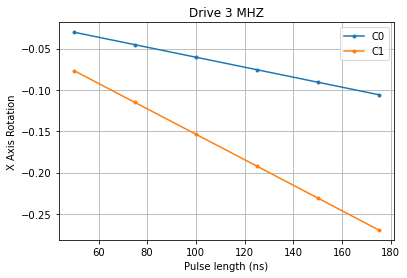

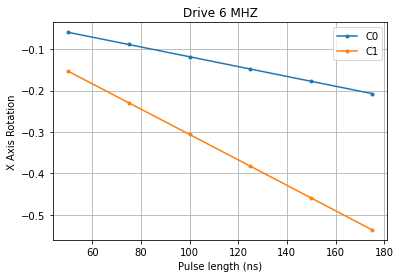

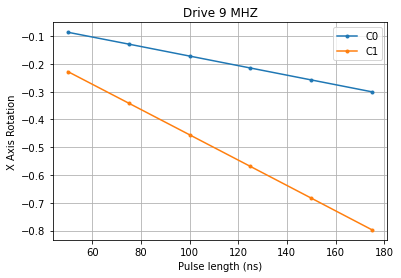

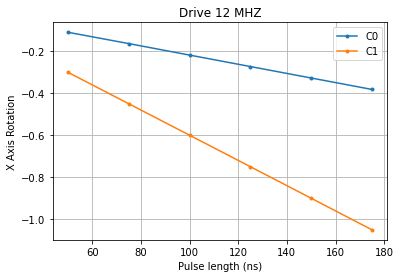

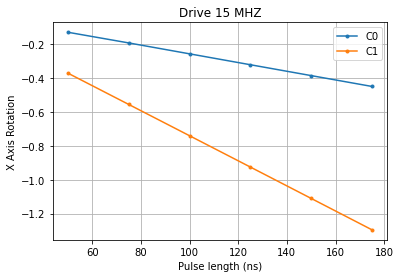

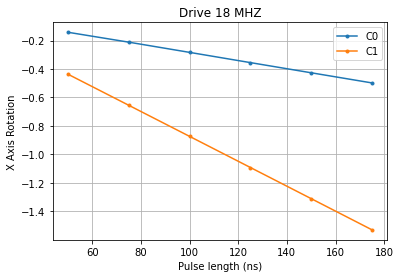

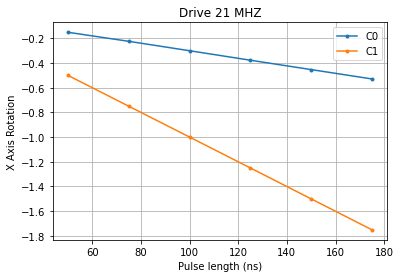

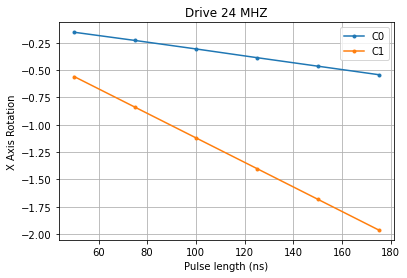

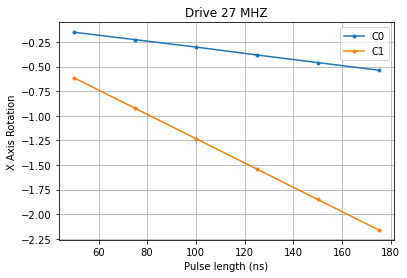

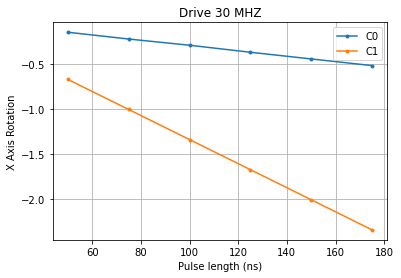

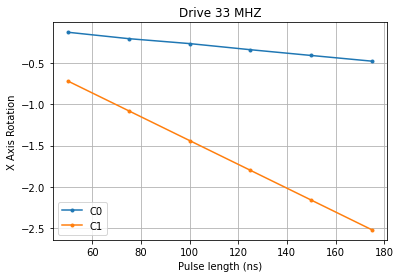

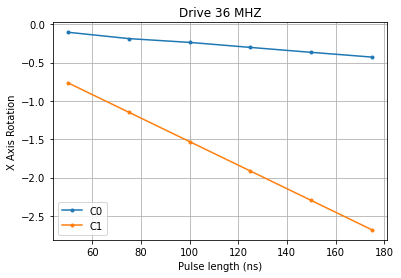

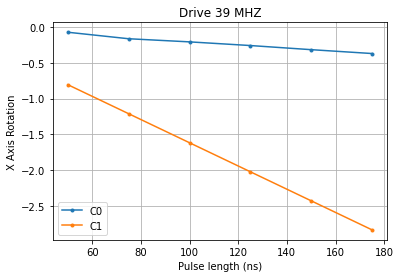

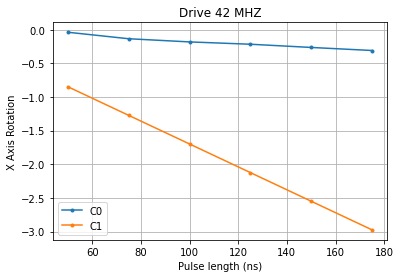

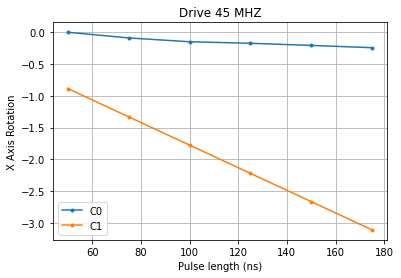

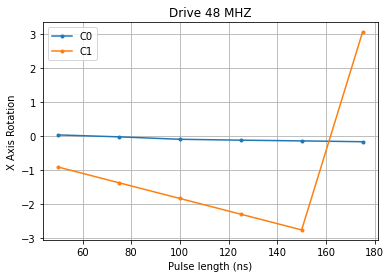

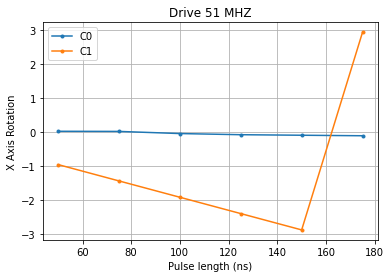

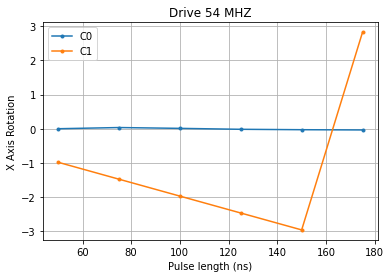

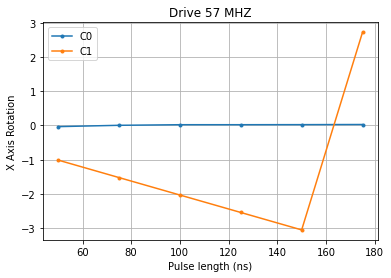

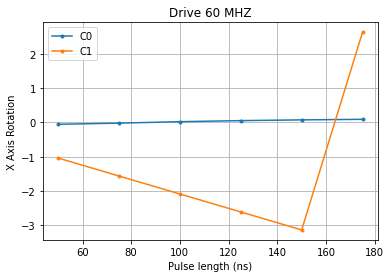

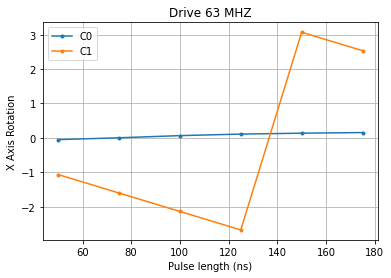

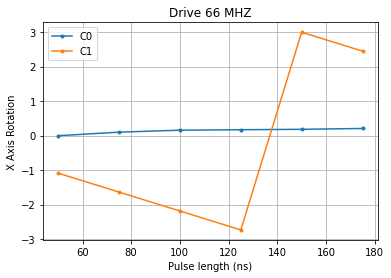

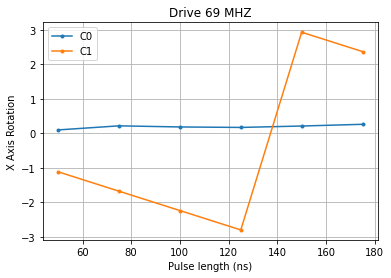

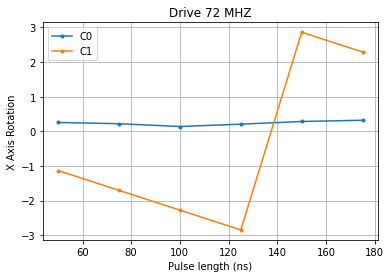

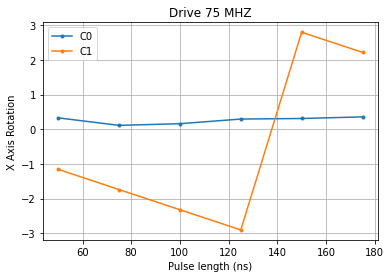

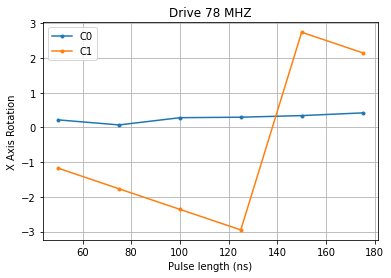

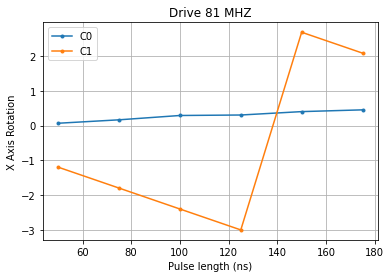

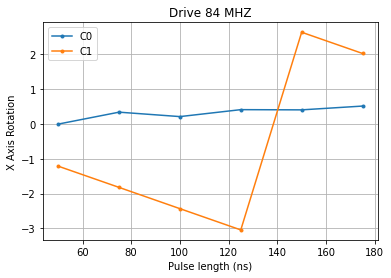

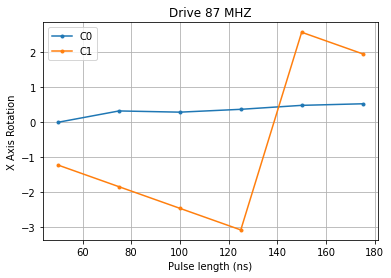

In [33]:
for i in phi0t:
    plt.plot(t_list,phi0t[i],'.-', label = "C0")
    plt.plot(t_list,phi1t[i],'.-', label = "C1")
    plt.title("Drive {} MHZ".format(i))
    plt.legend()
    plt.xlabel("Pulse length (ns)")
    plt.ylabel("X Axis Rotation")
    plt.grid()
    plt.show()

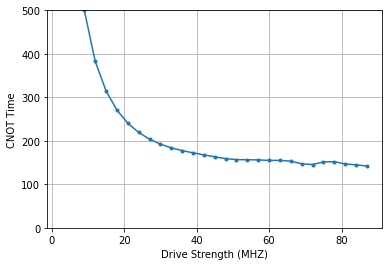

In [64]:
# Find and save time taken vs drive strength
def findtcnot(phi0t,phi1t):
    ts = []
    for i in phi0t:
        m0,b0 = np.polyfit(t_list[1:4],phi0t[i][1:4],1)
        m1,b1 = np.polyfit(t_list[1:4],phi1t[i][1:4],1)
        tcnot = np.roots([m1+m0,b1+b0+np.pi])
        if len(tcnot)==0:
            continue
        ts.append(tcnot[0])
#         print(ts)
#     print(ts)
    return ts
ts = findtcnot(phi0t,phi1t)
# ts = findtcnot(phi0_d[130],phi1_d[130])
plt.plot(E_list,ts,'.-')
plt.xlabel("Drive Strength (MHZ)")
plt.ylabel("CNOT Time")
plt.ylim(0,500)
plt.grid()
plt.show()
times = {}
for ind,i in enumerate(E_list):
    times[i] = ts[ind]
# with open("./pickles/CR_gate_raw_fidelity/cnot_times_60_MHz.pkl",'wb') as f:
#     pickle.dump(times,f)

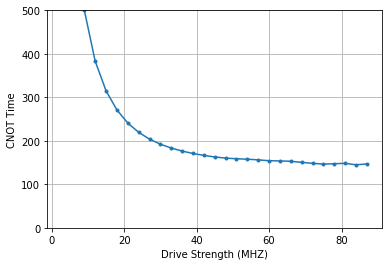

In [82]:
with open("./pickles/CR_gate_raw_fidelity/cnot_times_130_MHz.pkl",'rb') as f:
    times = pickle.load(f)
plt.plot([i for i in times],[times[i] for i in times],'.-')
plt.xlabel("Drive Strength (MHZ)")
plt.ylabel("CNOT Time")
plt.ylim(0,500)
plt.grid()
plt.show()
    

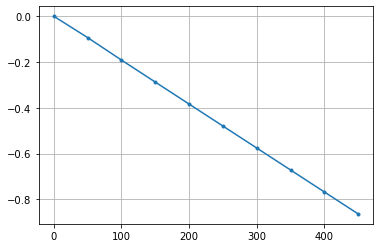

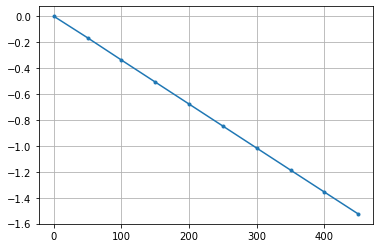

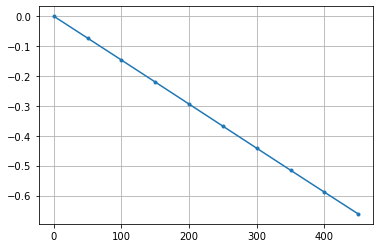

In [13]:
phi0 = np.array(phi0)
phi1 = np.array(phi1)
for ind,i in enumerate(phi0):
    if np.abs(phi0[ind] - phi0[ind-1])>np.pi/2 and ind!=0:
        phi0[ind:] = phi0[ind:]-np.pi
        break
for ind,i in enumerate(phi1):
    if np.abs(phi1[ind] - phi1[ind-1])>np.pi/2 and ind!=0:
        print("in")
        phi1[ind:] = phi1[ind:]-np.pi
        break
        
plt.plot(np.arange(0,500,50),phi0/np.pi,'.-')
plt.grid()
plt.show()
plt.plot(np.arange(0,500,50),phi1/np.pi,'.-')
plt.grid()
plt.show()
plt.plot(np.arange(0,500,50),(phi1-phi0)/np.pi,'.-')
plt.grid()
plt.show()

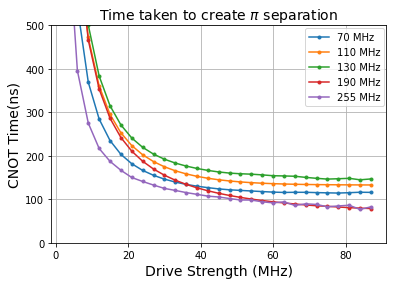

In [30]:
times = {}
for det in [70,110,130,190,255]:
    with open("./pickles/CR_gate_raw_fidelity/cnot_times_{}_MHz.pkl".format(det),'rb') as f:
        times[det] = pickle.load(f)
for det in [70,110,130,190,255]:
    plt.plot([i for i in times[det]],[times[det][i] for i in times[det]],'.-', label = "{} MHz".format(det))

plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title(r"Time taken to create $\pi$ separation", fontsize = 14)
plt.xlabel("Drive Strength (MHz)", fontsize = 14)
plt.ylabel("CNOT Time(ns)", fontsize = 14)
plt.ylim(0,500)
plt.grid()
plt.savefig("./Plots/CR_gate_raw_fidelities/New_Approach/CNOT_time_2_Qubit.jpeg", dpi = 600)
plt.show()
    

## Fidelity

**Gate fidelity vs Drive Strength**

In [16]:
F = {}
E_list = np
for det_i in [70,110,190,255]:#[50,70,75,110,130,190,230,255]:
    print(det_i)
    wc = 4.7*2*np.pi
    wt = wc-det_i*1e-3*2*np.pi
    det = wc-wt
    drive_det = 0
    anhc = 0.3*2*np.pi
    anht = 0.3*2*np.pi
    g = 0.003*2*np.pi

    Ec = find_dressed_lab(g,wc,wt,anhc,anht,N_l_c,N_l_t)[0]
    wt_c0 = Ec[1] - Ec[0]
    wt_c1 = Ec[5] - Ec[2] #Might not work without mapping the states
    wzz = wt_c1 - wt_c0
    drive_det = wt - 0.5*(wt_c0+wt_c1)

    Ec = find_dressed_rf(g,det,drive_det,anhc,anht,N_l_c,N_l_t)

    # Map the states to do proper transform
    state_map = {}
    for index,i in enumerate(Ec[1]):
        ind = np.argmax(np.abs(np.array(i,dtype = complex)))
        state_map[(int(ind/N_l_t),ind%N_l_t)] = index

    U_dressed = np.zeros((N_l_c*N_l_t,N_l_c*N_l_t),dtype = complex)
    for i in range(N_l_c*N_l_t):
        U_dressed[:,i] = np.array(Ec[1][state_map[(int(i/N_l_t),i%N_l_t)]],dtype = complex).reshape(1,N_l_c*N_l_t)

    U_dressed = qt.Qobj(U_dressed,dims = [[N_l_c,N_l_t],[N_l_c,N_l_t]], shape = (N_l_c*N_l_t,N_l_c*N_l_t))
    U_dressed = U_dressed.dag()
    Hc = H_c(g,det,drive_det,anhc,anht,N_l_c,N_l_t).transform(U_dressed)
    He,He_dag = H_e(N_l_c,N_l_t)
    He = He.transform(U_dressed)
    He_dag = He_dag.transform(U_dressed)
    # print(np.around(np.real(np.array(Hc)),3))
    H = [Hc,[He,pulse_coeff],[He_dag,pulse_coeff_dag]]
    args = {}
    args['tp'] = 140
    args['rf'] = 0.3
    args['t_step'] = 0.1
    with open("./pickles/CR_gate_raw_fidelity/cnot_times_{}_MHz.pkl".format(det_i),'rb') as f:
        times = pickle.load(f)
    F[det_i] = []
    for E in E_list:
        args['Emax'] = E*1e-3*2*np.pi
        args['tp'] = times[E]
        t = np.linspace(0,args['tp'],600)
        U0 = qt.tensor([qt.qeye(N_l_c),qt.qeye(N_l_t)])
        out_U = qt.sesolve(H,U0,t,args = args)
        F[det_i].append(get_f(out_U.states[-1]))
    


70
110
190
255


**For Small Drives, ZZ errors creep in due to long gate times. For very large drives, leakage causes error**

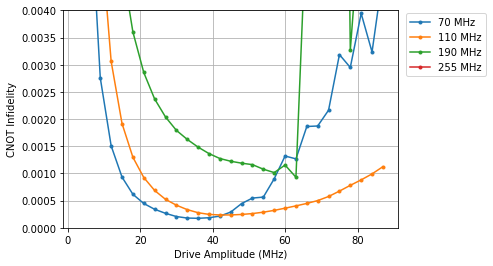

In [19]:
for det_i in [70,110,190,255]:
    plt.plot(E_list,1 - np.array(F[det_i]),'.-',label = '{} MHz'.format(det_i))
#     plt.plot(E_list,1 - np.array(F_class[det_i]),'.-',label = '{} MHz class'.format(det_i))
    
plt.grid()
plt.ylim(0,0.004)
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("CNOT Infidelity")
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.show()

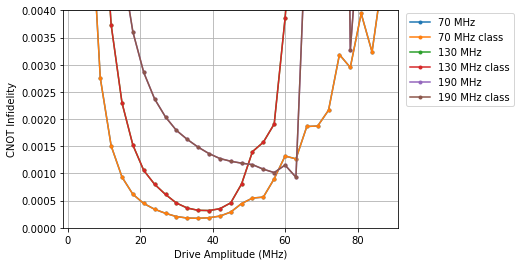

In [73]:
for det_i in [70,130,190]:
    plt.plot(E_list,1 - np.array(F[det_i]),'.-',label = '{} MHz'.format(det_i))
    plt.plot(E_list,1 - np.array(F_class[det_i]),'.-',label = '{} MHz class'.format(det_i))
    
plt.grid()
plt.ylim(0,0.004)
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("CNOT Infidelity")
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.show()

In [262]:
print(np.max(F[70]))
print(E_list[1+np.argmax(F[70])])
with open("./pickles/CR_gate_raw_fidelity/cnot_times_{}_MHz.pkl".format(190),'rb') as f:
    times = pickle.load(f)
print(times[36])

0.9998255738743094
36
134.41189246334173


# Adding a Spectator

**3 Qubit Simulation to find gate fidelity. Setup all basic functions**

In [9]:
def Enc(n,det,drive_det,anh):
    return n*(det + drive_det) - 0.5*n*(n-1)*anh
def Ent(n,drive_det,anh):
    return n*drive_det - 0.5*n*(n-1)*anh
def Ens(n,ws,wt,drive_det,anh):
    return n*(ws-wt+drive_det) - 0.5*n*(n-1)*anh

def H_bare(N_l,ws,wt,det,drive_det,anh):
    H = np.zeros((N_l**3,N_l**3), dtype = complex)
    for i in range(N_l):
        for j in range(N_l):
            for k in range(N_l):
                H[i*N_l**2 + j*N_l + k][i*N_l**2 + j*N_l + k] = Ens(i,ws,wt,drive_det,anh) + Enc(j,det,drive_det,anh) + Ent(k,drive_det,anh)
            
    H = qt.Qobj(H,dims = [[N_l]*3,[N_l]*3], shape = (N_l**3,N_l**3))
    return H

def H_g(g,N_l):
    H = np.zeros((N_l**3,N_l**3), dtype = complex)
    for l in range(0,N_l):
        for n in range(1,N_l):
            for m in range(1,N_l):
                H[l*N_l*N_l + n*N_l + m - 1][l*N_l*N_l + (n-1)*N_l + m] = g*np.sqrt(n*m)
                H[l*N_l*N_l + (n-1)*N_l + m][l*N_l*N_l + n*N_l + m - 1] = g*np.sqrt(n*m)
    for l in range(1,N_l):
        for n in range(1,N_l):
            for m in range(0,N_l):
                H[(l-1)*N_l*N_l + n*N_l + m][l*N_l*N_l + (n-1)*N_l + m] = g*np.sqrt(n*l)
                H[l*N_l*N_l + (n-1)*N_l + m][(l-1)*N_l*N_l + n*N_l + m] = g*np.sqrt(n*l)

    H = qt.Qobj(H,dims = [[N_l]*3,[N_l]*3], shape = (N_l**3,N_l**3))
    return H

def H_e(N_l):
    H = np.zeros((N_l**3,N_l**3), dtype = complex)
    H_dag = np.zeros((N_l**3,N_l**3), dtype = complex)
    for l in range(N_l):
        for n in range(1,N_l):
            for m in range(N_l):
                H_dag[l*N_l*N_l + n*N_l + m][l*N_l*N_l + (n-1)*N_l + m] = np.sqrt(n)
                H[l*N_l*N_l + (n-1)*N_l + m][l*N_l*N_l + n*N_l + m] = np.sqrt(n)
                
    H = qt.Qobj(H,dims = [[N_l]*3,[N_l]*3], shape = (N_l**3,N_l**3))
    H_dag = qt.Qobj(H_dag,dims = [[N_l]*3,[N_l]*3], shape = (N_l**3,N_l**3))
    return [H,H_dag]

def H_c(g,ws,wt,det,drive_det,anh,N_l):
    return H_bare(N_l,ws,wt,det,drive_det,anh) + H_g(g,N_l)

def find_dressed_lab(g,ws,wc,wt,anh,N_l):
    Ec = H_c(g,ws,wt,wc-wt,wt,anh,N_l).eigenstates()
    return Ec
def find_dressed_rf(g,ws,wc,wt,det,drive_det,anh,N_l):
    return H_c(g,ws,wt,det,drive_det,anh,N_l).eigenstates()
           
def create_qubits(N,N_l,exc,w,delta,J):
    qubits = {}
    qubits['N'] = N
    qubits['N_l'] = N_l
    qubits['exc'] = exc
    for i in range(N):
        qubits[i] = {}
        qubits[i]['w'] = w[i] # Set Frequency 
        qubits[i]['d'] = delta[i] # Set anharmonicity
        qubits[i]['cp'] = [] # List of qubits to which this qubit is coupled

    for i in range(N):
        for j in range(N):
            if J[i][j]!=0:
                qubits[i]['cp'].append(j)

    return qubits    
    
def find_dressed(H_red,qubits,N):
    E_val, E_vec = lin.eigh(H_red)
    E_vec = [list(i) for i in E_vec.T]
    E_c = [E_val,E_vec]
    ind_Ec = {}
    for i in range(len(E_c[1])):
        ind = np.argmax(np.abs(np.array(E_c[1][i])))
#         ind = state_order[ind]
        ind_Ec[ind] = E_c[0][i] 
#     print(N)
    for i in range(N):
        qubits[i]['w_kerr'] = {} 
#         print(i)
        for j in range(2**(N-1)):
            str_bin_j = bin(j).split('0b')[1]
            str_bin_j = '0'*(N-len(str_bin_j)-1) + str_bin_j
            bin_j_low = str_bin_j[0:i] + '0' + str_bin_j[i:]
            bin_j_high = str_bin_j[0:i] + '1' + str_bin_j[i:]        
            low_ind = sum([N_l**(N-1-k) if bin_j_low[k] == '1' else 0 for k in range(N)])
            high_ind = sum([N_l**(N-1-k) if bin_j_high[k] == '1' else 0 for k in range(N)])
            qubits[i]['w_kerr'][bin_j_low + '->' + bin_j_high] = (ind_Ec[high_ind] - ind_Ec[low_ind])# Transition Frequency
            if j == 0:
                qubits[i]['w_dressed'] = ind_Ec[high_ind] - ind_Ec[low_ind]
    for i in range(N):
        qubits[i]['w_mean_kerr'] = np.mean(list(qubits[i]['w_kerr'].values()))
        qubits[i]['w_dev_kerr'] = np.std(list(qubits[i]['w_kerr'].values()))
    
    return qubits
def create_H_3(N,N_l,w,anh_array,J):
    ws = w[0]
    wc = w[1]
    wt = w[2]
    det = wc-wt
    drive_det = 0

    qubits = create_qubits(N,N_l,3,w,anh_array,J)
    qubits = find_dressed(H_c(g,ws,wt,wc-wt,wt,anh,N_l),qubits,N)
    drive_det = wt - qubits[2]['w_mean_kerr']

    Ec = find_dressed_rf(g,ws,wc,wt,det,drive_det,anh,N_l)

    # Map the states to do proper transform
    state_map = {}
    for index,i in enumerate(Ec[1]):
        ind = np.argmax(np.abs(np.array(i,dtype = complex)))
        state_map[ind] = index
    # print(len(state_map))
    U_dressed = np.zeros((N_l**3,N_l**3),dtype = complex)
    for i in range(N_l**3):
        U_dressed[:,i] = np.array(Ec[1][state_map[i]],dtype = complex).reshape(1,N_l**3)

    U_dressed = qt.Qobj(U_dressed,dims = [[N_l]*3,[N_l]*3], shape = (N_l**3,N_l**3))
    U_dressed = U_dressed.dag()
    Hc = H_c(g,ws,wt,det,drive_det,anh,N_l).transform(U_dressed)
    # print(Hc)
    He,He_dag = H_e(N_l)
    He = He.transform(U_dressed)
    He_dag = He_dag.transform(U_dressed)
    # print(np.around(np.real(np.array(Hc)),3))
    H = [Hc,[He,pulse_coeff],[He_dag,pulse_coeff_dag]]
    return H


## Find fidelity

In [24]:
N = 3
N_l = 4
wc = 4.7*2*np.pi
wt = 4.63*2*np.pi
ws = 4.59*2*np.pi
anh = 0.3*2*np.pi
g = 0.003*2*np.pi

w = [ws,wc,wt]
J = [[0,1,0],
     [1,0,1],
     [0,1,0]]
J = g*np.array(J)
anh_array = [anh]*3

H = create_H_3(N,N_l,w,anh_array,J)
args = {}
args['tp'] = 140
args['Emax'] = 1e-3*39*2*np.pi
args['tp'] = 130.17
args['rf'] = 0.3
args['t_step'] = 0.1
t = np.arange(0,args['tp'],args['t_step'])
# print(H)

In [25]:
U0 = qt.tensor([qt.qeye(N_l),qt.qeye(N_l),qt.qeye(N_l)])
out_U = qt.sesolve(H,U0,t,args = args, progress_bar = True)

10.1%. Run time:   1.31s. Est. time left: 00:00:00:11
20.0%. Run time:   2.61s. Est. time left: 00:00:00:10
30.0%. Run time:   3.86s. Est. time left: 00:00:00:08
40.0%. Run time:   5.18s. Est. time left: 00:00:00:07
50.0%. Run time:   6.41s. Est. time left: 00:00:00:06
60.1%. Run time:   7.72s. Est. time left: 00:00:00:05
70.0%. Run time:   9.00s. Est. time left: 00:00:00:03
80.0%. Run time:  10.28s. Est. time left: 00:00:00:02
90.0%. Run time:  11.70s. Est. time left: 00:00:00:01
Total run time:  12.97s


In [26]:
def get_phi(U):
    M = np.zeros((8,8),dtype = complex)
    for i in range(8):
        for j in range(8):
            M[i][j] = U[sum([int(k)*(N_l)**(N-ind-1) for ind,k in enumerate(list(np.binary_repr(i,3)))]),sum([int(l)*(N_l)**(N-ind-1) for ind,l in enumerate(list(np.binary_repr(j,3)))])]
#     print(np.around(np.angle(np.array(M),deg = True)))
    phi0_s0 = -np.angle((M[0][0] + M[1][1] + M[0][1] + M[1][0])/(M[0][0] + M[1][1] - M[0][1] - M[1][0]))
    phi1_s0 = -np.angle((M[2][2] + M[3][3] + M[2][3] + M[3][2])/(M[2][2] + M[3][3] - M[2][3] - M[3][2]))
#     print("phi0_s0 = {}".format(phi0_s0*180/np.pi))
    theta0_s0 = np.angle((M[0][0] + M[1][1])*np.cos(phi0_s0/2) + 1j*(M[0][1] + M[1][0])*np.sin(phi0_s0/2))
    theta1_s0 = np.angle((M[2][2] + M[3][3])*np.cos(phi1_s0/2) + 1j*(M[2][3] + M[3][2])*np.sin(phi1_s0/2))
    
    phi0_s1 = -np.angle((M[4][4] + M[5][5] + M[4][5] + M[5][4])/(M[4][4] + M[5][5] - M[4][5] - M[5][4]))
    phi1_s1 = -np.angle((M[6][6] + M[7][7] + M[6][7] + M[7][6])/(M[6][6] + M[7][7] - M[6][7] - M[7][6]))
#     print("phi0_s1 = {}".format(phi0_s1*180/np.pi))
    theta0_s1 = np.angle((M[4][4] + M[5][5])*np.cos(phi0_s1/2) + 1j*(M[4][5] + M[5][4])*np.sin(phi0_s1/2))
    theta1_s1 = np.angle((M[6][6] + M[7][7])*np.cos(phi1_s1/2) + 1j*(M[6][7] + M[7][6])*np.sin(phi1_s1/2))
    
    phi0 = 0.5*(np.abs(phi0_s0) + np.abs(phi0_s1))
    phi1 = 0.5*(np.abs(phi1_s1) + np.abs(phi1_s1))
    
    thetas = 0.5*(theta0_s1 + theta1_s1 - theta0_s0 - theta1_s0)
    thetac = 0.5*(theta1_s0 + theta1_s1 - theta0_s0 - theta0_s1)
#     return [phi0,phi1,thetas,thetac,M]
    return [phi0,phi1,theta0_s0,theta1_s0,theta0_s1,theta1_s1,M]
phi0,phi1,t00,t01,t10,t11,M = get_phi(out_U.states[-1]) 
print(np.around(np.angle(M,deg = True)))
print(np.around(np.abs(M),2))
print(((np.around(np.abs(M),1)!=0)*1)*np.around(np.angle(M,deg = True)))
print("Theta C0 S0 = {}".format(t00*180/np.pi))
print("Theta C1 S0 = {}".format(t01*180/np.pi))
print("Theta C0 S1 = {}".format(t10*180/np.pi))
print("Theta C1 S1 = {}".format(t11*180/np.pi))
print("phi0 = {}".format(phi0*180/np.pi))
print("phi1 = {}".format(phi1*180/np.pi))

[[  76.  166. -127.  -82.   26.  109.   89.   12.]
 [ 166.   76.   98.   51.   98.   26.   56.   69.]
 [-125.  100. -157.  -69. -155. -105.  -39. -122.]
 [ -81.   53.  -69. -161.   83.   74.   60.  138.]
 [  25.   97. -158.   80.  148. -122.  -55.  170.]
 [ 108.   25. -108.   71. -122.  148.  170.  -57.]
 [  90.   56.  -40.   59.  -53.  172.  -85. -177.]
 [  13.   70. -123.  137.  171.  -55. -177.  -89.]]
[[0.88 0.47 0.01 0.   0.   0.   0.01 0.  ]
 [0.47 0.88 0.   0.01 0.   0.   0.   0.01]
 [0.01 0.   0.47 0.88 0.   0.   0.   0.  ]
 [0.   0.01 0.88 0.47 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.88 0.47 0.01 0.  ]
 [0.   0.   0.   0.   0.47 0.88 0.   0.01]
 [0.01 0.   0.   0.   0.01 0.   0.47 0.88]
 [0.   0.01 0.   0.   0.   0.01 0.88 0.47]]
[[  76.  166.   -0.   -0.    0.    0.    0.    0.]
 [ 166.   76.    0.    0.    0.    0.    0.    0.]
 [  -0.    0. -157.  -69.   -0.   -0.   -0.   -0.]
 [  -0.    0.  -69. -161.    0.    0.    0.    0.]
 [   0.    0.   -0.    0.  148. -122.   -0

In [27]:
def get_U(theta0_s0,theta1_s0,theta0_s1,theta1_s1,signs = [-1,1,-1,-1]):
    
    U = np.zeros((2**3,2**3),dtype = complex)
    U[0][0] = np.exp(1j*theta0_s0)*np.cos(phi0/2)
    U[1][1] = np.exp(1j*theta0_s0)*np.cos(phi0/2)
    
    U[2][2] = np.exp(1j*theta1_s0)*np.cos(phi1/2)
    U[3][3] = np.exp(1j*theta1_s0)*np.cos(phi1/2)
#     print("Theta0_s0 = ",theta0_s0*180/np.pi)
#     print("Angle without -1j = ",np.angle(np.exp(1j*theta0_s0)*np.cos(phi0/2), deg = True))
#     print("Angle with -1j = ", np.angle(-1j*np.exp(1j*theta0_s0),deg = True))
#     print(np.sin(phi0/2))
    U[1][0] = signs[0]*1j*np.exp(1j*theta0_s0)*np.sin(phi0/2)
    U[0][1] = signs[0]*1j*np.exp(1j*theta0_s0)*np.sin(phi0/2)
#     print("Theta1_s0 = ",theta1_s0*180/np.pi)
#     print("Angle without -1j = ",np.angle(np.exp(1j*theta1_s0), deg = True))
#     print("Angle with -1j = ", np.angle(-1j*np.exp(1j*theta1_s0),deg = True))
    
    U[3][2] = signs[1]*1j*np.exp(1j*theta1_s0)*np.sin(phi1/2)
    U[2][3] = signs[1]*1j*np.exp(1j*theta1_s0)*np.sin(phi1/2)

    U[4][4] = np.exp(1j*theta0_s1)*np.cos(phi0/2)
    U[5][5] = np.exp(1j*theta0_s1)*np.cos(phi0/2)

    U[6][6] = np.exp(1j*theta1_s1)*np.cos(phi1/2)
    U[7][7] = np.exp(1j*theta1_s1)*np.cos(phi1/2)

    U[5][4] = signs[2]*1j*np.exp(1j*theta0_s1)*np.sin(phi0/2)
    U[4][5] = signs[2]*1j*np.exp(1j*theta0_s1)*np.sin(phi0/2)

    U[7][6] = signs[3]*1j*np.exp(1j*theta1_s1)*np.sin(phi1/2)
    U[6][7] = signs[3]*1j*np.exp(1j*theta1_s1)*np.sin(phi1/2)
    return U
    
def get_f(U):
    phi0,phi1,theta0_s0,theta1_s0,theta0_s1,theta1_s1,M = get_phi(U)
#     print(((np.around(np.abs(M),1)!=0)*1)*np.around(np.angle(M,deg = True)))
#     print(np.around(np.abs(M),2))
    
    M = qt.Qobj(M, dims = [[2 for i in range(3)],[2 for i in range(3)]], shape = (2**3,2**3))
    
#     print("Theta C0 S0 = {}".format(theta0_s0*180/np.pi))
#     print("Theta C1 S0 = {}".format(theta1_s0*180/np.pi))
#     print("Theta C0 S1 = {}".format(theta0_s1*180/np.pi))
#     print("Theta C1 S1 = {}".format(theta1_s1*180/np.pi))
#     print("phi0 = {}".format(phi0*180/np.pi))
#     print("phi1 = {}".format(phi1*180/np.pi))
#     phi1 = -phi1
    F_list = []
    for i in range(256): # -1, 1, -1, -1 [48] range(256)
        signs = [1 if j=='0' else -1 for j in list(np.binary_repr(i,8))]
#         print(signs)
        U = np.zeros((2**3,2**3),dtype = complex)
        U[0][0] = signs[4]*np.exp(1j*theta0_s0)*np.cos(phi0/2)
        U[1][1] = signs[4]*np.exp(1j*theta0_s0)*np.cos(phi0/2)

        U[2][2] = signs[5]*np.exp(1j*theta1_s0)*np.cos(phi1/2)
        U[3][3] = signs[5]*np.exp(1j*theta1_s0)*np.cos(phi1/2)
    
        U[1][0] = signs[0]*1j*np.exp(1j*theta0_s0)*np.sin(phi0/2)
        U[0][1] = signs[0]*1j*np.exp(1j*theta0_s0)*np.sin(phi0/2)
    
        U[3][2] = signs[1]*1j*np.exp(1j*theta1_s0)*np.sin(phi1/2)
        U[2][3] = signs[1]*1j*np.exp(1j*theta1_s0)*np.sin(phi1/2)

        U[4][4] = signs[6]*np.exp(1j*theta0_s1)*np.cos(phi0/2)
        U[5][5] = signs[6]*np.exp(1j*theta0_s1)*np.cos(phi0/2)

        U[6][6] = signs[7]*np.exp(1j*theta1_s1)*np.cos(phi1/2)
        U[7][7] = signs[7]*np.exp(1j*theta1_s1)*np.cos(phi1/2)

        U[5][4] = signs[2]*1j*np.exp(1j*theta0_s1)*np.sin(phi0/2)
        U[4][5] = signs[2]*1j*np.exp(1j*theta0_s1)*np.sin(phi0/2)

        U[7][6] = signs[3]*1j*np.exp(1j*theta1_s1)*np.sin(phi1/2)
        U[6][7] = signs[3]*1j*np.exp(1j*theta1_s1)*np.sin(phi1/2)
        
#         print(np.around(np.angle(U,deg = True)))
#         print(np.around(np.abs(U),2))

        U_cr = qt.Qobj(U, dims = [[2 for i in range(3)],[2 for i in range(3)]], shape = (2**3,2**3))

        d = 2**3

        F = (1/(d*(d+1)))*((M.dag()*M).tr() + np.abs((M.dag()*U_cr).tr())**2)
        F_list.append(F)
#         print(F)
#     print("Fidelity: ",F)
#     print(F_list)
#     print(len(F_list))
    F = max(F_list)
#     print(np.argmax(F_list))
    return F,M
F,M = get_f(out_U.states[-1])
print(F)

0.9997452709569463


In [28]:
F_3qubit = []
for E in tqdm(E_list):
    args['Emax'] = 1e-3*E*2*np.pi
    args['tp'] = times[E]
    args['rf'] = 0.3
    args['t_step'] = 0.1
    t = np.linspace(0,args['tp'],400)
    U0 = qt.tensor([qt.qeye(N_l),qt.qeye(N_l),qt.qeye(N_l)])
    out_U = qt.sesolve(H,U0,t,args = args)
    F_3qubit.append(get_f(out_U.states[-1]))

100%|███████████████████████████████████████████| 29/29 [04:55<00:00, 10.17s/it]


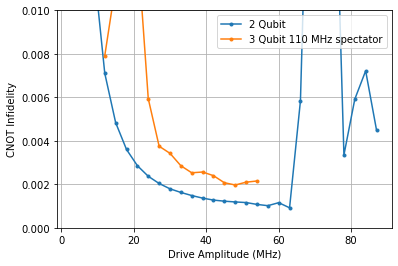

In [266]:
plt.plot(E_list[1:],1 - np.array(F[190]),'.-',label = '2 Qubit')
plt.plot(E_list[4:19],1 - np.array(F_3qubit), '.-', label = '3 Qubit 110 MHz spectator')
plt.grid()
plt.ylim(0,0.01)
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("CNOT Infidelity")
plt.legend()
plt.show()

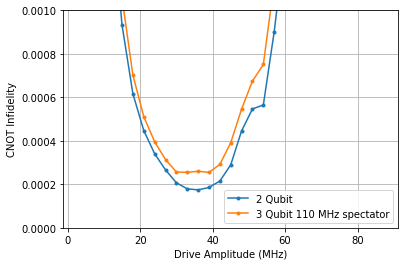

In [105]:
plt.plot(E_list[1:],1 - np.array(F[70]),'.-',label = '2 Qubit')
plt.plot(E_list[1:],1 - np.array(F_3qubit), '.-', label = '3 Qubit 110 MHz spectator')
plt.grid()
plt.ylim(0,0.001)
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("CNOT Infidelity")
plt.legend()
plt.show()

In [112]:
print(np.max(F_3qubit))
print(np.argmax(F_3qubit))
print(E_list[1+np.argmax(F_3qubit)])
print(times[E_list[1+np.argmax(F_3qubit)]])

0.9997451615285212
12
39
130.1697658221534


In [124]:
with open("./pickles/CR_gate_raw_fidelity/cnot_times_130_MHz.pkl",'rb') as f:
    times_190 = pickle.load(f)
print(times_190)

{3: 1465.0399500706765, 6: 739.3960042709192, 9: 500.5724119459547, 12: 383.476314463637, 15: 315.0901379587656, 18: 271.07150480319666, 21: 240.98019450158623, 24: 219.58126404411448, 27: 203.9416929258277, 30: 192.26950875559908, 33: 183.38585004202665, 36: 176.46541261227844, 39: 170.93638657981683, 42: 166.45541593805905, 45: 162.8855637272295, 48: 160.28197446311268, 51: 158.754125870454, 54: 157.8026971523319, 57: 156.17842016856733, 60: 154.2521657661235, 63: 153.74550966347263, 66: 152.99409045389785, 69: 150.4460725177451, 72: 148.26876603019645, 75: 146.48188244411455, 78: 147.32723629858768, 81: 148.26131295477643, 84: 144.8573744609797, 87: 146.84652059188508}


## Spec frequency sweep

**Sweep the Frequency of the spectator**

In [7]:
N = 3
N_l = 4
wc = 4.7*2*np.pi
wt = 4.57*2*np.pi
ws = 4.63*2*np.pi
anh = 0.3*2*np.pi
g = 0.003*2*np.pi

w = [ws,wc,wt]
J = [[0,1,0],
     [1,0,1],
     [0,1,0]]
J = g*np.array(J)
anh_array = [anh]*3
F_spec_sweep = []
args['Emax'] = 1e-3*39*2*np.pi
args['tp'] = 170.93
t = np.linspace(0,args['tp'],400)
def return_f_spec_sweep(ws):
    w = [ws,wc,wt]
    H = create_H_3(N,N_l,w,anh_array,J)
    U0 = qt.tensor([qt.qeye(N_l),qt.qeye(N_l),qt.qeye(N_l)])
    out_U = qt.sesolve(H,U0,t,args = args)
    return get_f(out_U.states[-1])

ws_range = 2*np.pi*np.arange(4.43,4.67,0.001)
print(ws_range[47:51])
F_spec_sweep_3 = Parallel(n_jobs=-1)(delayed(return_f_spec_sweep)(w) for w in tqdm(ws_range))
# F_spec_sweep_3 = [return_f_spec_sweep(w) for w in tqdm(ws_range)]

[28.12982062 28.13610381 28.14238699 28.14867018]


100%|██████████| 241/241 [16:13<00:00,  4.04s/it]


In [8]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_130_CT_spec_sweep_39MHz_0.3rf_new_fidelity_def.pkl", 'wb') as f:
    pickle.dump(F_spec_sweep_3,f)

In [9]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_130_CT_spec_sweep_39MHz_0.3rf_new_fidelity_def.pkl", 'rb') as f:
    F_test = pickle.load(f)

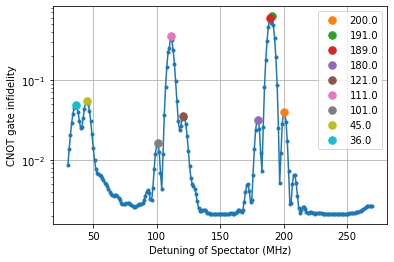

In [128]:
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array(F_test),'.-')
peak_ind = list(sp.signal.find_peaks(1 - np.array(F_test),height = 0.01)[0])
for i in peak_ind:
    plt.plot((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i], (1-np.array(F_test))[i], '.', markersize = 15, label = np.around((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i],3))
plt.legend()
# plt.ylim(0)
plt.grid()
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()

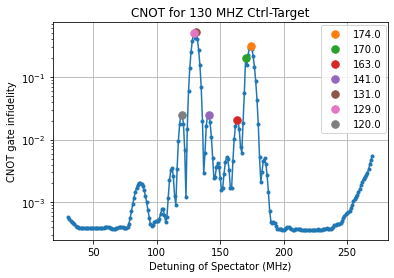

In [14]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_130_CT_spec_sweep_39MHz_0.3rf_new_fidelity_def.pkl", 'rb') as f:
    F_test = pickle.load(f)
    
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array(F_test),'.-')
peak_ind = list(sp.signal.find_peaks(1 - np.array(F_test),height = 0.01)[0])
for i in peak_ind:
    plt.plot((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i], (1-np.array(F_test))[i], '.', markersize = 15, label = np.around((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i],3))
plt.legend(bbox_to_anchor = (1.01,1.01))
# plt.ylim(0)
plt.grid()
plt.title("CNOT for 130 MHZ Ctrl-Target")
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()

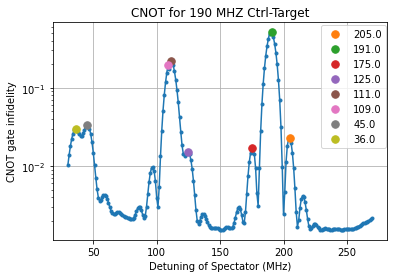

In [15]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_190_CT_spec_sweep_39MHz_0.3rf_new_fidelity_def.pkl", 'rb') as f:
    F_test = pickle.load(f)
    
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array(F_test),'.-')
peak_ind = list(sp.signal.find_peaks(1 - np.array(F_test),height = 0.01)[0])
for i in peak_ind:
    plt.plot((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i], (1-np.array(F_test))[i], '.', markersize = 15, label = np.around((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i],3))
plt.legend(bbox_to_anchor = (1.01,1.01))
# plt.ylim(0)
plt.grid()
plt.title("CNOT for 190 MHZ Ctrl-Target")
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()

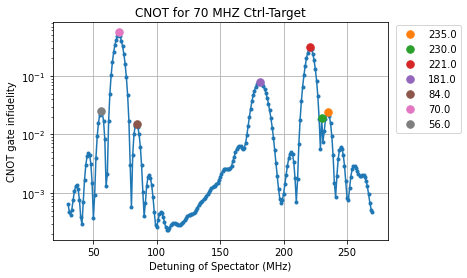

In [16]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_70_CT_spec_sweep_39MHz_0.3rf_new_fidelity_def.pkl", 'rb') as f:
    F_test = pickle.load(f)
    
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array(F_test),'.-')
peak_ind = list(sp.signal.find_peaks(1 - np.array(F_test),height = 0.01)[0])
for i in peak_ind:
    plt.plot((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i], (1-np.array(F_test))[i], '.', markersize = 15, label = np.around((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i],3))
plt.legend(bbox_to_anchor = (1.01,1.01))
# plt.ylim(0)
plt.grid()
plt.title("CNOT for 70 MHZ Ctrl-Target")
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()

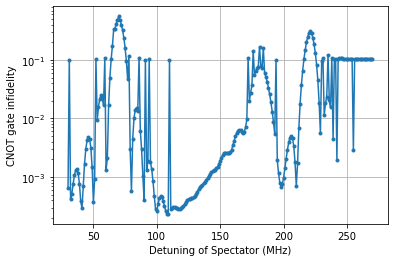

In [14]:
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array(F_spec_sweep_3),'.-')
# plt.ylim(0)
plt.grid()
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()

In [67]:
phi0 = {}
phi1 = {}
# thetas = {}
# thetac = {}
theta0_s0 = {}
theta1_s0 = {}
theta0_s1 = {}
theta1_s1 = {}
t_list = np.arange(50,400,50)
E_list = np.arange(20,60,5)
for i in tqdm(E_list):
    args = {}
    args['rf'] = 0.3
    args['t_step'] = 0.1
    phi0[i] = []
    phi1[i] = []
#     thetas[i] = []
#     thetac[i] = []
    theta0_s0[i] = []
    theta1_s0[i] = []
    theta0_s1[i] = []
    theta1_s1[i] = []
    for j in t_list:
        args['Emax'] = i*1e-3*2*np.pi
        args['tp'] = j
        t = np.linspace(0,j,600)
        U0 = qt.tensor([qt.qeye(N_l),qt.qeye(N_l),qt.qeye(N_l)])
        out_U = qt.sesolve(H,U0,t,args = args)
#         a,b,thetas_var,thetac_var,_ = get_phi(out_U.states[-1])
        a,b,theta0s0_var,theta1s0_var,theta0s1_var,theta1s1_var,_ = get_phi(out_U.states[-1])
        phi0[i].append(a)
        phi1[i].append(b)
        theta0_s0[i].append(theta0s0_var)
        theta1_s0[i].append(theta1s0_var)
        theta0_s1[i].append(theta0s1_var)
        theta1_s1[i].append(theta1s1_var)

#         thetas[i].append(thetas_var)
#         thetac[i].append(thetac_var)
    phi0[i] = np.array(phi0[i])
    phi1[i] = np.array(phi1[i])
#     thetas[i] = np.array(thetas[i])
#     thetac[i] = np.array(thetac[i])
    theta0_s0[i] = np.array(theta0_s0[i])
    theta1_s0[i] = np.array(theta1_s0[i])
    theta0_s1[i] = np.array(theta0_s1[i])
    theta1_s1[i] = np.array(theta1_s1[i])
    

100%|██████████| 8/8 [10:23<00:00, 77.91s/it]


In [64]:
phi0t = phi0.copy()
phi1t = phi1.copy()
for i in phi0t:
    for j in range(1,len(phi0t[i])):
        if np.abs(phi0t[i][j] - phi0t[i][j-1])>0.8*np.pi:
            phi0t[i][j:] = phi0t[i][j:] - 2*np.pi
            break
for i in phi1t:
    for j in range(1,len(phi1t[i])):
        if np.abs(phi1t[i][j] - phi1t[i][j-1])>0.8*np.pi:
            phi1t[i][j:] = phi1t[i][j:] - 2*np.pi
            break

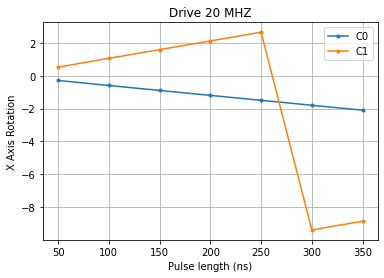

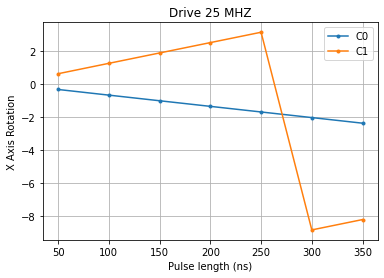

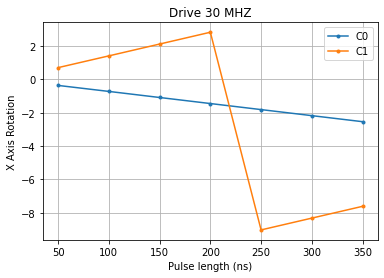

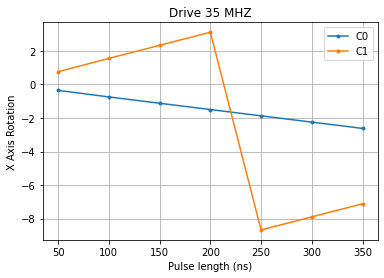

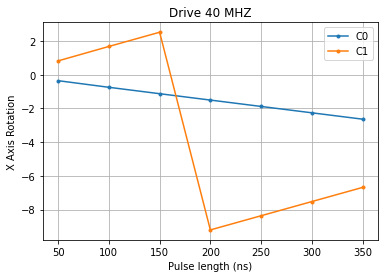

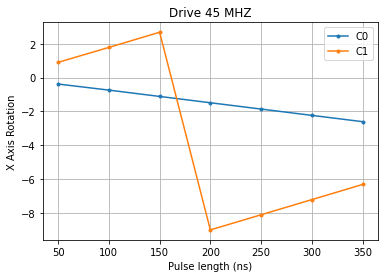

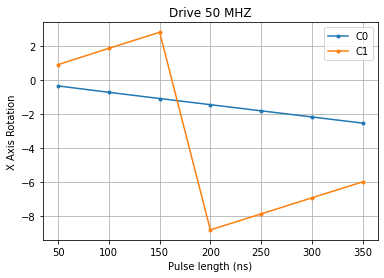

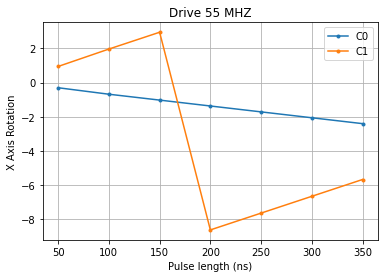

In [65]:
for i in phi0t:
    plt.plot(t_list,phi0t[i],'.-', label = "C0")
    plt.plot(t_list,phi1t[i],'.-', label = "C1")
    plt.title("Drive {} MHZ".format(i))
    plt.legend()
    plt.xlabel("Pulse length (ns)")
    plt.ylabel("X Axis Rotation")
    plt.grid()
    plt.show()

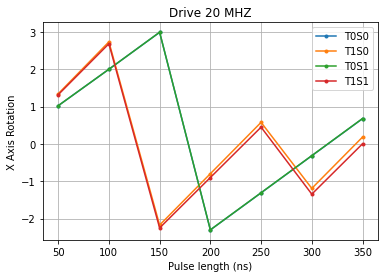

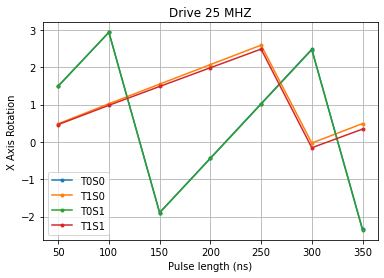

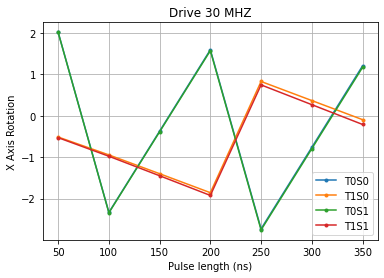

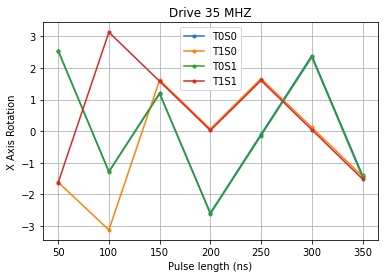

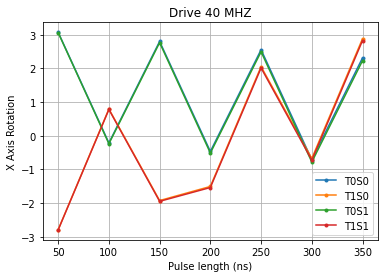

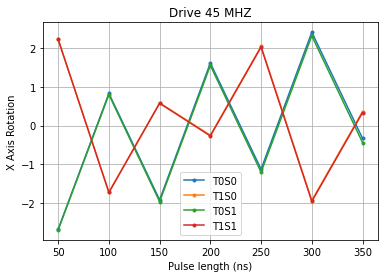

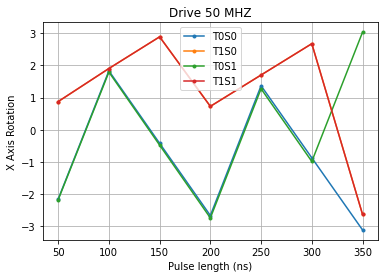

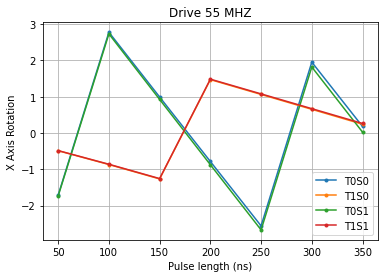

In [68]:
for i in phi0t:
    plt.plot(t_list,theta0_s0[i],'.-', label = "T0S0")
    plt.plot(t_list,theta1_s0[i],'.-', label = "T1S0")
    plt.plot(t_list,theta0_s1[i],'.-', label = "T0S1")
    plt.plot(t_list,theta1_s1[i],'.-', label = "T1S1")
    plt.title("Drive {} MHZ".format(i))
    plt.legend()
    plt.xlabel("Pulse length (ns)")
    plt.ylabel("X Axis Rotation")
    plt.grid()
    plt.show()

# Multiqubit Analysis

## Main Class

In [24]:
class processor:
    
    def __init__(self,N,N_l,exc,w,anh,J,control_target,args):
        self.N = N
        self.N_l = N_l
        self.exc = exc
        self.d_hs, self.state2idx, self.idx2state = qt.enr_state_dictionaries([self.N_l for i in range(self.N)],self.exc)
        self.J = J
        self.control_target = control_target
        self.drive_w = 0
        self.create_qubits(w,anh,J)
        self.create_args(args)
        self.progress_bar = None
        self.signs_progress_bar = False # For debugging the signs required for fidelity

    def create_qubits(self,w,anh,J):
      
        self.qubits = {}
        for i in range(self.N):
            self.qubits[i] = {}
            self.qubits[i]['w'] = w[i] # Set Frequency 
            self.qubits[i]['a'] = anh[i] # Set anharmonicity
            self.qubits[i]['cp'] = [] # List of qubits to which this qubit is coupled

        for i in range(self.N):
            for j in range(self.N):
                if self.J[i][j]!=0:
                    self.qubits[i]['cp'].append(j)
        
        self.create_H_pr()
#         self.generate_state_map()
        self.find_dressed()
#         self.disp_qubits()
        
#     def base_repr(self,i):
#         rep = np.base_repr(i,self.N_l)
#         ret_rep = rep
#         while len(ret_rep)<self.N:
#             ret_rep = '0' + ret_rep
#         return ret_rep
    
# #     def Eni(self,n,i):
# #         return n*(self.qubits[i]['w'] - self.drive_w) - 0.5*n*(n-1)*self.qubits[i]['a']
    
    def create_H_pr(self):
    # Create Hamiltonian
        self.H_g = qt.tensor([qt.qeye(self.N_l) for i in range(self.N)])*0
        self.H_bare = qt.tensor([qt.qeye(self.N_l) for i in range(self.N)])*0
        self.H_e = qt.tensor([qt.qeye(self.N_l) for i in range(self.N)])*0
        self.a_ops = {}
        ex_ops = {}
        ey_ops = {}
        ez_ops = {}
        for i in range(self.N):

            # Assume a Kerr Approximation, for now
            ai = qt.tensor([qt.qeye(self.N_l) if k!=i else qt.destroy(self.N_l) for k in range(self.N)])
            self.a_ops[i] = ai
            ez_ops[i] = 1 - 2*(ai.dag()*ai)
            ex_ops[i] = (ai.dag()+ai)
            ey_ops[i] = ((ai.dag() - ai)/(1j))
            self.H_bare += self.qubits[i]['w']*ai.dag()*ai 
            self.H_bare -= 0.5*self.qubits[i]['a']*(ai.dag()*ai*ai.dag()*ai - ai.dag()*ai)
            self.H_bare -= self.drive_w*ai.dag()*ai
            
            # Add coupling terms only if J[i][j] matrix is non zero
            for j in range(i):
                aj = qt.tensor([qt.qeye(self.N_l) if k!=j else qt.destroy(self.N_l) for k in range(self.N)])
                self.H_g += self.J[i][j]*(ai.dag()*aj + ai*aj.dag())
        self.H_c = self.H_bare + self.H_g
        
        
    def create_H_drive(self,ctrl,tgt, dressed_frequency = False):
        
        if dressed_frequency:
            self.drive_w = self.qubits[tgt]['w_dressed']
        else:
            self.drive_w = self.qubits[tgt]['w_mean_kerr']
            
        self.create_H_pr()
        Ec = self.H_c.eigenstates()

        # Map the states to do proper transform
        state_map = {}
        for index,i in enumerate(Ec[1]):
            ind = np.argmax(np.abs(np.array(i,dtype = complex)))
            state_map[ind] = index
        # print(len(state_map))
        U_dressed = np.zeros((self.N_l**self.N,self.N_l**self.N),dtype = complex)
        for i in range(self.N_l**self.N):
            U_dressed[:,i] = np.array(Ec[1][state_map[i]],dtype = complex).reshape(1,self.N_l**self.N)

        U_dressed = qt.Qobj(U_dressed,dims = [[self.N_l]*self.N,[self.N_l]*self.N], shape = (self.N_l**self.N,self.N_l**self.N))
        U_dressed = U_dressed.dag()
        self.H_c = self.H_c.transform(U_dressed)
        # print(Hc)
        self.He = self.a_ops[ctrl]
        self.He_dag = self.a_ops[ctrl].dag()
        self.He = self.He.transform(U_dressed)
        self.He_dag = self.He_dag.transform(U_dressed)
        # print(np.around(np.real(np.array(Hc)),3))
        self.H = [self.H_c,[self.He,pulse_coeff],[self.He_dag,pulse_coeff_dag]]
    
    def H_of_t(self,t):
        H = np.array(self.H_c + pulse_coeff(t,self.args)*self.He + pulse_coeff_dag(t,self.args)*self.He_dag, dtype = complex)
        return H
    
    def psi_dot(self,t,y):
#         print("Shape of Hamiltonian: ",self.H_of_t(0).shape)
#         print("Hamiltonian: ")
#         print(self.H_of_t(0))
#         print("Shape of vector: ",y.shape)
#         print("Vector: ")
#         print(y)
#         out = -1j*self.H_of_t(t)@y
#         print("Shape of out: ")
#         print(out.shape)
#         print("Out: ")
#         print(out)
        
        return (-1j*self.H_of_t(t)@y)
        
    
    def disp_qubits(self):
        rows = [['Qubit','frequency (GHz)','anharmonicity(GHz)','Targets']]
        for i in range(self.N):
            rows.append([i+1,self.qubits[i]['w']/(2*np.pi),self.qubits[i]['a']/(2*np.pi),[j+1 for j in range(self.N) if self.control_target[i][j]!=0]])
        print(tabulate(rows,tablefmt = 'grid'))

    def generate_state_map(self):
        E_val, E_vec = self.H_c.eigenstates()
        self.state2E = {}
        for i in range(len(E_vec)):
            self.state2E[self.idx2state[np.argmax(np.abs(np.array(E_vec[i])))]] = np.abs(E_val[i])
        print("State map length = ",len(self.state2E))
        
    def find_dressed(self):  
        E_val, E_vec = lin.eigh(self.H_c)
        E_vec = [list(i) for i in E_vec.T]
        E_c = [E_val,E_vec]
        ind_Ec = {}
        for i in range(len(E_c[1])):
            ind = np.argmax(np.abs(np.array(E_c[1][i])))
    #         ind = state_order[ind]
            ind_Ec[ind] = E_c[0][i] 
    
        for i in range(self.N):
            self.qubits[i]['w_kerr'] = {} 
            for j in range(2**(self.N-1)):
                str_bin_j = bin(j).split('0b')[1]
                str_bin_j = '0'*(self.N-len(str_bin_j)-1) + str_bin_j
                bin_j_low = str_bin_j[0:i] + '0' + str_bin_j[i:]
                bin_j_high = str_bin_j[0:i] + '1' + str_bin_j[i:]        
                low_ind = sum([self.N_l**(self.N-1-k) if bin_j_low[k] == '1' else 0 for k in range(self.N)])
                high_ind = sum([self.N_l**(self.N-1-k) if bin_j_high[k] == '1' else 0 for k in range(self.N)])
                self.qubits[i]['w_kerr'][bin_j_low + '->' + bin_j_high] = (ind_Ec[high_ind] - ind_Ec[low_ind])# Transition Frequency
                if j == 0:
                    self.qubits[i]['w_dressed'] = ind_Ec[high_ind] - ind_Ec[low_ind]
        for i in range(N):
            self.qubits[i]['w_mean_kerr'] = np.mean(list(self.qubits[i]['w_kerr'].values()))
            self.qubits[i]['w_dev_kerr'] = np.std(list(self.qubits[i]['w_kerr'].values()))

    def print_U(self,M):
        print(np.around(np.abs(np.array(M)),2))
        print((np.around(np.abs(np.array(M)),1)!=0)*np.around(np.angle(np.array(M),deg = True),2))
    
    def create_args(self,args):
        self.args = args
        self.t = np.linspace(0,self.args['tp'],1200)
        
    
    def get_out_U(self,ctrl,tgt,args,dressed_frequency = False):
        print("Solving the whole unitary")
        self.create_args(args)
        self.create_H_drive(ctrl,tgt,dressed_frequency)
        U0 = qt.tensor([qt.qeye(self.N_l) for i in range(self.N)])
        out_U = qt.sesolve(self.H,U0,self.t,args = self.args, progress_bar = self.progress_bar) #, progress_bar = True
        return out_U
    
    def get_out_U_vectors(self,ctrl,tgt,args,vectors,dressed_frequency = False):
        self.create_args(args)
        self.create_H_drive(ctrl,tgt,dressed_frequency)
        psi0_l = []
        for ind,i in enumerate(vectors):
            psi0_l.append(qt.tensor([qt.basis(self.N_l,0) if j == 0 else qt.basis(self.N_l,1) for j in i]))
        psi_out_d = {}
        if self.progress_bar:
            iterable = tqdm(enumerate(psi0_l))
        else:
            iterable = enumerate(psi0_l)
        for ind,psi0 in iterable:
            psi_out = qt.sesolve(self.H,psi0,self.t,args = self.args,progress_bar = self.progress_bar)
#             psi_out_d[vectors[ind]] = psi_out
            psi_out_d[ind] = psi_out.states[-1]
        return psi_out_d
    
    def get_M_vectors(self,ctrl,tgt,args,dressed_frequency = False):
        
        self.create_args(args)

        vectors = []
        for i in range(2**self.N):
            vectors.append(tuple([int(j) for j in np.binary_repr(i,self.N)]))
        vectors_out = self.get_out_U_vectors(ctrl,tgt,args,vectors,dressed_frequency)
#         print("Shapes of the vectors: ")
#         for i in vectors_out:
#             print(vectors_out[i].shape)
        M = np.zeros((2**self.N,2**self.N),dtype = complex)
        for i in range(2**self.N):
            for j in range(2**self.N):
                M[i][j] = vectors_out[j][sum([int(k)*(self.N_l)**(self.N-ind-1) for ind,k in enumerate(list(np.binary_repr(i,self.N)))])]   
        
        M = qt.Qobj(M, dims = [[2 for i in range(self.N)],[2 for i in range(self.N)]], shape = (2**self.N,2**self.N))
        M = M.permute([i for i in range(self.N) if i!=ctrl and i!=tgt]+[ctrl,tgt])
        return M
    
    def integrate_scipy(self,psi0,args):
        self.create_args(args)
#         y = sp.integrate.odeint(self.psi_dot,np.array(psi0,dtype = complex),self.t)
        sol = sp.integrate.complex_ode(self.psi_dot).set_integrator('Isoda')

#         print("initial vector: ")
#         print(np.array(psi0, dtype = complex).reshape((self.N_l**self.N)))
#         print("initial derivative: ")
#         print(self.psi_dot(0,np.array(psi0, dtype = complex).reshape((self.N_l**self.N))))
        
        sol.set_initial_value(np.array(psi0, dtype = complex).reshape((self.N_l**self.N)))
#         print("Integration is over time: ",self.t[-1])
        y = sol.integrate(self.t[-1])
        print("Shape of y scipy: ",y.shape)
        return y.reshape((self.N_l**self.N),1)
    
    def get_M_vectors_scipy(self,ctrl,tgt,args,dressed_frequency = False):
        
        self.create_args(args)
        self.create_H_drive(ctrl,tgt,dressed_frequency)

        vectors = []
        for i in range(2**self.N):
            vectors.append(tuple([int(j) for j in np.binary_repr(i,self.N)]))
       
        psi0_l = []
        for ind,i in enumerate(vectors):
            psi0_l.append(qt.tensor([qt.basis(self.N_l,0) if j == 0 else qt.basis(self.N_l,1) for j in i]))
        psi_out_d = {}
        
        if self.progress_bar:
            iterable = tqdm(enumerate(psi0_l))
        else:
            iterable = enumerate(psi0_l)
        for ind,psi0 in iterable:
            psi_out = self.integrate_scipy(psi0, self.args)
#             psi_out_d[vectors[ind]] = psi_out
            psi_out_d[ind] = psi_out
        
        M = np.zeros((2**self.N,2**self.N),dtype = complex)
        for i in range(2**self.N):
            for j in range(2**self.N):
                M[i][j] = psi_out_d[j][sum([int(k)*(self.N_l)**(self.N-ind-1) for ind,k in enumerate(list(np.binary_repr(i,self.N)))])]   
        
        M = qt.Qobj(M, dims = [[2 for i in range(self.N)],[2 for i in range(self.N)]], shape = (2**self.N,2**self.N))
        M = M.permute([i for i in range(self.N) if i!=ctrl and i!=tgt]+[ctrl,tgt])
        return M
    
    def get_M(self,U,ctrl,tgt):
        
        M = np.zeros((2**self.N,2**self.N),dtype = complex)
        for i in range(2**self.N):
            for j in range(2**self.N):
                M[i][j] = U[sum([int(k)*(self.N_l)**(self.N-ind-1) for ind,k in enumerate(list(np.binary_repr(i,self.N)))]),sum([int(l)*(self.N_l)**(self.N-ind-1) for ind,l in enumerate(list(np.binary_repr(j,self.N)))])]   
        
        M = qt.Qobj(M, dims = [[2 for i in range(self.N)],[2 for i in range(self.N)]], shape = (2**self.N,2**self.N))
        M = M.permute([i for i in range(self.N) if i!=ctrl and i!=tgt]+[ctrl,tgt])
        return M
       
    def get_f_np(self,U,V):
        
        d = U.shape[0]
        N = int(np.log2(d))
        U_f = qt.Qobj(U, dims = [[2 for i in range(N)],[2 for i in range(N)]], shape = (2**N,2**N))
        V_f = qt.Qobj(V, dims = [[2 for i in range(N)],[2 for i in range(N)]], shape = (2**N,2**N))
        F = (1/(d*(d+1)))*((U_f.dag()*U_f).tr() + np.abs((U_f.dag()*V_f).tr())**2)
        return np.real(F)
    
    def get_f_qt(self,U,V):
        
        d = U.shape[0]
        
        F = (1/(d*(d+1)))*((U.dag()*U).tr() + np.abs((U.dag()*V).tr())**2)
        return F
    
    def U_1q(self,p,theta,phi,lam):
        
        U1 = np.exp(1j*p)*np.array([[np.exp(-0.5*1j*(phi + lam))*np.cos(theta/2), -1*np.exp(-0.5*1j*(phi - lam))*np.sin(theta/2)],
                                    [np.exp(0.5*1j*(phi - lam))*np.sin(theta/2), np.exp(0.5*1j*(phi + lam))*np.cos(theta/2)]])
        return U1

    def closest_U_svd(self,M):
        V,_,Wdag = la.svd(M)
        U = V.dot(Wdag)
#         print("Closest SVD")
#         print("M: \n")
#         self.print_U(M)
#         print("U: \n")
#         self.print_U(U)
#         p = 0
#         for i in U:
#             for j in i:
#                 if np.angle(j)<0:
#                     p+=2*np.pi
#                 p+=np.angle(j)
#         p/=(U.size)
#         p = np.mean(np.angle(U))
        p = np.angle(U[0][0])
#         p = np.angle(la.det(U))*0.5
#         U/=np.exp(1j*p)
#         print("U after division: \n")
#         self.print_U(U)
        return U,p
    
    def closest_u_1q(self,M):
        
#         print("(In closest u 1q function) M")
#         self.print_U(M)
#         print("Unitarity of M")
#         self.print_U(M.dot(np.conjugate(M.T)))
#         thetae,phie,lame,pe = euler_angles_1q(M)
        theta = np.arctan(np.abs(M[1][0]/M[0][0])) + np.arctan(np.abs(M[0][1]/M[1][1]))
#         print("(In closest u 1q function) Theta = {:4f}".format(theta*180/np.pi))
#         print("(In closest u 1q function) Thetae = {:4f}".format(thetae*180/np.pi))
        phiplam = np.angle(M[1][1]) - np.angle(M[0][0])
#         print("(In closest u 1q function) phiplam = {:4f}".format(phiplam*180/np.pi))
        phimlam = np.angle(M[1][0]) - np.angle(-M[0][1])
#         phimlam  = -phimlam
#         phimlam = 0
#         print("(In closest u 1q function) phimlam = {:4f}".format(phimlam*180/np.pi))
        phi = 0.5*(phiplam + phimlam)
#         print("(In closest u 1q function) phi = {:4f}".format(phi*180/np.pi))
#         print("(In closest u 1q function) phie = {:4f}".format(phie*180/np.pi))
        lam = 0.5*(phiplam - phimlam)
#         print("(In closest u 1q function) lam = {:4f}".format(lam*180/np.pi))
#         print("(In closest u 1q function) lame = {:4f}".format(lame*180/np.pi))
        p = 0.25*(np.angle(M[0][0]) + np.angle(-M[0][1]) + np.angle(M[1][0]) + np.angle(M[1][1]))
#         print("(In closest u 1q function) p = {:4f}".format(p*180/np.pi))
#         print("(In closest u 1q function) pe = {:4f}".format(pe*180/np.pi))
        
        Us = {}
        
    
        Us[0] = (self.U_1q(p,theta,phi,lam),theta,phi,lam,p)
 
        Us[1] = (self.U_1q(p,-theta,phi,lam),-theta,phi,lam,p)
         
        Us[2] = (self.U_1q(p+np.pi/2, theta,phi,lam),theta,phi,lam,p+np.pi/2)
         
        Us[3] = (self.U_1q(p+np.pi/2, -theta, phi, lam),-theta,phi,lam,p+np.pi/2)
         
        Us[4] = (self.U_1q(p-np.pi/2, theta,phi,lam),theta,phi,lam,p-np.pi/2)
        
        Us[5] = (self.U_1q(p-np.pi/2, -theta, phi, lam),-theta,phi,lam,p-np.pi/2)
        
#         for i in range(6):
#             print("Us[{}]".format(i))
#             self.print_U(Us[i][0])
        
        F = [la.norm(M-Us[i][0]) for i in range(6)]
#         print("Fidelities: ",F)
        ind = np.argmin(F)
#         if F[0]>F[1]:
# #             print("In closest u 1q function, estimated matrix: ")
# #             self.print_U(U1)
#             return U1,theta,phi,lam,p
#         else:
# #             print("In closest u 1q function, estimated matrix: ")
# #             self.print_U(U2)
#             return U2,-theta,phi,lam,p
        
        return Us[ind]
    
    def u_1q_upto_phase(self,U_list):
        
#         print(U_list[0].shape[0])
        rel_phase = np.zeros((len(U_list),U_list[0].shape[0]))
#         print(rel_phase.shape)
        angles = []
        eigen_basis = []
        for ind,U in enumerate(U_list):
#             print("Matrix index: {}".format(ind))
            a,vecs = la.eig(U)
#             print(np.abs(a))
            rel_phase[ind,:] = np.angle(a/a[0]) 
#             print(np.angle(a)) #- np.angle(a[0]))
            angles.append(np.angle(a[0]))
            eigen_basis.append(vecs)
#             print("Eigen Basis Transform: ")
# #             print(np.angle(vecs@U@np.conjugate(vecs.T), deg = True))
#             self.print_U(np.conjugate(vecs.T)@U@vecs)
#             print(np.angle(, deg = True))
#         print("Rel Phase: ")
#         print(rel_phase)
        rel_phase = np.mean(rel_phase,0)
#         print("Rel Phase Averaged: ")
#         print(rel_phase)
        final_list = []
        
        for i in range(len(U_list)):
#             rp = rel_phase + angles[i]
            diag_elements = np.exp(1j*rel_phase)*np.exp(1j*angles[i])
            rp = np.diag(np.exp(1j*(rel_phase + angles[i])))
            rp = np.diag(diag_elements)
#             print(rp)
#             U = np.conjugate(eigen_basis[i].T)@np.diag(np.exp(1j*rp))@eigen_basis[i]
            U = eigen_basis[i]@rp@np.conjugate(eigen_basis[i].T)
#             print("Original matrix: ")
#             self.print_U(U_list[i])
#             print("Reconstructed matrix: ")
#             self.print_U(U)
            final_list.append(U)
        return final_list
                
    def get_U_target_arbitrary_svd(self,U,ctrl,tgt,signs, M = None):
        
        if not M:
            M = self.get_M(U,ctrl,tgt)
            
        M = np.array(M, dtype = complex)
#         print("M")
#         self.print_U(M)
        
        ps_svd = np.zeros(2**(self.N-1))
        
        Us_0_svd = []
        Us_1_svd = []
        
        
        for i in range(2**(self.N-2)):
            ind_0 = 4*i
            ind_1 = 4*i+2
            
            U_svd,p = self.closest_U_svd(M[ind_0:ind_0+2,ind_0:ind_0+2])
#             print("U_0_svd")
#             self.print_U(U_svd)
            
            Us_0_svd.append(U_svd)
            ps_svd[2*i] = p
            
            
            U_svd,p = self.closest_U_svd(M[ind_1:ind_1+2,ind_1:ind_1+2])
#             print("U_1_svd")
#             self.print_U(U_svd)
                
            Us_1_svd.append(U_svd)
            ps_svd[2*i+1] = p
        
        U_0_svd = np.zeros((2,2), dtype = complex)
        U_1_svd = np.zeros((2,2), dtype = complex)
        
#         self.u_1q_upto_phase(Us_0_svd)
        U_0_svd = self.u_1q_upto_phase(Us_0_svd)
        U_1_svd = self.u_1q_upto_phase(Us_1_svd)
#         print("U0 after upto phase transform")
#         self.print_U(U_0_svd)
#         print("U1 after upto phase transform")
#         self.print_U(U_1_svd)
        
#         for i in range(2**(self.N-2)):
# #             print("signs: ",signs)
#             U_0_svd+=(signs[2*i]*Us_0_svd[i][0][0] + signs[2*i]*Us_0_svd[i][1][1]+signs[2*i+1]*Us_0_svd[i][1][0] + signs[2*i+1]*Us_0_svd[i][0][1])#/np.exp(1j*ps_svd[i])
# #             U_0_svd+=Us_0_svd[i]
# #             print("Us_0_svd[{}]".format(i))
# #             self.print_U(Us_0_svd[i])
#             U_1_svd+=(signs[2*i]*Us_1_svd[i][0][0] + signs[2*i]*Us_1_svd[i][1][1]+signs[2*i+1]*Us_1_svd[i][1][0] + signs[2*i+1]*Us_1_svd[i][0][1])#/np.exp(1j*ps_svd[i])#/np.exp(1j*ps_svd[i])
# #             U_1_svd+=Us_1_svd[i]
# #             print("Us_1_svd[{}]".format(i))
# #             self.print_U(Us_1_svd[i])
        
#         U_0_svd/=(2**(self.N-2))
#         U_1_svd/=(2**(self.N-2))
        
#         print("U_0_svd Averaged: \n")
#         self.print_U(U_0_svd)
        
#         print("U_1_svd Averaged: \n")
#         self.print_U(U_1_svd)
                
        MT_svd = np.zeros((2**self.N,2**self.N), dtype = complex)
        
        for i in range(2**(self.N-2)):
            ind_0 = 4*i
            ind_1 = 4*i+2
            
#             MT_svd[ind_0:ind_0+2,ind_0:ind_0+2] = np.exp(1j*ps_svd[2*i])*U_0_svd #signs[2*i]*
            MT_svd[ind_0:ind_0+2,ind_0:ind_0+2] = Us_0_svd[i]
            
#             MT_svd[ind_1:ind_1+2,ind_1:ind_1+2] = np.exp(1j*ps_svd[2*i+1])*U_1_svd #signs[2*i+1]*
            MT_svd[ind_1:ind_1+2,ind_1:ind_1+2] = Us_1_svd[i]
        
#         print("Inside MT function")
#         self.print_U(MT_svd)
        MT_svd = qt.Qobj(MT_svd, dims = [[2 for i in range(self.N)],[2 for i in range(self.N)]], shape = (2**self.N,2**self.N))
        
        return MT_svd
        
    def get_U_target_arbitrary(self,U,ctrl,tgt):
        
        M = self.get_M(U,ctrl,tgt)
        M = np.array(M, dtype = complex)
        
        thetas_0 = np.zeros(2**(self.N-2))
        lams_0 = np.zeros(2**(self.N-2))
        phis_0 = np.zeros(2**(self.N-2))
        
        thetas_1 = np.zeros(2**(self.N-2))
        lams_1 = np.zeros(2**(self.N-2))
        phis_1 = np.zeros(2**(self.N-2))
        
        ps = np.zeros(2**(self.N-1))
        
        Us_0 = []
        Us_1 = []
        
        
        
        for i in range(2**(self.N-2)):
            ind_0 = 4*i
            ind_1 = 4*i+2
            
            U_1q,theta,phi,lam,p = self.closest_u_1q(M[ind_0:ind_0+2,ind_0:ind_0+2])
            thetas_0[i] = theta
            phis_0[i] = phi
            lams_0[i] = lam
            ps[2*i] = p
            Us_0.append(U_1q)
        
            U_1q,theta,phi,lam,p = self.closest_u_1q(M[ind_1:ind_1+2,ind_1:ind_1+2])
            thetas_1[i] = theta
            phis_1[i] = phi
            lams_1[i] = lam
            ps[2*i+1] = p
            Us_1.append(U_1q)
            
        
        theta0_avg = np.mean(thetas_0)
        lam0_avg = np.mean(lams_0)
        phi0_avg = np.mean(phis_0)
        
        theta1_avg = np.mean(thetas_1)
        lam1_avg = np.mean(lams_1)
        phi1_avg = np.mean(phis_1)
        
        print("theta0_avg = {:4f}".format(theta0_avg*180/np.pi))
        print("phi0_avg = {:4f}".format(phi0_avg*180/np.pi))
        print("lam0_avg = {:4f}".format(lam0_avg*180/np.pi))
        print("p0 = {:4f}".format(ps[0]*180/np.pi))
        
        print("theta1_avg = {:4f}".format(theta1_avg*180/np.pi))
        print("phi1_avg = {:4f}".format(phi1_avg*180/np.pi))
        print("lam1_avg = {:4f}".format(lam1_avg*180/np.pi))
        print("p1 = {:4f}".format(ps[1]*180/np.pi))
        
        MT = np.zeros((2**self.N,2**self.N), dtype = complex)
        
        for i in range(2**(self.N-2)):
            ind_0 = 4*i
            ind_1 = 4*i+2
            
            MT[ind_0:ind_0+2,ind_0:ind_0+2] = self.U_1q(ps[2*i],theta0_avg,phi0_avg,lam0_avg)
            
            MT[ind_1:ind_1+2,ind_1:ind_1+2] = self.U_1q(ps[2*i+1],theta1_avg,phi1_avg,lam1_avg)
        
        
        MT = qt.Qobj(MT, dims = [[2 for i in range(self.N)],[2 for i in range(self.N)]], shape = (2**self.N,2**self.N))
        
        return MT
           
    def get_U_control_target_arbitrary_svd(self,U,ctrl,tgt, M = None):
        
        if not M:
            M = self.get_M(U,ctrl,tgt)
        M = np.array(M, dtype = complex)
#         print("M")
#         self.print_U(M)
        
        ps_svd = np.zeros(2**(self.N-2))
        
        Us_svd = []
        
        
        for i in range(2**(self.N-2)):
            ind = 4*i
            
            U_svd,p = self.closest_U_svd(M[ind:ind+4,ind:ind+4])
#             print("M approximated")
#             self.print_U(M[ind:ind+4,ind:ind+4])
            Us_svd.append(U_svd)
            ps_svd[i] = p
#             print("Closest U gotten: ")
#             self.print_U(U_svd)
            
        
        U_svd = self.u_1q_upto_phase(Us_svd)
#         print("After upto phase transform")
#         self.print_U(U_svd)
#         for ind,i in enumerate(U_svd):
#             print("'Quadrant'",ind)
#             self.print_U(i)
#         U_svd = np.zeros((4,4), dtype = complex)
        
#         for i in range(2**(self.N-2)):
#             U_svd+=Us_svd[i]
            
#         U_svd/=(2**(self.N-2))
                
        MT_svd = np.zeros((2**self.N,2**self.N), dtype = complex)
        
        for i in range(2**(self.N-2)):
            ind = 4*i
            
#             MT_svd[ind:ind+4,ind:ind+4] = np.exp(1j*ps_svd[i])*U_svd
            MT_svd[ind:ind+4,ind:ind+4] = Us_svd[i]
                    
        MT_svd = qt.Qobj(MT_svd, dims = [[2 for i in range(self.N)],[2 for i in range(self.N)]], shape = (2**self.N,2**self.N))
        
        return MT_svd
        
    def get_angles(self,U,ctrl,tgt, M = None):
        
        if M:
            M = np.array(M, dtype = complex)
        else:
            M = self.get_M(U,ctrl,tgt)
            M = np.array(M, dtype = complex)
        phi0 = np.zeros(2**(self.N-2))
        phi1 = np.zeros(2**(self.N-2))
        theta0 = np.zeros(2**(self.N-2))
        theta1 = np.zeros(2**(self.N-2))
#         print(np.around(np.abs(np.array(M)),2))
#         print(np.angle(np.array(M), deg = True)*np.around(np.abs(np.array(M))))
        for i in range(2**(self.N-2)):
            ind = 4*i


#             phi0 = -np.angle((M[0][0] + M[1][1] + M[0][1] + M[1][0])/(M[0][0] + M[1][1] - M[0][1] - M[1][0]))
#             phi1 = -np.angle((M[2][2] + M[3][3] + M[2][3] + M[3][2])/(M[2][2] + M[3][3] - M[2][3] - M[3][2]))

#             theta0 = np.angle((M[0][0] + M[1][1])*np.cos(phi0/2) + 1j*(M[0][1] + M[1][0])*np.sin(phi0/2))
#             theta1 = np.angle((M[2][2] + M[3][3])*np.cos(phi1/2) + 1j*(M[2][3] + M[3][2])*np.sin(phi1/2))

            phi0[i] = -np.angle((M[ind+0][ind+0] + M[ind+1][ind+1] + M[ind+0][ind+1] + M[ind+1][ind+0])/(M[ind+0][ind+0] + M[ind+1][ind+1] - M[ind+0][ind+1] - M[ind+1][ind+0]))
            phi1[i] = -np.angle((M[ind+2][ind+2] + M[ind+3][ind+3] + M[ind+2][ind+3] + M[ind+3][ind+2])/(M[ind+2][ind+2] + M[ind+3][ind+3] - M[ind+2][ind+3] - M[ind+3][ind+2]))
            theta0[i] = np.angle((M[ind+0][ind+0] + M[ind+1][ind+1])*np.cos(phi0[i]/2) + 1j*(M[ind+0][ind+1] + M[ind+1][ind+0])*np.sin(phi0[i]/2))
            theta1[i] = np.angle((M[ind+2][ind+2] + M[ind+3][ind+3])*np.cos(phi1[i]/2) + 1j*(M[ind+2][ind+3] + M[ind+3][ind+2])*np.sin(phi1[i]/2))
        
#         phi0 = [np.abs(i) for i in phi0]
#         phi1 = [np.abs(i) for i in phi1]
#         print("phi0 array: ")
#         print(np.array(phi0)*180/np.pi)
#         print("phi1 array: ")
#         print(np.array(phi1)*180/np.pi)
#         print("theta0 array: ")
#         print(np.array(theta0)*180/np.pi)
#         print("theta1 array: ")
#         print(np.array(theta1)*180/np.pi)
        phi0_avg = -np.mean(np.abs(phi0))
        phi1_avg = -np.mean(np.abs(phi1))
        
#         phi0_avg = np.mean(phi0)
#         phi1_avg = np.mean(phi1)
        
#         print("phi0 avg = ",phi0_avg*180/np.pi)
#         print("phi1 avg= ",phi1_avg*180/np.pi)
        
        LHS = np.zeros((2**(self.N-1),2*(self.N-1)), dtype = complex)
        RHS = np.zeros(2**(self.N-1))
        for i in range(2**(self.N-1)):
            lhs = [int(j) for j in np.binary_repr(i,self.N-1)]
            b = []
            for k in lhs:
                if k==0:
                    b.append(1)
                    b.append(0)
                else:
                    b.append(0)
                    b.append(1)
            LHS[i,:] = np.array(b)
            if i%2==0:
                RHS[i] = theta0[self.N-2-int(i/2)]
            else:
                RHS[i] = theta1[self.N-2-int(i/2)]
                
#         print("LHS = \n")
#         print(LHS)
#         print("RHS = \n")
#         print(RHS)
        theta = np.linalg.lstsq(LHS,RHS)
        theta_final = np.real(theta[0]) #[::-1]
#         print("theta_final \n", theta_final*180/(np.pi))
        M = qt.Qobj(M, dims = [[2 for i in range(self.N)],[2 for i in range(self.N)]], shape = (2**self.N,2**self.N))

        return phi0_avg,phi1_avg,theta_final,M
    
    def get_F(self,U,ctrl,tgt,signs = None,M = None):
        
        
        phi0,phi1,theta,M = self.get_angles(U,ctrl,tgt,M)
        phase = np.eye(1,dtype = complex)
        for i in range(self.N-2):
            mat = np.zeros((2,2),dtype = complex)
            mat[1][1] = np.exp(1j*theta[2*i]) # 2*i
            mat[0][0] = np.exp(1j*theta[2*i+1]) # 2*i + 1
            phase = np.kron(phase,mat)
        
        ct = np.zeros((4,4), dtype = complex)
        thetac_0 = theta[-2] #-1
        thetac_1 = theta[-1] #-2
        
#         U[0][0] = np.exp(1j*theta0)*np.cos(phi0/2)
#         U[1][1] = np.exp(1j*theta0)*np.cos(phi0/2)

#         U[2][2] = np.exp(1j*theta1)*np.cos(phi1/2)
#         U[3][3] = np.exp(1j*theta1)*np.cos(phi1/2)

#         U[1][0] = -1j*np.exp(1j*(theta0))*np.sin(phi0/2)
#         U[0][1] = -1j*np.exp(1j*(theta0))*np.sin(phi0/2)

#         U[3][2] = -1j*np.exp(1j*(theta1))*np.sin(phi1/2)
#         U[2][3] = -1j*np.exp(1j*(theta1))*np.sin(phi1/2)

        
        ct[0][0] = np.exp(1j*thetac_0)*np.cos(phi0/2)
        ct[1][1] = np.exp(1j*thetac_0)*np.cos(phi0/2)

        ct[2][2] = np.exp(1j*thetac_1)*np.cos(phi1/2)
        ct[3][3] = np.exp(1j*thetac_1)*np.cos(phi1/2)
    
        ct[1][0] = -1j*np.exp(1j*thetac_0)*np.sin(phi0/2)
        ct[0][1] = -1j*np.exp(1j*thetac_0)*np.sin(phi0/2)
    
        ct[3][2] = -1j*np.exp(1j*thetac_1)*np.sin(phi1/2)
        ct[2][3] = -1j*np.exp(1j*thetac_1)*np.sin(phi1/2)

        
        
        final = np.kron(phase,ct)
        M = np.array(M, dtype = complex)
#         print("Type of M ", type(M))
#         print("Type of U ", type(final))
        if not signs:
            signs = self.calibrate_signs(M,final)
            print("Signs found from smarter method: ")
            print(signs)
        for i in range(2**(self.N-1)):
            final[2*i][2*i] = signs[2*i]*final[2*i][2*i]
            final[2*i+1][2*i+1] = signs[2*i]*final[2*i+1][2*i+1]
            final[2*i][2*i+1] = signs[2*i+1]*final[2*i][2*i+1]
            final[2*i+1][2*i] = signs[2*i+1]*final[2*i+1][2*i]
        
#         print("Phases: \n")
#         self.print_U(phase)
#         print("CT space: \n")
#         self.print_U(ct)
            
            
        final = qt.Qobj(final, dims = [[2 for i in range(self.N)],[2 for i in range(self.N)]], shape = (2**self.N,2**self.N))
        M = qt.Qobj(M, dims = [[2 for i in range(self.N)],[2 for i in range(self.N)]], shape = (2**self.N,2**self.N))
        d = 2**self.N
#         print("d = ",d)
#         print("M: \n")
#         self.print_U(M)
#         print("final: \n")
#         self.print_U(final)
        F = (1/(d*(d+1)))*((M.dag()*M).tr() + np.abs((M.dag()*final).tr())**2)
#         print("Fidelity = ",F)
        return F, final
    
    def calibrate_signs(self,M,U):
        
        signs = np.ones(2**self.N)
        
        for i in range(2**(self.N-1)):
            print("Diagonal element: M[{}][{}]".format(2*i,2*i))
            print("Distance without sign change: ",np.abs(M[2*i][2*i]-U[2*i][2*i]))
            print("Angle Difference without sign change: ",np.angle(M[2*i][2*i]/U[2*i][2*i]))
            print("Distance with sign change: ",np.abs(M[2*i][2*i]+U[2*i][2*i]))
            print("Angle Difference without sign change: ",np.angle(M[2*i][2*i]/-U[2*i][2*i]))
            if np.abs(M[2*i][2*i]-U[2*i][2*i])>np.abs(M[2*i][2*i]+U[2*i][2*i]):
                signs[2*i] = -1
            print("Off Diagonal element: M[{}][{}]".format(2*i,2*i+1))
            print("Distance without sign change: ",np.abs(M[2*i][2*i+1]-U[2*i][2*i+1]))
            print("Angle Difference without sign change: ",np.angle(M[2*i][2*i+1]/U[2*i][2*i+1]))
            print("Distance with sign change: ",np.abs(M[2*i][2*i+1]+U[2*i][2*i+1]))
            print("Angle Difference without sign change: ",np.angle(M[2*i][2*i+1]/-U[2*i][2*i]+1))
            
            if np.abs(M[2*i][2*i+1]-U[2*i][2*i+1])>np.abs(M[2*i][2*i+1]+U[2*i][2*i+1]):
                signs[2*i+1] = -1
#             if np.abs(np.angle(M[2*i][2*i]/U[2*i][2*i]))>np.abs(np.angle(-M[2*i][2*i]/U[2*i][2*i])):
#                 signs[2*i] = -1
#             if np.abs(np.angle(M[2*i][2*i+1]/U[2*i][2*i+1]))>np.abs(np.angle(-M[2*i][2*i+1]/U[2*i][2*i+1])):
#                 signs[2*i+1] = -1
#             if np.abs(np.angle(M[2*i][2*i]/U[2*i][2*i],deg = True))>45:
#                 signs[2*i] = -1
#             if np.abs(np.angle(M[2*i][2*i+1]/U[2*i][2*i+1],deg = True))>45:
#                 signs[2*i+1] = -1
        
        return signs
                  
    def get_f(self,ctrl,tgt,args, dressed_frequency = False, out_U = None, M = None):
        
        var = None
        if not out_U and not M:
            print("Inside")
            out_U = self.get_out_U(ctrl,tgt,args, dressed_frequency)
            var = out_U.states[-1]
            
        F_list = []
        if self.signs_progress_bar:
            iterable = tqdm(range(2**(2**self.N)))
        else:
            iterable = range(2**(2**self.N))
        
        for i in iterable:
            F,final = self.get_F(var,ctrl,tgt,[1 if j=='0' else -1 for j in np.binary_repr(i,2**self.N)], M = M)
            F_list.append(F)
#         print(F_list)
        signs = np.argmax(F_list)
#         signs = 0
#         print("M")
#         self.print_U(M)
        
        
        F_ret,final_U_ret = self.get_F(var,ctrl,tgt,[1 if j=='0' else -1 for j in np.binary_repr(signs,2**self.N)],M = M)
        print("Signs from brute force: ")
        print([1 if j=='0' else -1 for j in np.binary_repr(signs,2**self.N)])
        print("Fidelity from brute force: ",F_ret)
        print("Matrix from brute force: ")
        self.print_U(final_U_ret)
        
        F,final_U = self.get_F(var,ctrl,tgt,M = M)
        print("Fidelity from smart method: ",F)
        print("Matrix from smart method: ")
        self.print_U(final_U)
        F_ret = F
        final_U_ret = final_U
        return F_ret,final_U_ret 

    def calibrate_cnot_phi(self,ctrl,tgt,args,E_list = np.arange(3,90,3),t_list = np.arange(50,200,25)):
        phi0 = {}
        phi1 = {}
        for i in tqdm(E_list):
            phi0[i] = []
            phi1[i] = []
            self.args['Emax'] = i*1e-3*2*np.pi
            for j in t_list:
                self.args['tp'] = j
                self.t = np.linspace(0,j,600)
                out_U = self.get_out_U(ctrl,tgt,self.args)
                a,b,_,_ = self.get_angles(out_U.states[-1],ctrl,tgt)
                phi0[i].append(a)
                phi1[i].append(b)
            phi0[i] = np.array(phi0[i])
            phi1[i] = np.array(phi1[i])
        
        return phi0,phi1,E_list,t_list
    
    def calibrate_cnot_t(self,ctrl,tgt,args,E_list,t_list):
        phi0,phi1,E_list,t_list = self.calibrate_cnot_phi(ctrl,tgt,args,E_list,t_list)
        ts = []
        for i in phi0:
            m0,b0 = np.polyfit(t_list[1:4],phi0[i][1:4],1)
            m1,b1 = np.polyfit(t_list[1:4],phi1[i][1:4],1)
            tcnot = np.roots([-m1-m0,-b1-b0+np.pi])
            if len(tcnot)==0:
                continue
            ts.append(tcnot[0])
    #         print(ts)
    #     print(ts)
        plt.plot(E_list,ts,'.-')
        plt.grid()
        plt.xlabel("Drive Strength (MHz)")
        plt.ylabel("CNOT Time (ns)")
        plt.show()
        return ts,phi0,phi1,E_list,t_list
    
    def E_vs_F(self,ctrl,tgt,args, dressed_frequency = False):
        
        self.create_args(args)
        det = int(1e3*(self.qubits[ctrl]['w']-self.qubits[tgt]['w'] + 0.0001)/(2*np.pi))
        with open("./pickles/CR_gate_raw_fidelity/cnot_times_{}_MHz.pkl".format(det),'rb') as f:
            ts = pickle.load(f)
        F_list = []
        for i in tqdm(ts):
            self.args['tp'] = ts[i]
            self.args['Emax'] = 1e-3*i*2*np.pi
            F,final_U = self.get_f(ctrl,tgt,args, dressed_frequency)
            F_list.append(F)
        return F_list
    
    def get_F_MT(self,ctrl,tgt,args, dressed_frequency = False, out_U = None):
        
        var = None
#         out_U = self.get_out_U(ctrl,tgt,args, dressed_frequency)
#         if not out_U:
#             print("in")
#             out_U = self.get_out_U(ctrl,tgt,args, dressed_frequency)
#             M = self.get_M(out_U.states[-1],ctrl,tgt)
#             var = out_U.states[-1]
        M = self.get_M_vectors(ctrl,tgt,args)
        _,U = self.get_f(ctrl,tgt,args, dressed_frequency, out_U, M = M)
#         MT = self.get_U_target_arbitrary(out_U.states[-1], ctrl, tgt)
        
        ind = 0
#         F_svd ={}
#         for i in range(2**(2**(self.N-1))):
#             MT_svd = self.get_U_target_arbitrary_svd(out_U.states[-1],ctrl,tgt,[1 if j=='0' else -1 for j in np.binary_repr(i,2**(self.N-1))])
#             F = self.get_f_qt(MT_svd,M)
#             if F>1 or F<0:
#                 continue
#             F_svd[i] = F
        
#         print("F_svd: ",F_svd)
#         ind = max(F_svd)
#         ind = (list(F_svd.keys())[list(F_svd.values()).index(ind)])  # Prints george

        MT = self.get_U_target_arbitrary_svd(var,ctrl,tgt,[1 if j=='0' else -1 for j in np.binary_repr(ind,2**(self.N-1))], M = M)
        MCT = self.get_U_control_target_arbitrary_svd(var,ctrl,tgt, M = M)
        
        print("M: \n")
        self.print_U(M)
        print("U: \n")
        self.print_U(U)
#         print("MT: \n")
#         self.print_U(MT)
# #         print("MT: \n")
# #         self.print_U(MT)
#         print("MCT: \n")
#         self.print_U(MCT)
        

        F_MU = self.get_f_qt(M,U)
        F_MMT = self.get_f_qt(M,MT)
        F_MTU = self.get_f_qt(MT,U)
        F_MMCT = self.get_f_qt(M,MCT)
        F_UMCT = self.get_f_qt(U,MCT)
        F_MTMCT = self.get_f_qt(MT,MCT)
        
        return F_MU, F_MMT, F_MTU, F_MMCT, F_UMCT, F_MTMCT
    
    def E_vs_F_error_budget(self,ctrl,tgt,args, dressed_frequency = False):
        
        self.create_args(args)
        det = int(1e3*(self.qubits[ctrl]['w']-self.qubits[tgt]['w'] + 0.0001)/(2*np.pi))
        with open("./pickles/CR_gate_raw_fidelity/cnot_times_{}_MHz.pkl".format(det),'rb') as f:
            ts = pickle.load(f)
        F_MU_list = []
        F_MMT_list = []
        F_MTU_list = []
        F_MMCT_list = []
        F_UMCT_list = []
        F_MTMCT_list = []
        
        for i in tqdm(ts):
            self.args['tp'] = ts[i]
            self.args['Emax'] = 1e-3*i*2*np.pi
            F_MU, F_MMT, F_MTU, F_MMCT, F_UMCT, F_MTMCT = self.get_F_MT(ctrl,tgt,self.args, dressed_frequency)
            F_MU_list.append(F_MU)
            F_MMT_list.append(F_MMT)
            F_MTU_list.append(F_MTU)
            F_MMCT_list.append(F_MMCT)
            F_UMCT_list.append(F_UMCT)
            F_MTMCT_list.append(F_MTMCT)
            print((F_MU, F_MMT, F_MTU, F_MMCT, F_UMCT, F_MTMCT))

        return F_MU_list, F_MMT_list, F_MTU_list, F_MMCT_list, F_UMCT_list, F_MTMCT_list
    
    
      
    
        
        

## 2 Qubit Tests


In [25]:
N = 2
N_l = 4
exc = N_l
wc = 4.7*2*np.pi
wt = 4.63*2*np.pi
anh = 0.3*2*np.pi
g = 0.003*2*np.pi

w = [wc,wt]
J = [[0,1],
     [1,0]]
J = g*np.array(J)
anh_array = [anh]*2
control_target = [[0,1],
                  [0,0]]

args = {}
args['Emax'] = 0.02*2*np.pi
args['tp'] = 140
args['Emax'] = 1e-3*39*2*np.pi
args['tp'] = 130.17
args['rf'] = 0.3
args['t_step'] = 0.1

pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)

In [22]:
out_U = pr.get_out_U(0,1,args)
pr.print_U(pr.get_M(out_U.states[-1],0,1))

Solving the whole unitary
[[0.88 0.47 0.01 0.  ]
 [0.47 0.88 0.   0.01]
 [0.01 0.   0.47 0.88]
 [0.   0.01 0.88 0.47]]
[[  76.2   166.29   -0.     -0.  ]
 [ 166.29   76.37    0.      0.  ]
 [  -0.      0.   -154.43  -66.32]
 [  -0.      0.    -66.32 -158.21]]


In [37]:
out_M = pr.get_M_vectors(0,1,args)
pr.print_U(out_M)

Shapes of the vectors: 
(16, 1)
(16, 1)
(16, 1)
(16, 1)
[[0.88 0.47 0.01 0.  ]
 [0.47 0.88 0.   0.01]
 [0.01 0.   0.47 0.88]
 [0.   0.01 0.88 0.47]]
[[  76.2   166.29   -0.     -0.  ]
 [ 166.29   76.37    0.      0.  ]
 [  -0.      0.   -154.41  -66.3 ]
 [  -0.      0.    -66.3  -158.19]]


In [149]:
out_M_scipy = pr.get_M_vectors_scipy(0,1,args)
pr.print_U(out_M_scipy)

Shape of y scipy:  (16,)
Shape of y scipy:  (16,)
Shape of y scipy:  (16,)
Shape of y scipy:  (16,)
[[0.97 0.05 0.26 0.02]
 [0.04 0.95 0.02 0.24]
 [0.25 0.02 0.95 0.06]
 [0.01 0.29 0.07 0.96]]
[[  10.91  105.08  -27.18    0.  ]
 [   0.     18.69   -0.   -161.41]
 [  17.04    0.    158.85  -63.32]
 [  -0.   -156.06 -108.98 -155.61]]


### Finding the unitary more simply

In [198]:
pr.get_F(out_U.states[-1],0,1,[1,1,1,1])

phi0 array: 
[-56.22556593]
phi1 array: 
[-123.71324476]
theta0 array: 
[76.28908831]
theta1 array: 
[-156.32122392]
phi0 avg =  -56.22556593272745
phi1 avg=  -123.71324475943835
theta_final 
 [  76.28908831 -156.32122392]
Phases: 

[[1.]]
[[0.]]
CT space: 

[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[  76.29  166.29    0.      0.  ]
 [ 166.29   76.29    0.      0.  ]
 [   0.      0.   -156.32  -66.32]
 [   0.      0.    -66.32 -156.32]]
d =  4
M: 

[[0.88 0.47 0.01 0.  ]
 [0.47 0.88 0.   0.01]
 [0.01 0.   0.47 0.88]
 [0.   0.01 0.88 0.47]]
[[  76.2   166.29   -0.     -0.  ]
 [ 166.29   76.37    0.      0.  ]
 [  -0.      0.   -154.43  -66.32]
 [  -0.      0.    -66.32 -158.21]]
final: 

[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[  76.29  166.29    0.      0.  ]
 [ 166.29   76.29    0.      0.  ]
 [   0.      0.   -156.32  -66.32]
 [   0.      0.    -66.32 -156.32]]
Fidelity =  0.9998

(0.9998145393239514,
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 0.20905959+0.85688767j -0.45778111+0.11168737j  0.        +0.j
    0.        +0.j        ]
  [-0.45778111+0.11168737j  0.20905959+0.85688767j  0.        +0.j
    0.        +0.j        ]
  [ 0.        +0.j          0.        +0.j         -0.43196956-0.18943056j
    0.35412639-0.80753506j]
  [ 0.        +0.j          0.        +0.j          0.35412639-0.80753506j
   -0.43196956-0.18943056j]])

In [199]:
pr.get_F(out_U.states[-1],0,1,[1,1,1,1], M = out_M)

phi0 array: 
[-56.22519504]
phi1 array: 
[-123.71161933]
theta0 array: 
[76.28810095]
theta1 array: 
[-156.301875]
phi0 avg =  -56.22519504128769
phi1 avg=  -123.71161932843287
theta_final 
 [  76.28810095 -156.301875  ]
Phases: 

[[1.]]
[[0.]]
CT space: 

[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[  76.29  166.29    0.      0.  ]
 [ 166.29   76.29    0.      0.  ]
 [   0.      0.   -156.3   -66.3 ]
 [   0.      0.    -66.3  -156.3 ]]
d =  4
M: 

[[0.88 0.47 0.01 0.  ]
 [0.47 0.88 0.   0.01]
 [0.01 0.   0.47 0.88]
 [0.   0.01 0.88 0.47]]
[[  76.2   166.29   -0.     -0.  ]
 [ 166.29   76.37    0.      0.  ]
 [  -0.      0.   -154.41  -66.3 ]
 [  -0.      0.    -66.3  -158.19]]
final: 

[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[  76.29  166.29    0.      0.  ]
 [ 166.29   76.29    0.      0.  ]
 [   0.      0.   -156.3   -66.3 ]
 [   0.      0.    -66.3  -156.3 ]]
Fidelity =  0.999814

(0.9998147736646201,
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 0.20907472+0.85688554j -0.45777641+0.11169459j  0.        +0.j
    0.        +0.j        ]
  [-0.45777641+0.11169459j  0.20907472+0.85688554j  0.        +0.j
    0.        +0.j        ]
  [ 0.        +0.j          0.        +0.j         -0.43191701-0.18958146j
    0.35439639-0.80740929j]
  [ 0.        +0.j          0.        +0.j          0.35439639-0.80740929j
   -0.43191701-0.18958146j]])

### Testing Calibration

+-------+-----------------+--------------------+---------+
| Qubit | frequency (GHz) | anharmonicity(GHz) | Targets |
+-------+-----------------+--------------------+---------+
| 1     | 4.7             | 0.3                | [2]     |
+-------+-----------------+--------------------+---------+
| 2     | 4.57            | 0.3                | []      |
+-------+-----------------+--------------------+---------+


100%|███████████████████████████████████████████| 29/29 [02:09<00:00,  4.45s/it]


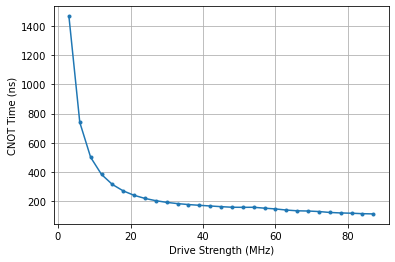

130


NameError: name 'E_list' is not defined

In [48]:
ts_d = {}
phi0_d = {}
phi1_d = {}
E_list_d = {}
t_list_d = {}
for wthz in [4.57]:
    w = [wc,wthz*2*np.pi]
    pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)
    ts,phi0,phi1,_,_ = pr.calibrate_cnot_t(0,1,args)
    ind = int(1e3*(wc/(2*np.pi) - wthz + 0.0001))
    print(ind)
    ts_d[ind] = ts 
    phi0_d[ind] = phi0
    phi1_d[ind] = phi1 
    E_list_d[ind] = E_list
    t_list_d[ind] = t_list


130


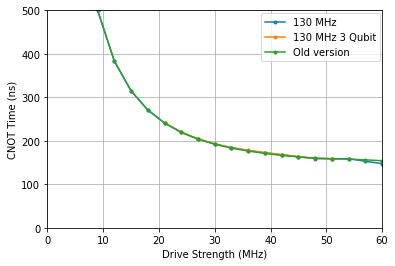

In [84]:
for i in ts_d:
    print(i)
    plt.plot(E_list,ts_d[i],'.-',label = '{} MHz'.format(i))
    plt.plot(E_list_d_3[i],ts_d_3[i],'.-',label = '{} MHz 3 Qubit'.format(i))
    
plt.plot([i for i in times],[times[i] for i in times],'.-', label = 'Old version')
# plt.plot(np.arange(3,90,3),ts,'.-', label = 'without class')
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.xlim(0,60)
plt.ylim(0,500)
plt.grid()
plt.xlabel("Drive Strength (MHz)")
plt.ylabel("CNOT Time (ns)")
plt.show()


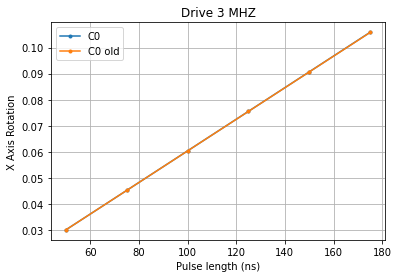

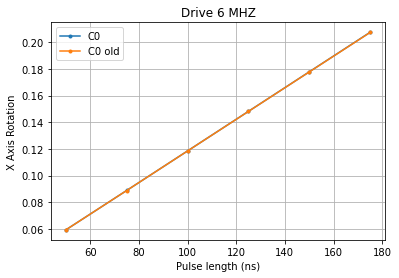

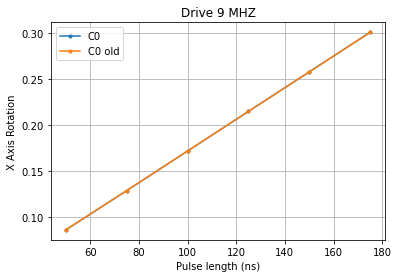

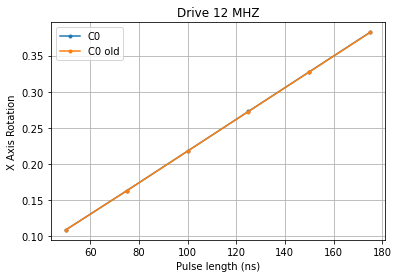

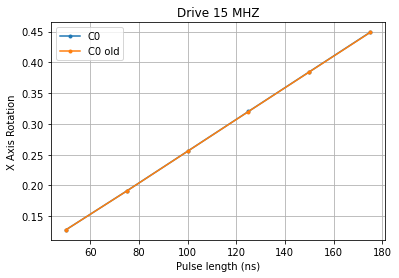

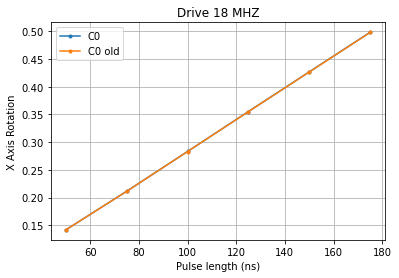

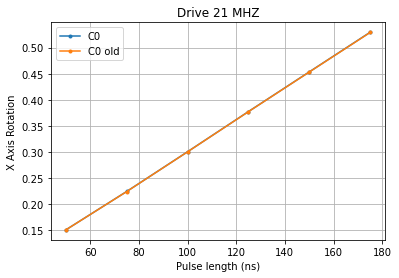

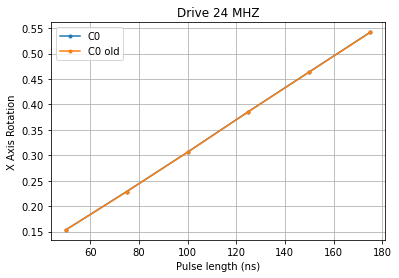

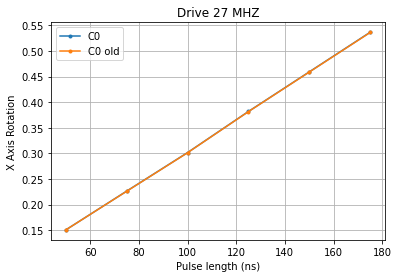

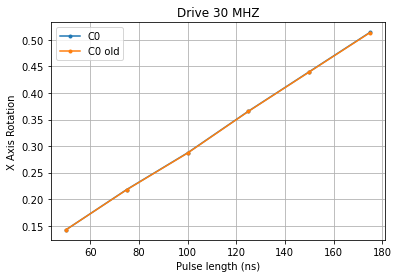

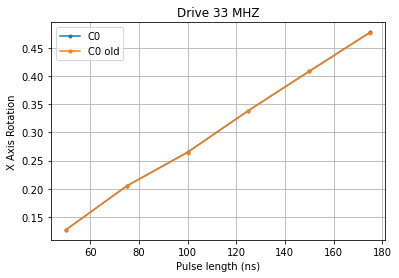

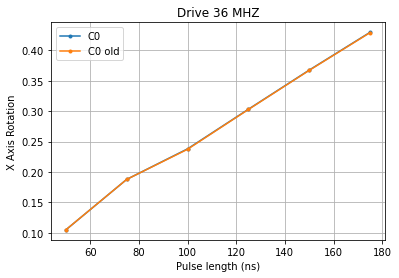

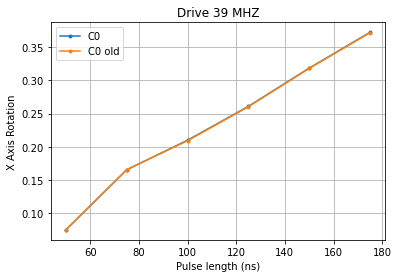

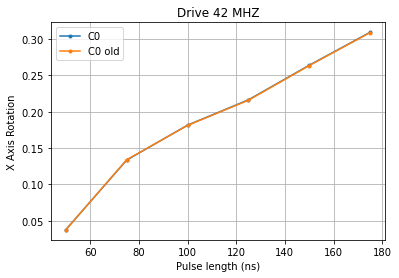

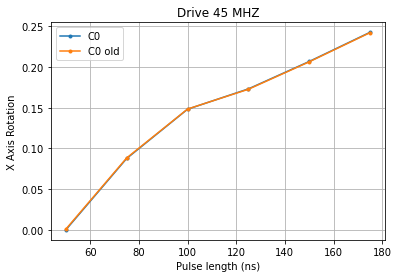

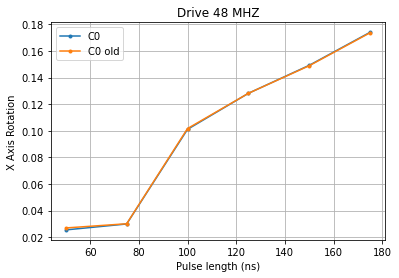

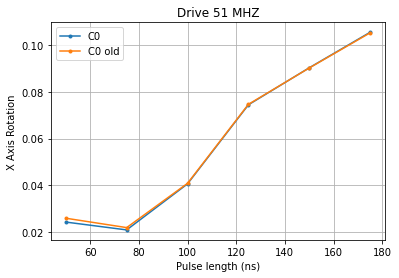

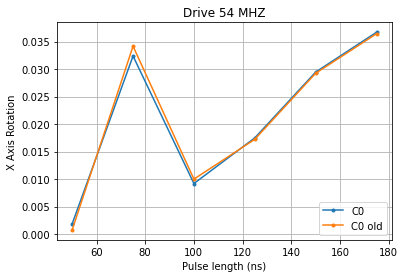

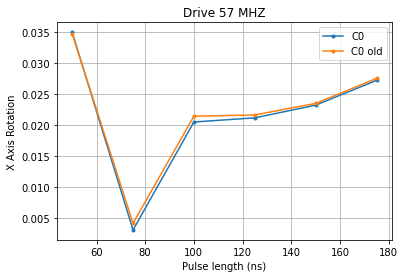

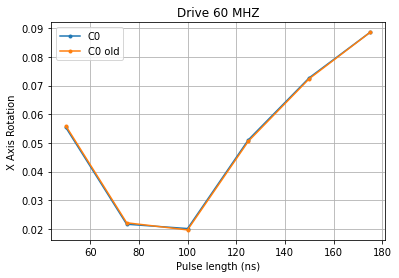

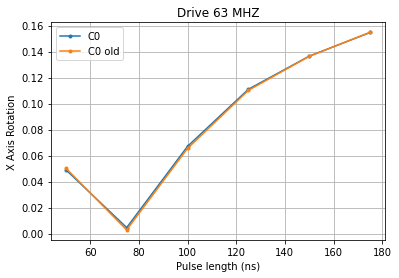

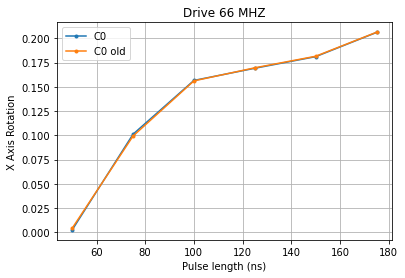

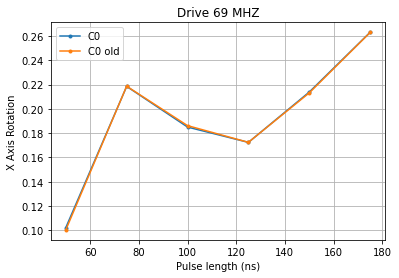

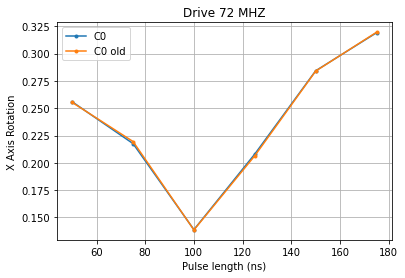

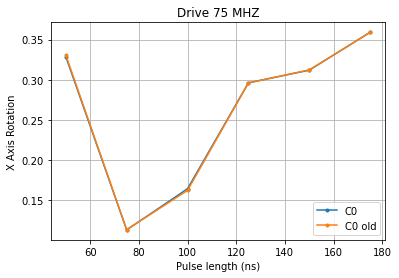

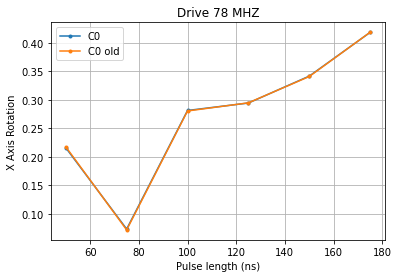

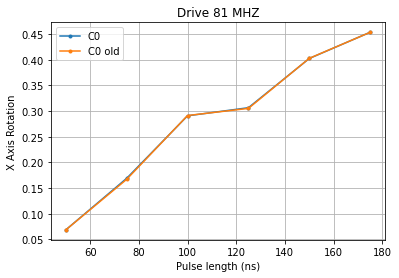

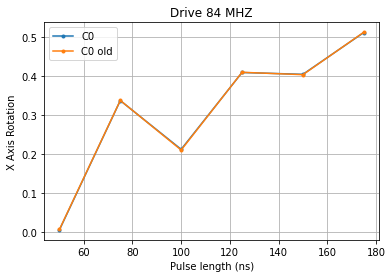

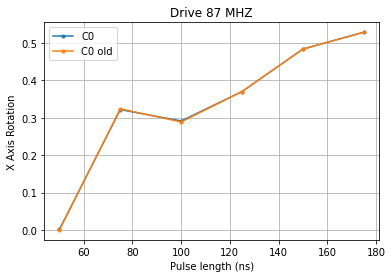

In [52]:
for i in phi0_d[130]:
    plt.plot(t_list,phi0_d[130][i],'.-', label = "C0")
#     plt.plot(t_list,phi1_d[130][i],'.-', label = "C1")
    plt.plot(t_list,np.abs(phi0t[i]),'.-', label = "C0 old")
#     plt.plot(t_list,np.abs(phi1t[i]),'.-', label = "C1 old")
#     plt.plot(t_list,phi0_d[130][i]+phi0t[i],'.-',label = "C0")
#     plt.plot(t_list,phi1_d[130][i]+phi1t[i],'.-',label = "C1")

#     plt.ylim(-0.05,0.05)
    plt.title("Drive {} MHZ".format(i))
    plt.legend()
    plt.xlabel("Pulse length (ns)")
    plt.ylabel("X Axis Rotation")
    plt.grid()
    plt.show()

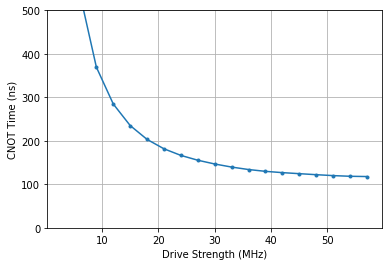

In [103]:
ts = []
for i in phi0:
    m0,b0 = np.polyfit(t_list,phi0[i],1)
    m1,b1 = np.polyfit(t_list,phi1[i],1)
    tcnot = np.roots([-m1-m0,-b1-b0+np.pi])
    if len(tcnot)==0:
        continue
    ts.append(tcnot[0])
#         print(ts)
#     print(ts)
plt.plot(E_list,ts,'.-')
plt.ylim(0,500)
plt.grid()
plt.xlabel("Drive Strength (MHz)")
plt.ylabel("CNOT Time (ns)")
plt.show()
        

### Testing Fidelity

In [28]:
F_class = {}
F_class_dressed = {}
for wthz in [4.63,4.59,4.51]:
    w = [wc,wthz*2*np.pi]
    pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)
    F_list = pr.E_vs_F(0,1,args)
    F_list_dressed = pr.E_vs_F(0,1,args,dressed_frequency=True)
    ind = int(1e3*(wc/(2*np.pi) - wthz + 0.0001))
    F_class[ind] = F_list
    F_class_dressed[ind] = F_list_dressed

  0%|                                                    | 0/29 [00:00<?, ?it/s]

Inside
Solving the whole unitary


  3%|█▌                                          | 1/29 [00:03<01:41,  3.61s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.974716424686625
Matrix from brute force: 
[[0.82 0.57 0.   0.  ]
 [0.57 0.82 0.   0.  ]
 [0.   0.   0.56 0.83]
 [0.   0.   0.83 0.56]]
[[  42.86  132.86    0.      0.  ]
 [ 132.86   42.86    0.      0.  ]
 [   0.      0.   -124.31  -34.31]
 [   0.      0.    -34.31 -124.31]]
Diagonal element: M[0][0]
Distance without sign change:  0.19147460520219428
Angle Difference without sign change:  -0.2330190972455279
Distance with sign change:  1.6348159871944452
Angle Difference without sign change:  2.9085735563442654
Off Diagonal element: M[0][1]
Distance without sign change:  0.010541054652216202
Angle Difference without sign change:  5.1961522401070023e-11
Distance with sign change:  1.1360471159841867
Angle Difference without sign change:  -0.6018314911197408
Diagonal element: M[2][2]
Distance without sign change:  0.1637598197322285
Angle Difference without sign change:  0.2901646832734727
Distance with sign change:  1.1

  7%|███                                         | 2/29 [00:05<01:16,  2.83s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9936813427168132
Matrix from brute force: 
[[0.83 0.57 0.   0.  ]
 [0.57 0.83 0.   0.  ]
 [0.   0.   0.56 0.83]
 [0.   0.   0.83 0.56]]
[[  67.72  157.72    0.      0.  ]
 [ 157.72   67.72    0.      0.  ]
 [   0.      0.   -134.07  -44.07]
 [   0.      0.    -44.07 -134.07]]
Diagonal element: M[0][0]
Distance without sign change:  0.09467867729873222
Angle Difference without sign change:  -0.114684022087611
Distance with sign change:  1.6490376778818376
Angle Difference without sign change:  3.0269086315021823
Off Diagonal element: M[0][1]
Distance without sign change:  0.0025346830482446143
Angle Difference without sign change:  8.265365009954874e-10
Distance with sign change:  1.1276986563335631
Angle Difference without sign change:  -0.5984805244272392
Diagonal element: M[2][2]
Distance without sign change:  0.08276138194336793
Angle Difference without sign change:  0.14675919577367127
Distance with sign change:  1

 10%|████▌                                       | 3/29 [00:07<01:01,  2.36s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9972434345701262
Matrix from brute force: 
[[0.83 0.56 0.   0.  ]
 [0.56 0.83 0.   0.  ]
 [0.   0.   0.56 0.83]
 [0.   0.   0.83 0.56]]
[[  97.07 -172.93    0.      0.  ]
 [-172.93   97.07    0.      0.  ]
 [   0.      0.   -125.37  -35.37]
 [   0.      0.    -35.37 -125.37]]
Diagonal element: M[0][0]
Distance without sign change:  0.061583242186124605
Angle Difference without sign change:  -0.07435180883321442
Distance with sign change:  1.6556606188022174
Angle Difference without sign change:  3.067240844756579
Off Diagonal element: M[0][1]
Distance without sign change:  0.0010636007593119094
Angle Difference without sign change:  -2.63044677539053e-07
Distance with sign change:  1.1202648650503126
Angle Difference without sign change:  -0.5943066038893338
Diagonal element: M[2][2]
Distance without sign change:  0.055688370940306695
Angle Difference without sign change:  0.0992776054909974
Distance with sign change: 

 14%|██████                                      | 4/29 [00:09<00:51,  2.07s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9984924582288939
Matrix from brute force: 
[[0.83 0.56 0.   0.  ]
 [0.56 0.83 0.   0.  ]
 [0.   0.   0.56 0.83]
 [0.   0.   0.83 0.56]]
[[ 127.98 -142.02    0.      0.  ]
 [-142.02  127.98    0.      0.  ]
 [   0.      0.    161.82 -108.18]
 [   0.      0.   -108.18  161.82]]
Diagonal element: M[0][0]
Distance without sign change:  0.044512857685448194
Angle Difference without sign change:  -0.053524879326891046
Distance with sign change:  1.6628051325444777
Angle Difference without sign change:  3.0880677742629024
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005509704248624495
Angle Difference without sign change:  -1.4516269358991898e-06
Distance with sign change:  1.1104473323520794
Angle Difference without sign change:  -0.5885053017392687
Diagonal element: M[2][2]
Distance without sign change:  0.042241933164418294
Angle Difference without sign change:  0.0758541405875027
Distance with sign chan

 17%|███████▌                                    | 5/29 [00:10<00:45,  1.88s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9990674238897628
Matrix from brute force: 
[[0.84 0.55 0.   0.  ]
 [0.55 0.84 0.   0.  ]
 [0.   0.   0.55 0.83]
 [0.   0.   0.83 0.55]]
[[ 159.87 -110.13    0.      0.  ]
 [-110.13  159.87    0.      0.  ]
 [   0.      0.    -85.4     4.6 ]
 [   0.      0.      4.6   -85.4 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.033854998170179056
Angle Difference without sign change:  -0.04050682009093858
Distance with sign change:  1.6713113503612231
Angle Difference without sign change:  3.1010858334988547
Off Diagonal element: M[0][1]
Distance without sign change:  0.0003164185445805026
Angle Difference without sign change:  -2.3690575860009804e-06
Distance with sign change:  1.0979797862592382
Angle Difference without sign change:  -0.581080774188848
Diagonal element: M[2][2]
Distance without sign change:  0.03425403081112736
Angle Difference without sign change:  0.062050261067638404
Distance with sign chang

 21%|█████████                                   | 6/29 [00:12<00:39,  1.73s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.999383499688714
Matrix from brute force: 
[[0.84 0.54 0.   0.  ]
 [0.54 0.84 0.   0.  ]
 [0.   0.   0.55 0.84]
 [0.   0.   0.84 0.55]]
[[-167.4   -77.4     0.      0.  ]
 [ -77.4  -167.4     0.      0.  ]
 [   0.      0.    -61.55   28.45]
 [   0.      0.     28.45  -61.55]]
Diagonal element: M[0][0]
Distance without sign change:  0.026411725355439175
Angle Difference without sign change:  -0.03142389594819851
Distance with sign change:  1.6808402055420797
Angle Difference without sign change:  3.1101687576415946
Off Diagonal element: M[0][1]
Distance without sign change:  0.00018937750812314538
Angle Difference without sign change:  -6.887742489619449e-07
Distance with sign change:  1.0835477544990673
Angle Difference without sign change:  -0.5724997984330419
Diagonal element: M[2][2]
Distance without sign change:  0.029000831367305656
Angle Difference without sign change:  0.05311438739490009
Distance with sign chang

 24%|██████████▌                                 | 7/29 [00:13<00:36,  1.64s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9995526504070429
Matrix from brute force: 
[[0.85 0.53 0.   0.  ]
 [0.53 0.85 0.   0.  ]
 [0.   0.   0.54 0.84]
 [0.   0.   0.84 0.54]]
[[-133.73  -43.73    0.      0.  ]
 [ -43.73 -133.73    0.      0.  ]
 [   0.      0.     62.03  152.03]
 [   0.      0.    152.03   62.03]]
Diagonal element: M[0][0]
Distance without sign change:  0.0208122721320299
Angle Difference without sign change:  -0.02461843417684599
Distance with sign change:  1.6906943290254723
Angle Difference without sign change:  3.1169742194129473
Off Diagonal element: M[0][1]
Distance without sign change:  0.00012170053759151406
Angle Difference without sign change:  8.53815933354698e-06
Distance with sign change:  1.0682111704156934
Angle Difference without sign change:  -0.5634161118381157
Diagonal element: M[2][2]
Distance without sign change:  0.025318502532657872
Angle Difference without sign change:  0.04705548163107599
Distance with sign change: 

 28%|████████████▏                               | 8/29 [00:15<00:32,  1.56s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9996593240697074
Matrix from brute force: 
[[0.85 0.53 0.   0.  ]
 [0.53 0.85 0.   0.  ]
 [0.   0.   0.53 0.85]
 [0.   0.   0.85 0.53]]
[[-99.17  -9.17   0.     0.  ]
 [ -9.17 -99.17   0.     0.  ]
 [  0.     0.    22.96 112.96]
 [  0.     0.   112.96  22.96]]
Diagonal element: M[0][0]
Distance without sign change:  0.016330743056546405
Angle Difference without sign change:  -0.019202136566559128
Distance with sign change:  1.7008751756413472
Angle Difference without sign change:  3.1223905170232342
Off Diagonal element: M[0][1]
Distance without sign change:  8.129008810951356e-05
Angle Difference without sign change:  -2.7872660402878234e-05
Distance with sign change:  1.0519890951889168
Angle Difference without sign change:  -0.553870790370043
Diagonal element: M[2][2]
Distance without sign change:  0.022585236694076537
Angle Difference without sign change:  0.04275137373116144
Distance with sign change:  1.056306189

 31%|█████████████▋                              | 9/29 [00:16<00:30,  1.55s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.99973372714314
Matrix from brute force: 
[[0.86 0.52 0.   0.  ]
 [0.52 0.86 0.   0.  ]
 [0.   0.   0.52 0.86]
 [0.   0.   0.86 0.52]]
[[ -64.1    25.9     0.      0.  ]
 [  25.9   -64.1     0.      0.  ]
 [   0.      0.   -120.05  -30.05]
 [   0.      0.    -30.05 -120.05]]
Diagonal element: M[0][0]
Distance without sign change:  0.012607393208523183
Angle Difference without sign change:  -0.014728522524934697
Distance with sign change:  1.7119386410792565
Angle Difference without sign change:  3.1268641310648584
Off Diagonal element: M[0][1]
Distance without sign change:  5.5209816764643975e-05
Angle Difference without sign change:  3.5328672829823795e-05
Distance with sign change:  1.033935672882556
Angle Difference without sign change:  -0.5432813114096922
Diagonal element: M[2][2]
Distance without sign change:  0.020540446862236075
Angle Difference without sign change:  0.03967488461649605
Distance with sign change

 34%|██████████████▊                            | 10/29 [00:18<00:28,  1.50s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9997927707957128
Matrix from brute force: 
[[0.86 0.51 0.   0.  ]
 [0.51 0.86 0.   0.  ]
 [0.   0.   0.51 0.86]
 [0.   0.   0.86 0.51]]
[[-29.   61.    0.    0. ]
 [ 61.  -29.    0.    0. ]
 [  0.    0.   28.5 118.5]
 [  0.    0.  118.5  28.5]]
Diagonal element: M[0][0]
Distance without sign change:  0.009335607453429576
Angle Difference without sign change:  -0.010828299674217539
Distance with sign change:  1.7242809635731327
Angle Difference without sign change:  3.1307643539155756
Off Diagonal element: M[0][1]
Distance without sign change:  3.280439564459434e-05
Angle Difference without sign change:  -1.789671905600351e-05
Distance with sign change:  1.0132577771103741
Angle Difference without sign change:  -0.5312659165313065
Diagonal element: M[2][2]
Distance without sign change:  0.018870597339866176
Angle Difference without sign change:  0.037200283202246984
Distance with sign change:  1.0143335337272366
Angle D

 38%|████████████████▎                          | 11/29 [00:19<00:26,  1.45s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9998207668054582
Matrix from brute force: 
[[0.87 0.5  0.   0.  ]
 [0.5  0.87 0.   0.  ]
 [0.   0.   0.5  0.87]
 [0.   0.   0.87 0.5 ]]
[[   6.03   96.03    0.      0.  ]
 [  96.03    6.03    0.      0.  ]
 [   0.      0.    125.89 -144.11]
 [   0.      0.   -144.11  125.89]]
Diagonal element: M[0][0]
Distance without sign change:  0.0064254590651934935
Angle Difference without sign change:  -0.007396716867753727
Distance with sign change:  1.7373676627803178
Angle Difference without sign change:  3.1341959367220396
Off Diagonal element: M[0][1]
Distance without sign change:  2.8408114409799444e-05
Angle Difference without sign change:  -3.508871042141505e-05
Distance with sign change:  0.9906614671595658
Angle Difference without sign change:  -0.5182175326494294
Diagonal element: M[2][2]
Distance without sign change:  0.01753840949273681
Angle Difference without sign change:  0.035322965072841224
Distance with sign ch

 41%|█████████████████▊                         | 12/29 [00:20<00:23,  1.40s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9998255738757161
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.48 0.87]
 [0.   0.   0.87 0.48]]
[[  41.17  131.17    0.      0.  ]
 [ 131.17   41.17    0.      0.  ]
 [   0.      0.   -178.84  -88.84]
 [   0.      0.    -88.84 -178.84]]
Diagonal element: M[0][0]
Distance without sign change:  0.003776590727305774
Angle Difference without sign change:  -0.004314416290002896
Distance with sign change:  1.7506190033073676
Angle Difference without sign change:  3.1372782372997903
Off Diagonal element: M[0][1]
Distance without sign change:  2.4060049921090306e-05
Angle Difference without sign change:  -2.190360708793171e-05
Distance with sign change:  0.96703936501305
Angle Difference without sign change:  -0.5046697798815681
Diagonal element: M[2][2]
Distance without sign change:  0.016462587042180246
Angle Difference without sign change:  0.03396731375680198
Distance with sign chang

 45%|███████████████████▎                       | 13/29 [00:22<00:22,  1.38s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9998145370059897
Matrix from brute force: 
[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[  76.29  166.29    0.      0.  ]
 [ 166.29   76.29    0.      0.  ]
 [   0.      0.   -156.31  -66.31]
 [   0.      0.    -66.31 -156.31]]
Diagonal element: M[0][0]
Distance without sign change:  0.0012984297747427986
Angle Difference without sign change:  -0.001471062119503427
Distance with sign change:  1.7639940284563898
Angle Difference without sign change:  3.14012159147029
Off Diagonal element: M[0][1]
Distance without sign change:  3.218492002161853e-05
Angle Difference without sign change:  -3.938492055608059e-05
Distance with sign change:  0.9423894957022364
Angle Difference without sign change:  -0.4906452900250024
Diagonal element: M[2][2]
Distance without sign change:  0.015555328623973281
Angle Difference without sign change:  0.032971906094862544
Distance with sign chan

 48%|████████████████████▊                      | 14/29 [00:23<00:21,  1.40s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9997849465397061
Matrix from brute force: 
[[0.89 0.46 0.   0.  ]
 [0.46 0.89 0.   0.  ]
 [0.   0.   0.46 0.89]
 [0.   0.   0.89 0.46]]
[[ 110.94 -159.06    0.      0.  ]
 [-159.06  110.94    0.      0.  ]
 [   0.      0.   -157.23  -67.23]
 [   0.      0.    -67.23 -157.23]]
Diagonal element: M[0][0]
Distance without sign change:  0.0010753371652851835
Angle Difference without sign change:  0.0012069229553990262
Distance with sign change:  1.7777544479525271
Angle Difference without sign change:  -3.140385730634394
Off Diagonal element: M[0][1]
Distance without sign change:  6.869417743899273e-05
Angle Difference without sign change:  -0.000126737057175152
Distance with sign change:  0.916110538594156
Angle Difference without sign change:  -0.4758208260041157
Diagonal element: M[2][2]
Distance without sign change:  0.014755894621006523
Angle Difference without sign change:  0.03217677914013341
Distance with sign chang

 52%|██████████████████████▏                    | 15/29 [00:24<00:19,  1.42s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9997103921216152
Matrix from brute force: 
[[0.9  0.44 0.   0.  ]
 [0.44 0.9  0.   0.  ]
 [0.   0.   0.45 0.89]
 [0.   0.   0.89 0.45]]
[[ 144.37 -125.63    0.      0.  ]
 [-125.63  144.37    0.      0.  ]
 [   0.      0.   -172.26  -82.26]
 [   0.      0.    -82.26 -172.26]]
Diagonal element: M[0][0]
Distance without sign change:  0.0033575651539003467
Angle Difference without sign change:  0.0037443689910567337
Distance with sign change:  1.7922847165148652
Angle Difference without sign change:  -3.1378482845987365
Off Diagonal element: M[0][1]
Distance without sign change:  0.00012370183301257384
Angle Difference without sign change:  -0.0002446534885261749
Distance with sign change:  0.887229374873956
Angle Difference without sign change:  -0.45965599402676305
Diagonal element: M[2][2]
Distance without sign change:  0.014052963712732682
Angle Difference without sign change:  0.0314855030201667
Distance with sign ch

 55%|███████████████████████▋                   | 16/29 [00:26<00:18,  1.44s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9995541460043947
Matrix from brute force: 
[[0.9  0.43 0.   0.  ]
 [0.43 0.9  0.   0.  ]
 [0.   0.   0.43 0.9 ]
 [0.   0.   0.9  0.43]]
[[ 178.21  -91.79    0.      0.  ]
 [ -91.79  178.21    0.      0.  ]
 [   0.      0.    147.25 -122.75]
 [   0.      0.   -122.75  147.25]]
Diagonal element: M[0][0]
Distance without sign change:  0.005521626728564728
Angle Difference without sign change:  0.006110734622655286
Distance with sign change:  1.8060011422132205
Angle Difference without sign change:  -3.135481918967138
Off Diagonal element: M[0][1]
Distance without sign change:  0.00010410397560692365
Angle Difference without sign change:  -3.513545858248093e-05
Distance with sign change:  0.8587380956246614
Angle Difference without sign change:  -0.4437645073300955
Diagonal element: M[2][2]
Distance without sign change:  0.013594319143902722
Angle Difference without sign change:  0.031503717372937515
Distance with sign cha

 59%|█████████████████████████▏                 | 17/29 [00:27<00:16,  1.42s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.999453048145039
Matrix from brute force: 
[[0.91 0.42 0.   0.  ]
 [0.42 0.91 0.   0.  ]
 [0.   0.   0.41 0.91]
 [0.   0.   0.91 0.41]]
[[-147.29  -57.29    0.      0.  ]
 [ -57.29 -147.29    0.      0.  ]
 [   0.      0.     82.37  172.37]
 [   0.      0.    172.37   82.37]]
Diagonal element: M[0][0]
Distance without sign change:  0.007584135021845538
Angle Difference without sign change:  0.008336272594621563
Distance with sign change:  1.8185689019434252
Angle Difference without sign change:  -3.1332563809951717
Off Diagonal element: M[0][1]
Distance without sign change:  0.0002841068687025738
Angle Difference without sign change:  0.0006072872098780418
Distance with sign change:  0.8316440651890766
Angle Difference without sign change:  -0.42869466686342356
Diagonal element: M[2][2]
Distance without sign change:  0.013384874427127786
Angle Difference without sign change:  0.03238249189373275
Distance with sign chang

 62%|██████████████████████████▋                | 18/29 [00:29<00:15,  1.37s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9994352972500172
Matrix from brute force: 
[[0.92 0.4  0.   0.  ]
 [0.4  0.92 0.   0.  ]
 [0.   0.   0.4  0.92]
 [0.   0.   0.92 0.4 ]]
[[-115.04  -25.04    0.      0.  ]
 [ -25.04 -115.04    0.      0.  ]
 [   0.      0.     16.08  106.08]
 [   0.      0.    106.08   16.08]]
Diagonal element: M[0][0]
Distance without sign change:  0.009869838965343505
Angle Difference without sign change:  0.010771288600238625
Distance with sign change:  1.831951875324846
Angle Difference without sign change:  -3.1308213649895547
Off Diagonal element: M[0][1]
Distance without sign change:  0.00013829485201014987
Angle Difference without sign change:  -7.625181212615067e-05
Distance with sign change:  0.8016703326375848
Angle Difference without sign change:  -0.4123905590703667
Diagonal element: M[2][2]
Distance without sign change:  0.012667270503108898
Angle Difference without sign change:  0.03189384732238761
Distance with sign chan

 66%|████████████████████████████▏              | 19/29 [00:30<00:13,  1.35s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9990981162664568
Matrix from brute force: 
[[0.92 0.38 0.   0.  ]
 [0.38 0.92 0.   0.  ]
 [0.   0.   0.38 0.92]
 [0.   0.   0.92 0.38]]
[[-85.24   4.76   0.     0.  ]
 [  4.76 -85.24   0.     0.  ]
 [  0.     0.   -50.75  39.25]
 [  0.     0.    39.25 -50.75]]
Diagonal element: M[0][0]
Distance without sign change:  0.012179488074331618
Angle Difference without sign change:  0.013183699862123564
Distance with sign change:  1.8463630376751126
Angle Difference without sign change:  -3.1284089537276696
Off Diagonal element: M[0][1]
Distance without sign change:  0.0004547828985365299
Angle Difference without sign change:  -0.0010441578540589921
Distance with sign change:  0.7673317803649855
Angle Difference without sign change:  -0.3938340350496238
Diagonal element: M[2][2]
Distance without sign change:  0.01192501609847804
Angle Difference without sign change:  0.031069572544099668
Distance with sign change:  0.767569486

 69%|█████████████████████████████▋             | 20/29 [00:31<00:12,  1.34s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9986795859857248
Matrix from brute force: 
[[0.93 0.37 0.   0.  ]
 [0.37 0.93 0.   0.  ]
 [0.   0.   0.37 0.93]
 [0.   0.   0.93 0.37]]
[[ -57.52   32.48    0.      0.  ]
 [  32.48  -57.52    0.      0.  ]
 [   0.      0.   -120.74  -30.74]
 [   0.      0.    -30.74 -120.74]]
Diagonal element: M[0][0]
Distance without sign change:  0.014030808289203464
Angle Difference without sign change:  0.015064210020220499
Distance with sign change:  1.8606674391116835
Angle Difference without sign change:  -3.1265284435695726
Off Diagonal element: M[0][1]
Distance without sign change:  0.0004114113946256192
Angle Difference without sign change:  0.000749228892455587
Distance with sign change:  0.731295652261193
Angle Difference without sign change:  -0.37410777662934636
Diagonal element: M[2][2]
Distance without sign change:  0.01227771556504184
Angle Difference without sign change:  0.033040705455834686
Distance with sign change

 72%|███████████████████████████████▏           | 21/29 [00:33<00:10,  1.36s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9987316090228422
Matrix from brute force: 
[[0.94 0.35 0.   0.  ]
 [0.35 0.94 0.   0.  ]
 [0.   0.   0.35 0.93]
 [0.   0.   0.93 0.35]]
[[ -29.53   60.47    0.      0.  ]
 [  60.47  -29.53    0.      0.  ]
 [   0.      0.    150.37 -119.63]
 [   0.      0.   -119.63  150.37]]
Diagonal element: M[0][0]
Distance without sign change:  0.01611613793882333
Angle Difference without sign change:  0.01719596067792897
Distance with sign change:  1.872898719309091
Angle Difference without sign change:  -3.1243966929118643
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005057136718497152
Angle Difference without sign change:  0.001187846203032293
Distance with sign change:  0.699428775689995
Angle Difference without sign change:  -0.3570046481842536
Diagonal element: M[2][2]
Distance without sign change:  0.012094983322111789
Angle Difference without sign change:  0.03408266399256914
Distance with sign change:  0

 76%|████████████████████████████████▌          | 22/29 [00:34<00:09,  1.35s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9981362633264971
Matrix from brute force: 
[[0.94 0.33 0.   0.  ]
 [0.33 0.94 0.   0.  ]
 [0.   0.   0.33 0.94]
 [0.   0.   0.94 0.33]]
[[  2.72  92.72   0.     0.  ]
 [ 92.72   2.72   0.     0.  ]
 [  0.     0.    17.74 107.74]
 [  0.     0.   107.74  17.74]]
Diagonal element: M[0][0]
Distance without sign change:  0.0188899655669273
Angle Difference without sign change:  0.02002339673832251
Distance with sign change:  1.8842171584532017
Angle Difference without sign change:  -3.121569256851471
Off Diagonal element: M[0][1]
Distance without sign change:  0.0007624963959525964
Angle Difference without sign change:  -0.0019339812520993965
Distance with sign change:  0.6671998306769072
Angle Difference without sign change:  -0.34016683169867473
Diagonal element: M[2][2]
Distance without sign change:  0.010798715696157792
Angle Difference without sign change:  0.03262211373324091
Distance with sign change:  0.661897913768

 79%|██████████████████████████████████         | 23/29 [00:35<00:08,  1.36s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9981271994195489
Matrix from brute force: 
[[0.95 0.32 0.   0.  ]
 [0.32 0.95 0.   0.  ]
 [0.   0.   0.31 0.95]
 [0.   0.   0.95 0.31]]
[[  30.79  120.79    0.      0.  ]
 [ 120.79   30.79    0.      0.  ]
 [   0.      0.   -102.92  -12.92]
 [   0.      0.    -12.92 -102.92]]
Diagonal element: M[0][0]
Distance without sign change:  0.020609762671824065
Angle Difference without sign change:  0.021725356353646832
Distance with sign change:  1.8952099682257597
Angle Difference without sign change:  -3.1198672972361465
Off Diagonal element: M[0][1]
Distance without sign change:  0.0010520585474566712
Angle Difference without sign change:  0.0030689389382837027
Distance with sign change:  0.6353347720122847
Angle Difference without sign change:  -0.32279184775844993
Diagonal element: M[2][2]
Distance without sign change:  0.012167859297244506
Angle Difference without sign change:  0.03930021430509147
Distance with sign chan

 83%|███████████████████████████████████▌       | 24/29 [00:37<00:07,  1.40s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9978369907612854
Matrix from brute force: 
[[0.95 0.3  0.   0.  ]
 [0.3  0.95 0.   0.  ]
 [0.   0.   0.3  0.96]
 [0.   0.   0.96 0.3 ]]
[[  52.41  142.41    0.      0.  ]
 [ 142.41   52.41    0.      0.  ]
 [   0.      0.    161.62 -108.38]
 [   0.      0.   -108.38  161.62]]
Diagonal element: M[0][0]
Distance without sign change:  0.023454487675342344
Angle Difference without sign change:  0.024568691937581263
Distance with sign change:  1.9069437627241772
Angle Difference without sign change:  -3.117023961652212
Off Diagonal element: M[0][1]
Distance without sign change:  0.0009881199733184258
Angle Difference without sign change:  -0.0029653560078291776
Distance with sign change:  0.5984505261298079
Angle Difference without sign change:  -0.30395805398982473
Diagonal element: M[2][2]
Distance without sign change:  0.01005011258599183
Angle Difference without sign change:  0.03395084173139056
Distance with sign chang

 86%|█████████████████████████████████████      | 25/29 [00:38<00:05,  1.37s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9968137515950153
Matrix from brute force: 
[[0.96 0.28 0.   0.  ]
 [0.28 0.96 0.   0.  ]
 [0.   0.   0.29 0.96]
 [0.   0.   0.96 0.29]]
[[ 72.41 162.41   0.     0.  ]
 [162.41  72.41   0.     0.  ]
 [  0.     0.    60.65 150.65]
 [  0.     0.   150.65  60.65]]
Diagonal element: M[0][0]
Distance without sign change:  0.025604764444737693
Angle Difference without sign change:  0.02662065073506927
Distance with sign change:  1.9193485842469786
Angle Difference without sign change:  -3.114972002854724
Off Diagonal element: M[0][1]
Distance without sign change:  0.0007082507677645628
Angle Difference without sign change:  -0.0014088763291957894
Distance with sign change:  0.5552343204986668
Angle Difference without sign change:  -0.2811611488783903
Diagonal element: M[2][2]
Distance without sign change:  0.010430094148794393
Angle Difference without sign change:  0.036562393628941585
Distance with sign change:  0.5701641995

 90%|██████████████████████████████████████▌    | 26/29 [00:39<00:04,  1.35s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.997050140206121
Matrix from brute force: 
[[0.97 0.26 0.   0.  ]
 [0.26 0.97 0.   0.  ]
 [0.   0.   0.27 0.96]
 [0.   0.   0.96 0.27]]
[[  90.48 -179.52    0.      0.  ]
 [-179.52   90.48    0.      0.  ]
 [   0.      0.    -43.77   46.23]
 [   0.      0.     46.23  -43.77]]
Diagonal element: M[0][0]
Distance without sign change:  0.02729202762890406
Angle Difference without sign change:  0.028248005493233034
Distance with sign change:  1.9290866816205485
Angle Difference without sign change:  -3.11334464809656
Off Diagonal element: M[0][1]
Distance without sign change:  0.0015947111319684053
Angle Difference without sign change:  0.005788859516131745
Distance with sign change:  0.5209342620775161
Angle Difference without sign change:  -0.26287900241143947
Diagonal element: M[2][2]
Distance without sign change:  0.012076346196216406
Angle Difference without sign change:  0.04469053755208702
Distance with sign change:  

 93%|████████████████████████████████████████   | 27/29 [00:41<00:02,  1.34s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9960572851107333
Matrix from brute force: 
[[0.97 0.24 0.   0.  ]
 [0.24 0.97 0.   0.  ]
 [0.   0.   0.25 0.97]
 [0.   0.   0.97 0.25]]
[[ 115.81 -154.19    0.      0.  ]
 [-154.19  115.81    0.      0.  ]
 [   0.      0.    150.28 -119.72]
 [   0.      0.   -119.72  150.28]]
Diagonal element: M[0][0]
Distance without sign change:  0.030878570358417342
Angle Difference without sign change:  0.03178868018139773
Distance with sign change:  1.9379867095669578
Angle Difference without sign change:  -3.1098039734083955
Off Diagonal element: M[0][1]
Distance without sign change:  0.0017414286334309153
Angle Difference without sign change:  -0.006686925178491395
Distance with sign change:  0.4841537116345695
Angle Difference without sign change:  -0.24460139259860342
Diagonal element: M[2][2]
Distance without sign change:  0.008833897242861462
Angle Difference without sign change:  0.03605107878837115
Distance with sign chang

 97%|█████████████████████████████████████████▌ | 28/29 [00:42<00:01,  1.34s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9967654875904114
Matrix from brute force: 
[[0.97 0.23 0.   0.  ]
 [0.23 0.97 0.   0.  ]
 [0.   0.   0.21 0.98]
 [0.   0.   0.98 0.21]]
[[ 140.46 -129.54    0.      0.  ]
 [-129.54  140.46    0.      0.  ]
 [   0.      0.    -27.02   62.98]
 [   0.      0.     62.98  -27.02]]
Diagonal element: M[0][0]
Distance without sign change:  0.0329318939054076
Angle Difference without sign change:  0.03381384890950496
Distance with sign change:  1.9451239920010155
Angle Difference without sign change:  -3.1077788046802883
Off Diagonal element: M[0][1]
Distance without sign change:  0.0010613778889587689
Angle Difference without sign change:  0.004060034798692505
Distance with sign change:  0.45652076717408496
Angle Difference without sign change:  -0.22984022589419506
Diagonal element: M[2][2]
Distance without sign change:  0.011099119815469466
Angle Difference without sign change:  0.0520051580419547
Distance with sign change: 

100%|███████████████████████████████████████████| 29/29 [00:43<00:00,  1.51s/it]


Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9953479676133743
Matrix from brute force: 
[[0.98 0.21 0.   0.  ]
 [0.21 0.98 0.   0.  ]
 [0.   0.   0.2  0.98]
 [0.   0.   0.98 0.2 ]]
[[ 153.04 -116.96    0.      0.  ]
 [-116.96  153.04    0.      0.  ]
 [   0.      0.   -143.85  -53.85]
 [   0.      0.    -53.85 -143.85]]
Diagonal element: M[0][0]
Distance without sign change:  0.036278318106145256
Angle Difference without sign change:  0.0370401237684369
Distance with sign change:  1.953920818869937
Angle Difference without sign change:  -3.1045525298213565
Off Diagonal element: M[0][1]
Distance without sign change:  0.0024599680045130166
Angle Difference without sign change:  -0.011492767938045944
Distance with sign change:  0.41290955620821307
Angle Difference without sign change:  -0.2081265189663203
Diagonal element: M[2][2]
Distance without sign change:  0.0077322482817706725
Angle Difference without sign change:  0.03812567420877151
Distance with sign change

  0%|                                                    | 0/29 [00:00<?, ?it/s]

Inside
Solving the whole unitary


  3%|█▌                                          | 1/29 [00:03<01:27,  3.11s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9586876065775215
Matrix from brute force: 
[[0.83 0.57 0.   0.  ]
 [0.57 0.83 0.   0.  ]
 [0.   0.   0.52 0.85]
 [0.   0.   0.85 0.52]]
[[  30.61  120.61    0.      0.  ]
 [ 120.61   30.61    0.      0.  ]
 [   0.      0.   -160.97  -70.97]
 [   0.      0.    -70.97 -160.97]]
Diagonal element: M[0][0]
Distance without sign change:  0.0018486486325229243
Angle Difference without sign change:  0.002240665575797874
Distance with sign change:  1.6500880459598888
Angle Difference without sign change:  -3.1393519880139955
Off Diagonal element: M[0][1]
Distance without sign change:  9.655763468564239e-07
Angle Difference without sign change:  6.379463669289596e-11
Distance with sign change:  1.1301354002747397
Angle Difference without sign change:  -0.6005150961197443
Diagonal element: M[2][2]
Distance without sign change:  0.3203871244093308
Angle Difference without sign change:  0.575196513798836
Distance with sign change: 

  7%|███                                         | 2/29 [00:05<01:10,  2.62s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9890460085559912
Matrix from brute force: 
[[0.83 0.56 0.   0.  ]
 [0.56 0.83 0.   0.  ]
 [0.   0.   0.55 0.83]
 [0.   0.   0.83 0.55]]
[[  61.47  151.47    0.      0.  ]
 [ 151.47   61.47    0.      0.  ]
 [   0.      0.   -152.61  -62.61]
 [   0.      0.    -62.61 -152.61]]
Diagonal element: M[0][0]
Distance without sign change:  0.003690974585383961
Angle Difference without sign change:  0.004466555541828048
Distance with sign change:  1.6527131428588895
Angle Difference without sign change:  -3.137126098047965
Off Diagonal element: M[0][1]
Distance without sign change:  3.836243647212766e-06
Angle Difference without sign change:  1.22045940965494e-09
Distance with sign change:  1.1262884365361554
Angle Difference without sign change:  -0.5981849472052547
Diagonal element: M[2][2]
Distance without sign change:  0.16533249483001103
Angle Difference without sign change:  0.29407905767511283
Distance with sign change: 

 10%|████▌                                       | 3/29 [00:07<00:59,  2.31s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9949479667968092
Matrix from brute force: 
[[0.83 0.56 0.   0.  ]
 [0.56 0.83 0.   0.  ]
 [0.   0.   0.56 0.83]
 [0.   0.   0.83 0.56]]
[[  92.78 -177.22    0.      0.  ]
 [-177.22   92.78    0.      0.  ]
 [   0.      0.   -137.95  -47.95]
 [   0.      0.    -47.95 -137.95]]
Diagonal element: M[0][0]
Distance without sign change:  0.005520434656987265
Angle Difference without sign change:  0.006662439419998039
Distance with sign change:  1.6571742205729025
Angle Difference without sign change:  -3.134930214169795
Off Diagonal element: M[0][1]
Distance without sign change:  8.651528723055266e-06
Angle Difference without sign change:  -2.7452642001553484e-07
Distance with sign change:  1.119706309014219
Angle Difference without sign change:  -0.5942067048243446
Diagonal element: M[2][2]
Distance without sign change:  0.1122106879737808
Angle Difference without sign change:  0.20032304077479285
Distance with sign change:

 14%|██████                                      | 4/29 [00:09<00:51,  2.06s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9970292737392374
Matrix from brute force: 
[[0.83 0.56 0.   0.  ]
 [0.56 0.83 0.   0.  ]
 [0.   0.   0.55 0.83]
 [0.   0.   0.83 0.55]]
[[ 124.63 -145.37    0.      0.  ]
 [-145.37  124.63    0.      0.  ]
 [   0.      0.    152.16 -117.84]
 [   0.      0.   -117.84  152.16]]
Diagonal element: M[0][0]
Distance without sign change:  0.007330449049893442
Angle Difference without sign change:  0.00881301538032521
Distance with sign change:  1.6635386699486385
Angle Difference without sign change:  -3.132779638209468
Off Diagonal element: M[0][1]
Distance without sign change:  1.5453913013880603e-05
Angle Difference without sign change:  -1.40125061742196e-06
Distance with sign change:  1.1102168258807086
Angle Difference without sign change:  -0.58849017102233
Diagonal element: M[2][2]
Distance without sign change:  0.08582942149831693
Angle Difference without sign change:  0.15425797107530553
Distance with sign change:  

 17%|███████▌                                    | 5/29 [00:10<00:45,  1.90s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9979880740154627
Matrix from brute force: 
[[0.84 0.55 0.   0.  ]
 [0.55 0.84 0.   0.  ]
 [0.   0.   0.55 0.84]
 [0.   0.   0.84 0.55]]
[[ 157.05 -112.95    0.      0.  ]
 [-112.95  157.05    0.      0.  ]
 [   0.      0.    -93.35   -3.35]
 [   0.      0.     -3.35  -93.35]]
Diagonal element: M[0][0]
Distance without sign change:  0.009115982582513261
Angle Difference without sign change:  0.010906368683024349
Distance with sign change:  1.6716625147212067
Angle Difference without sign change:  -3.1306862849067687
Off Diagonal element: M[0][1]
Distance without sign change:  2.4492942060882017e-05
Angle Difference without sign change:  -2.562230403288208e-06
Distance with sign change:  1.097929390530666
Angle Difference without sign change:  -0.5811200627017526
Diagonal element: M[2][2]
Distance without sign change:  0.07023857886892582
Angle Difference without sign change:  0.1273171916973925
Distance with sign change

 21%|█████████                                   | 6/29 [00:12<00:40,  1.78s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9985083853071439
Matrix from brute force: 
[[0.84 0.54 0.   0.  ]
 [0.54 0.84 0.   0.  ]
 [0.   0.   0.54 0.84]
 [0.   0.   0.84 0.54]]
[[-169.87  -79.87    0.      0.  ]
 [ -79.87 -169.87    0.      0.  ]
 [   0.      0.    -68.39   21.61]
 [   0.      0.     21.61  -68.39]]
Diagonal element: M[0][0]
Distance without sign change:  0.010880716321634294
Angle Difference without sign change:  0.012945587187459218
Distance with sign change:  1.6809660050743516
Angle Difference without sign change:  -3.128647066402334
Off Diagonal element: M[0][1]
Distance without sign change:  3.246623624226481e-05
Angle Difference without sign change:  -6.300166980691815e-07
Distance with sign change:  1.083619754491791
Angle Difference without sign change:  -0.5725811609589675
Diagonal element: M[2][2]
Distance without sign change:  0.06005954352740452
Angle Difference without sign change:  0.11005771277997359
Distance with sign change:

 24%|██████████▌                                 | 7/29 [00:13<00:36,  1.65s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9987956238363526
Matrix from brute force: 
[[0.85 0.53 0.   0.  ]
 [0.53 0.85 0.   0.  ]
 [0.   0.   0.54 0.84]
 [0.   0.   0.84 0.54]]
[[-135.98  -45.98    0.      0.  ]
 [ -45.98 -135.98    0.      0.  ]
 [   0.      0.     55.93  145.93]
 [   0.      0.    145.93   55.93]]
Diagonal element: M[0][0]
Distance without sign change:  0.012636841468981327
Angle Difference without sign change:  0.014948623717600962
Distance with sign change:  1.6906698702727163
Angle Difference without sign change:  -3.1266440298721925
Off Diagonal element: M[0][1]
Distance without sign change:  4.8780478316895115e-05
Angle Difference without sign change:  7.626811093327493e-06
Distance with sign change:  1.0683779386403471
Angle Difference without sign change:  -0.5635335522361403
Diagonal element: M[2][2]
Distance without sign change:  0.052979881446551406
Angle Difference without sign change:  0.09851505882633127
Distance with sign chan

 28%|████████████▏                               | 8/29 [00:14<00:32,  1.56s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9989732823439266
Matrix from brute force: 
[[0.85 0.53 0.   0.  ]
 [0.53 0.85 0.   0.  ]
 [0.   0.   0.53 0.85]
 [0.   0.   0.85 0.53]]
[[-101.27  -11.27    0.      0.  ]
 [ -11.27 -101.27    0.      0.  ]
 [   0.      0.     17.41  107.41]
 [   0.      0.    107.41   17.41]]
Diagonal element: M[0][0]
Distance without sign change:  0.014411497610043561
Angle Difference without sign change:  0.016946882683824868
Distance with sign change:  1.700742529283915
Angle Difference without sign change:  -3.1246457709059685
Off Diagonal element: M[0][1]
Distance without sign change:  6.592618444026848e-05
Angle Difference without sign change:  -2.8182868831312385e-05
Distance with sign change:  1.05223169218537
Angle Difference without sign change:  -0.5540176445570624
Diagonal element: M[2][2]
Distance without sign change:  0.047794793740819796
Angle Difference without sign change:  0.0905149448878314
Distance with sign change:

 31%|█████████████▋                              | 9/29 [00:16<00:29,  1.49s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9990904704100352
Matrix from brute force: 
[[0.86 0.52 0.   0.  ]
 [0.52 0.86 0.   0.  ]
 [0.   0.   0.52 0.86]
 [0.   0.   0.86 0.52]]
[[ -66.09   23.91    0.      0.  ]
 [  23.91  -66.09    0.      0.  ]
 [   0.      0.   -125.2   -35.2 ]
 [   0.      0.    -35.2  -125.2 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.016151517168378038
Angle Difference without sign change:  0.018871104083254164
Distance with sign change:  1.7117198415298904
Angle Difference without sign change:  -3.1227215495065392
Off Diagonal element: M[0][1]
Distance without sign change:  8.080817468757661e-05
Angle Difference without sign change:  3.543950541708102e-05
Distance with sign change:  1.034248437155038
Angle Difference without sign change:  -0.543456754378876
Diagonal element: M[2][2]
Distance without sign change:  0.04390679516167951
Angle Difference without sign change:  0.0848508761844555
Distance with sign change:  

 34%|██████████████▊                            | 10/29 [00:17<00:28,  1.52s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9991754927268124
Matrix from brute force: 
[[0.86 0.51 0.   0.  ]
 [0.51 0.86 0.   0.  ]
 [0.   0.   0.51 0.86]
 [0.   0.   0.86 0.51]]
[[-30.92  59.08   0.     0.  ]
 [ 59.08 -30.92   0.     0.  ]
 [  0.     0.    23.65 113.65]
 [  0.     0.   113.65  23.65]]
Diagonal element: M[0][0]
Distance without sign change:  0.017915033893177224
Angle Difference without sign change:  0.020782364003564476
Distance with sign change:  1.7239966122717825
Angle Difference without sign change:  -3.120810289586229
Off Diagonal element: M[0][1]
Distance without sign change:  9.116990177717102e-05
Angle Difference without sign change:  -1.6354326351920083e-05
Distance with sign change:  1.0136256513086201
Angle Difference without sign change:  -0.5314621698874551
Diagonal element: M[2][2]
Distance without sign change:  0.04080299733216444
Angle Difference without sign change:  0.08047802566040264
Distance with sign change:  1.0130220579

 38%|████████████████▎                          | 11/29 [00:19<00:27,  1.55s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9992181929851824
Matrix from brute force: 
[[0.87 0.5  0.   0.  ]
 [0.5  0.87 0.   0.  ]
 [0.   0.   0.5  0.87]
 [0.   0.   0.87 0.5 ]]
[[   4.17   94.17    0.      0.  ]
 [  94.17    4.17    0.      0.  ]
 [   0.      0.    121.28 -148.72]
 [   0.      0.   -148.72  121.28]]
Diagonal element: M[0][0]
Distance without sign change:  0.019663883198420266
Angle Difference without sign change:  0.022639815700836664
Distance with sign change:  1.7370297868177331
Angle Difference without sign change:  -3.1189528378889566
Off Diagonal element: M[0][1]
Distance without sign change:  0.0001093617323163531
Angle Difference without sign change:  -3.625837621133579e-05
Distance with sign change:  0.991079440878777
Angle Difference without sign change:  -0.518433401567263
Diagonal element: M[2][2]
Distance without sign change:  0.03832718571657525
Angle Difference without sign change:  0.0772338256679735
Distance with sign change: 

 41%|█████████████████▊                         | 12/29 [00:21<00:26,  1.59s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9992287404937148
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.48 0.88]
 [0.   0.   0.88 0.48]]
[[ 39.35 129.35   0.     0.  ]
 [129.35  39.35   0.     0.  ]
 [  0.     0.   176.75 -93.25]
 [  0.     0.   -93.25 176.75]]
Diagonal element: M[0][0]
Distance without sign change:  0.021425990440517344
Angle Difference without sign change:  0.02448230116872622
Distance with sign change:  1.7502359926049988
Angle Difference without sign change:  -3.117110352421067
Off Diagonal element: M[0][1]
Distance without sign change:  0.00012951545392049437
Angle Difference without sign change:  -2.5159702552940016e-05
Distance with sign change:  0.9675031312766867
Angle Difference without sign change:  -0.5049028560599823
Diagonal element: M[2][2]
Distance without sign change:  0.03632949460759072
Angle Difference without sign change:  0.07500104136919526
Distance with sign change:  0.9679338257

 45%|███████████████████▎                       | 13/29 [00:22<00:24,  1.56s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9992164682397618
Matrix from brute force: 
[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[  74.5   164.5     0.      0.  ]
 [ 164.5    74.5     0.      0.  ]
 [   0.      0.   -160.58  -70.58]
 [   0.      0.    -70.58 -160.58]]
Diagonal element: M[0][0]
Distance without sign change:  0.02322545447874388
Angle Difference without sign change:  0.026337557503597554
Distance with sign change:  1.763573162481081
Angle Difference without sign change:  -3.1152550960861958
Off Diagonal element: M[0][1]
Distance without sign change:  0.0001540653593104973
Angle Difference without sign change:  -4.3779382723207654e-05
Distance with sign change:  0.9428926059267259
Angle Difference without sign change:  -0.49089169959077184
Diagonal element: M[2][2]
Distance without sign change:  0.034665891122533724
Angle Difference without sign change:  0.07352304684584259
Distance with sign chan

 48%|████████████████████▊                      | 14/29 [00:23<00:22,  1.49s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9991802795578435
Matrix from brute force: 
[[0.89 0.46 0.   0.  ]
 [0.46 0.89 0.   0.  ]
 [0.   0.   0.46 0.89]
 [0.   0.   0.89 0.46]]
[[ 109.16 -160.84    0.      0.  ]
 [-160.84  109.16    0.      0.  ]
 [   0.      0.   -161.37  -71.37]
 [   0.      0.    -71.37 -161.37]]
Diagonal element: M[0][0]
Distance without sign change:  0.02506192567573447
Angle Difference without sign change:  0.028200344957625283
Distance with sign change:  1.7773020008570088
Angle Difference without sign change:  -3.113392308632168
Off Diagonal element: M[0][1]
Distance without sign change:  0.00018937542235012006
Angle Difference without sign change:  -0.0001295363071314143
Distance with sign change:  0.9166461591887791
Angle Difference without sign change:  -0.4760760614593335
Diagonal element: M[2][2]
Distance without sign change:  0.03323310460230663
Angle Difference without sign change:  0.07251287358273727
Distance with sign change

 52%|██████████████████████▏                    | 15/29 [00:25<00:20,  1.50s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9990956492565127
Matrix from brute force: 
[[0.9  0.44 0.   0.  ]
 [0.44 0.9  0.   0.  ]
 [0.   0.   0.45 0.9 ]
 [0.   0.   0.9  0.45]]
[[ 142.61 -127.39    0.      0.  ]
 [-127.39  142.61    0.      0.  ]
 [   0.      0.   -176.31  -86.31]
 [   0.      0.    -86.31 -176.31]]
Diagonal element: M[0][0]
Distance without sign change:  0.026899496718612755
Angle Difference without sign change:  0.030022727543856424
Distance with sign change:  1.7918055841607934
Angle Difference without sign change:  -3.1115699260459366
Off Diagonal element: M[0][1]
Distance without sign change:  0.0002414132234706866
Angle Difference without sign change:  -0.00023951529083024708
Distance with sign change:  0.8877941789296229
Angle Difference without sign change:  -0.4599169615674367
Diagonal element: M[2][2]
Distance without sign change:  0.031988767329979004
Angle Difference without sign change:  0.07171657390298136
Distance with sign cha

 55%|███████████████████████▋                   | 16/29 [00:27<00:20,  1.59s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9989258946528143
Matrix from brute force: 
[[0.9  0.43 0.   0.  ]
 [0.43 0.9  0.   0.  ]
 [0.   0.   0.43 0.9 ]
 [0.   0.   0.9  0.43]]
[[ 176.45  -93.55    0.      0.  ]
 [ -93.55  176.45    0.      0.  ]
 [   0.      0.    143.28 -126.72]
 [   0.      0.   -126.72  143.28]]
Diagonal element: M[0][0]
Distance without sign change:  0.028758163116401458
Angle Difference without sign change:  0.03185333164102873
Distance with sign change:  1.8054935855737537
Angle Difference without sign change:  -3.1097393219487643
Off Diagonal element: M[0][1]
Distance without sign change:  0.0002736651179010704
Angle Difference without sign change:  -1.8379016209262913e-05
Distance with sign change:  0.8593442820902089
Angle Difference without sign change:  -0.4440375058990377
Diagonal element: M[2][2]
Distance without sign change:  0.03107882185100915
Angle Difference without sign change:  0.07207283509239486
Distance with sign chang

 59%|█████████████████████████▏                 | 17/29 [00:28<00:19,  1.62s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.998809581342865
Matrix from brute force: 
[[0.91 0.42 0.   0.  ]
 [0.42 0.91 0.   0.  ]
 [0.   0.   0.41 0.91]
 [0.   0.   0.91 0.41]]
[[-149.06  -59.06    0.      0.  ]
 [ -59.06 -149.06    0.      0.  ]
 [   0.      0.     78.45  168.45]
 [   0.      0.    168.45   78.45]]
Diagonal element: M[0][0]
Distance without sign change:  0.0306434909487954
Angle Difference without sign change:  0.03370691542519985
Distance with sign change:  1.8180358155662102
Angle Difference without sign change:  -3.1078857381645935
Off Diagonal element: M[0][1]
Distance without sign change:  0.0004005886003378573
Angle Difference without sign change:  0.0006006470862666019
Distance with sign change:  0.8322956987683462
Angle Difference without sign change:  -0.42898827458522193
Diagonal element: M[2][2]
Distance without sign change:  0.030463697381428057
Angle Difference without sign change:  0.07375779805865104
Distance with sign change: 

 62%|██████████████████████████▋                | 18/29 [00:30<00:17,  1.58s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.998769270253537
Matrix from brute force: 
[[0.92 0.4  0.   0.  ]
 [0.4  0.92 0.   0.  ]
 [0.   0.   0.4  0.92]
 [0.   0.   0.92 0.4 ]]
[[-116.81  -26.81    0.      0.  ]
 [ -26.81 -116.81    0.      0.  ]
 [   0.      0.     12.2   102.2 ]
 [   0.      0.    102.2    12.2 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.032757247259035956
Angle Difference without sign change:  0.035768478097746886
Distance with sign change:  1.8314051931012054
Angle Difference without sign change:  -3.1058241754920464
Off Diagonal element: M[0][1]
Distance without sign change:  0.00033187162946274605
Angle Difference without sign change:  -0.00010274811804575465
Distance with sign change:  0.8023172027852886
Angle Difference without sign change:  -0.4126759540060576
Diagonal element: M[2][2]
Distance without sign change:  0.029372999244258142
Angle Difference without sign change:  0.07401172694122968
Distance with sign cha

 66%|████████████████████████████▏              | 19/29 [00:31<00:15,  1.55s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9984078567371055
Matrix from brute force: 
[[0.92 0.38 0.   0.  ]
 [0.38 0.92 0.   0.  ]
 [0.   0.   0.38 0.92]
 [0.   0.   0.92 0.38]]
[[-87.02   2.98   0.     0.  ]
 [  2.98 -87.02   0.     0.  ]
 [  0.     0.   -54.59  35.41]
 [  0.     0.    35.41 -54.59]]
Diagonal element: M[0][0]
Distance without sign change:  0.03489489238978353
Angle Difference without sign change:  0.03780343143117873
Distance with sign change:  1.8458000893388369
Angle Difference without sign change:  -3.1037892221586145
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005730304024505723
Angle Difference without sign change:  -0.0010188024175538071
Distance with sign change:  0.7679838627862283
Angle Difference without sign change:  -0.39410595064801074
Diagonal element: M[2][2]
Distance without sign change:  0.028334561210536558
Angle Difference without sign change:  0.07388404808222085
Distance with sign change:  0.7664052605

 69%|█████████████████████████████▋             | 20/29 [00:33<00:13,  1.51s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9979755383703433
Matrix from brute force: 
[[0.93 0.37 0.   0.  ]
 [0.37 0.93 0.   0.  ]
 [0.   0.   0.37 0.93]
 [0.   0.   0.93 0.37]]
[[ -59.31   30.69    0.      0.  ]
 [  30.69  -59.31    0.      0.  ]
 [   0.      0.   -124.53  -34.53]
 [   0.      0.    -34.53 -124.53]]
Diagonal element: M[0][0]
Distance without sign change:  0.03658741808978616
Angle Difference without sign change:  0.03932959658226004
Distance with sign change:  1.860086928964103
Angle Difference without sign change:  -3.102263057007533
Off Diagonal element: M[0][1]
Distance without sign change:  0.000589961046938845
Angle Difference without sign change:  0.0007887973189676219
Distance with sign change:  0.732022160835883
Angle Difference without sign change:  -0.37441104515737467
Diagonal element: M[2][2]
Distance without sign change:  0.02840048521200469
Angle Difference without sign change:  0.07650705399806294
Distance with sign change:  0.

 72%|███████████████████████████████▏           | 21/29 [00:34<00:11,  1.47s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9980033236013007
Matrix from brute force: 
[[0.94 0.35 0.   0.  ]
 [0.35 0.94 0.   0.  ]
 [0.   0.   0.35 0.94]
 [0.   0.   0.94 0.35]]
[[ -31.33   58.67    0.      0.  ]
 [  58.67  -31.33    0.      0.  ]
 [   0.      0.    146.6  -123.4 ]
 [   0.      0.   -123.4   146.6 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.03859788690228747
Angle Difference without sign change:  0.04122029205189673
Distance with sign change:  1.8723103709531659
Angle Difference without sign change:  -3.1003723615378966
Off Diagonal element: M[0][1]
Distance without sign change:  0.000637574326830882
Angle Difference without sign change:  0.0011210892873184796
Distance with sign change:  0.7001589862645743
Angle Difference without sign change:  -0.35731613630920933
Diagonal element: M[2][2]
Distance without sign change:  0.027886726891435905
Angle Difference without sign change:  0.07866167534915718
Distance with sign change:

 76%|████████████████████████████████▌          | 22/29 [00:35<00:09,  1.39s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9973644907038912
Matrix from brute force: 
[[0.94 0.33 0.   0.  ]
 [0.33 0.94 0.   0.  ]
 [0.   0.   0.33 0.94]
 [0.   0.   0.94 0.33]]
[[  0.89  90.89   0.     0.  ]
 [ 90.89   0.89   0.     0.  ]
 [  0.     0.    13.96 103.96]
 [  0.     0.   103.96  13.96]]
Diagonal element: M[0][0]
Distance without sign change:  0.041497137496195595
Angle Difference without sign change:  0.04404408867622481
Distance with sign change:  1.8836042769761532
Angle Difference without sign change:  -3.0975485649135686
Off Diagonal element: M[0][1]
Distance without sign change:  0.0008848702770375614
Angle Difference without sign change:  -0.0018561850179591578
Distance with sign change:  0.6679087948479702
Angle Difference without sign change:  -0.34044188093924105
Diagonal element: M[2][2]
Distance without sign change:  0.026440828259613188
Angle Difference without sign change:  0.07997107625739336
Distance with sign change:  0.660725687

 79%|██████████████████████████████████         | 23/29 [00:37<00:08,  1.34s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9973332343245954
Matrix from brute force: 
[[0.95 0.32 0.   0.  ]
 [0.32 0.95 0.   0.  ]
 [0.   0.   0.31 0.95]
 [0.   0.   0.95 0.31]]
[[  28.93  118.93    0.      0.  ]
 [ 118.93   28.93    0.      0.  ]
 [   0.      0.   -106.7   -16.7 ]
 [   0.      0.    -16.7  -106.7 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.04327183232741711
Angle Difference without sign change:  0.04566289319025675
Distance with sign change:  1.894581248216983
Angle Difference without sign change:  -3.0959297603995366
Off Diagonal element: M[0][1]
Distance without sign change:  0.0011446213685910376
Angle Difference without sign change:  0.003015698554136519
Distance with sign change:  0.6361474976090814
Angle Difference without sign change:  -0.32312892096730217
Diagonal element: M[2][2]
Distance without sign change:  0.027520991687133445
Angle Difference without sign change:  0.08899708680316254
Distance with sign change: 

 83%|███████████████████████████████████▌       | 24/29 [00:38<00:06,  1.31s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9970007684759614
Matrix from brute force: 
[[0.95 0.3  0.   0.  ]
 [0.3  0.95 0.   0.  ]
 [0.   0.   0.3  0.96]
 [0.   0.   0.96 0.3 ]]
[[  50.53  140.53    0.      0.  ]
 [ 140.53   50.53    0.      0.  ]
 [   0.      0.    157.86 -112.14]
 [   0.      0.   -112.14  157.86]]
Diagonal element: M[0][0]
Distance without sign change:  0.04604181824960348
Angle Difference without sign change:  0.048282238759312826
Distance with sign change:  1.906307527259862
Angle Difference without sign change:  -3.0933104148304804
Off Diagonal element: M[0][1]
Distance without sign change:  0.0011238052097843315
Angle Difference without sign change:  -0.003018855862008236
Distance with sign change:  0.5991511351678573
Angle Difference without sign change:  -0.3042305819188678
Diagonal element: M[2][2]
Distance without sign change:  0.025167510452539614
Angle Difference without sign change:  0.08512660807579567
Distance with sign change:

 86%|█████████████████████████████████████      | 25/29 [00:39<00:05,  1.28s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.99595684903018
Matrix from brute force: 
[[0.96 0.28 0.   0.  ]
 [0.28 0.96 0.   0.  ]
 [0.   0.   0.28 0.96]
 [0.   0.   0.96 0.28]]
[[ 70.51 160.51   0.     0.  ]
 [160.51  70.51   0.     0.  ]
 [  0.     0.    56.9  146.9 ]
 [  0.     0.   146.9   56.9 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.048145373742841675
Angle Difference without sign change:  0.050146687196126444
Distance with sign change:  1.9187029268427462
Angle Difference without sign change:  -3.0914459663936666
Off Diagonal element: M[0][1]
Distance without sign change:  0.0008882924736389256
Angle Difference without sign change:  -0.0012433854346158672
Distance with sign change:  0.5560222963364585
Angle Difference without sign change:  -0.2814586129736867
Diagonal element: M[2][2]
Distance without sign change:  0.025453382701057944
Angle Difference without sign change:  0.08939344011873847
Distance with sign change:  0.56896334301

 90%|██████████████████████████████████████▌    | 26/29 [00:40<00:03,  1.27s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9961690413864535
Matrix from brute force: 
[[0.97 0.26 0.   0.  ]
 [0.26 0.97 0.   0.  ]
 [0.   0.   0.27 0.96]
 [0.   0.   0.96 0.27]]
[[ 88.55 178.55   0.     0.  ]
 [178.55  88.55   0.     0.  ]
 [  0.     0.   -47.51  42.49]
 [  0.     0.    42.49 -47.51]]
Diagonal element: M[0][0]
Distance without sign change:  0.04977730996877998
Angle Difference without sign change:  0.05159117212770478
Distance with sign change:  1.9284389337064094
Angle Difference without sign change:  -3.0900014814620884
Off Diagonal element: M[0][1]
Distance without sign change:  0.0016540578143270995
Angle Difference without sign change:  0.005661269884304601
Distance with sign change:  0.521802558430771
Angle Difference without sign change:  -0.2632357398123832
Diagonal element: M[2][2]
Distance without sign change:  0.026775775454547
Angle Difference without sign change:  0.09924632394790137
Distance with sign change:  0.5389631701614546


 93%|████████████████████████████████████████   | 27/29 [00:42<00:02,  1.30s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9951140364443808
Matrix from brute force: 
[[0.97 0.24 0.   0.  ]
 [0.24 0.97 0.   0.  ]
 [0.   0.   0.24 0.97]
 [0.   0.   0.97 0.24]]
[[ 113.84 -156.16    0.      0.  ]
 [-156.16  113.84    0.      0.  ]
 [   0.      0.    146.51 -123.49]
 [   0.      0.   -123.49  146.51]]
Diagonal element: M[0][0]
Distance without sign change:  0.05358043240559608
Angle Difference without sign change:  0.05525925911318972
Distance with sign change:  1.9373057148552693
Angle Difference without sign change:  -3.0863333944766036
Off Diagonal element: M[0][1]
Distance without sign change:  0.0017985895481210754
Angle Difference without sign change:  -0.006490305939419166
Distance with sign change:  0.48489632476168343
Angle Difference without sign change:  -0.2448695284735811
Diagonal element: M[2][2]
Distance without sign change:  0.02346973578375108
Angle Difference without sign change:  0.09598687295143922
Distance with sign change:

 97%|█████████████████████████████████████████▌ | 28/29 [00:43<00:01,  1.29s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.995775831022309
Matrix from brute force: 
[[0.97 0.23 0.   0.  ]
 [0.23 0.97 0.   0.  ]
 [0.   0.   0.21 0.98]
 [0.   0.   0.98 0.21]]
[[ 138.44 -131.56    0.      0.  ]
 [-131.56  138.44    0.      0.  ]
 [   0.      0.    -30.83   59.17]
 [   0.      0.     59.17  -30.83]]
Diagonal element: M[0][0]
Distance without sign change:  0.055860689833000486
Angle Difference without sign change:  0.057418029156715275
Distance with sign change:  1.9444260250626013
Angle Difference without sign change:  -3.084174624433078
Off Diagonal element: M[0][1]
Distance without sign change:  0.001151340350598405
Angle Difference without sign change:  0.0038221283154238465
Distance with sign change:  0.45737290826506616
Angle Difference without sign change:  -0.23018316108910092
Diagonal element: M[2][2]
Distance without sign change:  0.025380590852555257
Angle Difference without sign change:  0.1190584323558212
Distance with sign change:

100%|███████████████████████████████████████████| 29/29 [00:44<00:00,  1.55s/it]


Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9943097805402238
Matrix from brute force: 
[[0.98 0.21 0.   0.  ]
 [0.21 0.98 0.   0.  ]
 [0.   0.   0.2  0.98]
 [0.   0.   0.98 0.2 ]]
[[ 151.   -119.      0.      0.  ]
 [-119.    151.      0.      0.  ]
 [   0.      0.   -147.66  -57.66]
 [   0.      0.    -57.66 -147.66]]
Diagonal element: M[0][0]
Distance without sign change:  0.0591871356118628
Angle Difference without sign change:  0.060533631370852624
Distance with sign change:  1.9531969180947117
Angle Difference without sign change:  -3.0810590222189407
Off Diagonal element: M[0][1]
Distance without sign change:  0.0024972538173348574
Angle Difference without sign change:  -0.011313293647795262
Distance with sign change:  0.4136295635129755
Angle Difference without sign change:  -0.20838387315407556
Diagonal element: M[2][2]
Distance without sign change:  0.021980651297372544
Angle Difference without sign change:  0.10859704610199758
Distance with sign change

  0%|                                                    | 0/29 [00:00<?, ?it/s]

Inside
Solving the whole unitary


  3%|█▌                                          | 1/29 [00:03<01:49,  3.92s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9506851564589948
Matrix from brute force: 
[[0.87 0.49 0.   0.  ]
 [0.49 0.87 0.   0.  ]
 [0.   0.   0.45 0.89]
 [0.   0.   0.89 0.45]]
[[ 42.58 132.58   0.     0.  ]
 [132.58  42.58   0.     0.  ]
 [  0.     0.    85.05 175.05]
 [  0.     0.   175.05  85.05]]
Diagonal element: M[0][0]
Distance without sign change:  0.2788977091751157
Angle Difference without sign change:  -0.31936194010994406
Distance with sign change:  1.7305179832514554
Angle Difference without sign change:  2.822230713479849
Off Diagonal element: M[0][1]
Distance without sign change:  0.01918784511855259
Angle Difference without sign change:  4.32659712083941e-11
Distance with sign change:  0.9628890923000366
Angle Difference without sign change:  -0.4964087897790703
Diagonal element: M[2][2]
Distance without sign change:  0.2159978288612811
Angle Difference without sign change:  0.45401583961970726
Distance with sign change:  0.9204265593655024
An

  7%|███                                         | 2/29 [00:06<01:20,  2.99s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9874671770917699
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[ 59.34 149.34   0.     0.  ]
 [149.34  59.34   0.     0.  ]
 [  0.     0.   -88.33   1.67]
 [  0.     0.     1.67 -88.33]]
Diagonal element: M[0][0]
Distance without sign change:  0.13878642008990588
Angle Difference without sign change:  -0.15781821689005357
Distance with sign change:  1.7548832701562673
Angle Difference without sign change:  2.98377443669974
Off Diagonal element: M[0][1]
Distance without sign change:  0.004598286924509343
Angle Difference without sign change:  9.189852640116739e-10
Distance with sign change:  0.949263868607472
Angle Difference without sign change:  -0.49310929409019966
Diagonal element: M[2][2]
Distance without sign change:  0.11020008470444011
Angle Difference without sign change:  0.23204131113373908
Distance with sign change:  0.9417302452053085

 10%|████▌                                       | 3/29 [00:08<01:04,  2.49s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9944729428528869
Matrix from brute force: 
[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[  81.93  171.93    0.      0.  ]
 [ 171.93   81.93    0.      0.  ]
 [   0.      0.   -163.85  -73.85]
 [   0.      0.    -73.85 -163.85]]
Diagonal element: M[0][0]
Distance without sign change:  0.09092592906505984
Angle Difference without sign change:  -0.103034795043797
Distance with sign change:  1.7632799793658014
Angle Difference without sign change:  3.038557858545996
Off Diagonal element: M[0][1]
Distance without sign change:  0.0019466542429071886
Angle Difference without sign change:  5.424937164757811e-10
Distance with sign change:  0.9394532421913939
Angle Difference without sign change:  -0.4883648447955893
Diagonal element: M[2][2]
Distance without sign change:  0.0745938489317721
Angle Difference without sign change:  0.15836365800399085
Distance with sign change:  0.9

 14%|██████                                      | 4/29 [00:09<00:55,  2.22s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9969387696116313
Matrix from brute force: 
[[0.89 0.46 0.   0.  ]
 [0.46 0.89 0.   0.  ]
 [0.   0.   0.46 0.89]
 [0.   0.   0.89 0.46]]
[[ 106.03 -163.97    0.      0.  ]
 [-163.97  106.03    0.      0.  ]
 [   0.      0.   -125.27  -35.27]
 [   0.      0.    -35.27 -125.27]]
Diagonal element: M[0][0]
Distance without sign change:  0.0664009846372334
Angle Difference without sign change:  -0.07495942463605229
Distance with sign change:  1.7707642215637522
Angle Difference without sign change:  3.066633228953741
Off Diagonal element: M[0][1]
Distance without sign change:  0.0010235879936846262
Angle Difference without sign change:  -2.7760837879802707e-08
Distance with sign change:  0.9273530893783827
Angle Difference without sign change:  -0.4818109681063504
Diagonal element: M[2][2]
Distance without sign change:  0.05699172003429504
Angle Difference without sign change:  0.12248181790107562
Distance with sign change: 

 17%|███████▌                                    | 5/29 [00:11<00:47,  1.97s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9980816502608933
Matrix from brute force: 
[[0.89 0.46 0.   0.  ]
 [0.46 0.89 0.   0.  ]
 [0.   0.   0.46 0.89]
 [0.   0.   0.89 0.46]]
[[ 130.78 -139.22    0.      0.  ]
 [-139.22  130.78    0.      0.  ]
 [   0.      0.   -113.36  -23.36]
 [   0.      0.    -23.36 -113.36]]
Diagonal element: M[0][0]
Distance without sign change:  0.05121144701441291
Angle Difference without sign change:  -0.05755321905231434
Distance with sign change:  1.7790974634118495
Angle Difference without sign change:  3.084039434537479
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005986516459986745
Angle Difference without sign change:  -1.479517702310611e-07
Distance with sign change:  0.912243766943335
Angle Difference without sign change:  -0.4734360758345915
Diagonal element: M[2][2]
Distance without sign change:  0.04663002922105278
Angle Difference without sign change:  0.10183743930479641
Distance with sign change:  

 21%|█████████                                   | 6/29 [00:12<00:41,  1.81s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.998702194111203
Matrix from brute force: 
[[0.89 0.45 0.   0.  ]
 [0.45 0.89 0.   0.  ]
 [0.   0.   0.45 0.89]
 [0.   0.   0.89 0.45]]
[[ 155.86 -114.14    0.      0.  ]
 [-114.14  155.86    0.      0.  ]
 [   0.      0.     64.83  154.83]
 [   0.      0.    154.83   64.83]]
Diagonal element: M[0][0]
Distance without sign change:  0.04066559818662443
Angle Difference without sign change:  -0.045462954290125195
Distance with sign change:  1.7886287895270192
Angle Difference without sign change:  3.096129699299668
Off Diagonal element: M[0][1]
Distance without sign change:  0.00036978591977228527
Angle Difference without sign change:  7.830947907594544e-08
Distance with sign change:  0.8939536037219689
Angle Difference without sign change:  -0.4632587566165435
Diagonal element: M[2][2]
Distance without sign change:  0.0398914315361564
Angle Difference without sign change:  0.08888335941226971
Distance with sign change:  

 24%|██████████▌                                 | 7/29 [00:14<00:36,  1.68s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9990747351998849
Matrix from brute force: 
[[0.9  0.44 0.   0.  ]
 [0.44 0.9  0.   0.  ]
 [0.   0.   0.44 0.9 ]
 [0.   0.   0.9  0.44]]
[[-178.94  -88.94    0.      0.  ]
 [ -88.94 -178.94    0.      0.  ]
 [   0.      0.     80.27  170.27]
 [   0.      0.    170.27   80.27]]
Diagonal element: M[0][0]
Distance without sign change:  0.03274350363270823
Angle Difference without sign change:  -0.03638997159910623
Distance with sign change:  1.799380058322295
Angle Difference without sign change:  3.105202681990687
Off Diagonal element: M[0][1]
Distance without sign change:  0.00023401617214915396
Angle Difference without sign change:  2.492857290974343e-07
Distance with sign change:  0.8724438985428143
Angle Difference without sign change:  -0.4513151984746916
Diagonal element: M[2][2]
Distance without sign change:  0.035219299380400984
Angle Difference without sign change:  0.08039545483652773
Distance with sign change: 

 28%|████████████▏                               | 8/29 [00:15<00:33,  1.57s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9993133148566993
Matrix from brute force: 
[[0.91 0.42 0.   0.  ]
 [0.42 0.91 0.   0.  ]
 [0.   0.   0.43 0.91]
 [0.   0.   0.91 0.43]]
[[-153.75  -63.75    0.      0.  ]
 [ -63.75 -153.75    0.      0.  ]
 [   0.      0.    128.29 -141.71]
 [   0.      0.   -141.71  128.29]]
Diagonal element: M[0][0]
Distance without sign change:  0.0264293786804072
Angle Difference without sign change:  -0.029181248174853396
Distance with sign change:  1.8112601422096655
Angle Difference without sign change:  3.1124114054149397
Off Diagonal element: M[0][1]
Distance without sign change:  0.00014870732444299754
Angle Difference without sign change:  1.563144501335836e-06
Distance with sign change:  0.8477217678739715
Angle Difference without sign change:  -0.43765095639975277
Diagonal element: M[2][2]
Distance without sign change:  0.03183393280869597
Angle Difference without sign change:  0.07478032120259338
Distance with sign change

 31%|█████████████▋                              | 9/29 [00:17<00:30,  1.51s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9994763147055041
Matrix from brute force: 
[[0.91 0.41 0.   0.  ]
 [0.41 0.91 0.   0.  ]
 [0.   0.   0.41 0.91]
 [0.   0.   0.91 0.41]]
[[-128.73  -38.73    0.      0.  ]
 [ -38.73 -128.73    0.      0.  ]
 [   0.      0.    -42.58   47.42]
 [   0.      0.     47.42  -42.58]]
Diagonal element: M[0][0]
Distance without sign change:  0.0211523003080955
Angle Difference without sign change:  -0.023190516564699688
Distance with sign change:  1.8241347625916224
Angle Difference without sign change:  3.1184021370250936
Off Diagonal element: M[0][1]
Distance without sign change:  9.213827785019982e-05
Angle Difference without sign change:  -2.9997875510194513e-07
Distance with sign change:  0.8198056700998445
Angle Difference without sign change:  -0.4223140491818662
Diagonal element: M[2][2]
Distance without sign change:  0.029298797184785497
Angle Difference without sign change:  0.07116349277096157
Distance with sign chang

 34%|██████████████▊                            | 10/29 [00:18<00:28,  1.50s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.999583967341497
Matrix from brute force: 
[[0.92 0.39 0.   0.  ]
 [0.39 0.92 0.   0.  ]
 [0.   0.   0.4  0.92]
 [0.   0.   0.92 0.4 ]]
[[-104.05  -14.05    0.      0.  ]
 [ -14.05 -104.05    0.      0.  ]
 [   0.      0.     -7.34   82.66]
 [   0.      0.     82.66   -7.34]]
Diagonal element: M[0][0]
Distance without sign change:  0.01656783935883376
Angle Difference without sign change:  -0.01802939056428974
Distance with sign change:  1.837819328417842
Angle Difference without sign change:  3.1235632630255035
Off Diagonal element: M[0][1]
Distance without sign change:  5.6495035146546643e-05
Angle Difference without sign change:  -1.3838377353247003e-06
Distance with sign change:  0.7887465684767553
Angle Difference without sign change:  -0.40536479896492805
Diagonal element: M[2][2]
Distance without sign change:  0.0273536117641429
Angle Difference without sign change:  0.06904886221792164
Distance with sign change:

 38%|████████████████▎                          | 11/29 [00:19<00:26,  1.46s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9996656107541249
Matrix from brute force: 
[[0.93 0.38 0.   0.  ]
 [0.38 0.93 0.   0.  ]
 [0.   0.   0.38 0.93]
 [0.   0.   0.93 0.38]]
[[-79.89  10.11   0.     0.  ]
 [ 10.11 -79.89   0.     0.  ]
 [  0.     0.   -84.75   5.25]
 [  0.     0.     5.25 -84.75]]
Diagonal element: M[0][0]
Distance without sign change:  0.012453895146241352
Angle Difference without sign change:  -0.013448043294824819
Distance with sign change:  1.8521214518794926
Angle Difference without sign change:  3.1281446102949686
Off Diagonal element: M[0][1]
Distance without sign change:  3.0725526655866387e-05
Angle Difference without sign change:  1.1581810388471062e-06
Distance with sign change:  0.7546357697901693
Angle Difference without sign change:  -0.38688636193090414
Diagonal element: M[2][2]
Distance without sign change:  0.02583444267140945
Angle Difference without sign change:  0.06815427184802152
Distance with sign change:  0.75750116

 41%|█████████████████▊                         | 12/29 [00:21<00:24,  1.43s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.999722386195068
Matrix from brute force: 
[[0.93 0.36 0.   0.  ]
 [0.36 0.93 0.   0.  ]
 [0.   0.   0.36 0.93]
 [0.   0.   0.93 0.36]]
[[ -56.43   33.57    0.      0.  ]
 [  33.57  -56.43    0.      0.  ]
 [   0.      0.    113.01 -156.99]
 [   0.      0.   -156.99  113.01]]
Diagonal element: M[0][0]
Distance without sign change:  0.008658612455940889
Angle Difference without sign change:  -0.00927630196154152
Distance with sign change:  1.866810737323058
Angle Difference without sign change:  3.1323163516282517
Off Diagonal element: M[0][1]
Distance without sign change:  1.4664784416815435e-05
Angle Difference without sign change:  -2.899010679937892e-06
Distance with sign change:  0.7175865220699651
Angle Difference without sign change:  -0.3669693079760193
Diagonal element: M[2][2]
Distance without sign change:  0.024624098734683433
Angle Difference without sign change:  0.0682971505073189
Distance with sign change:

 45%|███████████████████▎                       | 13/29 [00:22<00:22,  1.42s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9997532310504541
Matrix from brute force: 
[[0.94 0.34 0.   0.  ]
 [0.34 0.94 0.   0.  ]
 [0.   0.   0.34 0.94]
 [0.   0.   0.94 0.34]]
[[ -33.88   56.12    0.      0.  ]
 [  56.12  -33.88    0.      0.  ]
 [   0.      0.   -115.09  -25.09]
 [   0.      0.    -25.09 -115.09]]
Diagonal element: M[0][0]
Distance without sign change:  0.005082089884229789
Angle Difference without sign change:  -0.005401741644139026
Distance with sign change:  1.8816422667137869
Angle Difference without sign change:  3.136190911945654
Off Diagonal element: M[0][1]
Distance without sign change:  8.331645891994777e-06
Angle Difference without sign change:  7.120645835338838e-06
Distance with sign change:  0.6777605563208583
Angle Difference without sign change:  -0.3457224164576426
Diagonal element: M[2][2]
Distance without sign change:  0.023653565457405278
Angle Difference without sign change:  0.06942709058022269
Distance with sign change

 48%|████████████████████▊                      | 14/29 [00:24<00:20,  1.39s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.999764103285134
Matrix from brute force: 
[[0.95 0.32 0.   0.  ]
 [0.32 0.95 0.   0.  ]
 [0.   0.   0.32 0.95]
 [0.   0.   0.95 0.32]]
[[-12.41  77.59   0.     0.  ]
 [ 77.59 -12.41   0.     0.  ]
 [  0.     0.   -35.9   54.1 ]
 [  0.     0.    54.1  -35.9 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.0016473656919796685
Angle Difference without sign change:  -0.0017372834421836285
Distance with sign change:  1.8963449955158143
Angle Difference without sign change:  3.1398553701476097
Off Diagonal element: M[0][1]
Distance without sign change:  7.770038890927261e-06
Angle Difference without sign change:  -1.3815592449810698e-06
Distance with sign change:  0.6354426738482115
Angle Difference without sign change:  -0.3233222049152322
Diagonal element: M[2][2]
Distance without sign change:  0.022856759818363503
Angle Difference without sign change:  0.07153321632394047
Distance with sign change:  0.6384520

 52%|██████████████████████▏                    | 15/29 [00:25<00:19,  1.37s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.999763501820516
Matrix from brute force: 
[[0.96 0.3  0.   0.  ]
 [0.3  0.96 0.   0.  ]
 [0.   0.   0.3  0.95]
 [0.   0.   0.95 0.3 ]]
[[ 7.77 97.77  0.    0.  ]
 [97.77  7.77  0.    0.  ]
 [ 0.    0.    1.02 91.02]
 [ 0.    0.   91.02  1.02]]
Diagonal element: M[0][0]
Distance without sign change:  0.0016977623794037795
Angle Difference without sign change:  0.0017768063887310583
Distance with sign change:  1.910686481953581
Angle Difference without sign change:  -3.139815847201062
Off Diagonal element: M[0][1]
Distance without sign change:  1.1079962872817897e-05
Angle Difference without sign change:  -9.771106111077033e-06
Distance with sign change:  0.5908800951282608
Angle Difference without sign change:  -0.29991232603095114
Diagonal element: M[2][2]
Distance without sign change:  0.022199290831531143
Angle Difference without sign change:  0.07469123292432238
Distance with sign change:  0.5938088496732904
Angle D

 55%|███████████████████████▋                   | 16/29 [00:26<00:17,  1.36s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9997546615805624
Matrix from brute force: 
[[0.96 0.27 0.   0.  ]
 [0.27 0.96 0.   0.  ]
 [0.   0.   0.27 0.96]
 [0.   0.   0.96 0.27]]
[[ 26.45 116.45   0.     0.  ]
 [116.45  26.45   0.     0.  ]
 [  0.     0.     3.59  93.59]
 [  0.     0.    93.59   3.59]]
Diagonal element: M[0][0]
Distance without sign change:  0.004989077365453509
Angle Difference without sign change:  0.005184787029663525
Distance with sign change:  1.924437198681285
Angle Difference without sign change:  -3.1364078665601296
Off Diagonal element: M[0][1]
Distance without sign change:  1.538645389802203e-05
Angle Difference without sign change:  -6.837477113698979e-06
Distance with sign change:  0.5443735078842712
Angle Difference without sign change:  -0.2756586050658335
Diagonal element: M[2][2]
Distance without sign change:  0.021651723463516615
Angle Difference without sign change:  0.07903508928677408
Distance with sign change:  0.5472521147

 59%|█████████████████████████▏                 | 17/29 [00:28<00:16,  1.34s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9997378362395166
Matrix from brute force: 
[[0.97 0.25 0.   0.  ]
 [0.25 0.97 0.   0.  ]
 [0.   0.   0.25 0.97]
 [0.   0.   0.97 0.25]]
[[ 43.43 133.43   0.     0.  ]
 [133.43  43.43   0.     0.  ]
 [  0.     0.   -21.89  68.11]
 [  0.     0.    68.11 -21.89]]
Diagonal element: M[0][0]
Distance without sign change:  0.00825271097854712
Angle Difference without sign change:  0.008519253766199286
Distance with sign change:  1.9373825468991799
Angle Difference without sign change:  -3.133073399823594
Off Diagonal element: M[0][1]
Distance without sign change:  2.1052309644056148e-05
Angle Difference without sign change:  7.599746633821591e-06
Distance with sign change:  0.49626356401114635
Angle Difference without sign change:  -0.2507412895195786
Diagonal element: M[2][2]
Distance without sign change:  0.021190564117130856
Angle Difference without sign change:  0.0847765495662408
Distance with sign change:  0.49922357919

 62%|██████████████████████████▋                | 18/29 [00:29<00:14,  1.33s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9997128021096965
Matrix from brute force: 
[[0.97 0.22 0.   0.  ]
 [0.22 0.97 0.   0.  ]
 [0.   0.   0.22 0.97]
 [0.   0.   0.97 0.22]]
[[ 58.53 148.53   0.     0.  ]
 [148.53  58.53   0.     0.  ]
 [  0.     0.   -70.57  19.43]
 [  0.     0.    19.43 -70.57]]
Diagonal element: M[0][0]
Distance without sign change:  0.01150684144595197
Angle Difference without sign change:  0.0118056869884889
Distance with sign change:  1.949330369521433
Angle Difference without sign change:  -3.1297869666013045
Off Diagonal element: M[0][1]
Distance without sign change:  2.730843330042653e-05
Angle Difference without sign change:  5.665835069731763e-06
Distance with sign change:  0.44693749776534264
Angle Difference without sign change:  -0.22535889428464273
Diagonal element: M[2][2]
Distance without sign change:  0.020792105744342364
Angle Difference without sign change:  0.09223288671718596
Distance with sign change:  0.450111510831

 66%|████████████████████████████▏              | 19/29 [00:30<00:13,  1.31s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9996793051027245
Matrix from brute force: 
[[0.98 0.2  0.   0.  ]
 [0.2  0.98 0.   0.  ]
 [0.   0.   0.2  0.98]
 [0.   0.   0.98 0.2 ]]
[[  71.66  161.66    0.      0.  ]
 [ 161.66   71.66    0.      0.  ]
 [   0.      0.   -139.84  -49.84]
 [   0.      0.    -49.84 -139.84]]
Diagonal element: M[0][0]
Distance without sign change:  0.01476659572757425
Angle Difference without sign change:  0.015066676504011249
Distance with sign change:  1.9601158029052543
Angle Difference without sign change:  -3.126525977085782
Off Diagonal element: M[0][1]
Distance without sign change:  3.5677172096499904e-05
Angle Difference without sign change:  -6.195615645342725e-05
Distance with sign change:  0.3968466360250875
Angle Difference without sign change:  -0.19973568816950574
Diagonal element: M[2][2]
Distance without sign change:  0.020436176551967385
Angle Difference without sign change:  0.10201568036481834
Distance with sign chan

 69%|█████████████████████████████▋             | 20/29 [00:31<00:11,  1.30s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9996389911913992
Matrix from brute force: 
[[0.98 0.17 0.   0.  ]
 [0.17 0.98 0.   0.  ]
 [0.   0.   0.17 0.98]
 [0.   0.   0.98 0.17]]
[[  82.63  172.63    0.      0.  ]
 [ 172.63   82.63    0.      0.  ]
 [   0.      0.    134.63 -135.37]
 [   0.      0.   -135.37  134.63]]
Diagonal element: M[0][0]
Distance without sign change:  0.01803373833555314
Angle Difference without sign change:  0.018311008217712258
Distance with sign change:  1.969651673062399
Angle Difference without sign change:  -3.123281645372081
Off Diagonal element: M[0][1]
Distance without sign change:  4.3518038207529153e-05
Angle Difference without sign change:  -0.00011578872204128163
Distance with sign change:  0.34627746313863206
Angle Difference without sign change:  -0.17400067986034437
Diagonal element: M[2][2]
Distance without sign change:  0.020133424133788783
Angle Difference without sign change:  0.11501174132826847
Distance with sign cha

 72%|███████████████████████████████▏           | 21/29 [00:33<00:10,  1.30s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.999596832609795
Matrix from brute force: 
[[0.99 0.15 0.   0.  ]
 [0.15 0.99 0.   0.  ]
 [0.   0.   0.15 0.99]
 [0.   0.   0.99 0.15]]
[[  91.29 -178.71    0.      0.  ]
 [-178.71   91.29    0.      0.  ]
 [   0.      0.     36.26  126.26]
 [   0.      0.    126.26   36.26]]
Diagonal element: M[0][0]
Distance without sign change:  0.021308419004484627
Angle Difference without sign change:  0.021546046822041535
Distance with sign change:  1.9778612844202912
Angle Difference without sign change:  -3.120046606767752
Off Diagonal element: M[0][1]
Distance without sign change:  4.21659881993427e-05
Angle Difference without sign change:  -4.4727563318028e-05
Distance with sign change:  0.2956446462817291
Angle Difference without sign change:  -0.14834688535713106
Diagonal element: M[2][2]
Distance without sign change:  0.01988422919776899
Angle Difference without sign change:  0.1326271274789979
Distance with sign change:  0

 76%|████████████████████████████████▌          | 22/29 [00:34<00:09,  1.30s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9995515550969835
Matrix from brute force: 
[[0.99 0.12 0.   0.  ]
 [0.12 0.99 0.   0.  ]
 [0.   0.   0.12 0.99]
 [0.   0.   0.99 0.12]]
[[  97.58 -172.42    0.      0.  ]
 [-172.42   97.58    0.      0.  ]
 [   0.      0.    -73.36   16.64]
 [   0.      0.     16.64  -73.36]]
Diagonal element: M[0][0]
Distance without sign change:  0.02460299819747692
Angle Difference without sign change:  0.0247912974419815
Distance with sign change:  1.984706027625997
Angle Difference without sign change:  -3.116801356147812
Off Diagonal element: M[0][1]
Distance without sign change:  4.57193834862778e-05
Angle Difference without sign change:  -0.00014340120725014907
Distance with sign change:  0.24534355484622994
Angle Difference without sign change:  -0.12296308375346325
Diagonal element: M[2][2]
Distance without sign change:  0.01963396766989771
Angle Difference without sign change:  0.15707872700007014
Distance with sign change: 

 79%|██████████████████████████████████         | 23/29 [00:35<00:07,  1.29s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9994993991643977
Matrix from brute force: 
[[1.  0.1 0.  0. ]
 [0.1 1.  0.  0. ]
 [0.  0.  0.1 1. ]
 [0.  0.  1.  0.1]]
[[ 101.44 -168.56    0.      0.  ]
 [-168.56  101.44    0.      0.  ]
 [   0.      0.    167.83 -102.17]
 [   0.      0.   -102.17  167.83]]
Diagonal element: M[0][0]
Distance without sign change:  0.027916415600527753
Angle Difference without sign change:  0.02805204334176958
Distance with sign change:  1.9901993043572153
Angle Difference without sign change:  -3.1135406102480236
Off Diagonal element: M[0][1]
Distance without sign change:  4.734714495333202e-05
Angle Difference without sign change:  -0.00024637703393441354
Distance with sign change:  0.19554161074834103
Angle Difference without sign change:  -0.09790951122252518
Diagonal element: M[2][2]
Distance without sign change:  0.019405748506936552
Angle Difference without sign change:  0.19302763667809228
Distance with sign change:  0.1995297

 83%|███████████████████████████████████▌       | 24/29 [00:37<00:06,  1.29s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9994241475135134
Matrix from brute force: 
[[1.   0.07 0.   0.  ]
 [0.07 1.   0.   0.  ]
 [0.   0.   0.07 1.  ]
 [0.   0.   1.   0.07]]
[[ 102.97 -167.03    0.      0.  ]
 [-167.03  102.97    0.      0.  ]
 [   0.      0.     39.37  129.37]
 [   0.      0.    129.37   39.37]]
Diagonal element: M[0][0]
Distance without sign change:  0.03125317934029251
Angle Difference without sign change:  0.0313392297602604
Distance with sign change:  1.9943446502031186
Angle Difference without sign change:  -3.110253423829533
Off Diagonal element: M[0][1]
Distance without sign change:  4.348500456195863e-05
Angle Difference without sign change:  0.0002962146485226434
Distance with sign change:  0.14665695808603757
Angle Difference without sign change:  -0.07337407603789793
Diagonal element: M[2][2]
Distance without sign change:  0.019236769881626304
Angle Difference without sign change:  0.2521702069420355
Distance with sign change: 

 86%|█████████████████████████████████████      | 25/29 [00:38<00:05,  1.30s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9993249736301169
Matrix from brute force: 
[[1.   0.05 0.   0.  ]
 [0.05 1.   0.   0.  ]
 [0.   0.   0.05 1.  ]
 [0.   0.   1.   0.05]]
[[102.08  -0.     0.     0.  ]
 [ -0.   102.08   0.     0.  ]
 [  0.     0.   -96.36  -6.36]
 [  0.     0.    -6.36 -96.36]]
Diagonal element: M[0][0]
Distance without sign change:  0.03461990081455994
Angle Difference without sign change:  0.03466480656511563
Distance with sign change:  1.9972073631234863
Angle Difference without sign change:  -3.1069278470246777
Off Diagonal element: M[0][1]
Distance without sign change:  3.155883652173564e-05
Angle Difference without sign change:  2.6658803365508826e-05
Distance with sign change:  0.09886467775509017
Angle Difference without sign change:  -0.049436719886854705
Diagonal element: M[2][2]
Distance without sign change:  0.019033733690851685
Angle Difference without sign change:  0.3609703029528255
Distance with sign change:  0.102629193

 90%|██████████████████████████████████████▌    | 26/29 [00:39<00:03,  1.32s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9992190307428728
Matrix from brute force: 
[[1.   0.03 0.   0.  ]
 [0.03 1.   0.   0.  ]
 [0.   0.   0.03 1.  ]
 [0.   0.   1.   0.03]]
[[  98.61   -0.      0.      0.  ]
 [  -0.     98.61    0.      0.  ]
 [   0.      0.      0.   -145.19]
 [   0.      0.   -145.19    0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.03800646990307407
Angle Difference without sign change:  0.03802277268916336
Distance with sign change:  1.9988993157638073
Angle Difference without sign change:  -3.10356988090063
Off Diagonal element: M[0][1]
Distance without sign change:  2.5607755217804398e-05
Angle Difference without sign change:  -0.0006085444536591393
Distance with sign change:  0.05219582850090228
Angle Difference without sign change:  -0.026091254523949208
Diagonal element: M[2][2]
Distance without sign change:  0.01887016312462207
Angle Difference without sign change:  0.6040925691972224
Distance with sign change

 93%|████████████████████████████████████████   | 27/29 [00:41<00:02,  1.36s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9991183466183101
Matrix from brute force: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
[[92.7  -0.    0.    0.  ]
 [-0.   92.7   0.    0.  ]
 [ 0.    0.   -0.   71.91]
 [ 0.    0.   71.91 -0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.041438540848929284
Angle Difference without sign change:  0.0414426598954113
Distance with sign change:  1.9995138523886569
Angle Difference without sign change:  -3.100149993694382
Off Diagonal element: M[0][1]
Distance without sign change:  3.4343214533958817e-06
Angle Difference without sign change:  0.00035356906109251037
Distance with sign change:  0.007102127736594087
Angle Difference without sign change:  -0.0035494684474348223
Diagonal element: M[2][2]
Distance without sign change:  0.018744055979740087
Angle Difference without sign change:  1.310876735291185
Distance with sign change:  0.021231284104960987
Angle Difference without sign change:

 97%|█████████████████████████████████████████▌ | 28/29 [00:42<00:01,  1.41s/it]

Signs from brute force: 
[1, -1, 1, -1]
Fidelity from brute force:  0.999008512136115
Matrix from brute force: 
[[1.   0.02 0.   0.  ]
 [0.02 1.   0.   0.  ]
 [0.   0.   0.02 1.  ]
 [0.   0.   1.   0.02]]
[[ 84.48  -0.     0.     0.  ]
 [ -0.    84.48   0.     0.  ]
 [  0.     0.     0.   -75.49]
 [  0.     0.   -75.49   0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.04494029603235132
Angle Difference without sign change:  0.04495218790043148
Distance with sign change:  1.9991338596471224
Angle Difference without sign change:  -3.0966404656893616
Off Diagonal element: M[0][1]
Distance without sign change:  0.036566781460159625
Angle Difference without sign change:  -3.140087626557784
Distance with sign change:  3.34472727948148e-05
Angle Difference without sign change:  0.018275394329276076
Diagonal element: M[2][2]
Distance without sign change:  0.018565468748255733
Angle Difference without sign change:  -0.8373262741728528
Distance with sign change:  0.038270695075

100%|███████████████████████████████████████████| 29/29 [00:44<00:00,  1.52s/it]


Signs from brute force: 
[1, -1, 1, -1]
Fidelity from brute force:  0.9988756714461735
Matrix from brute force: 
[[1.   0.04 0.   0.  ]
 [0.04 1.   0.   0.  ]
 [0.   0.   0.04 1.  ]
 [0.   0.   1.   0.04]]
[[ 73.99  -0.     0.     0.  ]
 [ -0.    73.99   0.     0.  ]
 [  0.     0.    -0.   133.18]
 [  0.     0.   133.18  -0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.048520626311953856
Angle Difference without sign change:  0.0485636304079157
Distance with sign change:  1.9978360095666208
Angle Difference without sign change:  -3.0930290231818773
Off Diagonal element: M[0][1]
Distance without sign change:  0.07874277715339607
Angle Difference without sign change:  3.141249355276537
Distance with sign change:  4.942312717999042e-05
Angle Difference without sign change:  0.039357319833339656
Diagonal element: M[2][2]
Distance without sign change:  0.01847112541336588
Angle Difference without sign change:  -0.4544934278655166
Distance with sign change:  0.0778370343852

  0%|                                                    | 0/29 [00:00<?, ?it/s]

Inside
Solving the whole unitary


  3%|█▌                                          | 1/29 [00:03<01:47,  3.85s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9316116900348922
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.37 0.93]
 [0.   0.   0.93 0.37]]
[[ 25.28 115.28   0.     0.  ]
 [115.28  25.28   0.     0.  ]
 [  0.     0.    33.21 123.21]
 [  0.     0.   123.21  33.21]]
Diagonal element: M[0][0]
Distance without sign change:  0.0018670821543600566
Angle Difference without sign change:  0.002122675672389478
Distance with sign change:  1.7591772720931946
Angle Difference without sign change:  -3.1394699779174036
Off Diagonal element: M[0][1]
Distance without sign change:  8.292081579291696e-07
Angle Difference without sign change:  5.373747503810277e-11
Distance with sign change:  0.9514682545054346
Angle Difference without sign change:  -0.4957982107016089
Diagonal element: M[2][2]
Distance without sign change:  0.4101186839098991
Angle Difference without sign change:  0.8797433524654196
Distance with sign change:  0.818161827592

  7%|███                                         | 2/29 [00:06<01:23,  3.07s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9810085398110859
Matrix from brute force: 
[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.45 0.89]
 [0.   0.   0.89 0.45]]
[[  50.6   140.6     0.      0.  ]
 [ 140.6    50.6     0.      0.  ]
 [   0.      0.   -114.45  -24.45]
 [   0.      0.    -24.45 -114.45]]
Diagonal element: M[0][0]
Distance without sign change:  0.0037416325579428798
Angle Difference without sign change:  0.004247421401148323
Distance with sign change:  1.7618343725725498
Angle Difference without sign change:  -3.137345232188645
Off Diagonal element: M[0][1]
Distance without sign change:  3.3130113230351366e-06
Angle Difference without sign change:  8.441755015097383e-10
Distance with sign change:  0.9465334872477934
Angle Difference without sign change:  -0.49299439680434337
Diagonal element: M[2][2]
Distance without sign change:  0.21747446530251002
Angle Difference without sign change:  0.4594955419038626
Distance with sign chang

 10%|████▌                                       | 3/29 [00:08<01:07,  2.61s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9912030664778412
Matrix from brute force: 
[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.46 0.89]
 [0.   0.   0.89 0.46]]
[[ 75.99 165.99   0.     0.  ]
 [165.99  75.99   0.     0.  ]
 [  0.     0.   178.5  -91.5 ]
 [  0.     0.   -91.5  178.5 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.005631216255932038
Angle Difference without sign change:  0.006376488435149811
Distance with sign change:  1.7662372785997529
Angle Difference without sign change:  -3.1352161651546435
Off Diagonal element: M[0][1]
Distance without sign change:  7.439290141772103e-06
Angle Difference without sign change:  1.1250810514891724e-09
Distance with sign change:  0.9382825576006364
Angle Difference without sign change:  -0.48831579985351015
Diagonal element: M[2][2]
Distance without sign change:  0.14807374056049097
Angle Difference without sign change:  0.31477467756995614
Distance with sign change:  0.925974169

 14%|██████                                      | 4/29 [00:10<00:57,  2.29s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9948429332410499
Matrix from brute force: 
[[0.89 0.46 0.   0.  ]
 [0.46 0.89 0.   0.  ]
 [0.   0.   0.46 0.89]
 [0.   0.   0.89 0.46]]
[[ 101.47 -168.53    0.      0.  ]
 [-168.53  101.47    0.      0.  ]
 [   0.      0.   -138.74  -48.74]
 [   0.      0.    -48.74 -138.74]]
Diagonal element: M[0][0]
Distance without sign change:  0.00754394116091089
Angle Difference without sign change:  0.008513009794216321
Distance with sign change:  1.7723208758242577
Angle Difference without sign change:  -3.133079643795577
Off Diagonal element: M[0][1]
Distance without sign change:  1.3205490611066235e-05
Angle Difference without sign change:  -3.296231880442928e-08
Distance with sign change:  0.9267262930001139
Angle Difference without sign change:  -0.4817823597981401
Diagonal element: M[2][2]
Distance without sign change:  0.11324245195454144
Angle Difference without sign change:  0.24352946307320056
Distance with sign change

 17%|███████▌                                    | 5/29 [00:12<00:52,  2.18s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9965327146897475
Matrix from brute force: 
[[0.89 0.46 0.   0.  ]
 [0.46 0.89 0.   0.  ]
 [0.   0.   0.45 0.89]
 [0.   0.   0.89 0.45]]
[[ 127.02 -142.98    0.      0.  ]
 [-142.98  127.02    0.      0.  ]
 [   0.      0.   -124.38  -34.38]
 [   0.      0.    -34.38 -124.38]]
Diagonal element: M[0][0]
Distance without sign change:  0.0094885183368881
Angle Difference without sign change:  0.010661141967009024
Distance with sign change:  1.7800012049757916
Angle Difference without sign change:  -3.130931511622784
Off Diagonal element: M[0][1]
Distance without sign change:  2.0584319712797626e-05
Angle Difference without sign change:  -1.5362074343475487e-07
Distance with sign change:  0.9118690337421039
Angle Difference without sign change:  -0.4734152109913013
Diagonal element: M[2][2]
Distance without sign change:  0.09258777488939389
Angle Difference without sign change:  0.20227865102464712
Distance with sign change

 21%|█████████                                   | 6/29 [00:14<00:47,  2.05s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9974447560276993
Matrix from brute force: 
[[0.89 0.45 0.   0.  ]
 [0.45 0.89 0.   0.  ]
 [0.   0.   0.45 0.9 ]
 [0.   0.   0.9  0.45]]
[[ 152.6  -117.4     0.      0.  ]
 [-117.4   152.6     0.      0.  ]
 [   0.      0.     55.39  145.39]
 [   0.      0.    145.39   55.39]]
Diagonal element: M[0][0]
Distance without sign change:  0.011474111901914606
Angle Difference without sign change:  0.012825975303023547
Distance with sign change:  1.789173139417304
Angle Difference without sign change:  -3.1287666782867696
Off Diagonal element: M[0][1]
Distance without sign change:  2.944019961885138e-05
Angle Difference without sign change:  7.267455384531679e-08
Distance with sign change:  0.8937156331519991
Angle Difference without sign change:  -0.46323997799265765
Diagonal element: M[2][2]
Distance without sign change:  0.07907942183705738
Angle Difference without sign change:  0.17623366695034134
Distance with sign change

 24%|██████████▌                                 | 7/29 [00:15<00:41,  1.90s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9979849673638033
Matrix from brute force: 
[[0.9  0.44 0.   0.  ]
 [0.44 0.9  0.   0.  ]
 [0.   0.   0.44 0.9 ]
 [0.   0.   0.9  0.44]]
[[178.15 -91.85   0.     0.  ]
 [-91.85 178.15   0.     0.  ]
 [  0.     0.    71.94 161.94]
 [  0.     0.   161.94  71.94]]
Diagonal element: M[0][0]
Distance without sign change:  0.013510665864487346
Angle Difference without sign change:  0.015014029828110492
Distance with sign change:  1.7997031727875967
Angle Difference without sign change:  -3.1265786237616826
Off Diagonal element: M[0][1]
Distance without sign change:  3.9907412972769374e-05
Angle Difference without sign change:  2.1748678616803271e-07
Distance with sign change:  0.8722872771611606
Angle Difference without sign change:  -0.4512949896801567
Diagonal element: M[2][2]
Distance without sign change:  0.06966005803423453
Angle Difference without sign change:  0.1590281091726974
Distance with sign change:  0.8724167085

 28%|████████████▏                               | 8/29 [00:16<00:36,  1.73s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9983232294471934
Matrix from brute force: 
[[0.91 0.42 0.   0.  ]
 [0.42 0.91 0.   0.  ]
 [0.   0.   0.42 0.91]
 [0.   0.   0.91 0.42]]
[[-156.42  -66.42    0.      0.  ]
 [ -66.42 -156.42    0.      0.  ]
 [   0.      0.    120.75 -149.25]
 [   0.      0.   -149.25  120.75]]
Diagonal element: M[0][0]
Distance without sign change:  0.015608005887328585
Angle Difference without sign change:  0.01723230568531549
Distance with sign change:  1.8114352467679642
Angle Difference without sign change:  -3.124360347904478
Off Diagonal element: M[0][1]
Distance without sign change:  5.226480446835177e-05
Angle Difference without sign change:  1.5656581162387921e-06
Distance with sign change:  0.8476159871961212
Angle Difference without sign change:  -0.4376266720013588
Diagonal element: M[2][2]
Distance without sign change:  0.06278918712080524
Angle Difference without sign change:  0.14749826343521358
Distance with sign change:

 31%|█████████████▋                              | 9/29 [00:18<00:33,  1.66s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9985446038201445
Matrix from brute force: 
[[0.91 0.41 0.   0.  ]
 [0.41 0.91 0.   0.  ]
 [0.   0.   0.41 0.91]
 [0.   0.   0.91 0.41]]
[[-131.23  -41.23    0.      0.  ]
 [ -41.23 -131.23    0.      0.  ]
 [   0.      0.    -49.54   40.46]
 [   0.      0.     40.46  -49.54]]
Diagonal element: M[0][0]
Distance without sign change:  0.01777692929806712
Angle Difference without sign change:  0.01948942708231024
Distance with sign change:  1.8242038752988143
Angle Difference without sign change:  -3.122103226507483
Off Diagonal element: M[0][1]
Distance without sign change:  6.523425891343032e-05
Angle Difference without sign change:  -2.770809063516908e-07
Distance with sign change:  0.8197317886496918
Angle Difference without sign change:  -0.4222833368915809
Diagonal element: M[2][2]
Distance without sign change:  0.057603615416058074
Angle Difference without sign change:  0.13990453411234233
Distance with sign change:

 34%|██████████████▊                            | 10/29 [00:19<00:30,  1.61s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9986839607289593
Matrix from brute force: 
[[0.92 0.39 0.   0.  ]
 [0.39 0.92 0.   0.  ]
 [0.   0.   0.39 0.92]
 [0.   0.   0.92 0.39]]
[[-106.43  -16.43    0.      0.  ]
 [ -16.43 -106.43    0.      0.  ]
 [   0.      0.    -13.84   76.16]
 [   0.      0.     76.16  -13.84]]
Diagonal element: M[0][0]
Distance without sign change:  0.020025281366008053
Angle Difference without sign change:  0.021791685999361366
Distance with sign change:  1.8378081343536112
Angle Difference without sign change:  -3.119800967590432
Off Diagonal element: M[0][1]
Distance without sign change:  8.142408018433707e-05
Angle Difference without sign change:  -1.4389498271717045e-06
Distance with sign change:  0.7886924965208307
Angle Difference without sign change:  -0.4053260404558601
Diagonal element: M[2][2]
Distance without sign change:  0.05358542273332996
Angle Difference without sign change:  0.1352483749984768
Distance with sign change

 38%|████████████████▎                          | 11/29 [00:21<00:27,  1.54s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9987783671245851
Matrix from brute force: 
[[0.93 0.38 0.   0.  ]
 [0.38 0.93 0.   0.  ]
 [0.   0.   0.38 0.93]
 [0.   0.   0.93 0.38]]
[[-82.18   7.82   0.     0.  ]
 [  7.82 -82.18   0.     0.  ]
 [  0.     0.   -90.91  -0.91]
 [  0.     0.    -0.91 -90.91]]
Diagonal element: M[0][0]
Distance without sign change:  0.02236106659821082
Angle Difference without sign change:  0.024146221181185895
Distance with sign change:  1.8520457308163516
Angle Difference without sign change:  -3.1174464324086073
Off Diagonal element: M[0][1]
Distance without sign change:  9.574896639880811e-05
Angle Difference without sign change:  1.4628719462727278e-06
Distance with sign change:  0.7545934808843582
Angle Difference without sign change:  -0.3868383735094663
Diagonal element: M[2][2]
Distance without sign change:  0.05040661125885332
Angle Difference without sign change:  0.13295045764070723
Distance with sign change:  0.75593224976

 41%|█████████████████▊                         | 12/29 [00:22<00:26,  1.54s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9988335256033603
Matrix from brute force: 
[[0.93 0.36 0.   0.  ]
 [0.36 0.93 0.   0.  ]
 [0.   0.   0.36 0.93]
 [0.   0.   0.93 0.36]]
[[ -58.68   31.32    0.      0.  ]
 [  31.32  -58.68    0.      0.  ]
 [   0.      0.    107.11 -162.89]
 [   0.      0.   -162.89  107.11]]
Diagonal element: M[0][0]
Distance without sign change:  0.024790855076278217
Angle Difference without sign change:  0.02655984415860465
Distance with sign change:  1.8666801030589901
Angle Difference without sign change:  -3.1150328094311885
Off Diagonal element: M[0][1]
Distance without sign change:  0.00011148745544411814
Angle Difference without sign change:  -3.2431950749537085e-06
Distance with sign change:  0.7175501027293829
Angle Difference without sign change:  -0.3669113177486344
Diagonal element: M[2][2]
Distance without sign change:  0.04783874977388104
Angle Difference without sign change:  0.13264388502307886
Distance with sign chan

 45%|███████████████████▎                       | 13/29 [00:24<00:24,  1.55s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.99885165009871
Matrix from brute force: 
[[0.94 0.34 0.   0.  ]
 [0.34 0.94 0.   0.  ]
 [0.   0.   0.34 0.94]
 [0.   0.   0.94 0.34]]
[[ -36.09   53.91    0.      0.  ]
 [  53.91  -36.09    0.      0.  ]
 [   0.      0.   -120.77  -30.77]
 [   0.      0.    -30.77 -120.77]]
Diagonal element: M[0][0]
Distance without sign change:  0.027314568746409952
Angle Difference without sign change:  0.029033401969704095
Distance with sign change:  1.8814622987388492
Angle Difference without sign change:  -3.1125592516200893
Off Diagonal element: M[0][1]
Distance without sign change:  0.00013025156645960414
Angle Difference without sign change:  6.874709965397273e-06
Distance with sign change:  0.677727399236357
Angle Difference without sign change:  -0.3456547714821174
Diagonal element: M[2][2]
Distance without sign change:  0.04573787120317883
Angle Difference without sign change:  0.13418949234892474
Distance with sign change: 

 48%|████████████████████▊                      | 14/29 [00:25<00:22,  1.53s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9988412154834077
Matrix from brute force: 
[[0.95 0.32 0.   0.  ]
 [0.32 0.95 0.   0.  ]
 [0.   0.   0.32 0.95]
 [0.   0.   0.95 0.32]]
[[-14.61  75.39   0.     0.  ]
 [ 75.39 -14.61   0.     0.  ]
 [  0.     0.   -41.43  48.57]
 [  0.     0.    48.57 -41.43]]
Diagonal element: M[0][0]
Distance without sign change:  0.02993948318910117
Angle Difference without sign change:  0.03157710943252508
Distance with sign change:  1.8961192962466942
Angle Difference without sign change:  -3.1100155441572683
Off Diagonal element: M[0][1]
Distance without sign change:  0.00014997993650428155
Angle Difference without sign change:  -1.1032102748794422e-06
Distance with sign change:  0.6354107906251009
Angle Difference without sign change:  -0.3232455052679497
Diagonal element: M[2][2]
Distance without sign change:  0.04398306586765734
Angle Difference without sign change:  0.13756734491160258
Distance with sign change:  0.6372145514

 52%|██████████████████████▏                    | 15/29 [00:27<00:21,  1.54s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9988121848984698
Matrix from brute force: 
[[0.96 0.3  0.   0.  ]
 [0.3  0.96 0.   0.  ]
 [0.   0.   0.3  0.96]
 [0.   0.   0.96 0.3 ]]
[[ 5.57 95.57  0.    0.  ]
 [95.57  5.57  0.    0.  ]
 [ 0.    0.   -4.38 85.62]
 [ 0.    0.   85.62 -4.38]]
Diagonal element: M[0][0]
Distance without sign change:  0.032661873151868075
Angle Difference without sign change:  0.03419011914191137
Distance with sign change:  1.9104167102873268
Angle Difference without sign change:  -3.107402534447882
Off Diagonal element: M[0][1]
Distance without sign change:  0.00016808483621943472
Angle Difference without sign change:  -8.913114632802109e-06
Distance with sign change:  0.5908499296598154
Angle Difference without sign change:  -0.29982847732281553
Diagonal element: M[2][2]
Distance without sign change:  0.0424997145050346
Angle Difference without sign change:  0.1428741201020176
Distance with sign change:  0.5926543366949456
Angle Diffe

 55%|███████████████████████▋                   | 16/29 [00:29<00:19,  1.53s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9987686794368648
Matrix from brute force: 
[[0.96 0.27 0.   0.  ]
 [0.27 0.96 0.   0.  ]
 [0.   0.   0.27 0.96]
 [0.   0.   0.96 0.27]]
[[ 24.24 114.24   0.     0.  ]
 [114.24  24.24   0.     0.  ]
 [  0.     0.    -1.71  88.29]
 [  0.     0.    88.29  -1.71]]
Diagonal element: M[0][0]
Distance without sign change:  0.03547650265859278
Angle Difference without sign change:  0.03687131373477956
Distance with sign change:  1.9241236215088393
Angle Difference without sign change:  -3.1047213398550135
Off Diagonal element: M[0][1]
Distance without sign change:  0.00018333053080938226
Angle Difference without sign change:  -5.3942387928173055e-06
Distance with sign change:  0.5443471844861978
Angle Difference without sign change:  -0.27557043219627997
Diagonal element: M[2][2]
Distance without sign change:  0.04122885167926693
Angle Difference without sign change:  0.15032395644924704
Distance with sign change:  0.546178398

 59%|█████████████████████████▏                 | 17/29 [00:30<00:18,  1.52s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9987117460420237
Matrix from brute force: 
[[0.97 0.25 0.   0.  ]
 [0.25 0.97 0.   0.  ]
 [0.   0.   0.25 0.97]
 [0.   0.   0.97 0.25]]
[[ 41.2  131.2    0.     0.  ]
 [131.2   41.2    0.     0.  ]
 [  0.     0.   -27.11  62.89]
 [  0.     0.    62.89 -27.11]]
Diagonal element: M[0][0]
Distance without sign change:  0.0383754717807249
Angle Difference without sign change:  0.039617927879053
Distance with sign change:  1.9370246835090208
Angle Difference without sign change:  -3.10197472571074
Off Diagonal element: M[0][1]
Distance without sign change:  0.0001953785543958712
Angle Difference without sign change:  8.991681793533628e-06
Distance with sign change:  0.4962441687401595
Angle Difference without sign change:  -0.2506522599068992
Diagonal element: M[2][2]
Distance without sign change:  0.04012466101441095
Angle Difference without sign change:  0.16026952647602796
Distance with sign change:  0.4982344615795288
A

 62%|██████████████████████████▋                | 18/29 [00:31<00:16,  1.50s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9986418733495896
Matrix from brute force: 
[[0.97 0.22 0.   0.  ]
 [0.22 0.97 0.   0.  ]
 [0.   0.   0.22 0.97]
 [0.   0.   0.97 0.22]]
[[ 56.26 146.26   0.     0.  ]
 [146.26  56.26   0.     0.  ]
 [  0.     0.   -75.73  14.27]
 [  0.     0.    14.27 -75.73]]
Diagonal element: M[0][0]
Distance without sign change:  0.041351399523358305
Angle Difference without sign change:  0.042428663868243205
Distance with sign change:  1.9489274748767322
Angle Difference without sign change:  -3.09916398972155
Off Diagonal element: M[0][1]
Distance without sign change:  0.0002037042854296752
Angle Difference without sign change:  5.732646919188592e-06
Distance with sign change:  0.44692816067049057
Angle Difference without sign change:  -0.22527263771410982
Diagonal element: M[2][2]
Distance without sign change:  0.039146565921738506
Angle Difference without sign change:  0.17326455157842297
Distance with sign change:  0.4492177446

 66%|████████████████████████████▏              | 19/29 [00:33<00:14,  1.49s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9985591915105165
Matrix from brute force: 
[[0.98 0.2  0.   0.  ]
 [0.2  0.98 0.   0.  ]
 [0.   0.   0.2  0.98]
 [0.   0.   0.98 0.2 ]]
[[  69.36  159.36    0.      0.  ]
 [ 159.36   69.36    0.      0.  ]
 [   0.      0.   -144.97  -54.97]
 [   0.      0.    -54.97 -144.97]]
Diagonal element: M[0][0]
Distance without sign change:  0.04440470586204376
Angle Difference without sign change:  0.045310866879421
Distance with sign change:  1.9596669385299677
Angle Difference without sign change:  -3.0962817867103722
Off Diagonal element: M[0][1]
Distance without sign change:  0.00020804318951300407
Angle Difference without sign change:  -6.210485823753069e-05
Distance with sign change:  0.39685030923950015
Angle Difference without sign change:  -0.19965570071419814
Diagonal element: M[2][2]
Distance without sign change:  0.03826202509948381
Angle Difference without sign change:  0.19039190035181053
Distance with sign change

 69%|█████████████████████████████▋             | 20/29 [00:35<00:14,  1.56s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9984661118829549
Matrix from brute force: 
[[0.98 0.17 0.   0.  ]
 [0.17 0.98 0.   0.  ]
 [0.   0.   0.17 0.98]
 [0.   0.   0.98 0.17]]
[[  80.29  170.29    0.      0.  ]
 [ 170.29   80.29    0.      0.  ]
 [   0.      0.    129.54 -140.46]
 [   0.      0.   -140.46  129.54]]
Diagonal element: M[0][0]
Distance without sign change:  0.04751616312724408
Angle Difference without sign change:  0.04825106148433279
Distance with sign change:  1.9691561477615396
Angle Difference without sign change:  -3.0933415921054603
Off Diagonal element: M[0][1]
Distance without sign change:  0.00020709744073479913
Angle Difference without sign change:  -0.00011212368081785191
Distance with sign change:  0.34629934529581874
Angle Difference without sign change:  -0.1739317096604842
Diagonal element: M[2][2]
Distance without sign change:  0.03747312455964123
Angle Difference without sign change:  0.21306944064531494
Distance with sign chan

 72%|███████████████████████████████▏           | 21/29 [00:36<00:11,  1.50s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9983685279791251
Matrix from brute force: 
[[0.99 0.15 0.   0.  ]
 [0.15 0.99 0.   0.  ]
 [0.   0.   0.15 0.99]
 [0.   0.   0.99 0.15]]
[[ 88.89 178.89   0.     0.  ]
 [178.89  88.89   0.     0.  ]
 [  0.     0.    31.19 121.19]
 [  0.     0.   121.19  31.19]]
Diagonal element: M[0][0]
Distance without sign change:  0.05066967998149707
Angle Difference without sign change:  0.05123967005968604
Distance with sign change:  1.9773190589760847
Angle Difference without sign change:  -3.0903529835301073
Off Diagonal element: M[0][1]
Distance without sign change:  0.00019826442346946912
Angle Difference without sign change:  -4.309111321373054e-05
Distance with sign change:  0.2956909015688348
Angle Difference without sign change:  -0.14829456261166005
Diagonal element: M[2][2]
Distance without sign change:  0.0367707262253304
Angle Difference without sign change:  0.24355124074259193
Distance with sign change:  0.29833691041

 76%|████████████████████████████████▌          | 22/29 [00:37<00:10,  1.44s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9982657153788139
Matrix from brute force: 
[[0.99 0.12 0.   0.  ]
 [0.12 0.99 0.   0.  ]
 [0.   0.   0.12 0.99]
 [0.   0.   0.99 0.12]]
[[  95.13 -174.87    0.      0.  ]
 [-174.87   95.13    0.      0.  ]
 [   0.      0.    -78.42   11.58]
 [   0.      0.     11.58  -78.42]]
Diagonal element: M[0][0]
Distance without sign change:  0.0538700754216009
Angle Difference without sign change:  0.054287957287971214
Distance with sign change:  1.9841174779521324
Angle Difference without sign change:  -3.087304696301822
Off Diagonal element: M[0][1]
Distance without sign change:  0.00018432169337080238
Angle Difference without sign change:  -0.000152218642659892
Distance with sign change:  0.24541558091349752
Angle Difference without sign change:  -0.12293051887913059
Diagonal element: M[2][2]
Distance without sign change:  0.03609446962851668
Angle Difference without sign change:  0.28562733660426637
Distance with sign change

 79%|██████████████████████████████████         | 23/29 [00:39<00:08,  1.41s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9981542483583458
Matrix from brute force: 
[[1.  0.1 0.  0. ]
 [0.1 1.  0.  0. ]
 [0.  0.  0.1 1. ]
 [0.  0.  1.  0.1]]
[[  98.94 -171.06    0.      0.  ]
 [-171.06   98.94    0.      0.  ]
 [   0.      0.    162.79 -107.21]
 [   0.      0.   -107.21  162.79]]
Diagonal element: M[0][0]
Distance without sign change:  0.05710805830761243
Angle Difference without sign change:  0.05739181929030419
Distance with sign change:  1.9895651459241541
Angle Difference without sign change:  -3.084200834299489
Off Diagonal element: M[0][1]
Distance without sign change:  0.00016417570984949293
Angle Difference without sign change:  -0.0002494822011885209
Distance with sign change:  0.1956431917242036
Angle Difference without sign change:  -0.09790065597479569
Diagonal element: M[2][2]
Distance without sign change:  0.03546814841503948
Angle Difference without sign change:  0.3464599759576607
Distance with sign change:  0.199724892672

 83%|███████████████████████████████████▌       | 24/29 [00:40<00:07,  1.47s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9980177319164142
Matrix from brute force: 
[[1.   0.07 0.   0.  ]
 [0.07 1.   0.   0.  ]
 [0.   0.   0.07 1.  ]
 [0.   0.   1.   0.07]]
[[ 100.41 -169.59    0.      0.  ]
 [-169.59  100.41    0.      0.  ]
 [   0.      0.     34.33  124.33]
 [   0.      0.    124.33   34.33]]
Diagonal element: M[0][0]
Distance without sign change:  0.06038885104659466
Angle Difference without sign change:  0.060562205037028
Distance with sign change:  1.9936655244536892
Angle Difference without sign change:  -3.0810304485527653
Off Diagonal element: M[0][1]
Distance without sign change:  0.0001375000098150416
Angle Difference without sign change:  0.0002931868067380802
Distance with sign change:  0.1467943464336607
Angle Difference without sign change:  -0.07339430142157764
Diagonal element: M[2][2]
Distance without sign change:  0.03491855350998487
Angle Difference without sign change:  0.44282399330130756
Distance with sign change:  

 86%|█████████████████████████████████████      | 25/29 [00:42<00:05,  1.44s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9978550919580299
Matrix from brute force: 
[[1.   0.05 0.   0.  ]
 [0.05 1.   0.   0.  ]
 [0.   0.   0.05 1.  ]
 [0.   0.   1.   0.05]]
[[ 99.46  -0.     0.     0.  ]
 [ -0.    99.46   0.     0.  ]
 [  0.     0.    -0.   -11.4 ]
 [  0.     0.   -11.4   -0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.06370972445226043
Angle Difference without sign change:  0.06380029120358803
Distance with sign change:  1.9964829955493504
Angle Difference without sign change:  -3.077792362386205
Off Diagonal element: M[0][1]
Distance without sign change:  0.00010248719243730558
Angle Difference without sign change:  1.4289076421391447e-05
Distance with sign change:  0.0990334974848084
Angle Difference without sign change:  -0.04948591730962542
Diagonal element: M[2][2]
Distance without sign change:  0.03435165123674273
Angle Difference without sign change:  0.6076091461204199
Distance with sign change:  0.104631861939

 90%|██████████████████████████████████████▌    | 26/29 [00:43<00:04,  1.42s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9976842240486745
Matrix from brute force: 
[[1.   0.03 0.   0.  ]
 [0.03 1.   0.   0.  ]
 [0.   0.   0.03 1.  ]
 [0.   0.   1.   0.03]]
[[  95.93   -0.      0.      0.  ]
 [  -0.     95.93    0.      0.  ]
 [   0.      0.      0.   -150.23]
 [   0.      0.   -150.23    0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.06704642578784417
Angle Difference without sign change:  0.06708395924026556
Distance with sign change:  1.998130606038645
Angle Difference without sign change:  -3.074508694349528
Off Diagonal element: M[0][1]
Distance without sign change:  6.204553762422093e-05
Angle Difference without sign change:  -0.0005746053872394739
Distance with sign change:  0.05239852341823874
Angle Difference without sign change:  -0.026172585311313307
Diagonal element: M[2][2]
Distance without sign change:  0.03384769839585986
Angle Difference without sign change:  0.9096329911409406
Distance with sign change:

 93%|████████████████████████████████████████   | 27/29 [00:44<00:02,  1.41s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9975172300575843
Matrix from brute force: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
[[89.97  0.    0.    0.  ]
 [ 0.   89.97  0.    0.  ]
 [ 0.    0.   -0.   66.86]
 [ 0.    0.   66.86 -0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.07042809397036294
Angle Difference without sign change:  0.07044467705469129
Distance with sign change:  1.9987018462433706
Angle Difference without sign change:  -3.071147976535102
Off Diagonal element: M[0][1]
Distance without sign change:  9.282013969454835e-06
Angle Difference without sign change:  0.00014143947774897464
Distance with sign change:  0.00734128510193487
Angle Difference without sign change:  -0.00366601521743999
Diagonal element: M[2][2]
Distance without sign change:  0.03339297281489271
Angle Difference without sign change:  1.4520821791897667
Distance with sign change:  0.03433082456855288
Angle Difference without sign change:  -1.

 97%|█████████████████████████████████████████▌ | 28/29 [00:46<00:01,  1.41s/it]

Signs from brute force: 
[1, -1, 1, -1]
Fidelity from brute force:  0.9973391597090622
Matrix from brute force: 
[[1.   0.02 0.   0.  ]
 [0.02 1.   0.   0.  ]
 [0.   0.   0.02 1.  ]
 [0.   0.   1.   0.02]]
[[ 81.69  -0.     0.     0.  ]
 [ -0.    81.69   0.     0.  ]
 [  0.     0.     0.   -80.55]
 [  0.     0.   -80.55   0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.07388283129949684
Angle Difference without sign change:  0.07391282413700094
Distance with sign change:  1.9982780697423277
Angle Difference without sign change:  -3.0676798294527923
Off Diagonal element: M[0][1]
Distance without sign change:  0.03629681475661889
Angle Difference without sign change:  -3.1400626386860613
Distance with sign change:  5.7316993687228867e-05
Angle Difference without sign change:  0.018124831825689632
Diagonal element: M[2][2]
Distance without sign change:  0.03290241583181872
Angle Difference without sign change:  -1.0767429674516422
Distance with sign change:  0.0483691414

100%|███████████████████████████████████████████| 29/29 [00:47<00:00,  1.64s/it]


Signs from brute force: 
[1, -1, 1, -1]
Fidelity from brute force:  0.9971359296957314
Matrix from brute force: 
[[1.   0.04 0.   0.  ]
 [0.04 1.   0.   0.  ]
 [0.   0.   0.04 1.  ]
 [0.   0.   1.   0.04]]
[[ 71.15  -0.     0.     0.  ]
 [ -0.    71.15   0.     0.  ]
 [  0.     0.    -0.   128.12]
 [  0.     0.   128.12  -0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.07741799887262567
Angle Difference without sign change:  0.07749792399721663
Distance with sign change:  1.9969372434347423
Angle Difference without sign change:  -3.0640947295925764
Off Diagonal element: M[0][1]
Distance without sign change:  0.07843783006051144
Angle Difference without sign change:  3.1412296592715188
Distance with sign change:  0.00011972250848995361
Angle Difference without sign change:  0.039169117821493515
Diagonal element: M[2][2]
Distance without sign change:  0.03250963556413898
Angle Difference without sign change:  -0.6975613462044613
Distance with sign change:  0.08413192643

  0%|                                                    | 0/29 [00:00<?, ?it/s]

Inside
Solving the whole unitary


  3%|█▌                                          | 1/29 [00:02<01:23,  3.00s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9038930863905155
Matrix from brute force: 
[[0.95 0.31 0.   0.  ]
 [0.31 0.95 0.   0.  ]
 [0.   0.   0.23 0.97]
 [0.   0.   0.97 0.23]]
[[ 39.65 129.65   0.     0.  ]
 [129.65  39.65   0.     0.  ]
 [  0.     0.    71.74 161.74]
 [  0.     0.   161.74  71.74]]
Diagonal element: M[0][0]
Distance without sign change:  0.4208463533840477
Angle Difference without sign change:  -0.4437705172457559
Distance with sign change:  1.8651060160601547
Angle Difference without sign change:  2.6978221363440373
Off Diagonal element: M[0][1]
Distance without sign change:  0.027273366638827016
Angle Difference without sign change:  2.8861850518640143e-11
Distance with sign change:  0.5861092553370462
Angle Difference without sign change:  -0.2855428399568085
Diagonal element: M[2][2]
Distance without sign change:  0.262553577555562
Angle Difference without sign change:  0.8656675643088927
Distance with sign change:  0.5250950728070111
A

  7%|███                                         | 2/29 [00:05<01:07,  2.49s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9742452470350064
Matrix from brute force: 
[[0.96 0.29 0.   0.  ]
 [0.29 0.96 0.   0.  ]
 [0.   0.   0.28 0.96]
 [0.   0.   0.96 0.28]]
[[  42.26  132.26    0.      0.  ]
 [ 132.26   42.26    0.      0.  ]
 [   0.      0.   -112.38  -22.38]
 [   0.      0.    -22.38 -112.38]]
Diagonal element: M[0][0]
Distance without sign change:  0.21400361229699605
Angle Difference without sign change:  -0.22400210434353032
Distance with sign change:  1.9026484180755787
Angle Difference without sign change:  2.917590549246263
Off Diagonal element: M[0][1]
Distance without sign change:  0.006701057518776504
Angle Difference without sign change:  2.2765990288968967e-10
Distance with sign change:  0.5780022032487497
Angle Difference without sign change:  -0.2902641963449943
Diagonal element: M[2][2]
Distance without sign change:  0.13779456690229708
Angle Difference without sign change:  0.4644804718443496
Distance with sign change:  0

 10%|████▌                                       | 3/29 [00:06<00:56,  2.19s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9880179454671065
Matrix from brute force: 
[[0.96 0.29 0.   0.  ]
 [0.29 0.96 0.   0.  ]
 [0.   0.   0.29 0.96]
 [0.   0.   0.96 0.29]]
[[ 53.57 143.57   0.     0.  ]
 [143.57  53.57   0.     0.  ]
 [  0.     0.   -70.67  19.33]
 [  0.     0.    19.33 -70.67]]
Diagonal element: M[0][0]
Distance without sign change:  0.14481811084849147
Angle Difference without sign change:  -0.15156714179428502
Distance with sign change:  1.9072436131049733
Angle Difference without sign change:  2.9900255117955084
Off Diagonal element: M[0][1]
Distance without sign change:  0.0030812263565432054
Angle Difference without sign change:  1.0517830269169346e-09
Distance with sign change:  0.5843286915792435
Angle Difference without sign change:  -0.2951524517865729
Diagonal element: M[2][2]
Distance without sign change:  0.09522374813716994
Angle Difference without sign change:  0.31906809091444677
Distance with sign change:  0.585546253360

 14%|██████                                      | 4/29 [00:08<00:48,  1.96s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9928949572472373
Matrix from brute force: 
[[0.95 0.3  0.   0.  ]
 [0.3  0.95 0.   0.  ]
 [0.   0.   0.3  0.95]
 [0.   0.   0.95 0.3 ]]
[[ 67.56 157.56   0.     0.  ]
 [157.56  67.56   0.     0.  ]
 [  0.     0.    33.02 123.02]
 [  0.     0.   123.02  33.02]]
Diagonal element: M[0][0]
Distance without sign change:  0.11064268049219378
Angle Difference without sign change:  -0.11595928252110049
Distance with sign change:  1.9061382353447132
Angle Difference without sign change:  3.0256333710686927
Off Diagonal element: M[0][1]
Distance without sign change:  0.0018280058627437204
Angle Difference without sign change:  -5.697179701030187e-10
Distance with sign change:  0.5953082160961075
Angle Difference without sign change:  -0.3014464016697836
Diagonal element: M[2][2]
Distance without sign change:  0.07449838083203389
Angle Difference without sign change:  0.24574049367747336
Distance with sign change:  0.599500454770

 17%|███████▌                                    | 5/29 [00:10<00:44,  1.84s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9951625094303523
Matrix from brute force: 
[[0.95 0.31 0.   0.  ]
 [0.31 0.95 0.   0.  ]
 [0.   0.   0.31 0.95]
 [0.   0.   0.95 0.31]]
[[  83.16  173.16    0.      0.  ]
 [ 173.16   83.16    0.      0.  ]
 [   0.      0.   -120.7   -30.7 ]
 [   0.      0.    -30.7  -120.7 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.09049255044133862
Angle Difference without sign change:  -0.09504883442970445
Distance with sign change:  1.9026751883577846
Angle Difference without sign change:  3.046543819160089
Off Diagonal element: M[0][1]
Distance without sign change:  0.0012508299027768192
Angle Difference without sign change:  -1.9942715295828366e-10
Distance with sign change:  0.6096200937041337
Angle Difference without sign change:  -0.3092042005528023
Diagonal element: M[2][2]
Distance without sign change:  0.06259380082009962
Angle Difference without sign change:  0.20207562043043867
Distance with sign change:

 21%|█████████                                   | 6/29 [00:11<00:39,  1.72s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9963972194558306
Matrix from brute force: 
[[0.95 0.31 0.   0.  ]
 [0.31 0.95 0.   0.  ]
 [0.   0.   0.32 0.95]
 [0.   0.   0.95 0.32]]
[[ 100.11 -169.89    0.      0.  ]
 [-169.89  100.11    0.      0.  ]
 [   0.      0.    -37.88   52.12]
 [   0.      0.     52.12  -37.88]]
Diagonal element: M[0][0]
Distance without sign change:  0.0773277552897792
Angle Difference without sign change:  -0.08145058649307071
Distance with sign change:  1.897699830016974
Angle Difference without sign change:  3.0601420670967223
Off Diagonal element: M[0][1]
Distance without sign change:  0.000938448330018472
Angle Difference without sign change:  1.6455008628044832e-07
Distance with sign change:  0.6267009987736253
Angle Difference without sign change:  -0.318322006244857
Diagonal element: M[2][2]
Distance without sign change:  0.05507831899570023
Angle Difference without sign change:  0.17329322239195635
Distance with sign change:  0.

 24%|██████████▌                                 | 7/29 [00:13<00:35,  1.61s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9971430294823798
Matrix from brute force: 
[[0.95 0.32 0.   0.  ]
 [0.32 0.95 0.   0.  ]
 [0.   0.   0.32 0.95]
 [0.   0.   0.95 0.32]]
[[ 118.36 -151.64    0.      0.  ]
 [-151.64  118.36    0.      0.  ]
 [   0.      0.   -124.15  -34.15]
 [   0.      0.    -34.15 -124.15]]
Diagonal element: M[0][0]
Distance without sign change:  0.06811997775013595
Angle Difference without sign change:  -0.07199468525553925
Distance with sign change:  1.8915305315406734
Angle Difference without sign change:  3.069597968334254
Off Diagonal element: M[0][1]
Distance without sign change:  0.0007506869084748541
Angle Difference without sign change:  4.568048068002799e-07
Distance with sign change:  0.6461186050274408
Angle Difference without sign change:  -0.3286464313195357
Diagonal element: M[2][2]
Distance without sign change:  0.050034283536359
Angle Difference without sign change:  0.152957673387761
Distance with sign change:  0.65

 28%|████████████▏                               | 8/29 [00:14<00:32,  1.54s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9976301067970056
Matrix from brute force: 
[[0.94 0.33 0.   0.  ]
 [0.33 0.94 0.   0.  ]
 [0.   0.   0.34 0.94]
 [0.   0.   0.94 0.34]]
[[ 137.91 -132.09    0.      0.  ]
 [-132.09  137.91    0.      0.  ]
 [   0.      0.    -42.4    47.6 ]
 [   0.      0.     47.6   -42.4 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.06134828020645699
Angle Difference without sign change:  -0.06509018898807066
Distance with sign change:  1.8843459628569323
Angle Difference without sign change:  3.0765024646017225
Off Diagonal element: M[0][1]
Distance without sign change:  0.000628777201802985
Angle Difference without sign change:  4.194734100596389e-09
Distance with sign change:  0.6674387742146336
Angle Difference without sign change:  -0.339987152613588
Diagonal element: M[2][2]
Distance without sign change:  0.046500042098678605
Angle Difference without sign change:  0.1378362109692844
Distance with sign change:  0

 31%|█████████████▋                              | 9/29 [00:15<00:29,  1.49s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9979613029802081
Matrix from brute force: 
[[0.94 0.35 0.   0.  ]
 [0.35 0.94 0.   0.  ]
 [0.   0.   0.35 0.94]
 [0.   0.   0.94 0.35]]
[[ 158.78 -111.22    0.      0.  ]
 [-111.22  158.78    0.      0.  ]
 [   0.      0.     34.52  124.52]
 [   0.      0.    124.52   34.52]]
Diagonal element: M[0][0]
Distance without sign change:  0.05616325499099874
Angle Difference without sign change:  -0.059848049909793075
Distance with sign change:  1.8762897264724414
Angle Difference without sign change:  3.0817446036800002
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005455161533454358
Angle Difference without sign change:  1.320936334812353e-06
Distance with sign change:  0.6901982922940038
Angle Difference without sign change:  -0.352122843973261
Diagonal element: M[2][2]
Distance without sign change:  0.04393877586471135
Angle Difference without sign change:  0.1261298549710249
Distance with sign change:  

 34%|██████████████▊                            | 10/29 [00:17<00:27,  1.43s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9982072125238682
Matrix from brute force: 
[[0.93 0.36 0.   0.  ]
 [0.36 0.93 0.   0.  ]
 [0.   0.   0.36 0.93]
 [0.   0.   0.93 0.36]]
[[-178.99  -88.99    0.      0.  ]
 [ -88.99 -178.99    0.      0.  ]
 [   0.      0.   -141.88  -51.88]
 [   0.      0.    -51.88 -141.88]]
Diagonal element: M[0][0]
Distance without sign change:  0.052053560574748005
Angle Difference without sign change:  -0.05573188306163434
Distance with sign change:  1.8675042508682236
Angle Difference without sign change:  3.085860770528159
Off Diagonal element: M[0][1]
Distance without sign change:  0.000484536913562482
Angle Difference without sign change:  5.242015737010185e-07
Distance with sign change:  0.7139404160707566
Angle Difference without sign change:  -0.36482904357332685
Diagonal element: M[2][2]
Distance without sign change:  0.042030544910468634
Angle Difference without sign change:  0.11678956908000615
Distance with sign change:

 38%|████████████████▎                          | 11/29 [00:18<00:25,  1.42s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9983737272191724
Matrix from brute force: 
[[0.93 0.37 0.   0.  ]
 [0.37 0.93 0.   0.  ]
 [0.   0.   0.37 0.93]
 [0.   0.   0.93 0.37]]
[[-155.41  -65.41    0.      0.  ]
 [ -65.41 -155.41    0.      0.  ]
 [   0.      0.   -140.82  -50.82]
 [   0.      0.    -50.82 -140.82]]
Diagonal element: M[0][0]
Distance without sign change:  0.04869198783040357
Angle Difference without sign change:  -0.052397235776973076
Distance with sign change:  1.8581354130004673
Angle Difference without sign change:  3.08919541781282
Off Diagonal element: M[0][1]
Distance without sign change:  0.00044286422178825823
Angle Difference without sign change:  -1.3302280425665347e-06
Distance with sign change:  0.7381788997357318
Angle Difference without sign change:  -0.37785592829921066
Diagonal element: M[2][2]
Distance without sign change:  0.04057440581803173
Angle Difference without sign change:  0.10915512263055184
Distance with sign chang

 41%|█████████████████▊                         | 12/29 [00:19<00:24,  1.42s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9985159484537827
Matrix from brute force: 
[[0.92 0.38 0.   0.  ]
 [0.38 0.92 0.   0.  ]
 [0.   0.   0.38 0.92]
 [0.   0.   0.92 0.38]]
[[-130.46  -40.46    0.      0.  ]
 [ -40.46 -130.46    0.      0.  ]
 [   0.      0.     84.    174.  ]
 [   0.      0.    174.     84.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.04585834311312525
Angle Difference without sign change:  -0.0496096327998424
Distance with sign change:  1.8483773524012825
Angle Difference without sign change:  3.091983020789951
Off Diagonal element: M[0][1]
Distance without sign change:  0.00040393743724921903
Angle Difference without sign change:  5.218551700227599e-06
Distance with sign change:  0.7624770828705977
Angle Difference without sign change:  -0.3909799159711502
Diagonal element: M[2][2]
Distance without sign change:  0.03943526668691919
Angle Difference without sign change:  0.10279494953135276
Distance with sign change:  

 45%|███████████████████▎                       | 13/29 [00:21<00:22,  1.38s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9986346754421916
Matrix from brute force: 
[[0.92 0.39 0.   0.  ]
 [0.39 0.92 0.   0.  ]
 [0.   0.   0.39 0.92]
 [0.   0.   0.92 0.39]]
[[-104.14  -14.14    0.      0.  ]
 [ -14.14 -104.14    0.      0.  ]
 [   0.      0.   -156.11  -66.11]
 [   0.      0.    -66.11 -156.11]]
Diagonal element: M[0][0]
Distance without sign change:  0.04340081865412872
Angle Difference without sign change:  -0.047207480828349496
Distance with sign change:  1.8383726517006258
Angle Difference without sign change:  3.0943851727614438
Off Diagonal element: M[0][1]
Distance without sign change:  0.00037078714600399435
Angle Difference without sign change:  8.709553437283722e-07
Distance with sign change:  0.7864478093909697
Angle Difference without sign change:  -0.4039959160186727
Diagonal element: M[2][2]
Distance without sign change:  0.038566461075235973
Angle Difference without sign change:  0.09755178551504004
Distance with sign chang

 48%|████████████████████▊                      | 14/29 [00:22<00:20,  1.36s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9987253450580046
Matrix from brute force: 
[[0.91 0.41 0.   0.  ]
 [0.41 0.91 0.   0.  ]
 [0.   0.   0.41 0.91]
 [0.   0.   0.91 0.41]]
[[ -76.48   13.52    0.      0.  ]
 [  13.52  -76.48    0.      0.  ]
 [   0.      0.   -118.24  -28.24]
 [   0.      0.    -28.24 -118.24]]
Diagonal element: M[0][0]
Distance without sign change:  0.041204412950971825
Angle Difference without sign change:  -0.04506604434400263
Distance with sign change:  1.8283031746098715
Angle Difference without sign change:  3.0965266092457906
Off Diagonal element: M[0][1]
Distance without sign change:  0.00034823030659658806
Angle Difference without sign change:  1.1831140147734448e-06
Distance with sign change:  0.8096687657670192
Angle Difference without sign change:  -0.4166694950143461
Diagonal element: M[2][2]
Distance without sign change:  0.037820008842942614
Angle Difference without sign change:  0.0929837940525784
Distance with sign chang

 52%|██████████████████████▏                    | 15/29 [00:23<00:18,  1.32s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9987756924365421
Matrix from brute force: 
[[0.91 0.42 0.   0.  ]
 [0.42 0.91 0.   0.  ]
 [0.   0.   0.42 0.91]
 [0.   0.   0.91 0.42]]
[[ -47.52   42.48    0.      0.  ]
 [  42.48  -47.52    0.      0.  ]
 [   0.      0.   -146.32  -56.32]
 [   0.      0.    -56.32 -146.32]]
Diagonal element: M[0][0]
Distance without sign change:  0.03918128492257386
Angle Difference without sign change:  -0.043088672935631706
Distance with sign change:  1.818346500594223
Angle Difference without sign change:  3.0985039806541614
Off Diagonal element: M[0][1]
Distance without sign change:  0.00033513130470579853
Angle Difference without sign change:  -3.318678051974421e-06
Distance with sign change:  0.8318188809576874
Angle Difference without sign change:  -0.428822666096413
Diagonal element: M[2][2]
Distance without sign change:  0.03725764579300737
Angle Difference without sign change:  0.08920680171570847
Distance with sign change:

 55%|███████████████████████▋                   | 16/29 [00:25<00:16,  1.30s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9988111929498302
Matrix from brute force: 
[[0.9  0.43 0.   0.  ]
 [0.43 0.9  0.   0.  ]
 [0.   0.   0.43 0.9 ]
 [0.   0.   0.9  0.43]]
[[ -17.27   72.73    0.      0.  ]
 [  72.73  -17.27    0.      0.  ]
 [   0.      0.    131.45 -138.55]
 [   0.      0.   -138.55  131.45]]
Diagonal element: M[0][0]
Distance without sign change:  0.03725574983242966
Angle Difference without sign change:  -0.041190902196337385
Distance with sign change:  1.808670889654362
Angle Difference without sign change:  3.1004017513934556
Off Diagonal element: M[0][1]
Distance without sign change:  0.00032218908225287683
Angle Difference without sign change:  -2.036542288178193e-05
Distance with sign change:  0.852682426114366
Angle Difference without sign change:  -0.4403344727360595
Diagonal element: M[2][2]
Distance without sign change:  0.03672965866279792
Angle Difference without sign change:  0.08583460246092103
Distance with sign change:

 59%|█████████████████████████▏                 | 17/29 [00:26<00:15,  1.29s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9988380489181626
Matrix from brute force: 
[[0.9  0.44 0.   0.  ]
 [0.44 0.9  0.   0.  ]
 [0.   0.   0.44 0.9 ]
 [0.   0.   0.9  0.44]]
[[ 14.22 104.22   0.     0.  ]
 [104.22  14.22   0.     0.  ]
 [  0.     0.     3.97  93.97]
 [  0.     0.    93.97   3.97]]
Diagonal element: M[0][0]
Distance without sign change:  0.03534622212223915
Angle Difference without sign change:  -0.039280805933523406
Distance with sign change:  1.799432981345272
Angle Difference without sign change:  3.10231184765627
Off Diagonal element: M[0][1]
Distance without sign change:  0.0003040006677173304
Angle Difference without sign change:  -1.1690049406115585e-05
Distance with sign change:  0.8720927340635322
Angle Difference without sign change:  -0.45109823306417446
Diagonal element: M[2][2]
Distance without sign change:  0.03634861316195152
Angle Difference without sign change:  0.08310945571810592
Distance with sign change:  0.873740124640

 62%|██████████████████████████▋                | 18/29 [00:27<00:14,  1.29s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9989221900302969
Matrix from brute force: 
[[0.9  0.45 0.   0.  ]
 [0.45 0.9  0.   0.  ]
 [0.   0.   0.45 0.9 ]
 [0.   0.   0.9  0.45]]
[[  46.86  136.86    0.      0.  ]
 [ 136.86   46.86    0.      0.  ]
 [   0.      0.   -160.9   -70.9 ]
 [   0.      0.    -70.9  -160.9 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.033375311871999436
Angle Difference without sign change:  -0.03726992364921218
Distance with sign change:  1.7907907590293792
Angle Difference without sign change:  3.104322729940581
Off Diagonal element: M[0][1]
Distance without sign change:  0.000268828086053869
Angle Difference without sign change:  -1.513805928977041e-05
Distance with sign change:  0.8898377867409849
Angle Difference without sign change:  -0.4609960463130593
Diagonal element: M[2][2]
Distance without sign change:  0.03607029589081856
Angle Difference without sign change:  0.0808448276913274
Distance with sign change:  

 66%|████████████████████████████▏              | 19/29 [00:28<00:12,  1.28s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9989841500881671
Matrix from brute force: 
[[0.89 0.45 0.   0.  ]
 [0.45 0.89 0.   0.  ]
 [0.   0.   0.45 0.89]
 [0.   0.   0.89 0.45]]
[[ 80.59 170.59   0.     0.  ]
 [170.59  80.59   0.     0.  ]
 [  0.     0.     2.27  92.27]
 [  0.     0.    92.27   2.27]]
Diagonal element: M[0][0]
Distance without sign change:  0.031089716175254276
Angle Difference without sign change:  -0.03487330376200358
Distance with sign change:  1.7828184006410006
Angle Difference without sign change:  3.10671934982779
Off Diagonal element: M[0][1]
Distance without sign change:  0.00024922982938410584
Angle Difference without sign change:  5.250790377664732e-05
Distance with sign change:  0.9058263463474269
Angle Difference without sign change:  -0.46993733286872236
Diagonal element: M[2][2]
Distance without sign change:  0.03578503501455929
Angle Difference without sign change:  0.07877837601362431
Distance with sign change:  0.907606247406

 69%|█████████████████████████████▋             | 20/29 [00:30<00:11,  1.29s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.998845709325021
Matrix from brute force: 
[[0.89 0.46 0.   0.  ]
 [0.46 0.89 0.   0.  ]
 [0.   0.   0.46 0.89]
 [0.   0.   0.89 0.46]]
[[ 115.44 -154.56    0.      0.  ]
 [-154.56  115.44    0.      0.  ]
 [   0.      0.    136.36 -133.64]
 [   0.      0.   -133.64  136.36]]
Diagonal element: M[0][0]
Distance without sign change:  0.028494438853069407
Angle Difference without sign change:  -0.03209540360057157
Distance with sign change:  1.7754407112449229
Angle Difference without sign change:  3.1094972499892215
Off Diagonal element: M[0][1]
Distance without sign change:  0.00031140234873907794
Angle Difference without sign change:  -5.093085879474649e-05
Distance with sign change:  0.9202447646515068
Angle Difference without sign change:  -0.47804297997578377
Diagonal element: M[2][2]
Distance without sign change:  0.03549611202777566
Angle Difference without sign change:  0.07694737405734005
Distance with sign chang

 72%|███████████████████████████████▏           | 21/29 [00:31<00:10,  1.32s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9990700422824498
Matrix from brute force: 
[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[ 151.23 -118.77    0.      0.  ]
 [-118.77  151.23    0.      0.  ]
 [   0.      0.   -114.24  -24.24]
 [   0.      0.    -24.24 -114.24]]
Diagonal element: M[0][0]
Distance without sign change:  0.02419553622299849
Angle Difference without sign change:  -0.027353632640660513
Distance with sign change:  1.7689767263759846
Angle Difference without sign change:  3.1142390209491326
Off Diagonal element: M[0][1]
Distance without sign change:  0.0001906066247650681
Angle Difference without sign change:  6.951983642254986e-05
Distance with sign change:  0.9325226028197741
Angle Difference without sign change:  -0.4849847293325556
Diagonal element: M[2][2]
Distance without sign change:  0.03525274129998083
Angle Difference without sign change:  0.07542113707149635
Distance with sign change:

 76%|████████████████████████████████▌          | 22/29 [00:32<00:09,  1.30s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9941369814008028
Matrix from brute force: 
[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[-172.47  -82.47    0.      0.  ]
 [ -82.47 -172.47    0.      0.  ]
 [   0.      0.    -23.46   66.54]
 [   0.      0.     66.54  -23.46]]
Diagonal element: M[0][0]
Distance without sign change:  0.015581899247962274
Angle Difference without sign change:  -0.017669542890367318
Distance with sign change:  1.7633991271546317
Angle Difference without sign change:  3.123923110699426
Off Diagonal element: M[0][1]
Distance without sign change:  0.0027842016893337494
Angle Difference without sign change:  0.0026806357409811673
Distance with sign change:  0.9415077620045159
Angle Difference without sign change:  -0.48876890713807447
Diagonal element: M[2][2]
Distance without sign change:  0.03506612525822033
Angle Difference without sign change:  0.0741344488449607
Distance with sign change:

 79%|██████████████████████████████████         | 23/29 [00:34<00:07,  1.28s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9763193844571261
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.48 0.88]
 [0.   0.   0.88 0.48]]
[[-136.    -46.      0.      0.  ]
 [ -46.   -136.      0.      0.  ]
 [   0.      0.     63.09  153.09]
 [   0.      0.    153.09   63.09]]
Diagonal element: M[0][0]
Distance without sign change:  0.01365280344503076
Angle Difference without sign change:  -0.015276531931592006
Distance with sign change:  1.7583195223043284
Angle Difference without sign change:  3.1263161216582014
Off Diagonal element: M[0][1]
Distance without sign change:  0.011199480234784589
Angle Difference without sign change:  0.003085656707766925
Distance with sign change:  0.946365654908173
Angle Difference without sign change:  -0.4887300961563166
Diagonal element: M[2][2]
Distance without sign change:  0.0349155168270764
Angle Difference without sign change:  0.07279912838487022
Distance with sign change:  0.

 83%|███████████████████████████████████▌       | 24/29 [00:35<00:06,  1.28s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.964187949424802
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.48 0.88]
 [0.   0.   0.88 0.48]]
[[ -96.51   -6.51    0.      0.  ]
 [  -6.51  -96.51    0.      0.  ]
 [   0.      0.    120.49 -149.51]
 [   0.      0.   -149.51  120.49]]
Diagonal element: M[0][0]
Distance without sign change:  0.03243034113328944
Angle Difference without sign change:  -0.03672105414747743
Distance with sign change:  1.7536962592943455
Angle Difference without sign change:  3.104871599442316
Off Diagonal element: M[0][1]
Distance without sign change:  0.01747835309127656
Angle Difference without sign change:  -0.006095196417141775
Distance with sign change:  0.9507282225195367
Angle Difference without sign change:  -0.4913390740267303
Diagonal element: M[2][2]
Distance without sign change:  0.03482189837518814
Angle Difference without sign change:  0.07195743581098496
Distance with sign change:  0.9

 86%|█████████████████████████████████████      | 25/29 [00:36<00:05,  1.32s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9794683631618414
Matrix from brute force: 
[[0.87 0.48 0.   0.  ]
 [0.48 0.87 0.   0.  ]
 [0.   0.   0.48 0.88]
 [0.   0.   0.88 0.48]]
[[ -53.56   36.44    0.      0.  ]
 [  36.44  -53.56    0.      0.  ]
 [   0.      0.    131.7  -138.3 ]
 [   0.      0.   -138.3   131.7 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.050405179400206425
Angle Difference without sign change:  -0.05756165314143753
Distance with sign change:  1.7504025753427785
Angle Difference without sign change:  3.0840310004483555
Off Diagonal element: M[0][1]
Distance without sign change:  0.01108058828496721
Angle Difference without sign change:  -0.011155077391439868
Distance with sign change:  0.9585752455733273
Angle Difference without sign change:  -0.4993771378012226
Diagonal element: M[2][2]
Distance without sign change:  0.03473303391669967
Angle Difference without sign change:  0.0718158546738633
Distance with sign change:  0

 90%|██████████████████████████████████████▌    | 26/29 [00:37<00:03,  1.30s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9967333437044611
Matrix from brute force: 
[[0.87 0.48 0.   0.  ]
 [0.48 0.87 0.   0.  ]
 [0.   0.   0.49 0.87]
 [0.   0.   0.87 0.49]]
[[ -13.86   76.14    0.      0.  ]
 [  76.14  -13.86    0.      0.  ]
 [   0.      0.    158.59 -111.41]
 [   0.      0.   -111.41  158.59]]
Diagonal element: M[0][0]
Distance without sign change:  0.04394064459936865
Angle Difference without sign change:  -0.05024328651754889
Distance with sign change:  1.7483607982909783
Angle Difference without sign change:  3.0913493670722443
Off Diagonal element: M[0][1]
Distance without sign change:  0.0017423031951944935
Angle Difference without sign change:  -0.0026060125828278207
Distance with sign change:  0.967337664861393
Angle Difference without sign change:  -0.5050844274156289
Diagonal element: M[2][2]
Distance without sign change:  0.03461000583108007
Angle Difference without sign change:  0.07117025016200251
Distance with sign change: 

 93%|████████████████████████████████████████   | 27/29 [00:39<00:02,  1.35s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9940859721381081
Matrix from brute force: 
[[0.87 0.49 0.   0.  ]
 [0.49 0.87 0.   0.  ]
 [0.   0.   0.49 0.87]
 [0.   0.   0.87 0.49]]
[[  24.38  114.38    0.      0.  ]
 [ 114.38   24.38    0.      0.  ]
 [   0.      0.   -166.11  -76.11]
 [   0.      0.    -76.11 -166.11]]
Diagonal element: M[0][0]
Distance without sign change:  0.03543565337962079
Angle Difference without sign change:  -0.04059525615078862
Distance with sign change:  1.7455375697638345
Angle Difference without sign change:  3.100997397439005
Off Diagonal element: M[0][1]
Distance without sign change:  0.0024837324596686033
Angle Difference without sign change:  0.001397790658601046
Distance with sign change:  0.9735771458880323
Angle Difference without sign change:  -0.5073594849078875
Diagonal element: M[2][2]
Distance without sign change:  0.03446069226639638
Angle Difference without sign change:  0.0702077436990869
Distance with sign change:  0.

 97%|█████████████████████████████████████████▌ | 28/29 [00:40<00:01,  1.33s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9927884007758057
Matrix from brute force: 
[[0.87 0.49 0.   0.  ]
 [0.49 0.87 0.   0.  ]
 [0.   0.   0.49 0.87]
 [0.   0.   0.87 0.49]]
[[  66.54  156.54    0.      0.  ]
 [ 156.54   66.54    0.      0.  ]
 [   0.      0.   -168.58  -78.58]
 [   0.      0.    -78.58 -168.58]]
Diagonal element: M[0][0]
Distance without sign change:  0.03797327012944809
Angle Difference without sign change:  -0.04358199369328151
Distance with sign change:  1.742332670686514
Angle Difference without sign change:  3.0980106598965116
Off Diagonal element: M[0][1]
Distance without sign change:  0.0030273205892165297
Angle Difference without sign change:  -0.0006508380133652938
Distance with sign change:  0.9780810286538582
Angle Difference without sign change:  -0.5102437937782195
Diagonal element: M[2][2]
Distance without sign change:  0.03426893604646651
Angle Difference without sign change:  0.06970558364998665
Distance with sign change: 

100%|███████████████████████████████████████████| 29/29 [00:41<00:00,  1.45s/it]


Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9954590561926087
Matrix from brute force: 
[[0.87 0.49 0.   0.  ]
 [0.49 0.87 0.   0.  ]
 [0.   0.   0.49 0.87]
 [0.   0.   0.87 0.49]]
[[ 109.1  -160.9     0.      0.  ]
 [-160.9   109.1     0.      0.  ]
 [   0.      0.    178.66  -91.34]
 [   0.      0.    -91.34  178.66]]
Diagonal element: M[0][0]
Distance without sign change:  0.035908495105080325
Angle Difference without sign change:  -0.041234139612788136
Distance with sign change:  1.7383147210603902
Angle Difference without sign change:  3.100358513977005
Off Diagonal element: M[0][1]
Distance without sign change:  0.002437156815964997
Angle Difference without sign change:  0.003591208695882199
Distance with sign change:  0.9829458200272557
Angle Difference without sign change:  -0.5124148730750114
Diagonal element: M[2][2]
Distance without sign change:  0.03415622419265014
Angle Difference without sign change:  0.06941979344987242
Distance with sign change:  

  0%|                                                    | 0/29 [00:00<?, ?it/s]

Inside
Solving the whole unitary


  3%|█▌                                          | 1/29 [00:03<01:33,  3.34s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9117197818017462
Matrix from brute force: 
[[0.96 0.28 0.   0.  ]
 [0.28 0.96 0.   0.  ]
 [0.   0.   0.04 1.  ]
 [0.   0.   1.   0.04]]
[[ 14.76 104.76   0.     0.  ]
 [104.76  14.76   0.     0.  ]
 [  0.     0.    -0.    87.06]
 [  0.     0.    87.06  -0.  ]]
Diagonal element: M[0][0]
Distance without sign change:  0.0005598049708652515
Angle Difference without sign change:  -0.0005838929996814384
Distance with sign change:  1.9174915784582258
Angle Difference without sign change:  3.1410087605901116
Off Diagonal element: M[0][1]
Distance without sign change:  4.454182336204671e-08
Angle Difference without sign change:  3.794303769796499e-11
Distance with sign change:  0.5685294479261284
Angle Difference without sign change:  -0.28823940695074823
Diagonal element: M[2][2]
Distance without sign change:  0.4628982755282397
Angle Difference without sign change:  1.4884029857538328
Distance with sign change:  0.4699659348

  7%|███                                         | 2/29 [00:05<01:14,  2.76s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9715943429904885
Matrix from brute force: 
[[0.96 0.29 0.   0.  ]
 [0.29 0.96 0.   0.  ]
 [0.   0.   0.23 0.97]
 [0.   0.   0.97 0.23]]
[[  29.74  119.74    0.      0.  ]
 [ 119.74   29.74    0.      0.  ]
 [   0.      0.   -149.95  -59.95]
 [   0.      0.    -59.95 -149.95]]
Diagonal element: M[0][0]
Distance without sign change:  0.0011175301759497555
Angle Difference without sign change:  -0.0011665718956881638
Distance with sign change:  1.9159214310863952
Angle Difference without sign change:  3.140426081694105
Off Diagonal element: M[0][1]
Distance without sign change:  1.7915501324250975e-07
Angle Difference without sign change:  2.3307201962380514e-10
Distance with sign change:  0.573797717824621
Angle Difference without sign change:  -0.2909879516977104
Diagonal element: M[2][2]
Distance without sign change:  0.2654070984372301
Angle Difference without sign change:  0.868431171290524
Distance with sign change:

 10%|████▌                                       | 3/29 [00:07<01:03,  2.43s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9862915575248808
Matrix from brute force: 
[[0.96 0.29 0.   0.  ]
 [0.29 0.96 0.   0.  ]
 [0.   0.   0.27 0.96]
 [0.   0.   0.96 0.27]]
[[ 45.14 135.14   0.     0.  ]
 [135.14  45.14   0.     0.  ]
 [  0.     0.   -95.98  -5.98]
 [  0.     0.    -5.98 -95.98]]
Diagonal element: M[0][0]
Distance without sign change:  0.001670292976734015
Angle Difference without sign change:  -0.0017459576868889422
Distance with sign change:  1.9133253462142263
Angle Difference without sign change:  3.139846695902904
Off Diagonal element: M[0][1]
Distance without sign change:  4.062741169136314e-07
Angle Difference without sign change:  8.753009861707082e-10
Distance with sign change:  0.5823944784954411
Angle Difference without sign change:  -0.2954778977429638
Diagonal element: M[2][2]
Distance without sign change:  0.1847755206068655
Angle Difference without sign change:  0.6089665462044891
Distance with sign change:  0.5654075684961

 14%|██████                                      | 4/29 [00:09<00:53,  2.12s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9917208478015088
Matrix from brute force: 
[[0.95 0.3  0.   0.  ]
 [0.3  0.95 0.   0.  ]
 [0.   0.   0.29 0.96]
 [0.   0.   0.96 0.29]]
[[ 61.16 151.16   0.     0.  ]
 [151.16  61.16   0.     0.  ]
 [  0.     0.    13.78 103.78]
 [  0.     0.   103.78  13.78]]
Diagonal element: M[0][0]
Distance without sign change:  0.00221408040528572
Angle Difference without sign change:  -0.0023187608123610383
Distance with sign change:  1.9097091775775747
Angle Difference without sign change:  3.139273892777432
Off Diagonal element: M[0][1]
Distance without sign change:  7.294102399673777e-07
Angle Difference without sign change:  -5.154691112152018e-10
Distance with sign change:  0.5941430311349821
Angle Difference without sign change:  -0.30162392934892507
Diagonal element: M[2][2]
Distance without sign change:  0.14369445262480973
Angle Difference without sign change:  0.46926076644897063
Distance with sign change:  0.5874869316

 17%|███████▌                                    | 5/29 [00:11<00:47,  1.98s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.994283896733366
Matrix from brute force: 
[[0.95 0.3  0.   0.  ]
 [0.3  0.95 0.   0.  ]
 [0.   0.   0.3  0.95]
 [0.   0.   0.95 0.3 ]]
[[  77.96  167.96    0.      0.  ]
 [ 167.96   77.96    0.      0.  ]
 [   0.      0.   -136.35  -46.35]
 [   0.      0.    -46.35 -136.35]]
Diagonal element: M[0][0]
Distance without sign change:  0.002743363849698254
Angle Difference without sign change:  -0.002880037058086201
Distance with sign change:  1.9050879373243013
Angle Difference without sign change:  3.138712616531707
Off Diagonal element: M[0][1]
Distance without sign change:  1.1462654717939466e-06
Angle Difference without sign change:  -2.2981050890850335e-09
Distance with sign change:  0.6087958760157028
Angle Difference without sign change:  -0.3093058191721148
Diagonal element: M[2][2]
Distance without sign change:  0.11942245889839082
Angle Difference without sign change:  0.3829940044862871
Distance with sign change

 21%|█████████                                   | 6/29 [00:12<00:42,  1.84s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9956888402855884
Matrix from brute force: 
[[0.95 0.31 0.   0.  ]
 [0.31 0.95 0.   0.  ]
 [0.   0.   0.31 0.95]
 [0.   0.   0.95 0.31]]
[[  95.7  -174.3     0.      0.  ]
 [-174.3    95.7     0.      0.  ]
 [   0.      0.    -51.16   38.84]
 [   0.      0.     38.84  -51.16]]
Diagonal element: M[0][0]
Distance without sign change:  0.003250987246633356
Angle Difference without sign change:  -0.0034230123509578596
Distance with sign change:  1.8994871869575425
Angle Difference without sign change:  3.1381696412388354
Off Diagonal element: M[0][1]
Distance without sign change:  1.7073008914887083e-06
Angle Difference without sign change:  1.6576416055483024e-07
Distance with sign change:  0.6260488354032423
Angle Difference without sign change:  -0.31837508193362685
Diagonal element: M[2][2]
Distance without sign change:  0.10370491788044456
Angle Difference without sign change:  0.32476412198151705
Distance with sign ch

 24%|██████████▌                                 | 7/29 [00:14<00:38,  1.74s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.996539821325343
Matrix from brute force: 
[[0.95 0.32 0.   0.  ]
 [0.32 0.95 0.   0.  ]
 [0.   0.   0.32 0.95]
 [0.   0.   0.95 0.32]]
[[ 114.49 -155.51    0.      0.  ]
 [-155.51  114.49    0.      0.  ]
 [   0.      0.   -135.78  -45.78]
 [   0.      0.    -45.78 -135.78]]
Diagonal element: M[0][0]
Distance without sign change:  0.003728263116818541
Angle Difference without sign change:  -0.003939110017425193
Distance with sign change:  1.8929444814036915
Angle Difference without sign change:  3.1376535435723683
Off Diagonal element: M[0][1]
Distance without sign change:  2.414038388796233e-06
Angle Difference without sign change:  4.3930949366969357e-07
Distance with sign change:  0.6455581182629968
Angle Difference without sign change:  -0.3286631916771001
Diagonal element: M[2][2]
Distance without sign change:  0.09287675311861601
Angle Difference without sign change:  0.28294136147250426
Distance with sign change

 28%|████████████▏                               | 8/29 [00:15<00:35,  1.68s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9970953944123601
Matrix from brute force: 
[[0.94 0.33 0.   0.  ]
 [0.33 0.94 0.   0.  ]
 [0.   0.   0.33 0.94]
 [0.   0.   0.94 0.33]]
[[ 134.44 -135.56    0.      0.  ]
 [-135.56  134.44    0.      0.  ]
 [   0.      0.    -52.8    37.2 ]
 [   0.      0.     37.2   -52.8 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.004165025884362312
Angle Difference without sign change:  -0.004417897396902907
Distance with sign change:  1.8855209543666673
Angle Difference without sign change:  3.1371747561928904
Off Diagonal element: M[0][1]
Distance without sign change:  2.9975955063499677e-06
Angle Difference without sign change:  1.887045665133369e-09
Distance with sign change:  0.6669271817499288
Angle Difference without sign change:  -0.3399738353755971
Diagonal element: M[2][2]
Distance without sign change:  0.08507393115302136
Angle Difference without sign change:  0.25149441458097427
Distance with sign chang

 31%|█████████████▋                              | 9/29 [00:17<00:31,  1.58s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9974723567892714
Matrix from brute force: 
[[0.94 0.34 0.   0.  ]
 [0.34 0.94 0.   0.  ]
 [0.   0.   0.34 0.94]
 [0.   0.   0.94 0.34]]
[[ 155.61 -114.39    0.      0.  ]
 [-114.39  155.61    0.      0.  ]
 [   0.      0.     25.06  115.06]
 [   0.      0.    115.06   25.06]]
Diagonal element: M[0][0]
Distance without sign change:  0.004550380615885208
Angle Difference without sign change:  -0.004847774186784518
Distance with sign change:  1.877303464190949
Angle Difference without sign change:  3.136744879403009
Off Diagonal element: M[0][1]
Distance without sign change:  4.390665904463895e-06
Angle Difference without sign change:  1.357762802186112e-06
Distance with sign change:  0.6897115631800665
Angle Difference without sign change:  -0.35208320336382254
Diagonal element: M[2][2]
Distance without sign change:  0.07924900041318225
Angle Difference without sign change:  0.22699372589636035
Distance with sign change:

 34%|██████████████▊                            | 10/29 [00:18<00:29,  1.54s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9977502258907678
Matrix from brute force: 
[[0.93 0.36 0.   0.  ]
 [0.36 0.93 0.   0.  ]
 [0.   0.   0.36 0.93]
 [0.   0.   0.93 0.36]]
[[ 178.07  -91.93    0.      0.  ]
 [ -91.93  178.07    0.      0.  ]
 [   0.      0.   -150.59  -60.59]
 [   0.      0.    -60.59 -150.59]]
Diagonal element: M[0][0]
Distance without sign change:  0.00487222667533002
Angle Difference without sign change:  -0.005215374199750547
Distance with sign change:  1.8684050051150247
Angle Difference without sign change:  3.1363772793900426
Off Diagonal element: M[0][1]
Distance without sign change:  4.706887115733733e-06
Angle Difference without sign change:  5.078676931748968e-07
Distance with sign change:  0.7134653850788788
Angle Difference without sign change:  -0.36476619188446213
Diagonal element: M[2][2]
Distance without sign change:  0.07477358436896715
Angle Difference without sign change:  0.20739482178642277
Distance with sign change

 38%|████████████████▎                          | 11/29 [00:19<00:26,  1.49s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9979381672962762
Matrix from brute force: 
[[0.93 0.37 0.   0.  ]
 [0.37 0.93 0.   0.  ]
 [0.   0.   0.37 0.93]
 [0.   0.   0.93 0.37]]
[[-158.16  -68.16    0.      0.  ]
 [ -68.16 -158.16    0.      0.  ]
 [   0.      0.   -148.94  -58.94]
 [   0.      0.    -58.94 -148.94]]
Diagonal element: M[0][0]
Distance without sign change:  0.0051201136764163
Angle Difference without sign change:  -0.005508574046584202
Distance with sign change:  1.8589529929662676
Angle Difference without sign change:  3.1360840795432092
Off Diagonal element: M[0][1]
Distance without sign change:  9.816414236213667e-06
Angle Difference without sign change:  -1.4175535783236057e-06
Distance with sign change:  0.7377088264447019
Angle Difference without sign change:  -0.3777725801037147
Diagonal element: M[2][2]
Distance without sign change:  0.07124919284017693
Angle Difference without sign change:  0.19138109315697746
Distance with sign change

 41%|█████████████████▊                         | 12/29 [00:21<00:24,  1.44s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9980939366161847
Matrix from brute force: 
[[0.92 0.38 0.   0.  ]
 [0.38 0.92 0.   0.  ]
 [0.   0.   0.38 0.92]
 [0.   0.   0.92 0.38]]
[[-133.07  -43.07    0.      0.  ]
 [ -43.07 -133.07    0.      0.  ]
 [   0.      0.     76.39  166.39]
 [   0.      0.    166.39   76.39]]
Diagonal element: M[0][0]
Distance without sign change:  0.0052799607931851185
Angle Difference without sign change:  -0.005710732372938955
Distance with sign change:  1.8491304899718983
Angle Difference without sign change:  3.1358819212168543
Off Diagonal element: M[0][1]
Distance without sign change:  8.569886035515874e-06
Angle Difference without sign change:  5.2508141002591985e-06
Distance with sign change:  0.7620104144066415
Angle Difference without sign change:  -0.3908793054146219
Diagonal element: M[2][2]
Distance without sign change:  0.06840966657351301
Angle Difference without sign change:  0.17808132564684515
Distance with sign chan

 45%|███████████████████▎                       | 13/29 [00:22<00:22,  1.42s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9982225478303178
Matrix from brute force: 
[[0.92 0.39 0.   0.  ]
 [0.39 0.92 0.   0.  ]
 [0.   0.   0.39 0.92]
 [0.   0.   0.92 0.39]]
[[-106.64  -16.64    0.      0.  ]
 [ -16.64 -106.64    0.      0.  ]
 [   0.      0.   -163.31  -73.31]
 [   0.      0.    -73.31 -163.31]]
Diagonal element: M[0][0]
Distance without sign change:  0.005340314278865052
Angle Difference without sign change:  -0.005807593500229757
Distance with sign change:  1.8390746206421809
Angle Difference without sign change:  3.1357850600895634
Off Diagonal element: M[0][1]
Distance without sign change:  5.851190208205869e-06
Angle Difference without sign change:  9.840766391476663e-07
Distance with sign change:  0.7859860548947134
Angle Difference without sign change:  -0.4038819046652586
Diagonal element: M[2][2]
Distance without sign change:  0.06612019362343302
Angle Difference without sign change:  0.1670458389399511
Distance with sign change:

 48%|████████████████████▊                      | 14/29 [00:24<00:21,  1.40s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9983181867513358
Matrix from brute force: 
[[0.91 0.4  0.   0.  ]
 [0.4  0.91 0.   0.  ]
 [0.   0.   0.4  0.91]
 [0.   0.   0.91 0.4 ]]
[[ -78.89   11.11    0.      0.  ]
 [  11.11  -78.89    0.      0.  ]
 [   0.      0.   -125.09  -35.09]
 [   0.      0.    -35.09 -125.09]]
Diagonal element: M[0][0]
Distance without sign change:  0.005288409185600594
Angle Difference without sign change:  -0.005782943760672208
Distance with sign change:  1.828961070625141
Angle Difference without sign change:  3.135809709829121
Off Diagonal element: M[0][1]
Distance without sign change:  9.68945413433186e-06
Angle Difference without sign change:  1.20475307754504e-06
Distance with sign change:  0.8092164899862346
Angle Difference without sign change:  -0.4165466478391358
Diagonal element: M[2][2]
Distance without sign change:  0.06416877108100084
Angle Difference without sign change:  0.1575929701735085
Distance with sign change:  0.

 52%|██████████████████████▏                    | 15/29 [00:25<00:19,  1.40s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9983696310065474
Matrix from brute force: 
[[0.91 0.42 0.   0.  ]
 [0.42 0.91 0.   0.  ]
 [0.   0.   0.42 0.91]
 [0.   0.   0.91 0.42]]
[[ -49.85   40.15    0.      0.  ]
 [  40.15  -49.85    0.      0.  ]
 [   0.      0.   -152.87  -62.87]
 [   0.      0.    -62.87 -152.87]]
Diagonal element: M[0][0]
Distance without sign change:  0.005108238221279936
Angle Difference without sign change:  -0.005616521374077538
Distance with sign change:  1.8189632173552674
Angle Difference without sign change:  3.1359761322157156
Off Diagonal element: M[0][1]
Distance without sign change:  2.0531754719309055e-05
Angle Difference without sign change:  -2.9311471238484713e-06
Distance with sign change:  0.8313815377018273
Angle Difference without sign change:  -0.4286953032322174
Diagonal element: M[2][2]
Distance without sign change:  0.0625714265229166
Angle Difference without sign change:  0.14966571992487504
Distance with sign chan

 55%|███████████████████████▋                   | 16/29 [00:26<00:18,  1.42s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9984007234067459
Matrix from brute force: 
[[0.9  0.43 0.   0.  ]
 [0.43 0.9  0.   0.  ]
 [0.   0.   0.43 0.9 ]
 [0.   0.   0.9  0.43]]
[[ -19.55   70.45    0.      0.  ]
 [  70.45  -19.55    0.      0.  ]
 [   0.      0.    125.16 -144.84]
 [   0.      0.   -144.84  125.16]]
Diagonal element: M[0][0]
Distance without sign change:  0.004776559561054602
Angle Difference without sign change:  -0.005279805293807764
Distance with sign change:  1.8092459009845971
Angle Difference without sign change:  3.1363128482959857
Off Diagonal element: M[0][1]
Distance without sign change:  3.1581816159668353e-05
Angle Difference without sign change:  -2.0084785528655692e-05
Distance with sign change:  0.8522652208129159
Angle Difference without sign change:  -0.44020643669137743
Diagonal element: M[2][2]
Distance without sign change:  0.06114501828393461
Angle Difference without sign change:  0.14275869492240112
Distance with sign ch

 59%|█████████████████████████▏                 | 17/29 [00:28<00:16,  1.36s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9984179084688979
Matrix from brute force: 
[[0.9  0.44 0.   0.  ]
 [0.44 0.9  0.   0.  ]
 [0.   0.   0.44 0.9 ]
 [0.   0.   0.9  0.44]]
[[ 11.98 101.98   0.     0.  ]
 [101.98  11.98   0.     0.  ]
 [  0.     0.    -2.09  87.91]
 [  0.     0.    87.91  -2.09]]
Diagonal element: M[0][0]
Distance without sign change:  0.004252400790095371
Angle Difference without sign change:  -0.004724626520687777
Distance with sign change:  1.7999629424800723
Angle Difference without sign change:  3.1368680270691054
Off Diagonal element: M[0][1]
Distance without sign change:  3.6238891611828525e-05
Angle Difference without sign change:  -1.2314971338098004e-05
Distance with sign change:  0.8717029617974078
Angle Difference without sign change:  -0.4509741241404153
Diagonal element: M[2][2]
Distance without sign change:  0.059979500706472275
Angle Difference without sign change:  0.13701970313942727
Distance with sign change:  0.8727957

 62%|██████████████████████████▋                | 18/29 [00:29<00:14,  1.32s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.998490324512132
Matrix from brute force: 
[[0.9  0.44 0.   0.  ]
 [0.44 0.9  0.   0.  ]
 [0.   0.   0.44 0.9 ]
 [0.   0.   0.9  0.44]]
[[  44.66  134.66    0.      0.  ]
 [ 134.66   44.66    0.      0.  ]
 [   0.      0.   -166.76  -76.76]
 [   0.      0.    -76.76 -166.76]]
Diagonal element: M[0][0]
Distance without sign change:  0.003490339519494591
Angle Difference without sign change:  -0.0038968973481014026
Distance with sign change:  1.7912729430397836
Angle Difference without sign change:  3.137695756241692
Off Diagonal element: M[0][1]
Distance without sign change:  2.5036284200137205e-05
Angle Difference without sign change:  -1.57520059478796e-05
Distance with sign change:  0.8894816865563798
Angle Difference without sign change:  -0.4608798980295208
Diagonal element: M[2][2]
Distance without sign change:  0.05900886285582465
Angle Difference without sign change:  0.1321453948269964
Distance with sign change:

 66%|████████████████████████████▏              | 19/29 [00:30<00:12,  1.27s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9985246345023633
Matrix from brute force: 
[[0.89 0.45 0.   0.  ]
 [0.45 0.89 0.   0.  ]
 [0.   0.   0.45 0.89]
 [0.   0.   0.89 0.45]]
[[ 78.41 168.41   0.     0.  ]
 [168.41  78.41   0.     0.  ]
 [  0.     0.    -3.43  86.57]
 [  0.     0.    86.57  -3.43]]
Diagonal element: M[0][0]
Distance without sign change:  0.00226313340575314
Angle Difference without sign change:  -0.0025382109369982706
Distance with sign change:  1.7832453308371596
Angle Difference without sign change:  3.139054442652795
Off Diagonal element: M[0][1]
Distance without sign change:  4.1105731833052967e-05
Angle Difference without sign change:  5.3517410418169606e-05
Distance with sign change:  0.9055123268605696
Angle Difference without sign change:  -0.46983210153428745
Diagonal element: M[2][2]
Distance without sign change:  0.058108987227318984
Angle Difference without sign change:  0.12781910878671213
Distance with sign change:  0.90685233

 69%|█████████████████████████████▋             | 20/29 [00:31<00:11,  1.25s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9983644505129852
Matrix from brute force: 
[[0.89 0.46 0.   0.  ]
 [0.46 0.89 0.   0.  ]
 [0.   0.   0.46 0.89]
 [0.   0.   0.89 0.46]]
[[ 113.27 -156.73    0.      0.  ]
 [-156.73  113.27    0.      0.  ]
 [   0.      0.    130.81 -139.19]
 [   0.      0.   -139.19  130.81]]
Diagonal element: M[0][0]
Distance without sign change:  0.0006003383862780409
Angle Difference without sign change:  -0.0006756379356200233
Distance with sign change:  1.775810935119221
Angle Difference without sign change:  3.140917015654173
Off Diagonal element: M[0][1]
Distance without sign change:  0.00012530521341185138
Angle Difference without sign change:  -6.214686716286353e-05
Distance with sign change:  0.9199738552267853
Angle Difference without sign change:  -0.47795399463643484
Diagonal element: M[2][2]
Distance without sign change:  0.05727332840270291
Angle Difference without sign change:  0.12405822931671913
Distance with sign cha

 72%|███████████████████████████████▏           | 21/29 [00:32<00:09,  1.21s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9985070752824093
Matrix from brute force: 
[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[ 149.07 -120.93    0.      0.  ]
 [-120.93  149.07    0.      0.  ]
 [   0.      0.   -119.66  -29.66]
 [   0.      0.    -29.66 -119.66]]
Diagonal element: M[0][0]
Distance without sign change:  0.002968943922448481
Angle Difference without sign change:  0.003353322908553501
Distance with sign change:  1.7692671134836975
Angle Difference without sign change:  -3.1382393306812397
Off Diagonal element: M[0][1]
Distance without sign change:  7.467190155396766e-05
Angle Difference without sign change:  0.00010263834956160036
Distance with sign change:  0.9322815672108177
Angle Difference without sign change:  -0.4848829950251357
Diagonal element: M[2][2]
Distance without sign change:  0.05654106249779907
Angle Difference without sign change:  0.1208744528424962
Distance with sign change

 76%|████████████████████████████████▌          | 22/29 [00:33<00:08,  1.20s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9931623115171256
Matrix from brute force: 
[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[-174.61  -84.61    0.      0.  ]
 [ -84.61 -174.61    0.      0.  ]
 [   0.      0.    -28.76   61.24]
 [   0.      0.     61.24  -28.76]]
Diagonal element: M[0][0]
Distance without sign change:  0.010750361175782036
Angle Difference without sign change:  0.012187423479548466
Distance with sign change:  1.7635067847266725
Angle Difference without sign change:  -3.129405230110245
Off Diagonal element: M[0][1]
Distance without sign change:  0.0028685100648446903
Angle Difference without sign change:  0.0026712552220827476
Distance with sign change:  0.9413238917602665
Angle Difference without sign change:  -0.48863639097640293
Diagonal element: M[2][2]
Distance without sign change:  0.05591289120458648
Angle Difference without sign change:  0.11811979289315912
Distance with sign change

 79%|██████████████████████████████████         | 23/29 [00:35<00:07,  1.19s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.975215945686287
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.48 0.88]
 [0.   0.   0.88 0.48]]
[[-138.08  -48.08    0.      0.  ]
 [ -48.08 -138.08    0.      0.  ]
 [   0.      0.     57.9   147.9 ]
 [   0.      0.    147.9    57.9 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.011606707512751996
Angle Difference without sign change:  0.012886197321951605
Distance with sign change:  1.7583774087552457
Angle Difference without sign change:  -3.1287064562678415
Off Diagonal element: M[0][1]
Distance without sign change:  0.011349318138652883
Angle Difference without sign change:  0.0025618459334078446
Distance with sign change:  0.946233075692969
Angle Difference without sign change:  -0.48871354772078085
Diagonal element: M[2][2]
Distance without sign change:  0.05534971725221323
Angle Difference without sign change:  0.11532184955453673
Distance with sign change: 

 83%|███████████████████████████████████▌       | 24/29 [00:36<00:05,  1.17s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9641451600595545
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.48 0.88]
 [0.   0.   0.88 0.48]]
[[ -98.56   -8.56    0.      0.  ]
 [  -8.56  -98.56    0.      0.  ]
 [   0.      0.    115.4  -154.6 ]
 [   0.      0.   -154.6   115.4 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.009369609470199096
Angle Difference without sign change:  -0.009817050247704672
Distance with sign change:  1.7541570146446257
Angle Difference without sign change:  3.1317756033420885
Off Diagonal element: M[0][1]
Distance without sign change:  0.017156586021589468
Angle Difference without sign change:  -0.006906849447865525
Distance with sign change:  0.9505262058014444
Angle Difference without sign change:  -0.4915265048723839
Diagonal element: M[2][2]
Distance without sign change:  0.05489378019650155
Angle Difference without sign change:  0.11335466588050241
Distance with sign change:

 86%|█████████████████████████████████████      | 25/29 [00:37<00:04,  1.15s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9802625769405054
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.48 0.88]
 [0.   0.   0.88 0.48]]
[[ -55.68   34.32    0.      0.  ]
 [  34.32  -55.68    0.      0.  ]
 [   0.      0.    126.67 -143.33]
 [   0.      0.   -143.33  126.67]]
Diagonal element: M[0][0]
Distance without sign change:  0.0262186880418761
Angle Difference without sign change:  -0.02992643884662
Distance with sign change:  1.7511525311118308
Angle Difference without sign change:  3.111666214743173
Off Diagonal element: M[0][1]
Distance without sign change:  0.01036637547499867
Angle Difference without sign change:  -0.011226171709296908
Distance with sign change:  0.9584720437816772
Angle Difference without sign change:  -0.49959687977972006
Diagonal element: M[2][2]
Distance without sign change:  0.05450745393397628
Angle Difference without sign change:  0.11262180383552998
Distance with sign change:  0.966

 90%|██████████████████████████████████████▌    | 26/29 [00:38<00:03,  1.15s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9968379207800011
Matrix from brute force: 
[[0.88 0.48 0.   0.  ]
 [0.48 0.88 0.   0.  ]
 [0.   0.   0.49 0.87]
 [0.   0.   0.87 0.49]]
[[ -16.04   73.96    0.      0.  ]
 [  73.96  -16.04    0.      0.  ]
 [   0.      0.    153.62 -116.38]
 [   0.      0.   -116.38  153.62]]
Diagonal element: M[0][0]
Distance without sign change:  0.019408299880720677
Angle Difference without sign change:  -0.02216018019580849
Distance with sign change:  1.7488248979721923
Angle Difference without sign change:  3.1194324733939847
Off Diagonal element: M[0][1]
Distance without sign change:  0.0013272105290438856
Angle Difference without sign change:  -0.002285508313975808
Distance with sign change:  0.9674790512571692
Angle Difference without sign change:  -0.5052333666985241
Diagonal element: M[2][2]
Distance without sign change:  0.05408715781459478
Angle Difference without sign change:  0.11114362611076847
Distance with sign change:

 93%|████████████████████████████████████████   | 27/29 [00:39<00:02,  1.16s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9937240241386409
Matrix from brute force: 
[[0.87 0.49 0.   0.  ]
 [0.49 0.87 0.   0.  ]
 [0.   0.   0.49 0.87]
 [0.   0.   0.87 0.49]]
[[  22.23  112.23    0.      0.  ]
 [ 112.23   22.23    0.      0.  ]
 [   0.      0.   -170.99  -80.99]
 [   0.      0.    -80.99 -170.99]]
Diagonal element: M[0][0]
Distance without sign change:  0.011751603566753805
Angle Difference without sign change:  -0.013462221536925547
Distance with sign change:  1.7457920687058481
Angle Difference without sign change:  3.128130432052868
Off Diagonal element: M[0][1]
Distance without sign change:  0.0022704339524109176
Angle Difference without sign change:  0.0013436086646228293
Distance with sign change:  0.9737191689448615
Angle Difference without sign change:  -0.5075182299985947
Diagonal element: M[2][2]
Distance without sign change:  0.05364539898831559
Angle Difference without sign change:  0.10921923989486382
Distance with sign change:

 97%|█████████████████████████████████████████▌ | 28/29 [00:41<00:01,  1.21s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9927089944536279
Matrix from brute force: 
[[0.87 0.49 0.   0.  ]
 [0.49 0.87 0.   0.  ]
 [0.   0.   0.49 0.87]
 [0.   0.   0.87 0.49]]
[[  64.39  154.39    0.      0.  ]
 [ 154.39   64.39    0.      0.  ]
 [   0.      0.   -173.41  -83.41]
 [   0.      0.    -83.41 -173.41]]
Diagonal element: M[0][0]
Distance without sign change:  0.014695028753218873
Angle Difference without sign change:  -0.016861647882478105
Distance with sign change:  1.7426032148140789
Angle Difference without sign change:  3.124731005707315
Off Diagonal element: M[0][1]
Distance without sign change:  0.002672961693986553
Angle Difference without sign change:  -0.0006808237811934614
Distance with sign change:  0.9781975017125087
Angle Difference without sign change:  -0.5104252379818749
Diagonal element: M[2][2]
Distance without sign change:  0.053213676664796705
Angle Difference without sign change:  0.10816796153133044
Distance with sign change

100%|███████████████████████████████████████████| 29/29 [00:42<00:00,  1.46s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9951773008717879
Matrix from brute force: 
[[0.87 0.49 0.   0.  ]
 [0.49 0.87 0.   0.  ]
 [0.   0.   0.49 0.87]
 [0.   0.   0.87 0.49]]
[[ 106.93 -163.07    0.      0.  ]
 [-163.07  106.93    0.      0.  ]
 [   0.      0.    173.87  -96.13]
 [   0.      0.    -96.13  173.87]]
Diagonal element: M[0][0]
Distance without sign change:  0.012819573908338924
Angle Difference without sign change:  -0.014500235512929692
Distance with sign change:  1.7384271028510803
Angle Difference without sign change:  3.1270924180768636
Off Diagonal element: M[0][1]
Distance without sign change:  0.0022977358655871484
Angle Difference without sign change:  0.003653223048889818
Distance with sign change:  0.9832312300355169
Angle Difference without sign change:  -0.5126366983306996
Diagonal element: M[2][2]
Distance without sign change:  0.05288610466703138
Angle Difference without sign change:  0.10741383688537841
Distance with sign change:

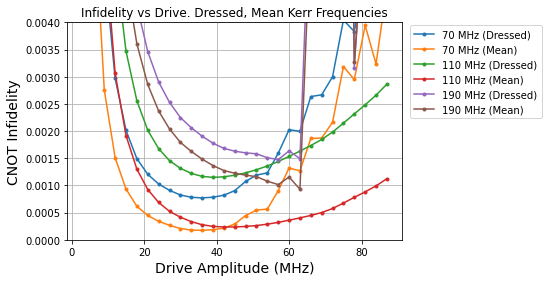

In [35]:
for det_i in [70,110,190]:
    plt.plot(E_list,1 - np.array(F_class_dressed[det_i]),'.-',label = '{} MHz (Dressed)'.format(det_i))
    plt.plot(E_list,1 - np.array(F_class[det_i]),'.-',label = '{} MHz (Mean)'.format(det_i))
    
plt.grid()
plt.ylim(0,0.004)
plt.xlabel("Drive Amplitude (MHz)", fontsize = 14)
plt.ylabel("CNOT Infidelity", fontsize = 14)
plt.title("Infidelity vs Drive. Dressed, Mean Kerr Frequencies")
plt.legend(bbox_to_anchor = (1.01,1.01))
# plt.legend()
plt.savefig("./Plots/CR_gate_raw_fidelities/New_Approach/E_vs_F_2_Qubit.jpeg", dpi = 600, bbox_inches = 'tight')
plt.show()

KeyError: 130

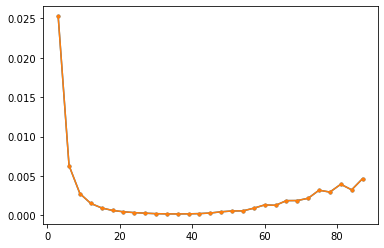

In [32]:
for det_i in [70,130,190]:
    plt.plot(E_list,1 - np.array(F[det_i]),'.-',label = '{} MHz'.format(det_i))
    plt.plot(E_list,1 - np.array(F_class[det_i]),'.-',label = '{} MHz class'.format(det_i))
    
plt.grid()
plt.ylim(0,0.004)
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("CNOT Infidelity")
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.show()

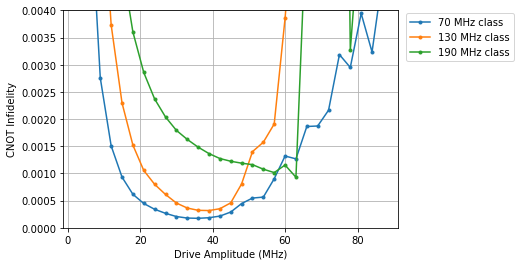

In [43]:
E_list = np.arange(3,90,3)
for det_i in [70,130,190]:
#     plt.plot(E_list,1 - np.array(F[det_i]),'.-',label = '{} MHz'.format(det_i))
    plt.plot(E_list,1 - np.array(F_class[det_i]),'.-',label = '{} MHz class'.format(det_i))

plt.grid()
plt.ylim(0,0.004)
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("CNOT Infidelity")
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.show()

### Error Budget Tests

In [6]:
a = pr.get_F_MT(0,1,args,dressed_frequency = False)
print(a)

(0.9998145393224735, 0.9999122381366347, 0.9999022904880237, 0.999999677340679, 0.9998148619403349, 0.9999125607712813)


In [42]:
for wthz in [4.445]:
    w = [wc,wthz*2*np.pi]
    pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)
    F_MU, F_MMT, F_MTU, F_MMCT, F_UMCT, F_MTMCT = pr.E_vs_F_error_budget(0,1,args, dressed_frequency = False)

  3%|█▌                                          | 1/29 [00:02<01:07,  2.39s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.8735332840822698
Matrix from brute force: 
[[0.99 0.13 0.   0.  ]
 [0.13 0.99 0.   0.  ]
 [0.   0.   0.06 1.  ]
 [0.   0.   1.   0.06]]
[[ 35.51 125.51   0.     0.  ]
 [125.51  35.51   0.     0.  ]
 [  0.     0.    74.53 164.53]
 [  0.     0.   164.53  74.53]]
Diagonal element: M[0][0]
Distance without sign change:  0.5060082090015431
Angle Difference without sign change:  -0.515645904919183
Distance with sign change:  1.9189225027616608
Angle Difference without sign change:  2.6259467486706103
Off Diagonal element: M[0][1]
Distance without sign change:  0.01696671994952112
Angle Difference without sign change:  3.481433885622918e-05
Distance with sign change:  0.24779929961937683
Angle Difference without sign change:  -0.11591864796768371
Diagonal element: M[2][2]
Distance without sign change:  0.2684838836766676
Angle Difference without sign change:  1.35207082903163
Distance with sign change:  0.29474017531987473
An

  7%|███                                         | 2/29 [00:04<00:58,  2.17s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9632012753996744
Matrix from brute force: 
[[0.99 0.13 0.   0.  ]
 [0.13 0.99 0.   0.  ]
 [0.   0.   0.12 0.99]
 [0.   0.   0.99 0.12]]
[[ 27.85 117.85   0.     0.  ]
 [117.85  27.85   0.     0.  ]
 [  0.     0.   -95.24  -5.24]
 [  0.     0.    -5.24 -95.24]]
Diagonal element: M[0][0]
Distance without sign change:  0.264573716227714
Angle Difference without sign change:  -0.26742965334798297
Distance with sign change:  1.966830808577568
Angle Difference without sign change:  2.8741630002418104
Off Diagonal element: M[0][1]
Distance without sign change:  0.004418318890347317
Angle Difference without sign change:  6.970512254888515e-05
Distance with sign change:  0.2481126138203128
Angle Difference without sign change:  -0.12221699686260304
Diagonal element: M[2][2]
Distance without sign change:  0.15142296807520522
Angle Difference without sign change:  0.9062954543111451
Distance with sign change:  0.2825943636946778


 10%|████▌                                       | 3/29 [00:06<00:52,  2.01s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9812801660145983
Matrix from brute force: 
[[0.99 0.13 0.   0.  ]
 [0.13 0.99 0.   0.  ]
 [0.   0.   0.14 0.99]
 [0.   0.   0.99 0.14]]
[[ 30.34 120.34   0.     0.  ]
 [120.34  30.34   0.     0.  ]
 [  0.     0.    74.77 164.77]
 [  0.     0.   164.77  74.77]]
Diagonal element: M[0][0]
Distance without sign change:  0.18440219251028922
Angle Difference without sign change:  -0.1862212937945572
Distance with sign change:  1.9747340616113391
Angle Difference without sign change:  2.9553713597952362
Off Diagonal element: M[0][1]
Distance without sign change:  0.0022097449784007584
Angle Difference without sign change:  8.965650185201683e-06
Distance with sign change:  0.2577140449806304
Angle Difference without sign change:  -0.12813877239049412
Diagonal element: M[2][2]
Distance without sign change:  0.11399431464407608
Angle Difference without sign change:  0.6741263756069649
Distance with sign change:  0.30812976405476

 14%|██████                                      | 4/29 [00:08<00:51,  2.06s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9877286216184654
Matrix from brute force: 
[[0.99 0.14 0.   0.  ]
 [0.14 0.99 0.   0.  ]
 [0.   0.   0.17 0.99]
 [0.   0.   0.99 0.17]]
[[ 36.02 126.02   0.     0.  ]
 [126.02  36.02   0.     0.  ]
 [  0.     0.   -50.37  39.63]
 [  0.     0.    39.63 -50.37]]
Diagonal element: M[0][0]
Distance without sign change:  0.14543419309191888
Angle Difference without sign change:  -0.14691701167004886
Distance with sign change:  1.9762499974431376
Angle Difference without sign change:  2.9946756419197444
Off Diagonal element: M[0][1]
Distance without sign change:  0.001439070948452993
Angle Difference without sign change:  8.366209472459888e-06
Distance with sign change:  0.27070814398624665
Angle Difference without sign change:  -0.1350709536519921
Diagonal element: M[2][2]
Distance without sign change:  0.09767365941548746
Angle Difference without sign change:  0.5355802186422299
Distance with sign change:  0.34412427893699

 17%|███████▌                                    | 5/29 [00:10<00:46,  1.93s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9904652609783483
Matrix from brute force: 
[[0.99 0.15 0.   0.  ]
 [0.15 0.99 0.   0.  ]
 [0.   0.   0.15 0.99]
 [0.   0.   0.99 0.15]]
[[ 44.61 134.61   0.     0.  ]
 [134.61  44.61   0.     0.  ]
 [  0.     0.    52.21 142.21]
 [  0.     0.   142.21  52.21]]
Diagonal element: M[0][0]
Distance without sign change:  0.12564809075437386
Angle Difference without sign change:  -0.12710037804270655
Distance with sign change:  1.9744831936261211
Angle Difference without sign change:  3.0144922755470867
Off Diagonal element: M[0][1]
Distance without sign change:  0.0011594688980177664
Angle Difference without sign change:  1.1549007185012756e-05
Distance with sign change:  0.2926217526721843
Angle Difference without sign change:  -0.14627671463947423
Diagonal element: M[2][2]
Distance without sign change:  0.0890654173485457
Angle Difference without sign change:  0.5250335219887938
Distance with sign change:  0.3207525137967

 21%|█████████                                   | 6/29 [00:12<00:44,  1.93s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.991926942483654
Matrix from brute force: 
[[0.99 0.16 0.   0.  ]
 [0.16 0.99 0.   0.  ]
 [0.   0.   0.16 0.99]
 [0.   0.   0.99 0.16]]
[[ 54.45 144.45   0.     0.  ]
 [144.45  54.45   0.     0.  ]
 [  0.     0.    43.61 133.61]
 [  0.     0.   133.61  43.61]]
Diagonal element: M[0][0]
Distance without sign change:  0.111927244128363
Angle Difference without sign change:  -0.11338719166055745
Distance with sign change:  1.9721309051788334
Angle Difference without sign change:  3.0282054619292356
Off Diagonal element: M[0][1]
Distance without sign change:  0.000984391716747778
Angle Difference without sign change:  7.071730099142522e-06
Distance with sign change:  0.3133226153387343
Angle Difference without sign change:  -0.15683519392477144
Diagonal element: M[2][2]
Distance without sign change:  0.08455942841810023
Angle Difference without sign change:  0.488873789018887
Distance with sign change:  0.32953336371012976


 24%|██████████▌                                 | 7/29 [00:13<00:41,  1.88s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9930898256608911
Matrix from brute force: 
[[0.99 0.17 0.   0.  ]
 [0.17 0.99 0.   0.  ]
 [0.   0.   0.19 0.98]
 [0.   0.   0.98 0.19]]
[[ 64.76 154.76   0.     0.  ]
 [154.76  64.76   0.     0.  ]
 [  0.     0.    43.26 133.26]
 [  0.     0.   133.26  43.26]]
Diagonal element: M[0][0]
Distance without sign change:  0.10083016245716088
Angle Difference without sign change:  -0.10227567281700847
Distance with sign change:  1.970012098611491
Angle Difference without sign change:  3.0393169807727847
Off Diagonal element: M[0][1]
Distance without sign change:  0.0008408249663669849
Angle Difference without sign change:  8.890016326232702e-06
Distance with sign change:  0.3299772275333655
Angle Difference without sign change:  -0.1653431381322802
Diagonal element: M[2][2]
Distance without sign change:  0.0821322917471799
Angle Difference without sign change:  0.4162281149731706
Distance with sign change:  0.3812438968680472

 28%|████████████▏                               | 8/29 [00:15<00:38,  1.84s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9935549377289838
Matrix from brute force: 
[[0.98 0.18 0.   0.  ]
 [0.18 0.98 0.   0.  ]
 [0.   0.   0.18 0.98]
 [0.   0.   0.98 0.18]]
[[ 77.94 167.94   0.     0.  ]
 [167.94  77.94   0.     0.  ]
 [  0.     0.    59.7  149.7 ]
 [  0.     0.   149.7   59.7 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.09470861050943842
Angle Difference without sign change:  -0.09627536932059198
Distance with sign change:  1.9659303638978884
Angle Difference without sign change:  3.0453172842692013
Off Diagonal element: M[0][1]
Distance without sign change:  0.0007983057253490455
Angle Difference without sign change:  9.929903178096981e-06
Distance with sign change:  0.3551723233530513
Angle Difference without sign change:  -0.17815271329109944
Diagonal element: M[2][2]
Distance without sign change:  0.0804722014906518
Angle Difference without sign change:  0.42166961750106624
Distance with sign change:  0.3683458025728

 31%|█████████████▋                              | 9/29 [00:17<00:36,  1.83s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.993491608723603
Matrix from brute force: 
[[0.98 0.19 0.   0.  ]
 [0.19 0.98 0.   0.  ]
 [0.   0.   0.19 0.98]
 [0.   0.   0.98 0.19]]
[[  91.69 -178.31    0.      0.  ]
 [-178.31   91.69    0.      0.  ]
 [   0.      0.      5.08   95.08]
 [   0.      0.     95.08    5.08]]
Diagonal element: M[0][0]
Distance without sign change:  0.08913665076945886
Angle Difference without sign change:  -0.09079627089902446
Distance with sign change:  1.96209136251225
Angle Difference without sign change:  3.050796382690769
Off Diagonal element: M[0][1]
Distance without sign change:  0.0007514578660838988
Angle Difference without sign change:  1.2356912054531008e-05
Distance with sign change:  0.3771619965537304
Angle Difference without sign change:  -0.18936116457083993
Diagonal element: M[2][2]
Distance without sign change:  0.07875523152405514
Angle Difference without sign change:  0.3979240450314869
Distance with sign change:  0.

 34%|██████████████▊                            | 10/29 [00:19<00:34,  1.79s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9919214870521922
Matrix from brute force: 
[[0.98 0.2  0.   0.  ]
 [0.2  0.98 0.   0.  ]
 [0.   0.   0.21 0.98]
 [0.   0.   0.98 0.21]]
[[ 105.76 -164.24    0.      0.  ]
 [-164.24  105.76    0.      0.  ]
 [   0.      0.    -98.16   -8.16]
 [   0.      0.     -8.16  -98.16]]
Diagonal element: M[0][0]
Distance without sign change:  0.08390766783915089
Angle Difference without sign change:  -0.08562797450678078
Distance with sign change:  1.9586186868374535
Angle Difference without sign change:  3.0559646790830124
Off Diagonal element: M[0][1]
Distance without sign change:  0.0006990064465463479
Angle Difference without sign change:  2.098627771659405e-05
Distance with sign change:  0.39594122263289083
Angle Difference without sign change:  -0.19895766272403728
Diagonal element: M[2][2]
Distance without sign change:  0.07585805153118513
Angle Difference without sign change:  0.35251655240181323
Distance with sign change

 38%|████████████████▎                          | 11/29 [00:20<00:31,  1.77s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9826026149483845
Matrix from brute force: 
[[0.98 0.21 0.   0.  ]
 [0.21 0.98 0.   0.  ]
 [0.   0.   0.21 0.98]
 [0.   0.   0.98 0.21]]
[[ 122.51 -147.49    0.      0.  ]
 [-147.49  122.51    0.      0.  ]
 [   0.      0.   -132.96  -42.96]
 [   0.      0.    -42.96 -132.96]]
Diagonal element: M[0][0]
Distance without sign change:  0.08052621310249232
Angle Difference without sign change:  -0.08238973336604483
Distance with sign change:  1.9536539919637788
Angle Difference without sign change:  3.0592029202237483
Off Diagonal element: M[0][1]
Distance without sign change:  0.0007286160543625049
Angle Difference without sign change:  0.00011822868580552106
Distance with sign change:  0.42039062972770797
Angle Difference without sign change:  -0.21142998055311651
Diagonal element: M[2][2]
Distance without sign change:  0.0721425604862734
Angle Difference without sign change:  0.329405624543539
Distance with sign change: 

 41%|█████████████████▊                         | 12/29 [00:22<00:29,  1.76s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9756620575959598
Matrix from brute force: 
[[0.98 0.22 0.   0.  ]
 [0.22 0.98 0.   0.  ]
 [0.   0.   0.23 0.97]
 [0.   0.   0.97 0.23]]
[[ 139.3  -130.7     0.      0.  ]
 [-130.7   139.3     0.      0.  ]
 [   0.      0.   -131.99  -41.99]
 [   0.      0.    -41.99 -131.99]]
Diagonal element: M[0][0]
Distance without sign change:  0.07727481692886314
Angle Difference without sign change:  -0.07924392032689763
Distance with sign change:  1.9492773215350323
Angle Difference without sign change:  3.062348733262896
Off Diagonal element: M[0][1]
Distance without sign change:  0.0008457291379438317
Angle Difference without sign change:  7.192693962564181e-05
Distance with sign change:  0.44075317032580225
Angle Difference without sign change:  -0.22180565216894543
Diagonal element: M[2][2]
Distance without sign change:  0.07797005703339958
Angle Difference without sign change:  0.3293168215329585
Distance with sign change: 

 45%|███████████████████▎                       | 13/29 [00:24<00:28,  1.81s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.979696781604984
Matrix from brute force: 
[[0.97 0.23 0.   0.  ]
 [0.23 0.97 0.   0.  ]
 [0.   0.   0.24 0.97]
 [0.   0.   0.97 0.24]]
[[ 157.35 -112.65    0.      0.  ]
 [-112.65  157.35    0.      0.  ]
 [   0.      0.    149.88 -120.12]
 [   0.      0.   -120.12  149.88]]
Diagonal element: M[0][0]
Distance without sign change:  0.07531587551426368
Angle Difference without sign change:  -0.07742373207895051
Distance with sign change:  1.9445726264429475
Angle Difference without sign change:  3.0641689215108427
Off Diagonal element: M[0][1]
Distance without sign change:  0.0009016932154228976
Angle Difference without sign change:  -0.00029473065729012927
Distance with sign change:  0.46133875595385043
Angle Difference without sign change:  -0.23236826176582176
Diagonal element: M[2][2]
Distance without sign change:  0.08872529768227294
Angle Difference without sign change:  0.3680176588958229
Distance with sign change

 48%|████████████████████▊                      | 14/29 [00:26<00:27,  1.80s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9836243079305839
Matrix from brute force: 
[[0.97 0.24 0.   0.  ]
 [0.24 0.97 0.   0.  ]
 [0.   0.   0.23 0.97]
 [0.   0.   0.97 0.23]]
[[175.58 -94.42   0.     0.  ]
 [-94.42 175.58   0.     0.  ]
 [  0.     0.    75.62 165.62]
 [  0.     0.   165.62  75.62]]
Diagonal element: M[0][0]
Distance without sign change:  0.07306756768649926
Angle Difference without sign change:  -0.07527949715013417
Distance with sign change:  1.9403128423435194
Angle Difference without sign change:  3.066313156439659
Off Diagonal element: M[0][1]
Distance without sign change:  0.0007360745525916645
Angle Difference without sign change:  -0.0003250925433457325
Distance with sign change:  0.47933174137833834
Angle Difference without sign change:  -0.24170659946339368
Diagonal element: M[2][2]
Distance without sign change:  0.08256877870730077
Angle Difference without sign change:  0.34461320065191
Distance with sign change:  0.47084787865564

 52%|██████████████████████▏                    | 15/29 [00:27<00:24,  1.75s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.965952014653775
Matrix from brute force: 
[[0.97 0.25 0.   0.  ]
 [0.25 0.97 0.   0.  ]
 [0.   0.   0.24 0.97]
 [0.   0.   0.97 0.24]]
[[-162.58  -72.58    0.      0.  ]
 [ -72.58 -162.58    0.      0.  ]
 [   0.      0.    161.59 -108.41]
 [   0.      0.   -108.41  161.59]]
Diagonal element: M[0][0]
Distance without sign change:  0.07129057464515884
Angle Difference without sign change:  -0.07368423739956743
Distance with sign change:  1.9341487183039856
Angle Difference without sign change:  3.067908416190226
Off Diagonal element: M[0][1]
Distance without sign change:  0.0006429810207493896
Angle Difference without sign change:  4.67622832919623e-05
Distance with sign change:  0.5039429011780053
Angle Difference without sign change:  -0.2544239253965406
Diagonal element: M[2][2]
Distance without sign change:  0.05028798110333392
Angle Difference without sign change:  0.20678605408350667
Distance with sign change:  0.

 55%|███████████████████████▋                   | 16/29 [00:29<00:22,  1.70s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9526880192174156
Matrix from brute force: 
[[0.97 0.26 0.   0.  ]
 [0.26 0.97 0.   0.  ]
 [0.   0.   0.29 0.96]
 [0.   0.   0.96 0.29]]
[[-142.95  -52.95    0.      0.  ]
 [ -52.95 -142.95    0.      0.  ]
 [   0.      0.     36.01  126.01]
 [   0.      0.    126.01   36.01]]
Diagonal element: M[0][0]
Distance without sign change:  0.06882615376435951
Angle Difference without sign change:  -0.07129190098983572
Distance with sign change:  1.9300027990617759
Angle Difference without sign change:  3.0703007525999575
Off Diagonal element: M[0][1]
Distance without sign change:  0.0006705398999589393
Angle Difference without sign change:  4.0516344350349385e-05
Distance with sign change:  0.5199243148969765
Angle Difference without sign change:  -0.262680002970491
Diagonal element: M[2][2]
Distance without sign change:  0.0588868006169879
Angle Difference without sign change:  0.20535662983629663
Distance with sign change:  

 59%|█████████████████████████▏                 | 17/29 [00:31<00:20,  1.68s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9516069202395093
Matrix from brute force: 
[[0.96 0.27 0.   0.  ]
 [0.27 0.96 0.   0.  ]
 [0.   0.   0.32 0.95]
 [0.   0.   0.95 0.32]]
[[-123.27  -33.27    0.      0.  ]
 [ -33.27 -123.27    0.      0.  ]
 [   0.      0.    -90.93   -0.93]
 [   0.      0.     -0.93  -90.93]]
Diagonal element: M[0][0]
Distance without sign change:  0.06666927806149368
Angle Difference without sign change:  -0.06919084039731783
Distance with sign change:  1.9263382092488435
Angle Difference without sign change:  3.0724018131924753
Off Diagonal element: M[0][1]
Distance without sign change:  0.0006266292488133255
Angle Difference without sign change:  -8.725150959066297e-05
Distance with sign change:  0.533606072089091
Angle Difference without sign change:  -0.26980183444838257
Diagonal element: M[2][2]
Distance without sign change:  0.08473125606568516
Angle Difference without sign change:  0.2687688786537457
Distance with sign change: 

 62%|██████████████████████████▋                | 18/29 [00:32<00:18,  1.68s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9650553114641888
Matrix from brute force: 
[[0.96 0.28 0.   0.  ]
 [0.28 0.96 0.   0.  ]
 [0.   0.   0.22 0.97]
 [0.   0.   0.97 0.22]]
[[ -95.11   -5.11    0.      0.  ]
 [  -5.11  -95.11    0.      0.  ]
 [   0.      0.    157.01 -112.99]
 [   0.      0.   -112.99  157.01]]
Diagonal element: M[0][0]
Distance without sign change:  0.06632564700796335
Angle Difference without sign change:  -0.06913441559311678
Distance with sign change:  1.9179736047885707
Angle Difference without sign change:  3.0724582379966763
Off Diagonal element: M[0][1]
Distance without sign change:  0.0006268651698538171
Angle Difference without sign change:  6.875357711067084e-05
Distance with sign change:  0.5629841147907129
Angle Difference without sign change:  -0.28506847268520696
Diagonal element: M[2][2]
Distance without sign change:  0.06367165578941014
Angle Difference without sign change:  0.2841559963477115
Distance with sign change: 

 66%|████████████████████████████▏              | 19/29 [00:34<00:16,  1.69s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9545633452049258
Matrix from brute force: 
[[0.96 0.28 0.   0.  ]
 [0.28 0.96 0.   0.  ]
 [0.   0.   0.25 0.97]
 [0.   0.   0.97 0.25]]
[[ -77.04   12.96    0.      0.  ]
 [  12.96  -77.04    0.      0.  ]
 [   0.      0.    106.3  -163.7 ]
 [   0.      0.   -163.7   106.3 ]]
Diagonal element: M[0][0]
Distance without sign change:  0.06361782502469147
Angle Difference without sign change:  -0.06637127436685002
Distance with sign change:  1.9163177275821381
Angle Difference without sign change:  3.0752213792229433
Off Diagonal element: M[0][1]
Distance without sign change:  0.0006206431591569082
Angle Difference without sign change:  3.1829418211330485e-05
Distance with sign change:  0.5689022201565234
Angle Difference without sign change:  -0.28815995239661846
Diagonal element: M[2][2]
Distance without sign change:  0.0552601462344731
Angle Difference without sign change:  0.2234881051557766
Distance with sign change: 

 69%|█████████████████████████████▋             | 20/29 [00:36<00:15,  1.72s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9347314688531432
Matrix from brute force: 
[[0.96 0.29 0.   0.  ]
 [0.29 0.96 0.   0.  ]
 [0.   0.   0.29 0.96]
 [0.   0.   0.96 0.29]]
[[ -54.87   35.13    0.      0.  ]
 [  35.13  -54.87    0.      0.  ]
 [   0.      0.   -106.52  -16.52]
 [   0.      0.    -16.52 -106.52]]
Diagonal element: M[0][0]
Distance without sign change:  0.062024877382597154
Angle Difference without sign change:  -0.0648340791008785
Distance with sign change:  1.9126645255085786
Angle Difference without sign change:  3.0767585744889145
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005860339084170766
Angle Difference without sign change:  -6.3868997871764e-05
Distance with sign change:  0.5812312741521527
Angle Difference without sign change:  -0.29462115842863823
Diagonal element: M[2][2]
Distance without sign change:  0.021492462480082523
Angle Difference without sign change:  0.0534097898024676
Distance with sign change: 

 72%|███████████████████████████████▏           | 21/29 [00:38<00:14,  1.80s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9542482562260013
Matrix from brute force: 
[[0.95 0.31 0.   0.  ]
 [0.31 0.95 0.   0.  ]
 [0.   0.   0.22 0.98]
 [0.   0.   0.98 0.22]]
[[ -15.54   74.46    0.      0.  ]
 [  74.46  -15.54    0.      0.  ]
 [   0.      0.   -128.41  -38.41]
 [   0.      0.    -38.41 -128.41]]
Diagonal element: M[0][0]
Distance without sign change:  0.0632166976281696
Angle Difference without sign change:  -0.06652674914184009
Distance with sign change:  1.8997788560566837
Angle Difference without sign change:  3.0750659044479534
Off Diagonal element: M[0][1]
Distance without sign change:  0.0006399474068984857
Angle Difference without sign change:  7.56207998845199e-05
Distance with sign change:  0.6219477553669922
Angle Difference without sign change:  -0.31593883898200437
Diagonal element: M[2][2]
Distance without sign change:  0.09223161588160504
Angle Difference without sign change:  0.41901742957398364
Distance with sign change:  

 76%|████████████████████████████████▌          | 22/29 [00:40<00:12,  1.81s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.917175996884375
Matrix from brute force: 
[[0.95 0.3  0.   0.  ]
 [0.3  0.95 0.   0.  ]
 [0.   0.   0.39 0.92]
 [0.   0.   0.92 0.39]]
[[-15.28  74.72   0.     0.  ]
 [ 74.72 -15.28   0.     0.  ]
 [  0.     0.   -46.98  43.02]
 [  0.     0.    43.02 -46.98]]
Diagonal element: M[0][0]
Distance without sign change:  0.05782670175570754
Angle Difference without sign change:  -0.060558187296833314
Distance with sign change:  1.9091993135842462
Angle Difference without sign change:  3.08103446629296
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005258783462557202
Angle Difference without sign change:  6.361187335737256e-05
Distance with sign change:  0.5929393499118158
Angle Difference without sign change:  -0.30076163029368214
Diagonal element: M[2][2]
Distance without sign change:  0.031179514824925952
Angle Difference without sign change:  0.007936913365657987
Distance with sign change:  0.748793937147

 79%|██████████████████████████████████         | 23/29 [00:41<00:10,  1.80s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9197819866213335
Matrix from brute force: 
[[0.95 0.32 0.   0.  ]
 [0.32 0.95 0.   0.  ]
 [0.   0.   0.27 0.96]
 [0.   0.   0.96 0.27]]
[[  32.2   122.2     0.      0.  ]
 [ 122.2    32.2     0.      0.  ]
 [   0.      0.    134.56 -135.44]
 [   0.      0.   -135.44  134.56]]
Diagonal element: M[0][0]
Distance without sign change:  0.060129409066737576
Angle Difference without sign change:  -0.06348881403227213
Distance with sign change:  1.8935276882485337
Angle Difference without sign change:  3.0781038395575213
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005911159227281529
Angle Difference without sign change:  -3.8487991900737354e-05
Distance with sign change:  0.6410111101488112
Angle Difference without sign change:  -0.3260192058220029
Diagonal element: M[2][2]
Distance without sign change:  0.018531531819360278
Angle Difference without sign change:  -0.0003421360419215776
Distance with sign c

 83%|███████████████████████████████████▌       | 24/29 [00:43<00:08,  1.76s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9190460444921076
Matrix from brute force: 
[[0.95 0.33 0.   0.  ]
 [0.33 0.95 0.   0.  ]
 [0.   0.   0.37 0.93]
 [0.   0.   0.93 0.37]]
[[ 59.34 149.34   0.     0.  ]
 [149.34  59.34   0.     0.  ]
 [  0.     0.   176.43 -93.57]
 [  0.     0.   -93.57 176.43]]
Diagonal element: M[0][0]
Distance without sign change:  0.058927677652642556
Angle Difference without sign change:  -0.06235793602666584
Distance with sign change:  1.8893591735683977
Angle Difference without sign change:  3.0792347175631276
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005832996588381994
Angle Difference without sign change:  6.357898367594527e-05
Distance with sign change:  0.6533092398026487
Angle Difference without sign change:  -0.33251247828647335
Diagonal element: M[2][2]
Distance without sign change:  0.042229333857672295
Angle Difference without sign change:  0.08605756896538598
Distance with sign change:  0.7079679097

 86%|█████████████████████████████████████      | 25/29 [00:45<00:07,  1.88s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9039027117796444
Matrix from brute force: 
[[0.95 0.32 0.   0.  ]
 [0.32 0.95 0.   0.  ]
 [0.   0.   0.28 0.96]
 [0.   0.   0.96 0.28]]
[[ 66.27 156.27   0.     0.  ]
 [156.27  66.27   0.     0.  ]
 [  0.     0.   -31.87  58.13]
 [  0.     0.    58.13 -31.87]]
Diagonal element: M[0][0]
Distance without sign change:  0.05534568020968805
Angle Difference without sign change:  -0.05837216173132534
Distance with sign change:  1.895757565467279
Angle Difference without sign change:  3.083220491858468
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005177348804111243
Angle Difference without sign change:  5.5970000832655486e-05
Distance with sign change:  0.6348144748901398
Angle Difference without sign change:  -0.32277057893818206
Diagonal element: M[2][2]
Distance without sign change:  0.03614210410525619
Angle Difference without sign change:  0.10157943782231348
Distance with sign change:  0.5401975202415

 90%|██████████████████████████████████████▌    | 26/29 [00:47<00:05,  1.94s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9292457977105573
Matrix from brute force: 
[[0.94 0.33 0.   0.  ]
 [0.33 0.94 0.   0.  ]
 [0.   0.   0.35 0.94]
 [0.   0.   0.94 0.35]]
[[ 110.66 -159.34    0.      0.  ]
 [-159.34  110.66    0.      0.  ]
 [   0.      0.    -22.76   67.24]
 [   0.      0.     67.24  -22.76]]
Diagonal element: M[0][0]
Distance without sign change:  0.0564904051298495
Angle Difference without sign change:  -0.059950203953480476
Distance with sign change:  1.88400361588031
Angle Difference without sign change:  3.0816424496363126
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005476483760043966
Angle Difference without sign change:  -3.224712846524906e-05
Distance with sign change:  0.6687921217085204
Angle Difference without sign change:  -0.34074237448340866
Diagonal element: M[2][2]
Distance without sign change:  0.13951599739505965
Angle Difference without sign change:  0.4052125255041407
Distance with sign change:  

 93%|████████████████████████████████████████   | 27/29 [00:50<00:04,  2.10s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9045035142924143
Matrix from brute force: 
[[0.94 0.35 0.   0.  ]
 [0.35 0.94 0.   0.  ]
 [0.   0.   0.34 0.94]
 [0.   0.   0.94 0.34]]
[[ 155.48 -114.52    0.      0.  ]
 [-114.52  155.48    0.      0.  ]
 [   0.      0.     23.08  113.08]
 [   0.      0.    113.08   23.08]]
Diagonal element: M[0][0]
Distance without sign change:  0.057175510484010386
Angle Difference without sign change:  -0.06104218699815299
Distance with sign change:  1.8727163395041497
Angle Difference without sign change:  3.08055046659164
Off Diagonal element: M[0][1]
Distance without sign change:  0.0006056098777092043
Angle Difference without sign change:  6.119117652124883e-05
Distance with sign change:  0.6997315134376558
Angle Difference without sign change:  -0.35717633776403734
Diagonal element: M[2][2]
Distance without sign change:  0.033276151554705084
Angle Difference without sign change:  -0.023789237969045994
Distance with sign chang

 97%|█████████████████████████████████████████▌ | 28/29 [00:52<00:02,  2.06s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.8763627156029582
Matrix from brute force: 
[[0.95 0.32 0.   0.  ]
 [0.32 0.95 0.   0.  ]
 [0.   0.   0.42 0.91]
 [0.   0.   0.91 0.42]]
[[ 131.03 -138.97    0.      0.  ]
 [-138.97  131.03    0.      0.  ]
 [   0.      0.     -9.99   80.01]
 [   0.      0.     80.01   -9.99]]
Diagonal element: M[0][0]
Distance without sign change:  0.050980775353175814
Angle Difference without sign change:  -0.05382224249776835
Distance with sign change:  1.8939487442323792
Angle Difference without sign change:  3.0877704110920248
Off Diagonal element: M[0][1]
Distance without sign change:  0.00042287478501792735
Angle Difference without sign change:  5.345974683559162e-05
Distance with sign change:  0.6405749472592168
Angle Difference without sign change:  -0.32585018013070255
Diagonal element: M[2][2]
Distance without sign change:  0.06671855626475272
Angle Difference without sign change:  -0.11279985458047495
Distance with sign chan

100%|███████████████████████████████████████████| 29/29 [00:54<00:00,  1.87s/it]

Signs from brute force: 
[1, 1, 1, 1]
Fidelity from brute force:  0.9210825386690868
Matrix from brute force: 
[[0.94 0.35 0.   0.  ]
 [0.35 0.94 0.   0.  ]
 [0.   0.   0.42 0.91]
 [0.   0.   0.91 0.42]]
[[-154.54  -64.54    0.      0.  ]
 [ -64.54 -154.54    0.      0.  ]
 [   0.      0.   -137.63  -47.63]
 [   0.      0.    -47.63 -137.63]]
Diagonal element: M[0][0]
Distance without sign change:  0.054534784259299446
Angle Difference without sign change:  -0.05828001718695714
Distance with sign change:  1.8709342843727923
Angle Difference without sign change:  3.083312636402836
Off Diagonal element: M[0][1]
Distance without sign change:  0.0005296991170836917
Angle Difference without sign change:  1.7444052515519986e-05
Distance with sign change:  0.7046763702561888
Angle Difference without sign change:  -0.35985342604439713
Diagonal element: M[2][2]
Distance without sign change:  0.08109170648245674
Angle Difference without sign change:  0.18542829315430542
Distance with sign change

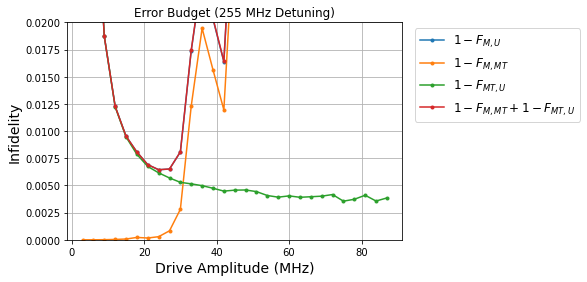

In [50]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU), '.-', label = r'$1 - F_{MT,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT) + 1 - np.array(F_MTU), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)", fontsize = 14)
plt.ylabel("Infidelity", fontsize = 14)
plt.ylim(0,0.02)
plt.legend(bbox_to_anchor = (1.55,1.0), fontsize = 'large')
plt.title("Error Budget (255 MHz Detuning)", fontsize = 12)
plt.savefig("./Plots/CR_gate_raw_fidelities/New_Approach/Error_Budget_2_Qubit_255_MHz.jpeg", dpi = 600, bbox_inches = 'tight')
plt.show()

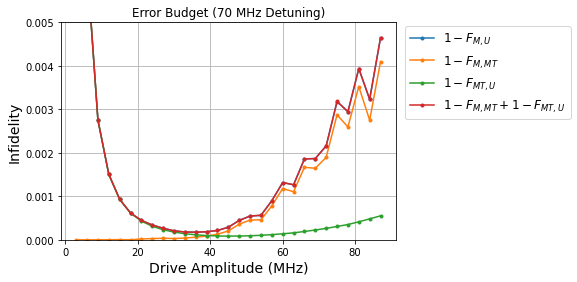

In [41]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU), '.-', label = r'$1 - F_{MT,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT) + 1 - np.array(F_MTU), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)", fontsize = 14)
plt.ylabel("Infidelity", fontsize = 14)
plt.ylim(0,0.005)
plt.legend(bbox_to_anchor = (1.01,1.01), fontsize = 'large')
plt.title("Error Budget (70 MHz Detuning)", fontsize = 12)
plt.savefig("./Plots/CR_gate_raw_fidelities/New_Approach/Error_Budget_2_Qubit_70_MHz.jpeg", dpi = 600, bbox_inches = 'tight')
plt.show()

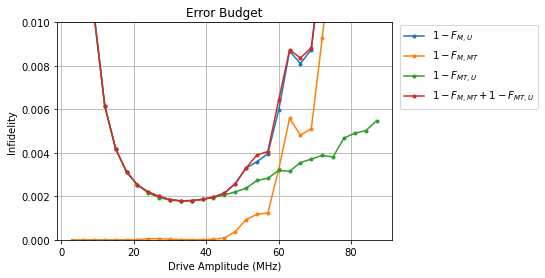

In [117]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU), '.-', label = r'$1 - F_{MT,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT) + 1 - np.array(F_MTU), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("Infidelity")
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title("Error Budget: Drive at Dressed Frequency")
plt.show()

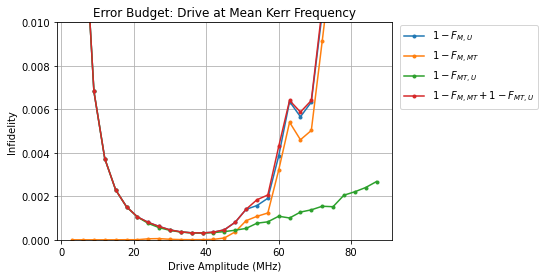

In [119]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU), '.-', label = r'$1 - F_{MT,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT) + 1 - np.array(F_MTU), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("Infidelity")
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title("Error Budget: Drive at Mean Kerr Frequency")
plt.show()

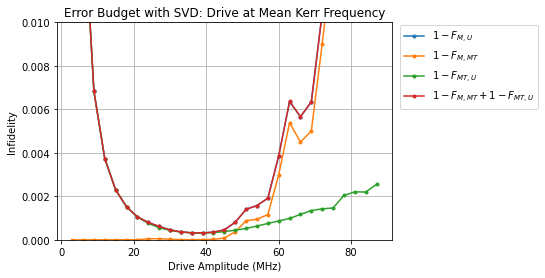

In [211]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU), '.-', label = r'$1 - F_{MT,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT) + 1 - np.array(F_MTU), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("Infidelity")
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title("Error Budget with SVD: Drive at Mean Kerr Frequency")
plt.show()

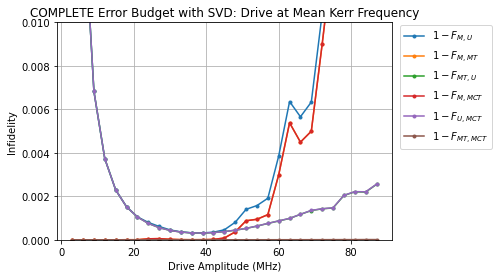

In [224]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU), '.-', label = r'$1 - F_{MT,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMCT), '.-', label = r'$1 - F_{M,MCT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_UMCT), '.-', label = r'$1 - F_{U,MCT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTMCT), '.-', label = r'$1 - F_{MT,MCT}$')

# plt.plot(np.arange(3,90,3),1 - np.array(F_MMT) + 1 - np.array(F_MTU), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("Infidelity")
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title("COMPLETE Error Budget with SVD: Drive at Mean Kerr Frequency")
plt.show()

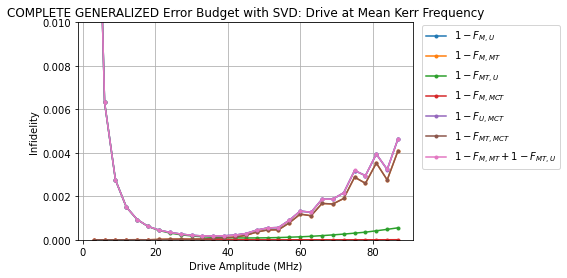

In [222]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU), '.-', label = r'$1 - F_{MT,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMCT), '.-', label = r'$1 - F_{M,MCT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_UMCT), '.-', label = r'$1 - F_{U,MCT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTMCT), '.-', label = r'$1 - F_{MT,MCT}$')

plt.plot(np.arange(3,90,3),1 - np.array(F_MMT) + 1 - np.array(F_MTU), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("Infidelity")
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title("COMPLETE GENERALIZED Error Budget with SVD: Drive at Mean Kerr Frequency")
plt.show()

## 3 Qubit Tests

In [51]:
N = 3
N_l = 4
exc = 4
w = np.array([4.59,4.7,4.63])*2*np.pi
anh_array = np.array([0.3,0.3,0.3])*2*np.pi
J = [[0,1,0],
     [1,0,1],
     [0,1,0]]
J = np.array(J)*0.003*2*np.pi
control_target = [[0,0,0],
                  [1,0,1],
                  [0,0,0]]
args = {}
# args['Emax'] = 0.02*2*np.pi
# args['tp'] = 130
args['Emax'] = 1e-3**2*np.pi
args['tp'] = 140#130.17
args['rf'] = 0.3
args['t_step'] = 0.1

pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)
# F_final,_ = pr.get_f(1,2,args)
# print("Final fidelity: ",F_final)

In [18]:
out_U = pr.get_out_U(1,2,args)
pr.print_U(pr.get_M(out_U.states[-1],1,2))

[[0.88 0.47 0.01 0.   0.   0.   0.01 0.  ]
 [0.47 0.88 0.   0.01 0.   0.   0.   0.01]
 [0.01 0.   0.47 0.88 0.   0.   0.   0.  ]
 [0.   0.01 0.88 0.47 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.88 0.47 0.01 0.  ]
 [0.   0.   0.   0.   0.47 0.88 0.   0.01]
 [0.01 0.   0.   0.   0.01 0.   0.48 0.88]
 [0.   0.01 0.   0.   0.   0.01 0.88 0.48]]
[[  75.48  165.6    -0.     -0.      0.      0.      0.      0.  ]
 [ 165.6    75.71    0.      0.      0.      0.      0.      0.  ]
 [  -0.      0.   -153.76  -65.66   -0.     -0.     -0.     -0.  ]
 [  -0.      0.    -65.66 -157.56    0.      0.      0.      0.  ]
 [   0.      0.     -0.      0.    145.81 -124.11   -0.      0.  ]
 [   0.      0.     -0.      0.   -124.11  145.98    0.     -0.  ]
 [   0.      0.     -0.      0.     -0.      0.    -83.1  -174.93]
 [   0.      0.     -0.      0.      0.     -0.   -174.93  -86.77]]


In [19]:
out_M = pr.get_M_vectors(1,2,args)
pr.print_U(out_M)

Shapes of the vectors: 
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
(64, 1)
[[0.88 0.47 0.01 0.   0.   0.   0.01 0.  ]
 [0.47 0.88 0.   0.01 0.   0.   0.   0.01]
 [0.01 0.   0.47 0.88 0.   0.   0.   0.  ]
 [0.   0.01 0.88 0.47 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.88 0.47 0.01 0.  ]
 [0.   0.   0.   0.   0.47 0.88 0.   0.01]
 [0.01 0.   0.   0.   0.01 0.   0.48 0.88]
 [0.   0.01 0.   0.   0.   0.01 0.88 0.48]]
[[  75.48  165.6    -0.     -0.      0.      0.      0.      0.  ]
 [ 165.6    75.71    0.      0.      0.      0.      0.      0.  ]
 [  -0.      0.   -153.72  -65.62   -0.     -0.     -0.     -0.  ]
 [  -0.      0.    -65.62 -157.52    0.      0.      0.      0.  ]
 [   0.      0.     -0.      0.    145.78 -124.13   -0.      0.  ]
 [   0.      0.     -0.      0.   -124.13  145.95    0.     -0.  ]
 [   0.      0.     -0.      0.     -0.      0.    -83.07 -174.91]
 [   0.      0.     -0.      0.      0.     -0.   -174.91  -86.74]]


### Test Simple Fidelity

In [15]:
pr.calibrate_signs(np.array(out_M, dtype = complex),np.array(pr.get_F(out_U.states[-1],1,2,[1]*8,M = out_M)[1], dtype = complex))

phi0 array: 
[-56.19123248 -55.82586855]
phi1 array: 
[-123.65938842  123.20938317]
theta0 array: 
[ 75.59613461 145.86614046]
theta1 array: 
[-155.62344742  -84.90971047]
phi0 avg =  -56.00855051861149
phi1 avg=  -123.43438579315824
theta_final 
 [  32.86207535  -37.62979606  113.11499789 -117.88271859]
Phases: 

[[1. 0.]
 [0. 1.]]
[[-37.63   0.  ]
 [  0.    32.86]]
CT space: 

[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[ 113.11 -156.89    0.      0.  ]
 [-156.89  113.11    0.      0.  ]
 [   0.      0.   -117.88  -27.88]
 [   0.      0.    -27.88 -117.88]]
d =  8
M: 

[[0.88 0.47 0.01 0.   0.   0.   0.01 0.  ]
 [0.47 0.88 0.   0.01 0.   0.   0.   0.01]
 [0.01 0.   0.47 0.88 0.   0.   0.   0.  ]
 [0.   0.01 0.88 0.47 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.88 0.47 0.01 0.  ]
 [0.   0.   0.   0.   0.47 0.88 0.   0.01]
 [0.01 0.   0.   0.   0.01 0.   0.48 0.88]
 [0.   0.01 0.   0.   0.   0.01 0.88 0.48]]
[[  75.48  165.6    -0.    

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1., -1.])

In [28]:
pr.get_F(out_U.states[-1],1,2,[1]*6 + [-1,-1])

phi0 array: 
[-56.19164125 -55.82812793]
phi1 array: 
[-123.66237395  123.21359637]
theta0 array: 
[ 75.59712592 145.89591465]
theta1 array: 
[-155.6596184   -84.93463788]
phi0 avg =  -56.00988458682517
phi1 avg=  -123.43798516124059
theta_final 
 [  32.86829035  -37.64359428  113.13417225 -117.90947618]
Type of M  <class 'numpy.ndarray'>
Type of U  <class 'numpy.ndarray'>
Phases: 

[[1. 0.]
 [0. 1.]]
[[-37.64   0.  ]
 [  0.    32.87]]
CT space: 

[[0.88 0.47 0.   0.  ]
 [0.47 0.88 0.   0.  ]
 [0.   0.   0.47 0.88]
 [0.   0.   0.88 0.47]]
[[ 113.13 -156.87    0.      0.  ]
 [-156.87  113.13    0.      0.  ]
 [   0.      0.   -117.91  -27.91]
 [   0.      0.    -27.91 -117.91]]
d =  8
M: 

[[0.88 0.47 0.01 0.   0.   0.   0.01 0.  ]
 [0.47 0.88 0.   0.01 0.   0.   0.   0.01]
 [0.01 0.   0.47 0.88 0.   0.   0.   0.  ]
 [0.   0.01 0.88 0.47 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.88 0.47 0.01 0.  ]
 [0.   0.   0.   0.   0.47 0.88 0.   0.01]
 [0.01 0.   0.   0.   0.01 0.   0.48 0.88]
 

(0.9997426240476655,
 Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
 Qobj data =
 [[ 0.22120284+0.85474805j -0.45457218+0.11764011j  0.        +0.j
    0.        +0.j          0.        +0.j          0.        +0.j
    0.        +0.j          0.        +0.j        ]
  [-0.45457218+0.11764011j  0.22120284+0.85474805j  0.        +0.j
    0.        +0.j          0.        +0.j          0.        +0.j
    0.        +0.j          0.        +0.j        ]
  [ 0.        +0.j          0.        +0.j         -0.43131811-0.19608071j
    0.36445075-0.80168117j  0.        +0.j          0.        +0.j
    0.        +0.j          0.        +0.j        ]
  [ 0.        +0.j          0.        +0.j          0.36445075-0.80168117j
   -0.43131811-0.19608071j  0.        +0.j          0.        +0.j
    0.        +0.j          0.        +0.j        ]
  [ 0.        +0.j          0.        +0.j          0.        +0.j
    0.        +0.j         -0.73198437+0.493683

### Test Calibration

  0%|                                                    | 0/11 [00:00<?, ?it/s]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


  9%|████                                        | 1/11 [01:13<12:15, 73.56s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


 18%|████████                                    | 2/11 [02:33<11:38, 77.56s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


 27%|████████████                                | 3/11 [03:51<10:20, 77.52s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


 36%|████████████████                            | 4/11 [05:07<08:59, 77.14s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


 45%|████████████████████                        | 5/11 [06:30<07:54, 79.02s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


 55%|████████████████████████                    | 6/11 [07:55<06:44, 80.96s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


 64%|████████████████████████████                | 7/11 [09:09<05:15, 78.81s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


 73%|████████████████████████████████            | 8/11 [10:27<03:55, 78.66s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


 82%|████████████████████████████████████        | 9/11 [11:46<02:37, 78.56s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


 91%|███████████████████████████████████████    | 10/11 [12:59<01:17, 77.12s/it]

Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary
Solving the whole unitary


100%|███████████████████████████████████████████| 11/11 [14:13<00:00, 77.56s/it]


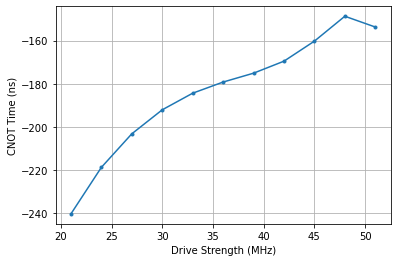

130


In [52]:
ts_d_3 = {}
phi0_d_3 = {}
phi1_d_3 = {}
E_list_d_3 = {}
t_list_d_3 = {}
E_list_3 = np.arange(21,54,3)
t_list_3 = np.arange(50,200,25)
for wthz in [4.57]:
    w[2] = wthz*2*np.pi
    pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)
    ts,phi0,phi1,E_list_class,t_list_class = pr.calibrate_cnot_t(1,2,args,E_list_3,t_list_3)
    ind = int(1e3*(wc/(2*np.pi) - wthz + 0.0001))
    print(ind)
    ts_d_3[ind] = ts 
    phi0_d_3[ind] = phi0
    phi1_d_3[ind] = phi1 
    E_list_d_3[ind] = E_list_class
    t_list_d_3[ind] = t_list_class


### Test Fidelity

In [31]:
F_class_3 = {}
for wthz in [4.63]:
    w[2] = wthz*2*np.pi
    if wthz == 4.63:
        w[0] = 4.59*2*np.pi
    if wthz == 4.57:
        w[0] = 4.63*2*np.pi
    if wthz == 4.51:
        w[0] == 4.63*2*np.pi
    pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)
    F_list = pr.E_vs_F(1,2,args)
    ind = int(1e3*(wc/(2*np.pi) - wthz + 0.0001))
    F_class_3[ind] = F_list

+-------+-----------------+--------------------+---------+
| Qubit | frequency (GHz) | anharmonicity(GHz) | Targets |
+-------+-----------------+--------------------+---------+
| 1     | 4.59            | 0.3                | []      |
+-------+-----------------+--------------------+---------+
| 2     | 4.7             | 0.3                | [1, 3]  |
+-------+-----------------+--------------------+---------+
| 3     | 4.63            | 0.3                | []      |
+-------+-----------------+--------------------+---------+


100%|███████████████████████████████████████████| 29/29 [04:56<00:00, 10.21s/it]


In [117]:
with open("./pickles/CR_gate_raw_fidelity/class_results/2_qubit_fidelity.pkl", 'wb') as f:
    pickle.dump(F_class,f)
with open("./pickles/CR_gate_raw_fidelity/class_results/3_qubit_fidelity_target_70_130_190_spectator_130_70_70.pkl", 'wb') as f:
    pickle.dump(F_class_3,f)

In [118]:
with open("./pickles/CR_gate_raw_fidelity/class_results/2_qubit_fidelity.pkl", 'rb') as f:
    F_class = pickle.load(f)
with open("./pickles/CR_gate_raw_fidelity/class_results/3_qubit_fidelity_target_70_130_190_spectator_130_70_70.pkl", 'rb') as f:
    F_class_3 = pickle.load(f)

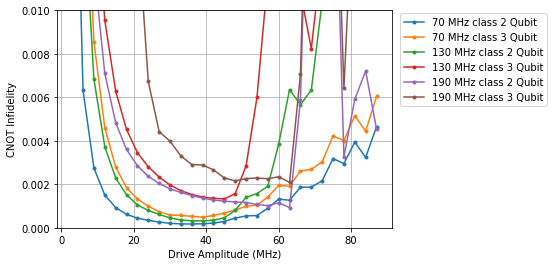

In [119]:
E_list = np.arange(3,90,3)
for det_i in [70,130,190]:
#     plt.plot(E_list,1 - np.array(F[det_i]),'.-',label = '{} MHz'.format(det_i))
    plt.plot(E_list,1 - np.array(F_class[det_i]),'.-',label = '{} MHz class 2 Qubit'.format(det_i))
    plt.plot(E_list,1 - np.array(F_class_3[det_i]),'.-',label = '{} MHz class 3 Qubit'.format(det_i))
    
plt.grid()
plt.ylim(0,0.01)
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("CNOT Infidelity")
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.show()

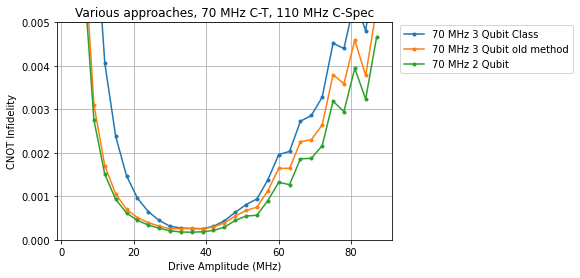

In [48]:
for det_i in [70]:
#     plt.plot(E_list,1 - np.array(F[det_i]),'.-',label = '{} MHz'.format(det_i))
#     plt.plot(E_list,1 - np.array(F_class[det_i]),'.-',label = '{} MHz class 2 Qubit'.format(det_i))
    plt.plot(E_list,1 - np.array(F_class_3[det_i]),'.-',label = '{} MHz 3 Qubit Class'.format(det_i))
    plt.plot(E_list,1 - np.array([j[0] for j in F_3qubit]),'.-',label = '{} MHz 3 Qubit old method'.format(det_i))
    plt.plot(E_list,1-np.array(F[det_i]),'.-',label = '{} MHz 2 Qubit'.format(det_i))
plt.grid()
plt.ylim(0,0.005)
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("CNOT Infidelity")
plt.title("Various approaches, 70 MHz C-T, 110 MHz C-Spec")
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.show()

### Spectator Frequency Sweep

In [49]:
N = 3
N_l = 4
exc = 4
w = np.array([4.59,4.7,4.63])*2*np.pi
anh_array = np.array([0.3,0.3,0.3])*2*np.pi
J = [[0,1,0],
     [1,0,1],
     [0,1,0]]
J = np.array(J)*0.003*2*np.pi
control_target = [[0,0,0],
                  [1,0,1],
                  [0,0,0]]
args = {}
args['Emax'] = 1e-3*39*2*np.pi
args['tp'] = 130.17
args['rf'] = 0.3
args['t_step'] = 0.1

pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)

F_spec_sweep = []
t = np.linspace(0,args['tp'],400)
def return_f_spec_sweep_class(ws):
    w[0] = ws
    pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)
    F, U_final = pr.get_f(1,2,args)
    return F

ws_range = 2*np.pi*np.arange(4.43,4.67,0.001)
F_spec_sweep_class_3 = Parallel(n_jobs=-1)(delayed(return_f_spec_sweep_class)(w) for w in tqdm(ws_range))


+-------+-----------------+--------------------+---------+
| Qubit | frequency (GHz) | anharmonicity(GHz) | Targets |
+-------+-----------------+--------------------+---------+
| 1     | 4.59            | 0.3                | []      |
+-------+-----------------+--------------------+---------+
| 2     | 4.7             | 0.3                | [1, 3]  |
+-------+-----------------+--------------------+---------+
| 3     | 4.63            | 0.3                | []      |
+-------+-----------------+--------------------+---------+


 25%|██████████▍                               | 60/241 [04:08<12:46,  4.24s/it]

+-------+-----------------+--------------------+---------+
| Qubit | frequency (GHz) | anharmonicity(GHz) | Targets |
+-------+-----------------+--------------------+---------+
| 1     | 4.432           | 0.3                | []      |
+-------+-----------------+--------------------+---------+
| 2     | 4.7             | 0.3                | [1, 3]  |
+-------+-----------------+--------------------+---------+
| 3     | 4.63            | 0.3                | []      |
+-------+-----------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.436000000000002 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------------+---------+
| 3     | 4.63              | 0.3         

+-------+-------------------+--------------------+---------++-------+-----------------+--------------------+---------+
| Qubit | frequency (GHz) | anharmonicity(GHz) | Targets |
+-------+-----------------+--------------------+---------+
| 1     | 4.431           | 0.3                | []      |
+-------+-----------------+--------------------+---------+
| 2     | 4.7             | 0.3                | [1, 3]  |
+-------+-----------------+--------------------+---------+
| 3     | 4.63            | 0.3                | []      |
+-------+-----------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.435000000000001 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------

+-------+-------------------+--------------------+---------++-------+-----------------+--------------------+---------+
| Qubit | frequency (GHz) | anharmonicity(GHz) | Targets |
+-------+-----------------+--------------------+---------+
| 1     | 4.43            | 0.3                | []      |
+-------+-----------------+--------------------+---------+
| 2     | 4.7             | 0.3                | [1, 3]  |
+-------+-----------------+--------------------+---------+
| 3     | 4.63            | 0.3                | []      |
+-------+-----------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.437000000000002 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------

 37%|███████████████▎                          | 88/241 [06:03<10:33,  4.14s/it]/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision ti

 38%|████████████████                          | 92/241 [06:25<11:11,  4.51s/it]/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision ti

/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the futu

 50%|████████████████████▍                    | 120/241 [08:38<09:10,  4.55s/it]


+-------+------------------+--------------------+---------+
| Qubit | frequency (GHz)  | anharmonicity(GHz) | Targets |
+-------+------------------+--------------------+---------+
| 1     | 4.49000000000002 | 0.3                | []      |
+-------+------------------+--------------------+---------+
| 2     | 4.7              | 0.3                | [1, 3]  |
+-------+------------------+--------------------+---------+
| 3     | 4.63             | 0.3                | []      |
+-------+------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.494000000000021 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------------+---------+
| 3     | 4.63              | 0.

+-------+-------------------+--------------------+---------+
+-------+------------------+--------------------+---------+
| Qubit | frequency (GHz)  | anharmonicity(GHz) | Targets |
+-------+------------------+--------------------+---------+
| 1     | 4.49200000000002 | 0.3                | []      |
+-------+------------------+--------------------+---------+
| 2     | 4.7              | 0.3                | [1, 3]  |
+-------+------------------+--------------------+---------+
| 3     | 4.63             | 0.3                | []      |
+-------+------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.496000000000022 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+----

+-------+-------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.493000000000021 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------------+---------+
| 3     | 4.63              | 0.3                | []      |
+-------+-------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.497000000000022 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+---------------

 73%|█████████████████████████████▉           | 176/241 [12:20<04:14,  3.92s/it]/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision ti

 75%|██████████████████████████████▌          | 180/241 [12:35<03:57,  3.90s/it]


+-------+------------------+--------------------+---------+
| Qubit | frequency (GHz)  | anharmonicity(GHz) | Targets |
+-------+------------------+--------------------+---------+
| 1     | 4.55100000000004 | 0.3                | []      |
+-------+------------------+--------------------+---------+
| 2     | 4.7              | 0.3                | [1, 3]  |
+-------+------------------+--------------------+---------+
| 3     | 4.63             | 0.3                | []      |
+-------+------------------+--------------------+---------+
+-------+--------------------+--------------------+---------+
| Qubit | frequency (GHz)    | anharmonicity(GHz) | Targets |
+-------+--------------------+--------------------+---------+
| 1     | 4.5550000000000415 | 0.3                | []      |
+-------+--------------------+--------------------+---------+
| 2     | 4.7                | 0.3                | [1, 3]  |
+-------+--------------------+--------------------+---------+
| 3     | 4.63           

/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the futu

/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the futu


+-------+------------------+--------------------+---------+
| Qubit | frequency (GHz)  | anharmonicity(GHz) | Targets |
+-------+------------------+--------------------+---------+
| 1     | 4.55000000000004 | 0.3                | []      |
+-------+------------------+--------------------+---------+
| 2     | 4.7              | 0.3                | [1, 3]  |
+-------+------------------+--------------------+---------+
| 3     | 4.63             | 0.3                | []      |
+-------+------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.554000000000041 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------------+---------+
| 3     | 4.63              | 0.

+-------+-------------------+--------------------+---------+
+-------+--------------------+--------------------+---------+
| Qubit | frequency (GHz)    | anharmonicity(GHz) | Targets |
+-------+--------------------+--------------------+---------+
| 1     | 4.5520000000000405 | 0.3                | []      |
+-------+--------------------+--------------------+---------+
| 2     | 4.7                | 0.3                | [1, 3]  |
+-------+--------------------+--------------------+---------+
| 3     | 4.63               | 0.3                | []      |
+-------+--------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.556000000000042 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+------

/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gautham/anaconda3/envs/qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:200: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the futu


+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.553000000000041 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------------+---------+
| 3     | 4.63              | 0.3                | []      |
+-------+-------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.557000000000042 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------------+---------+
| 3     | 4.63         

100%|█████████████████████████████████████████| 241/241 [16:26<00:00,  4.09s/it]



+-------+------------------+--------------------+---------+
| Qubit | frequency (GHz)  | anharmonicity(GHz) | Targets |
+-------+------------------+--------------------+---------+
| 1     | 4.61000000000006 | 0.3                | []      |
+-------+------------------+--------------------+---------+
| 2     | 4.7              | 0.3                | [1, 3]  |
+-------+------------------+--------------------+---------+
| 3     | 4.63             | 0.3                | []      |
+-------+------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.614000000000061 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------------+---------+
| 3     | 4.63              | 0.

+-------+--------------------+--------------------+---------+
+-------+------------------+--------------------+---------+
| Qubit | frequency (GHz)  | anharmonicity(GHz) | Targets |
+-------+------------------+--------------------+---------+
| 1     | 4.61100000000006 | 0.3                | []      |
+-------+------------------+--------------------+---------+
| 2     | 4.7              | 0.3                | [1, 3]  |
+-------+------------------+--------------------+---------+
| 3     | 4.63             | 0.3                | []      |
+-------+------------------+--------------------+---------+
+-------+--------------------+--------------------+---------+
| Qubit | frequency (GHz)    | anharmonicity(GHz) | Targets |
+-------+--------------------+--------------------+---------+
| 1     | 4.6150000000000615 | 0.3                | []      |
+-------+--------------------+--------------------+---------+
| 2     | 4.7                | 0.3                | [1, 3]  |
+-------+-----------------

+-------+-------------------+--------------------+---------+
+-------+--------------------+--------------------+---------+
| Qubit | frequency (GHz)    | anharmonicity(GHz) | Targets |
+-------+--------------------+--------------------+---------+
| 1     | 4.6120000000000605 | 0.3                | []      |
+-------+--------------------+--------------------+---------+
| 2     | 4.7                | 0.3                | [1, 3]  |
+-------+--------------------+--------------------+---------+
| 3     | 4.63               | 0.3                | []      |
+-------+--------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.616000000000062 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+------

+-------+-------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.613000000000061 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+-------------------+--------------------+---------+
| 3     | 4.63              | 0.3                | []      |
+-------+-------------------+--------------------+---------+
+-------+-------------------+--------------------+---------+
| Qubit | frequency (GHz)   | anharmonicity(GHz) | Targets |
+-------+-------------------+--------------------+---------+
| 1     | 4.617000000000062 | 0.3                | []      |
+-------+-------------------+--------------------+---------+
| 2     | 4.7               | 0.3                | [1, 3]  |
+-------+---------------

In [50]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_70_CT_spec_sweep_39MHz_0.3rf_class.pkl",'wb') as f:
    pickle.dump(F_spec_sweep_class_3,f)

In [ ]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_70_CT_spec_sweep_39MHz_0.3rf_class.pkl",'rb') as f:
    F_spec_sweep_class_3 = pickle.load(f)

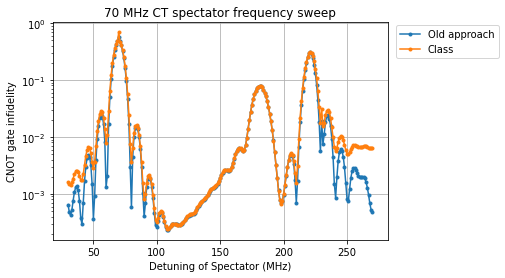

In [52]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_70_CT_spec_sweep_39MHz_0.3rf_new_fidelity_def.pkl", 'rb') as f:
    F_test = pickle.load(f)

plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array(F_test),'.-', label = 'Old approach')
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array(F_spec_sweep_class_3),'.-', label = 'Class')
# peak_ind = list(sp.signal.find_peaks(1 - np.array(F_test),height = 0.01)[0])
# for i in peak_ind:
#     plt.plot((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i], (1-np.array(F_test))[i], '.', markersize = 15, label = np.around((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i],3))
plt.legend(bbox_to_anchor = (1.01,1.01))
# plt.ylim(0)
plt.grid()
plt.title("70 MHz CT spectator frequency sweep")
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()

### Error Budget

In [149]:
pr.get_F_MT(1,2,args)

M
[[0.86 0.5  0.   0.01 0.   0.   0.01 0.  ]
 [0.5  0.86 0.01 0.   0.   0.   0.   0.01]
 [0.   0.01 0.44 0.9  0.   0.   0.   0.01]
 [0.01 0.   0.9  0.44 0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.87 0.5  0.   0.01]
 [0.   0.   0.   0.   0.5  0.87 0.01 0.01]
 [0.01 0.   0.   0.01 0.   0.01 0.45 0.89]
 [0.   0.01 0.01 0.   0.01 0.01 0.89 0.45]]
[[  57.54  147.84   -0.      0.      0.      0.      0.     -0.  ]
 [ 147.84   58.12   -0.      0.      0.      0.      0.      0.  ]
 [  -0.     -0.      3.8    91.62   -0.      0.     -0.      0.  ]
 [   0.      0.     91.62   -0.53   -0.      0.     -0.      0.  ]
 [   0.      0.     -0.     -0.    -87.95    2.32    0.      0.  ]
 [   0.      0.      0.      0.      2.32  -87.43    0.      0.  ]
 [   0.      0.     -0.     -0.      0.      0.   -142.06  125.83]
 [  -0.      0.      0.      0.      0.      0.    125.83 -146.24]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9997461172693897
Matrix from brute 

(0.9997461172693897,
 0.9998801108057567,
 0.9998659885793749,
 0.9999548195542614,
 0.9997912839522313,
 0.9999252841477678)

In [142]:
w[2] = 4.63*2*np.pi
w[0] = 4.59*2*np.pi
w = np.array([4.59,4.7,4.63])*2*np.pi
pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)
F_MU_3, F_MMT_3, F_MTU_3, F_MMCT_3, F_UMCT_3, F_MTMCT_3 = pr.E_vs_F_error_budget(1,2,args)

  3%|█▌                                          | 1/29 [00:11<05:10, 11.11s/it]

M
[[0.83 0.56 0.   0.   0.   0.   0.   0.  ]
 [0.56 0.83 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.57 0.82 0.   0.   0.   0.  ]
 [0.   0.   0.82 0.57 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.83 0.56 0.   0.  ]
 [0.   0.   0.   0.   0.56 0.83 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.58 0.82]
 [0.   0.   0.   0.   0.   0.   0.82 0.58]]
[[  29.41  132.89   -0.     -0.      0.     -0.      0.      0.  ]
 [ 132.89   56.36    0.      0.      0.      0.      0.      0.  ]
 [  -0.     -0.   -138.78  -65.36   -0.     -0.      0.     -0.  ]
 [   0.      0.    -65.36 -171.94   -0.      0.      0.     -0.  ]
 [   0.      0.     -0.     -0.    -22.29   80.99   -0.     -0.  ]
 [   0.      0.     -0.      0.     80.99    4.26   -0.     -0.  ]
 [   0.      0.      0.      0.     -0.     -0.    117.47   10.79]
 [   0.      0.     -0.     -0.     -0.     -0.     10.79   84.11]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9282038136110751
Matrix from br

  7%|███                                         | 2/29 [00:18<04:05,  9.07s/it]

M
[[0.83 0.56 0.   0.   0.   0.   0.   0.  ]
 [0.56 0.83 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.56 0.83 0.   0.   0.   0.  ]
 [0.   0.   0.83 0.56 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.83 0.56 0.   0.  ]
 [0.   0.   0.   0.   0.56 0.83 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.57 0.82]
 [0.   0.   0.   0.   0.   0.   0.82 0.57]]
[[  60.96  157.6     0.     -0.      0.      0.      0.      0.  ]
 [ 157.6    74.24    0.     -0.      0.      0.      0.      0.  ]
 [   0.     -0.   -141.51  -59.9     0.     -0.      0.     -0.  ]
 [   0.     -0.    -59.89 -158.28   -0.      0.      0.     -0.  ]
 [   0.      0.      0.     -0.    -44.21   52.32   -0.     -0.  ]
 [   0.      0.     -0.      0.     52.32  -31.15   -0.     -0.  ]
 [   0.      0.      0.      0.     -0.     -0.     87.72  -10.71]
 [   0.      0.     -0.     -0.     -0.     -0.    -10.71   70.87]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9820081293395064
Matrix from br

 10%|████▌                                       | 3/29 [00:23<02:58,  6.88s/it]

M
[[0.83 0.56 0.   0.   0.   0.   0.   0.  ]
 [0.56 0.83 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.56 0.83 0.   0.   0.   0.  ]
 [0.   0.   0.83 0.56 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.83 0.56 0.   0.  ]
 [0.   0.   0.   0.   0.56 0.83 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.57 0.82]
 [0.   0.   0.   0.   0.   0.   0.82 0.57]]
[[  92.55 -173.13   -0.     -0.      0.     -0.     -0.      0.  ]
 [-173.13  101.18    0.      0.     -0.      0.      0.     -0.  ]
 [  -0.      0.   -130.54  -46.22    0.      0.      0.     -0.  ]
 [  -0.      0.    -46.22 -141.89   -0.      0.      0.     -0.  ]
 [   0.     -0.      0.     -0.     11.1   105.34    0.     -0.  ]
 [  -0.      0.      0.      0.    105.34   19.58   -0.      0.  ]
 [  -0.      0.      0.      0.      0.     -0.    131.44   35.75]
 [   0.     -0.     -0.     -0.     -0.      0.     35.75  120.07]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9923165204165482
Matrix from br

 14%|██████                                      | 4/29 [00:27<02:24,  5.79s/it]

M
[[0.83 0.55 0.   0.   0.   0.   0.   0.  ]
 [0.55 0.83 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.56 0.83 0.   0.   0.   0.  ]
 [0.   0.   0.83 0.56 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.83 0.55 0.   0.  ]
 [0.   0.   0.   0.   0.55 0.83 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.56 0.83]
 [0.   0.   0.   0.   0.   0.   0.83 0.56]]
[[ 124.6  -142.28   -0.     -0.      0.     -0.     -0.     -0.  ]
 [-142.28  130.83    0.      0.      0.      0.     -0.     -0.  ]
 [  -0.      0.    157.68 -116.66    0.     -0.     -0.     -0.  ]
 [  -0.      0.   -116.66  149.01   -0.      0.      0.      0.  ]
 [   0.      0.      0.     -0.    -96.93   -3.88    0.     -0.  ]
 [  -0.      0.     -0.      0.     -3.88  -90.83   -0.      0.  ]
 [  -0.     -0.     -0.      0.      0.     -0.    -75.73 -170.07]
 [  -0.     -0.     -0.      0.     -0.      0.   -170.07  -84.4 ]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9959471516928913
Matrix from brute 

 17%|███████▌                                    | 5/29 [00:31<02:03,  5.13s/it]

M
[[0.84 0.55 0.   0.   0.   0.   0.   0.  ]
 [0.55 0.84 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.55 0.83 0.   0.   0.   0.  ]
 [0.   0.   0.83 0.55 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.84 0.55 0.   0.  ]
 [0.   0.   0.   0.   0.55 0.84 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.56 0.83]
 [0.   0.   0.   0.   0.   0.   0.83 0.56]]
[[ 157.2  -110.43   -0.     -0.      0.     -0.      0.     -0.  ]
 [-110.43  161.93    0.      0.     -0.      0.     -0.      0.  ]
 [  -0.      0.    -88.97   -2.53    0.     -0.      0.     -0.  ]
 [  -0.      0.     -2.53  -96.08   -0.      0.      0.     -0.  ]
 [   0.     -0.      0.     -0.    -56.07   36.25    0.     -0.  ]
 [  -0.      0.     -0.      0.     36.25  -51.45   -0.      0.  ]
 [   0.     -0.      0.      0.      0.     -0.     48.86  -44.69]
 [  -0.      0.     -0.     -0.     -0.      0.    -44.69   41.78]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9976282680677102
Matrix from br

 21%|█████████                                   | 6/29 [00:35<01:48,  4.72s/it]

M
[[0.84 0.54 0.   0.   0.   0.   0.   0.  ]
 [0.54 0.84 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.55 0.84 0.   0.   0.   0.  ]
 [0.   0.   0.84 0.55 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.84 0.54 0.   0.  ]
 [0.   0.   0.   0.   0.54 0.84 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.55 0.83]
 [0.   0.   0.   0.   0.   0.   0.83 0.55]]
[[-169.56  -77.72    0.     -0.      0.     -0.     -0.      0.  ]
 [ -77.72 -165.88    0.     -0.     -0.      0.      0.      0.  ]
 [   0.      0.    -64.78   22.17   -0.     -0.     -0.      0.  ]
 [  -0.     -0.     22.17  -70.87   -0.     -0.     -0.      0.  ]
 [   0.     -0.     -0.     -0.   -120.33  -28.53    0.     -0.  ]
 [  -0.      0.     -0.     -0.    -28.53 -116.74   -0.      0.  ]
 [  -0.      0.     -0.     -0.      0.     -0.    -22.35 -115.39]
 [   0.      0.      0.      0.     -0.      0.   -115.38  -28.4 ]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9985346092065326
Matrix from brute 

 24%|██████████▌                                 | 7/29 [00:39<01:38,  4.48s/it]

M
[[0.85 0.53 0.   0.   0.   0.   0.   0.  ]
 [0.53 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.54 0.84 0.   0.   0.   0.  ]
 [0.   0.   0.84 0.54 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.85 0.53 0.   0.  ]
 [0.   0.   0.   0.   0.53 0.85 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.54 0.84]
 [0.   0.   0.   0.   0.   0.   0.84 0.54]]
[[-135.5   -44.05    0.     -0.     -0.     -0.      0.     -0.  ]
 [ -44.05 -132.6     0.     -0.     -0.     -0.     -0.      0.  ]
 [   0.      0.     59.    146.29    0.     -0.     -0.      0.  ]
 [  -0.     -0.    146.29   53.6    -0.      0.     -0.      0.  ]
 [  -0.     -0.      0.     -0.    -37.39   54.02    0.      0.  ]
 [  -0.     -0.     -0.      0.     54.02  -34.58    0.      0.  ]
 [   0.     -0.     -0.     -0.      0.      0.    151.89   59.21]
 [  -0.      0.      0.      0.      0.      0.     59.21  146.56]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9990450679281844
Matrix from brute 

 28%|████████████▏                               | 8/29 [00:42<01:29,  4.28s/it]

M
[[0.85 0.53 0.   0.   0.   0.   0.   0.  ]
 [0.53 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.53 0.85 0.   0.   0.   0.  ]
 [0.   0.   0.85 0.53 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.85 0.52 0.   0.  ]
 [0.   0.   0.   0.   0.52 0.85 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.53 0.85]
 [0.   0.   0.   0.   0.   0.   0.85 0.53]]
[[-100.62   -9.48    0.      0.     -0.      0.      0.      0.  ]
 [  -9.48  -98.34   -0.     -0.      0.     -0.     -0.     -0.  ]
 [   0.     -0.     20.06  107.6    -0.      0.     -0.      0.  ]
 [   0.     -0.    107.6    15.15   -0.     -0.     -0.      0.  ]
 [  -0.      0.     -0.     -0.    136.91 -131.99   -0.      0.  ]
 [   0.     -0.      0.     -0.   -131.99  139.11    0.     -0.  ]
 [   0.     -0.     -0.     -0.     -0.      0.   -106.35  161.22]
 [   0.     -0.      0.      0.      0.     -0.    161.22 -111.19]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9993551275625966
Matrix from br

 31%|█████████████▋                              | 9/29 [00:46<01:23,  4.18s/it]

M
[[0.86 0.52 0.   0.   0.   0.   0.   0.  ]
 [0.52 0.86 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.52 0.86 0.   0.   0.   0.  ]
 [0.   0.   0.86 0.52 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.86 0.51 0.   0.  ]
 [0.   0.   0.   0.   0.51 0.86 0.   0.01]
 [0.   0.   0.   0.   0.   0.   0.52 0.85]
 [0.   0.   0.   0.   0.   0.01 0.85 0.52]]
[[ -65.26   25.62    0.     -0.     -0.     -0.     -0.      0.  ]
 [  25.62  -63.51    0.     -0.     -0.     -0.      0.     -0.  ]
 [   0.      0.   -122.87  -35.16   -0.     -0.     -0.     -0.  ]
 [  -0.     -0.    -35.16 -127.43    0.      0.      0.      0.  ]
 [  -0.     -0.     -0.      0.      8.94   99.79   -0.     -0.  ]
 [  -0.     -0.     -0.      0.     99.79   10.63   -0.     -0.  ]
 [  -0.      0.     -0.      0.     -0.     -0.    -51.53 -143.78]
 [   0.     -0.     -0.      0.     -0.     -0.   -143.78  -56.  ]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9995576215261268
Matrix from brute 

 34%|██████████████▊                            | 10/29 [00:50<01:17,  4.10s/it]

M
[[0.86 0.51 0.   0.01 0.   0.   0.   0.  ]
 [0.51 0.86 0.01 0.   0.   0.   0.01 0.  ]
 [0.   0.01 0.51 0.86 0.   0.   0.   0.  ]
 [0.01 0.   0.86 0.51 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.86 0.5  0.   0.01]
 [0.   0.   0.   0.   0.5  0.86 0.01 0.  ]
 [0.   0.01 0.   0.   0.   0.01 0.51 0.86]
 [0.   0.   0.   0.   0.01 0.   0.86 0.51]]
[[ -29.92   60.74    0.      0.      0.      0.     -0.      0.  ]
 [  60.74  -28.61   -0.     -0.      0.      0.      0.     -0.  ]
 [   0.     -0.     25.71  113.57   -0.     -0.     -0.      0.  ]
 [   0.     -0.    113.57   21.43    0.      0.     -0.      0.  ]
 [   0.      0.     -0.      0.    -81.71    8.92    0.     -0.  ]
 [   0.      0.     -0.      0.      8.92  -80.46   -0.      0.  ]
 [  -0.      0.     -0.     -0.      0.     -0.    -28.   -120.1 ]
 [   0.     -0.      0.      0.     -0.      0.   -120.1   -32.19]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.999688474823557
Matrix from brute f

 38%|████████████████▎                          | 11/29 [00:54<01:12,  4.06s/it]

M
[[0.87 0.5  0.01 0.   0.   0.   0.   0.01]
 [0.5  0.87 0.   0.01 0.   0.   0.01 0.  ]
 [0.01 0.   0.5  0.87 0.   0.   0.   0.  ]
 [0.   0.01 0.87 0.5  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.87 0.49 0.01 0.  ]
 [0.   0.   0.   0.   0.49 0.87 0.   0.01]
 [0.   0.01 0.   0.   0.01 0.   0.5  0.87]
 [0.01 0.   0.   0.   0.   0.01 0.87 0.5 ]]
[[   5.35   95.81    0.      0.      0.      0.     -0.      0.  ]
 [  95.81    6.26   -0.     -0.      0.      0.      0.     -0.  ]
 [   0.     -0.    123.12 -148.92   -0.     -0.     -0.     -0.  ]
 [   0.     -0.   -148.92  119.04    0.      0.      0.      0.  ]
 [   0.      0.     -0.      0.   -145.03  -54.6     0.     -0.  ]
 [   0.      0.     -0.      0.    -54.61 -144.18   -0.      0.  ]
 [  -0.      0.     -0.      0.      0.     -0.    -28.36 -120.35]
 [   0.     -0.     -0.      0.     -0.      0.   -120.35  -32.32]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9997298751120988
Matrix from brute 

 41%|█████████████████▊                         | 12/29 [00:59<01:10,  4.17s/it]

M
[[0.88 0.48 0.01 0.   0.   0.   0.   0.01]
 [0.48 0.88 0.   0.01 0.   0.   0.01 0.  ]
 [0.01 0.   0.48 0.88 0.   0.   0.   0.01]
 [0.   0.01 0.88 0.48 0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.88 0.48 0.01 0.  ]
 [0.   0.   0.   0.   0.48 0.88 0.   0.01]
 [0.   0.01 0.   0.01 0.01 0.   0.49 0.87]
 [0.01 0.   0.01 0.   0.   0.01 0.87 0.49]]
[[  40.71  131.     -0.     -0.      0.      0.      0.      0.  ]
 [ 131.     41.27    0.      0.      0.      0.      0.      0.  ]
 [  -0.      0.    178.4   -93.57   -0.     -0.     -0.     -0.  ]
 [  -0.      0.    -93.57  174.48    0.      0.      0.      0.  ]
 [   0.      0.     -0.      0.    173.63  -96.12   -0.     -0.  ]
 [   0.      0.     -0.      0.    -96.12  174.13   -0.     -0.  ]
 [   0.      0.     -0.      0.     -0.     -0.    -49.02 -140.94]
 [   0.      0.     -0.      0.     -0.     -0.   -140.94  -52.83]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9997410069475291
Matrix from br

 45%|███████████████████▎                       | 13/29 [01:03<01:06,  4.13s/it]

M
[[0.88 0.47 0.01 0.   0.   0.   0.01 0.  ]
 [0.47 0.88 0.   0.01 0.   0.   0.   0.01]
 [0.01 0.   0.47 0.88 0.   0.   0.   0.  ]
 [0.   0.01 0.88 0.47 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.88 0.47 0.01 0.  ]
 [0.   0.   0.   0.   0.47 0.88 0.   0.01]
 [0.01 0.   0.   0.   0.01 0.   0.47 0.88]
 [0.   0.01 0.   0.   0.   0.01 0.88 0.47]]
[[  76.05  166.16   -0.     -0.      0.      0.      0.      0.  ]
 [ 166.16   76.28    0.      0.      0.      0.      0.      0.  ]
 [  -0.      0.   -159.08  -71.     -0.     -0.     -0.     -0.  ]
 [  -0.      0.    -71.   -162.9     0.      0.      0.      0.  ]
 [   0.      0.     -0.      0.    148.79 -121.12   -0.      0.  ]
 [   0.      0.     -0.      0.   -121.12  148.96    0.     -0.  ]
 [   0.      0.     -0.      0.     -0.      0.    -85.99 -177.84]
 [   0.      0.     -0.      0.      0.     -0.   -177.84  -89.67]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9997436620805431
Matrix from brute 

 48%|████████████████████▊                      | 14/29 [01:08<01:06,  4.42s/it]

M
[[0.89 0.46 0.01 0.01 0.   0.   0.01 0.01]
 [0.46 0.89 0.01 0.01 0.   0.   0.01 0.01]
 [0.01 0.01 0.46 0.89 0.   0.   0.   0.  ]
 [0.01 0.01 0.89 0.46 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.89 0.46 0.01 0.01]
 [0.   0.   0.   0.   0.46 0.89 0.01 0.01]
 [0.01 0.01 0.   0.   0.01 0.01 0.46 0.89]
 [0.01 0.01 0.   0.   0.01 0.01 0.89 0.46]]
[[ 110.9  -159.15   -0.     -0.      0.      0.      0.     -0.  ]
 [-159.15  110.82    0.      0.      0.      0.     -0.      0.  ]
 [  -0.      0.   -160.01  -71.88   -0.     -0.     -0.     -0.  ]
 [  -0.      0.    -71.88 -163.75    0.      0.      0.      0.  ]
 [   0.      0.     -0.      0.    135.01 -135.06   -0.      0.  ]
 [   0.      0.     -0.      0.   -135.06  134.88    0.     -0.  ]
 [   0.     -0.     -0.      0.     -0.      0.   -134.91  133.3 ]
 [  -0.      0.     -0.      0.      0.     -0.    133.3  -138.51]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9996902534184728
Matrix from brute 

 52%|██████████████████████▏                    | 15/29 [01:13<01:05,  4.68s/it]

M
[[0.9  0.44 0.01 0.01 0.   0.   0.   0.01]
 [0.44 0.9  0.01 0.01 0.   0.   0.01 0.01]
 [0.01 0.01 0.45 0.9  0.   0.   0.   0.  ]
 [0.01 0.01 0.9  0.45 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.9  0.44 0.01 0.01]
 [0.   0.   0.   0.   0.44 0.9  0.01 0.01]
 [0.   0.01 0.   0.   0.01 0.01 0.45 0.89]
 [0.01 0.01 0.   0.   0.01 0.01 0.89 0.45]]
[[ 144.53 -125.67   -0.     -0.      0.      0.      0.     -0.  ]
 [-125.67  144.16    0.      0.      0.      0.     -0.      0.  ]
 [  -0.      0.   -175.07  -86.9    -0.     -0.     -0.     -0.  ]
 [  -0.      0.    -86.9  -178.75    0.      0.      0.      0.  ]
 [   0.      0.     -0.      0.    126.94 -143.27   -0.      0.  ]
 [   0.      0.     -0.      0.   -143.27  126.53    0.     -0.  ]
 [   0.     -0.     -0.      0.     -0.      0.    168.95   77.19]
 [  -0.      0.     -0.      0.      0.     -0.     77.19  165.42]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9995617486073145
Matrix from br

 55%|███████████████████████▋                   | 16/29 [01:17<00:58,  4.51s/it]

M
[[0.9  0.43 0.01 0.02 0.   0.   0.01 0.01]
 [0.43 0.9  0.02 0.01 0.   0.   0.01 0.01]
 [0.01 0.02 0.43 0.9  0.   0.   0.   0.  ]
 [0.02 0.01 0.9  0.43 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.9  0.43 0.01 0.02]
 [0.   0.   0.   0.   0.43 0.9  0.02 0.01]
 [0.01 0.01 0.   0.   0.01 0.02 0.43 0.9 ]
 [0.01 0.01 0.   0.   0.02 0.01 0.9  0.43]]
[[ 178.55  -91.76   -0.     -0.     -0.     -0.     -0.     -0.  ]
 [ -91.76  177.91    0.      0.      0.     -0.     -0.     -0.  ]
 [  -0.      0.    144.42 -127.41   -0.      0.      0.     -0.  ]
 [  -0.      0.   -127.41  140.76   -0.      0.      0.     -0.  ]
 [  -0.      0.     -0.     -0.    130.69 -139.65   -0.      0.  ]
 [  -0.     -0.      0.      0.   -139.65  130.      0.     -0.  ]
 [  -0.     -0.      0.      0.     -0.      0.     98.74    6.98]
 [  -0.     -0.     -0.     -0.      0.     -0.      6.98   95.25]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9993673912749464
Matrix from brute 

 59%|█████████████████████████▏                 | 17/29 [01:21<00:51,  4.32s/it]

M
[[0.91 0.42 0.02 0.02 0.   0.   0.01 0.01]
 [0.42 0.91 0.02 0.02 0.   0.   0.01 0.01]
 [0.02 0.02 0.41 0.91 0.   0.   0.   0.  ]
 [0.02 0.02 0.91 0.41 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.91 0.41 0.02 0.02]
 [0.   0.   0.   0.   0.41 0.91 0.02 0.02]
 [0.01 0.01 0.   0.   0.02 0.02 0.42 0.91]
 [0.01 0.01 0.   0.   0.02 0.02 0.91 0.42]]
[[-146.77  -57.19    0.     -0.     -0.      0.     -0.      0.  ]
 [ -57.19 -147.68    0.     -0.      0.     -0.      0.     -0.  ]
 [   0.      0.     79.56  167.67   -0.      0.     -0.     -0.  ]
 [  -0.     -0.    167.67   75.87    0.      0.      0.      0.  ]
 [  -0.      0.     -0.      0.    145.34 -125.09   -0.     -0.  ]
 [   0.     -0.      0.      0.   -125.09  144.38   -0.     -0.  ]
 [  -0.      0.     -0.      0.     -0.     -0.     14.4   -77.4 ]
 [   0.     -0.     -0.      0.     -0.     -0.    -77.4    10.88]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9991899883351153
Matrix from br

 62%|██████████████████████████▋                | 18/29 [01:25<00:46,  4.23s/it]

M
[[0.92 0.4  0.02 0.01 0.01 0.   0.   0.01]
 [0.4  0.92 0.01 0.02 0.   0.01 0.02 0.01]
 [0.02 0.01 0.4  0.92 0.   0.   0.   0.01]
 [0.01 0.02 0.92 0.4  0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.92 0.4  0.02 0.01]
 [0.   0.01 0.   0.   0.4  0.92 0.01 0.02]
 [0.   0.02 0.   0.01 0.02 0.01 0.4  0.92]
 [0.01 0.01 0.01 0.   0.01 0.02 0.92 0.4 ]]
[[-114.33  -24.92    0.      0.     -0.      0.     -0.     -0.  ]
 [ -24.92 -115.51   -0.     -0.      0.     -0.     -0.     -0.  ]
 [   0.     -0.     13.2   101.34   -0.      0.     -0.      0.  ]
 [   0.     -0.    101.34    9.48    0.     -0.     -0.      0.  ]
 [  -0.      0.     -0.      0.    158.22 -112.39   -0.     -0.  ]
 [   0.     -0.      0.     -0.   -112.39  157.     -0.     -0.  ]
 [  -0.     -0.     -0.     -0.     -0.     -0.    -70.98 -162.75]
 [  -0.     -0.      0.      0.     -0.     -0.   -162.75  -74.51]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9990584137018178
Matrix from br

 66%|████████████████████████████▏              | 19/29 [01:29<00:41,  4.18s/it]

M
[[0.92 0.38 0.02 0.03 0.01 0.   0.01 0.01]
 [0.38 0.92 0.03 0.02 0.   0.01 0.01 0.01]
 [0.02 0.03 0.38 0.92 0.   0.   0.   0.01]
 [0.03 0.02 0.92 0.38 0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.92 0.38 0.02 0.03]
 [0.   0.01 0.   0.   0.38 0.92 0.02 0.02]
 [0.01 0.01 0.   0.01 0.02 0.02 0.39 0.92]
 [0.01 0.01 0.01 0.   0.03 0.02 0.92 0.39]]
[[ -84.34    4.89    0.      0.     -0.      0.     -0.     -0.  ]
 [   4.89  -85.77   -0.     -0.      0.     -0.     -0.     -0.  ]
 [   0.     -0.    -53.71   34.48    0.      0.      0.      0.  ]
 [   0.     -0.     34.48  -57.45   -0.     -0.     -0.     -0.  ]
 [  -0.      0.      0.     -0.    168.85 -101.95   -0.      0.  ]
 [   0.     -0.      0.     -0.   -101.95  167.37    0.     -0.  ]
 [  -0.     -0.      0.     -0.     -0.      0.   -156.76  111.52]
 [  -0.     -0.      0.     -0.      0.     -0.    111.52 -160.29]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9986221435782138
Matrix from br

 69%|█████████████████████████████▋             | 20/29 [01:33<00:37,  4.15s/it]

M
[[0.93 0.37 0.02 0.03 0.01 0.   0.01 0.01]
 [0.37 0.93 0.03 0.02 0.   0.01 0.01 0.01]
 [0.02 0.03 0.37 0.93 0.   0.   0.   0.01]
 [0.03 0.02 0.93 0.37 0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.93 0.36 0.02 0.03]
 [0.   0.01 0.   0.   0.36 0.93 0.03 0.02]
 [0.01 0.01 0.   0.01 0.02 0.03 0.37 0.93]
 [0.01 0.01 0.01 0.   0.03 0.02 0.93 0.37]]
[[ -56.47   32.72    0.     -0.     -0.      0.     -0.      0.  ]
 [  32.72  -58.16    0.     -0.      0.     -0.      0.     -0.  ]
 [   0.      0.   -123.6   -35.55    0.      0.      0.     -0.  ]
 [  -0.     -0.    -35.55 -127.38   -0.     -0.      0.     -0.  ]
 [  -0.      0.      0.     -0.    178.61  -92.2    -0.      0.  ]
 [   0.     -0.      0.     -0.    -92.2   176.88    0.     -0.  ]
 [  -0.      0.      0.      0.     -0.      0.    115.68   23.87]
 [   0.     -0.     -0.     -0.      0.     -0.     23.87  112.13]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9980422159924605
Matrix from brute 

 72%|███████████████████████████████▏           | 21/29 [01:37<00:33,  4.13s/it]

M
[[0.94 0.35 0.03 0.02 0.01 0.   0.01 0.01]
 [0.35 0.94 0.02 0.03 0.   0.01 0.02 0.01]
 [0.03 0.02 0.35 0.93 0.   0.   0.   0.01]
 [0.02 0.03 0.93 0.35 0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.94 0.35 0.03 0.02]
 [0.   0.01 0.   0.   0.35 0.94 0.02 0.03]
 [0.01 0.02 0.   0.01 0.03 0.02 0.36 0.93]
 [0.01 0.01 0.01 0.   0.02 0.03 0.93 0.36]]
[[ -28.31   60.8     0.     -0.     -0.      0.      0.      0.  ]
 [  60.8   -30.24    0.     -0.      0.     -0.      0.      0.  ]
 [   0.      0.    147.5  -124.5     0.     -0.      0.     -0.  ]
 [  -0.     -0.   -124.5   143.65    0.     -0.      0.     -0.  ]
 [  -0.      0.      0.      0.   -164.27  -75.18    0.     -0.  ]
 [   0.     -0.     -0.     -0.    -75.19 -166.25   -0.      0.  ]
 [   0.      0.      0.      0.      0.     -0.     16.22  -75.68]
 [   0.      0.     -0.     -0.     -0.      0.    -75.68   12.61]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9979675528780892
Matrix from brute 

 76%|████████████████████████████████▌          | 22/29 [01:41<00:28,  4.09s/it]

M
[[0.94 0.33 0.02 0.04 0.01 0.   0.01 0.01]
 [0.33 0.94 0.04 0.02 0.   0.01 0.01 0.01]
 [0.02 0.04 0.33 0.94 0.   0.   0.   0.01]
 [0.04 0.02 0.94 0.33 0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.94 0.33 0.02 0.04]
 [0.   0.01 0.   0.   0.33 0.94 0.04 0.02]
 [0.01 0.01 0.   0.01 0.02 0.04 0.33 0.94]
 [0.01 0.01 0.01 0.   0.04 0.02 0.94 0.33]]
[[   4.15   92.92    0.      0.      0.      0.      0.     -0.  ]
 [  92.92    1.94   -0.     -0.      0.      0.     -0.      0.  ]
 [   0.     -0.     14.71  102.8    -0.     -0.     -0.      0.  ]
 [   0.     -0.    102.8    10.67   -0.     -0.     -0.      0.  ]
 [   0.      0.     -0.     -0.   -127.4   -38.64    0.      0.  ]
 [   0.      0.     -0.     -0.    -38.65 -129.65    0.      0.  ]
 [   0.     -0.     -0.     -0.      0.      0.   -111.69  156.54]
 [  -0.      0.      0.      0.      0.      0.    156.54 -115.47]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9972748802861355
Matrix from brute 

 79%|██████████████████████████████████         | 23/29 [01:45<00:24,  4.11s/it]

M
[[0.95 0.32 0.03 0.03 0.01 0.   0.01 0.01]
 [0.32 0.95 0.03 0.03 0.   0.01 0.02 0.01]
 [0.03 0.03 0.31 0.95 0.   0.   0.   0.01]
 [0.03 0.03 0.95 0.31 0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.95 0.32 0.03 0.03]
 [0.   0.01 0.   0.   0.32 0.95 0.03 0.03]
 [0.01 0.02 0.   0.01 0.03 0.03 0.31 0.95]
 [0.01 0.01 0.01 0.   0.03 0.03 0.95 0.31]]
[[  32.36  121.31   -0.      0.      0.      0.      0.      0.  ]
 [ 121.31   29.88   -0.      0.      0.      0.      0.      0.  ]
 [  -0.     -0.   -105.65  -17.97    0.      0.      0.      0.  ]
 [   0.      0.    -17.97 -109.88   -0.     -0.     -0.     -0.  ]
 [   0.      0.      0.     -0.    -99.89  -10.95    0.      0.  ]
 [   0.      0.      0.     -0.    -10.95 -102.4     0.      0.  ]
 [   0.      0.      0.     -0.      0.      0.    127.71   35.53]
 [   0.      0.      0.     -0.      0.      0.     35.53  123.76]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9971422711278417
Matrix from br

 83%|███████████████████████████████████▌       | 24/29 [01:50<00:20,  4.13s/it]

M
[[0.95 0.3  0.04 0.03 0.01 0.   0.01 0.01]
 [0.3  0.95 0.03 0.04 0.   0.01 0.01 0.01]
 [0.04 0.03 0.3  0.95 0.   0.   0.   0.01]
 [0.03 0.04 0.95 0.3  0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.95 0.3  0.04 0.03]
 [0.   0.01 0.   0.   0.3  0.95 0.03 0.04]
 [0.01 0.01 0.   0.01 0.04 0.03 0.3  0.95]
 [0.01 0.01 0.01 0.   0.03 0.04 0.95 0.3 ]]
[[  54.18  142.63   -0.     -0.      0.      0.      0.      0.  ]
 [ 142.63   51.45    0.      0.     -0.      0.      0.      0.  ]
 [  -0.      0.    158.53 -113.44    0.     -0.      0.     -0.  ]
 [  -0.      0.   -113.44  154.19    0.      0.      0.     -0.  ]
 [   0.     -0.      0.      0.    -87.94    0.5     0.     -0.  ]
 [   0.      0.     -0.      0.      0.5   -90.71   -0.      0.  ]
 [   0.      0.      0.      0.      0.     -0.     22.45  -69.41]
 [   0.      0.     -0.     -0.     -0.      0.    -69.41   18.43]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9967228163218852
Matrix from brute 

 86%|█████████████████████████████████████      | 25/29 [01:54<00:16,  4.13s/it]

M
[[0.96 0.28 0.03 0.05 0.01 0.   0.01 0.01]
 [0.28 0.96 0.05 0.03 0.   0.01 0.01 0.01]
 [0.03 0.05 0.28 0.96 0.   0.   0.01 0.02]
 [0.05 0.03 0.96 0.28 0.   0.   0.02 0.01]
 [0.01 0.   0.   0.   0.96 0.28 0.03 0.05]
 [0.   0.01 0.   0.   0.28 0.96 0.05 0.03]
 [0.01 0.01 0.01 0.02 0.03 0.05 0.29 0.96]
 [0.01 0.01 0.02 0.01 0.05 0.03 0.96 0.29]]
[[  74.33  162.74   -0.    156.47    0.     -0.      0.     -0.  ]
 [ 162.74   71.34  -23.63    0.     -0.      0.     -0.      0.  ]
 [  -0.    -23.53   57.7   145.52   -0.     -0.     -0.      0.  ]
 [ 156.58    0.    145.52   53.24    0.      0.     -0.      0.  ]
 [   0.     -0.     -0.      0.    -75.94   12.46    0.   -168.66]
 [  -0.      0.     -0.      0.     12.45  -78.96 -168.86    0.  ]
 [   0.     -0.     -0.     -0.      0.   -168.84  -86.24 -178.19]
 [  -0.      0.      0.      0.   -168.64    0.   -178.19  -90.37]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9954837858712849
Matrix from brute 

 90%|██████████████████████████████████████▌    | 26/29 [01:58<00:12,  4.16s/it]

M
[[0.96 0.26 0.04 0.04 0.01 0.   0.01 0.01]
 [0.26 0.96 0.04 0.04 0.01 0.01 0.02 0.01]
 [0.04 0.04 0.27 0.96 0.   0.   0.   0.02]
 [0.04 0.04 0.96 0.27 0.   0.   0.02 0.  ]
 [0.01 0.01 0.   0.   0.96 0.26 0.04 0.04]
 [0.   0.01 0.   0.   0.26 0.96 0.04 0.04]
 [0.01 0.02 0.   0.02 0.04 0.04 0.27 0.96]
 [0.01 0.01 0.02 0.   0.04 0.04 0.96 0.27]]
[[  92.51 -178.75   -0.      0.      0.     -0.      0.     -0.  ]
 [-178.75   89.27   -0.      0.     -0.      0.     -0.      0.  ]
 [  -0.     -0.    -46.35   41.02   -0.      0.      0.      0.  ]
 [   0.      0.     41.02  -50.95   -0.      0.     -0.     -0.  ]
 [   0.     -0.     -0.     -0.    -64.94   23.77    0.      0.  ]
 [  -0.      0.      0.      0.     23.77  -68.22    0.      0.  ]
 [   0.     -0.      0.     -0.      0.      0.    162.97   70.48]
 [  -0.      0.      0.     -0.      0.      0.     70.48  158.72]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9956029058326938
Matrix from br

 93%|████████████████████████████████████████   | 27/29 [02:02<00:08,  4.12s/it]

M
[[0.97 0.24 0.04 0.05 0.01 0.   0.01 0.01]
 [0.24 0.97 0.05 0.04 0.   0.01 0.01 0.01]
 [0.04 0.05 0.24 0.97 0.   0.   0.   0.01]
 [0.05 0.04 0.97 0.24 0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.97 0.24 0.04 0.05]
 [0.   0.01 0.   0.   0.24 0.97 0.05 0.04]
 [0.01 0.01 0.   0.01 0.04 0.05 0.25 0.97]
 [0.01 0.01 0.01 0.   0.05 0.04 0.97 0.25]]
[[ 118.08 -154.1    -0.   -125.51    0.     -0.      0.      0.  ]
 [-154.1   114.53   53.98    0.     -0.      0.      0.      0.  ]
 [  -0.     54.03  147.15 -124.99   -0.     -0.      0.     -0.  ]
 [-125.45    0.   -124.99  142.13    0.      0.      0.      0.  ]
 [   0.     -0.     -0.      0.    -27.3    60.5     0.    -84.69]
 [  -0.      0.     -0.      0.     60.5   -30.89  -85.33    0.  ]
 [   0.      0.      0.      0.      0.    -85.32    8.89  -83.01]
 [   0.      0.     -0.      0.    -84.68    0.    -83.01    4.27]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9944981997866998
Matrix from brute 

 97%|█████████████████████████████████████████▌ | 28/29 [02:06<00:04,  4.15s/it]

M
[[0.97 0.23 0.05 0.03 0.01 0.   0.01 0.01]
 [0.23 0.97 0.03 0.05 0.   0.01 0.02 0.01]
 [0.05 0.03 0.21 0.98 0.   0.   0.   0.01]
 [0.03 0.05 0.98 0.21 0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.97 0.23 0.05 0.03]
 [0.   0.01 0.   0.   0.23 0.97 0.03 0.05]
 [0.01 0.02 0.   0.01 0.05 0.03 0.22 0.97]
 [0.01 0.01 0.01 0.   0.03 0.05 0.97 0.22]]
[[ 142.88 -128.82   -0.      0.      0.     -0.     -0.     -0.  ]
 [-128.82  139.03   -0.      0.     -0.      0.     -0.     -0.  ]
 [  -0.     -0.    -29.41   57.56   -0.      0.     -0.      0.  ]
 [   0.      0.     57.56  -35.03   -0.      0.     -0.      0.  ]
 [   0.     -0.     -0.     -0.     12.    100.31   -0.      0.  ]
 [  -0.      0.      0.      0.    100.31    8.1     0.     -0.  ]
 [  -0.     -0.     -0.     -0.     -0.      0.   -152.64  114.47]
 [  -0.     -0.      0.      0.      0.     -0.    114.47 -157.79]]
Signs from brute force: 
[1, 1, 1, 1, 1, 1, 1, -1]
Fidelity from brute force:  0.9951931208874956
Matrix from brute 

100%|███████████████████████████████████████████| 29/29 [02:10<00:00,  4.52s/it]

M
[[0.98 0.21 0.05 0.06 0.01 0.   0.01 0.01]
 [0.21 0.98 0.05 0.05 0.   0.01 0.01 0.01]
 [0.05 0.05 0.2  0.98 0.   0.   0.   0.01]
 [0.05 0.05 0.98 0.2  0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.98 0.2  0.05 0.05]
 [0.   0.01 0.   0.   0.2  0.98 0.05 0.05]
 [0.01 0.01 0.   0.01 0.05 0.05 0.2  0.98]
 [0.01 0.01 0.01 0.   0.05 0.05 0.98 0.2 ]]
[[ 155.67 -117.08   -0.    -64.66    0.     -0.     -0.      0.  ]
 [-117.08  151.53  114.62    0.     -0.      0.      0.     -0.  ]
 [  -0.    114.66 -147.04  -59.3    -0.      0.      0.     -0.  ]
 [ -64.62    0.    -59.3  -152.92   -0.      0.      0.     -0.  ]
 [   0.     -0.     -0.     -0.     19.98  107.21   -0.    -12.91]
 [  -0.      0.      0.      0.    107.21   15.8   -13.72    0.  ]
 [  -0.      0.      0.      0.     -0.    -13.71   85.18   -6.83]
 [   0.     -0.     -0.     -0.    -12.9     0.     -6.83   79.8 ]]
Signs from brute force: 
[1, 1, -1, -1, -1, -1, 1, -1]
Fidelity from brute force:  0.9935680678451533
Matrix from br

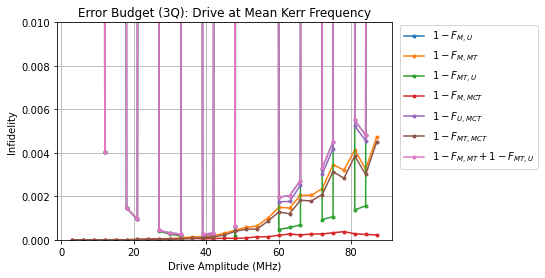

In [143]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU_3), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT_3), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU_3), '.-', label = r'$1 - F_{MT,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMCT_3), '.-', label = r'$1 - F_{M,MCT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_UMCT_3), '.-', label = r'$1 - F_{U,MCT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTMCT_3), '.-', label = r'$1 - F_{MT,MCT}$')

plt.plot(np.arange(3,90,3),1 - np.array(F_MMT_3) + 1 - np.array(F_MTU_3), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("Infidelity")
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title("Error Budget (3Q): Drive at Mean Kerr Frequency")
plt.show()

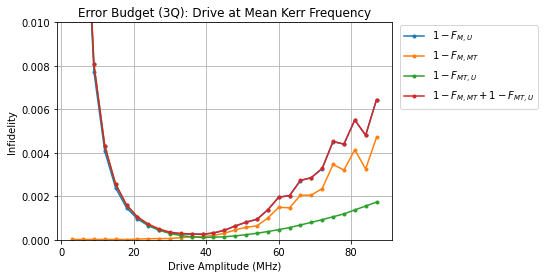

In [264]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU_3), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT_3), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU_3), '.-', label = r'$1 - F_{MT,U}$')
# plt.plot(np.arange(3,90,3),1 - np.array(F_MMCT_3), '.-', label = r'$1 - F_{M,MCT}$')
# plt.plot(np.arange(3,90,3),1 - np.array(F_UMCT_3), '.-', label = r'$1 - F_{U,MCT}$')
# plt.plot(np.arange(3,90,3),1 - np.array(F_MTMCT_3), '.-', label = r'$1 - F_{MT,MCT}$')

plt.plot(np.arange(3,90,3),1 - np.array(F_MMT_3) + 1 - np.array(F_MTU_3), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("Infidelity")
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title("Error Budget (3Q): Drive at Mean Kerr Frequency")
plt.show()

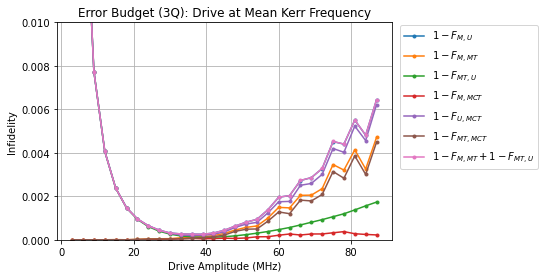

In [14]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU_3), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT_3), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU_3), '.-', label = r'$1 - F_{MT,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMCT_3), '.-', label = r'$1 - F_{M,MCT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_UMCT_3), '.-', label = r'$1 - F_{U,MCT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTMCT_3), '.-', label = r'$1 - F_{MT,MCT}$')

plt.plot(np.arange(3,90,3),1 - np.array(F_MMT_3) + 1 - np.array(F_MTU_3), '.-', label = r'$1 - F_{M,MT} + 1 - F_{MT,U}$')
plt.grid()
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("Infidelity")
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title("Error Budget (3Q): Drive at Mean Kerr Frequency")
plt.show()

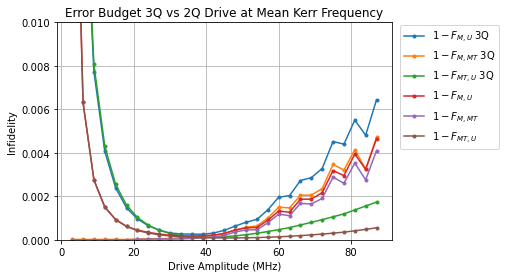

In [265]:
plt.plot(np.arange(3,90,3),1 - np.array(F_MU_3), '.-', label = r'$1 - F_{M,U}$ 3Q')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT_3), '.-', label = r'$1 - F_{M,MT}$ 3Q')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU_3), '.-', label = r'$1 - F_{MT,U}$ 3Q')

plt.plot(np.arange(3,90,3),1 - np.array(F_MU), '.-', label = r'$1 - F_{M,U}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MMT), '.-', label = r'$1 - F_{M,MT}$')
plt.plot(np.arange(3,90,3),1 - np.array(F_MTU), '.-', label = r'$1 - F_{MT,U}$')


plt.grid()
plt.xlabel("Drive Amplitude (MHz)")
plt.ylabel("Infidelity")
plt.ylim(0,0.01)
plt.legend(bbox_to_anchor = (1.01,1.01))
plt.title("Error Budget 3Q vs 2Q Drive at Mean Kerr Frequency")
plt.show()

### Spectator Sweep with Error Budget

In [46]:
N = 3
N_l = 4
exc = 4
w = np.array([4.59,4.7,4.63])*2*np.pi
anh_array = np.array([0.3,0.3,0.3])*2*np.pi
J = [[0,1,0],
     [1,0,1],
     [0,1,0]]
J = np.array(J)*0.003*2*np.pi
control_target = [[0,0,0],
                  [1,0,1],
                  [0,0,0]]
args = {}
args['Emax'] = 1e-3*39*2*np.pi
args['tp'] = 130.17
args['rf'] = 0.3
args['t_step'] = 0.1

pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)

F_spec_sweep = []
t = np.linspace(0,args['tp'],400)
def return_f_spec_sweep_class(ws):
    w[0] = ws
    pr = processor(N,N_l,exc,w,anh_array,J,control_target,args)
    F_MU, F_MMT, F_MTU, F_MMCT, F_UMCT, F_MTMCT = pr.get_F_MT(1,2,args)
    return F_MU, F_MMT, F_MTU, F_MMCT, F_UMCT, F_MTMCT

ws_range = 2*np.pi*np.arange(4.43,4.67,0.001)
F_spec_sweep_class_3_error_budget = Parallel(n_jobs=-1)(delayed(return_f_spec_sweep_class)(w) for w in tqdm(ws_range))

  3%|█▍                                         | 8/241 [00:06<03:57,  1.02s/it]capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

In [16]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_70_CT_spec_sweep_39MHz_0.3rf_class_error_budget_relaxed.pkl",'wb') as f:
    pickle.dump(F_spec_sweep_class_3_error_budget,f)

In [17]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_70_CT_spec_sweep_39MHz_0.3rf_class_error_budget_relaxed.pkl",'rb') as f:
    F_spec_sweep_class_3_error_budget = pickle.load(f)

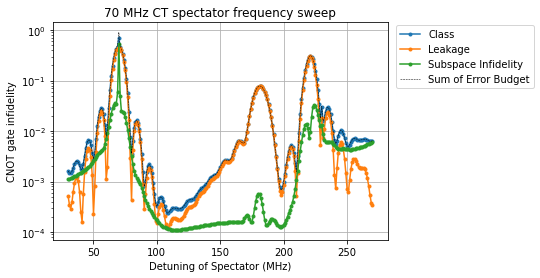

In [28]:
with open("./pickles/CR_gate_raw_fidelity/3_qubit_70_CT_spec_sweep_39MHz_0.3rf_new_fidelity_def.pkl", 'rb') as f:
    F_test = pickle.load(f)
    
with open("./pickles/CR_gate_raw_fidelity/3_qubit_70_CT_spec_sweep_39MHz_0.3rf_class.pkl",'rb') as f:
    F_spec_sweep_class_3 = pickle.load(f)

# plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array(F_test),'.-', label = 'Old approach')
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array([i[0] for i in F_spec_sweep_class_3_error_budget]),'.-', label = 'Class')
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array([i[1] for i in F_spec_sweep_class_3_error_budget]),'.-', label = 'Leakage')
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),1 - np.array([i[2] for i in F_spec_sweep_class_3_error_budget]),'.-', label = 'Subspace Infidelity')
plt.semilogy(1e3*(4.7 - np.arange(4.43,4.67,0.001)),2 - np.array([i[2] + i[1] for i in F_spec_sweep_class_3_error_budget]),'k--', label = 'Sum of Error Budget', linewidth = 0.5)
# peak_ind = list(sp.signal.find_peaks(1 - np.array(F_test),height = 0.01)[0])
# for i in peak_ind:
#     plt.plot((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i], (1-np.array(F_test))[i], '.', markersize = 15, label = np.around((1e3*(4.7 - np.arange(4.43,4.67,0.001)))[i],3))
plt.legend(bbox_to_anchor = (1.01,1.01))
# plt.ylim(0)
plt.grid()
plt.title("70 MHz CT spectator frequency sweep")
plt.xlabel("Detuning of Spectator (MHz)")
plt.ylabel("CNOT gate infidelity")
plt.show()